In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import shutil
import os

# Définir les chemins pour les fichiers source sur Google Drive et destination locale

X_trein_french = '/content/drive/MyDrive/Colab Notebooks/fahim/final/X_trainfr_final.csv'

# Définir les chemins locaux pour stocker les fichiers copiés
local_path = '/content/data/'

# Créer le dossier local si ce n'est pas déjà fait
os.makedirs(local_path, exist_ok=True)

# Copier les fichiers de Google Drive vers l'espace local de Colab

shutil.copy(X_trein_french, local_path)

# Vérifier que les fichiers ont été copiés correctement
print("Fichiers copiés dans l'espace local de Colab.")
print(os.listdir(local_path))

Fichiers copiés dans l'espace local de Colab.
['X_trainfr_final.csv']


In [ ]:
!pip install sacremoses

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 9.1 MB/s eta 0:00:00


Device utilisé: cuda
Train: 74447, Validation: 13138


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/811k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/508 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== DÉBUT DE L'ENTRAÎNEMENT CAMEMBERT ===


Epoch,Training Loss,Validation Loss,F1 Weighted,F1 Macro,Accuracy,F1 Class 0 10,F1 Class 1 40,F1 Class 2 50,F1 Class 3 60,F1 Class 4 1140,F1 Class 5 1160,F1 Class 6 1180,F1 Class 7 1280,F1 Class 8 1281,F1 Class 9 1300,F1 Class 10 1301,F1 Class 11 1302,F1 Class 12 1320,F1 Class 13 1560,F1 Class 14 1920,F1 Class 15 1940,F1 Class 16 2060,F1 Class 17 2220,F1 Class 18 2280,F1 Class 19 2403,F1 Class 20 2462,F1 Class 21 2522,F1 Class 22 2582,F1 Class 23 2583,F1 Class 24 2585,F1 Class 25 2705,F1 Class 26 2905
1,2.889900,2.148369,0.488571,0.438182,0.534556,0.365782,0.000000,0.156863,0.439791,0.482372,0.530581,0.000000,0.432836,0.181303,0.780544,0.549112,0.221176,0.113553,0.499074,0.703660,0.813187,0.619539,0.673392,0.643678,0.457055,0.093506,0.809171,0.211416,0.784658,0.284024,0.604959,0.379679
2,1.846700,1.378304,0.656000,0.634030,0.678109,0.541555,0.174840,0.694524,0.827586,0.549320,0.732516,0.000000,0.503096,0.471910,0.835244,0.657005,0.542314,0.377976,0.654624,0.806711,0.930599,0.691943,0.813814,0.790782,0.566667,0.536285,0.859752,0.491176,0.895262,0.650131,0.647929,0.875233
3,1.296000,0.988853,0.734079,0.718858,0.743112,0.570647,0.462908,0.691391,0.870175,0.612322,0.824291,0.141643,0.461261,0.503420,0.865035,0.885714,0.678191,0.662069,0.751734,0.856512,0.944356,0.726158,0.877023,0.849903,0.734017,0.632219,0.883301,0.627876,0.929928,0.740645,0.690042,0.936396
4,0.986800,0.799121,0.771392,0.764581,0.775460,0.605263,0.556430,0.737752,0.884106,0.710956,0.868794,0.577540,0.456604,0.517464,0.879647,0.935275,0.704981,0.714441,0.763840,0.870658,0.948882,0.739689,0.861586,0.879461,0.788448,0.692308,0.897233,0.671642,0.935065,0.785615,0.694362,0.965636
5,0.812800,0.711177,0.795582,0.789813,0.797838,0.602941,0.587361,0.730506,0.911304,0.720930,0.892794,0.660839,0.582299,0.568935,0.892520,0.943820,0.753623,0.741617,0.780181,0.877013,0.973770,0.743056,0.877898,0.887509,0.795549,0.742947,0.905361,0.703466,0.943220,0.807692,0.739474,0.958333
6,0.709000,0.641515,0.814218,0.808607,0.814736,0.635897,0.620779,0.762570,0.935750,0.738928,0.905923,0.697329,0.639332,0.568935,0.924438,0.965964,0.751256,0.754237,0.786070,0.887556,0.980132,0.755585,0.909677,0.896412,0.817712,0.742496,0.914094,0.730323,0.947507,0.833563,0.764398,0.965517
7,0.636500,0.596459,0.822857,0.817590,0.822956,0.640244,0.684755,0.808260,0.950331,0.735714,0.919201,0.693069,0.668666,0.567857,0.944634,0.980263,0.728774,0.754912,0.781388,0.888054,0.968903,0.761039,0.884080,0.911234,0.812221,0.783784,0.916112,0.732143,0.955184,0.846154,0.778351,0.979592
8,0.584700,0.586386,0.826889,0.822801,0.828589,0.639381,0.690013,0.806405,0.936535,0.750000,0.920608,0.727273,0.646677,0.563574,0.944785,0.969005,0.755556,0.768763,0.800813,0.888092,0.983444,0.754821,0.910543,0.905971,0.824727,0.787682,0.922034,0.752577,0.952632,0.842250,0.791866,0.979592
9,0.541600,0.562266,0.832940,0.827737,0.832927,0.648091,0.674446,0.808696,0.960133,0.759281,0.925606,0.749621,0.675991,0.582524,0.942857,0.972268,0.755772,0.774923,0.810345,0.900593,0.965854,0.781794,0.917460,0.916784,0.827035,0.798046,0.925800,0.759748,0.953443,0.852778,0.739946,0.969072
10,0.509100,0.543638,0.839146,0.834364,0.840234,0.644342,0.728246,0.838806,0.952066,0.760429,0.924806,0.729050,0.675325,0.576389,0.944406,0.980263,0.768293,0.783058,0.824671,0.905153,0.981758,0.784969,0.859649,0.910727,0.839221,0.820261,0.925699,0.768666,0.958940,0.866035,0.788372,0.988235



EPOCH 1 - RÉSULTATS DÉTAILLÉS:
  F1-weighted: 0.4886  NOUVEAU RECORD!
  F1-macro: 0.4382
  Accuracy: 0.5346
  Eval Loss: 2.1484
 Classes faibles: 10: 0.366, 40: 0.000, 50: 0.157

EPOCH 2 - RÉSULTATS DÉTAILLÉS:
  F1-weighted: 0.6560  NOUVEAU RECORD!
  F1-macro: 0.6340
  Accuracy: 0.6781
  Eval Loss: 1.3783
 Classes faibles: 40: 0.175, 1180: 0.000, 1281: 0.472

EPOCH 3 - RÉSULTATS DÉTAILLÉS:
  F1-weighted: 0.7341  NOUVEAU RECORD!
  F1-macro: 0.7189
  Accuracy: 0.7431
  Eval Loss: 0.9889
 Classes faibles: 40: 0.463, 1180: 0.142, 1280: 0.461

EPOCH 4 - RÉSULTATS DÉTAILLÉS:
  F1-weighted: 0.7714  NOUVEAU RECORD!
  F1-macro: 0.7646
  Accuracy: 0.7755
  Eval Loss: 0.7991
 Classes faibles: 1280: 0.457

EPOCH 5 - RÉSULTATS DÉTAILLÉS:
  F1-weighted: 0.7956  NOUVEAU RECORD!
  F1-macro: 0.7898
  Accuracy: 0.7978
  Eval Loss: 0.7112

EPOCH 6 - RÉSULTATS DÉTAILLÉS:
  F1-weighted: 0.8142  NOUVEAU RECORD!
  F1-macro: 0.8086
  Accuracy: 0.8147
  Eval Loss: 0.6415

EPOCH 7 - RÉSULTATS DÉTAILLÉS:
  F1-w

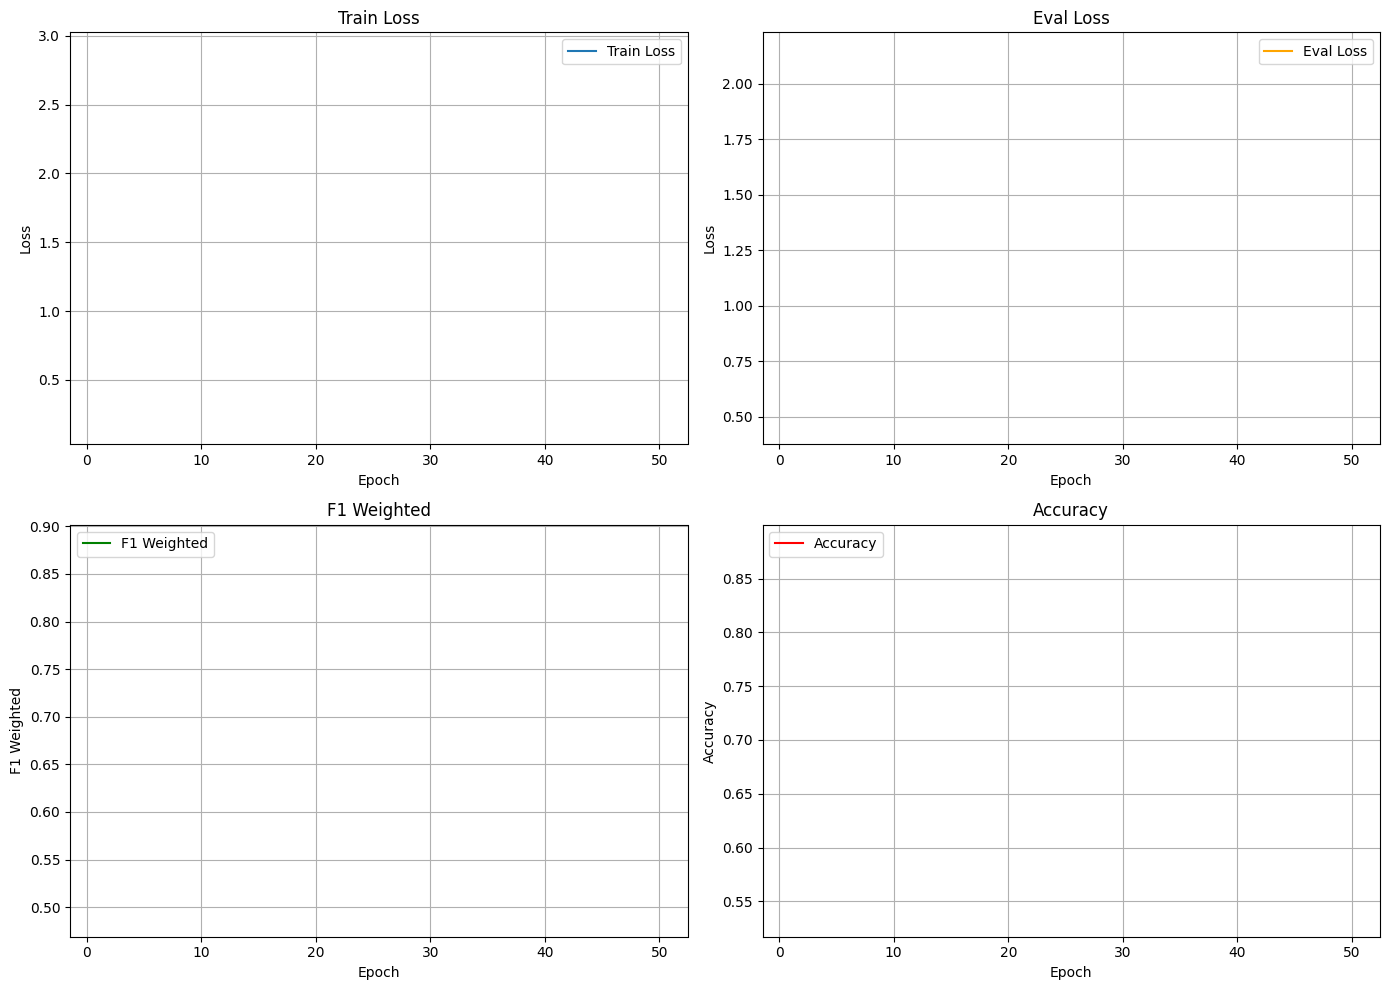

Meilleur checkpoint : ./results_cam/checkpoint-53544

=== SAUVEGARDE DES LOGITS ET LABELS COMPLETS ===



=== RAPPORT DE CLASSIFICATION FINAL SUR VALIDATION ===


RuntimeError: DataLoader worker (pid 170959) is killed by signal: Killed. 

In [ ]:
# ==== ENTRAINEMENT CAMEMBERT ===
import os
import json
import torch
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from transformers import (
    CamembertTokenizer,
    CamembertForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    EarlyStoppingCallback,
    set_seed,
    TrainerCallback
)
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import Dataset, Subset
from torch.nn import CrossEntropyLoss
import gc
import warnings

warnings.filterwarnings("ignore")
set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BASE = "/content/drive/MyDrive/Colab Notebooks/fahim/final"
os.makedirs(BASE + "/models", exist_ok=True)
os.makedirs("./results_cam", exist_ok=True)
print(f"Device utilisé: {device}")

# Chargement des données et labels
df = pd.read_csv(os.path.join(BASE, "X_trainfr_finalCollab.csv"))
le = joblib.load(os.path.join(BASE, 'label_encoder_final.pkl'))
texts = df['translated_text_combined'].tolist()
labels = df['label'].tolist()
with open(os.path.join(BASE, 'val_indices.json'), 'r') as f:
    val_idx = np.array(json.load(f), dtype=int)
train_idx = np.setdiff1d(np.arange(len(df)), val_idx)
print(f"Train: {len(train_idx)}, Validation: {len(val_idx)}")

# Calculer les poids de classe pour CrossEntropyLoss
class_weights_np = compute_class_weight(
    'balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights = torch.tensor(class_weights_np, dtype=torch.float).to(device)

# Dataset PyTorch personnalisé
class TextDS(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.encodings = tokenizer(texts, padding=True, truncation=True, max_length=max_length, return_tensors="pt")
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, i):
        item = {k: v[i] for k, v in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[i], dtype=torch.long)
        return item

# Trainer pondéré CrossEntropy
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get('logits')
        loss_fct = CrossEntropyLoss(weight=class_weights)
        loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

# Fonction métriques détaillées
def compute_metrics_detailed(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(axis=1)
    f1_per_class = f1_score(labels, preds, average=None)
    f1_macro = f1_score(labels, preds, average="macro")
    f1_weighted = f1_score(labels, preds, average="weighted")
    accuracy = accuracy_score(labels, preds)
    class_perf = {f"f1_class_{i}_{le.classes_[i]}": f1 for i, f1 in enumerate(f1_per_class)}
    return {
        "f1_weighted": f1_weighted,
        "f1_macro": f1_macro,
        "accuracy": accuracy,
        **class_perf
    }

# Callback affichage métriques par epoch (texte)
class DetailedLoggingCallback(TrainerCallback):
    def __init__(self, le_classes):
        self.le_classes = le_classes
        self.best_f1 = 0
    def on_evaluate(self, args, state, control, model=None, eval_dataloader=None, **kwargs):
        if state.epoch is not None and state.epoch == int(state.epoch):
            current_epoch = int(state.epoch)
            if hasattr(state, 'log_history') and state.log_history:
                last_eval = next((log for log in reversed(state.log_history) if 'eval_f1_weighted' in log), None)
                if last_eval:
                    current_f1 = last_eval.get('eval_f1_weighted', 0)
                    print(f"\nEPOCH {current_epoch} - RÉSULTATS DÉTAILLÉS:")
                    print(f"  F1-weighted: {current_f1:.4f} {' NOUVEAU RECORD!' if current_f1 > self.best_f1 else ''}")
                    print(f"  F1-macro: {last_eval.get('eval_f1_macro', 0):.4f}")
                    print(f"  Accuracy: {last_eval.get('eval_accuracy', 0):.4f}")
                    print(f"  Eval Loss: {last_eval.get('eval_loss', 0):.4f}")
                    if current_f1 > self.best_f1:
                        self.best_f1 = current_f1
                    weak_classes = [f"{key.split('_')[-1]}: {value:.3f}" for key, value in last_eval.items() if key.startswith('eval_f1_class_') and value < 0.5]
                    if weak_classes:
                        print(f" Classes faibles: {', '.join(weak_classes[:3])}")

# Callback pour collecter et afficher les courbes métriques à la fin
class PlotMetricsCallback(TrainerCallback):
    def __init__(self):
        self.epochs = []
        self.train_losses = []
        self.eval_losses = []
        self.f1_weighteds = []
        self.accuracies = []
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is None or 'epoch' not in logs:
            return
        self.epochs.append(logs['epoch'])
        self.train_losses.append(logs.get('loss') or logs.get('train_loss'))
        self.eval_losses.append(logs.get('eval_loss'))
        self.f1_weighteds.append(logs.get('eval_f1_weighted'))
        self.accuracies.append(logs.get('eval_accuracy'))
    def on_train_end(self, args, state, control, **kwargs):
        if not self.epochs:
            print("Aucune donnée métrique collectée.")
            return
        plt.figure(figsize=(14,10))
        plt.subplot(2,2,1)
        plt.plot(self.epochs, self.train_losses, label='Train Loss')
        plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Train Loss'); plt.grid(True); plt.legend()
        plt.subplot(2,2,2)
        plt.plot(self.epochs, self.eval_losses, label='Eval Loss', color='orange')
        plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Eval Loss'); plt.grid(True); plt.legend()
        plt.subplot(2,2,3)
        plt.plot(self.epochs, self.f1_weighteds, label='F1 Weighted', color='green')
        plt.xlabel('Epoch'); plt.ylabel('F1 Weighted'); plt.title('F1 Weighted'); plt.grid(True); plt.legend()
        plt.subplot(2,2,4)
        plt.plot(self.epochs, self.accuracies, label='Accuracy', color='red')
        plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy'); plt.grid(True); plt.legend()
        plt.tight_layout()
        plt.show()

# Initialisation tokenizer + datasets + splits
cam_tok = CamembertTokenizer.from_pretrained("camembert-base")
full_cam = TextDS(texts, labels, cam_tok, max_length=512)
train_cam = Subset(full_cam, train_idx)
val_cam = Subset(full_cam, val_idx)

num_labels = len(le.classes_)

# Chargement modèle Camembert
model = CamembertForSequenceClassification.from_pretrained(
    "camembert-base",
    num_labels=num_labels,
    hidden_dropout_prob=0.3,
    attention_probs_dropout_prob=0.3
).to(device)

# Arguments entraînement avec tes anciens paramètres
training_args = TrainingArguments(
    output_dir="./results_cam",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=96,
    num_train_epochs=50,
    weight_decay=0.1,
    warmup_steps=500,
    lr_scheduler_type="cosine_with_restarts",
    logging_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_weighted",
    greater_is_better=True,
    report_to="none",
    gradient_accumulation_steps=1,
    max_grad_norm=1.0,
    dataloader_num_workers=16,
    dataloader_pin_memory=False,
    save_total_limit=3,
    fp16=True,
    dataloader_persistent_workers=True,
    dataloader_prefetch_factor=4,
    remove_unused_columns=False,
)

early_stopping = EarlyStoppingCallback(
    early_stopping_patience=8,
    early_stopping_threshold=0.0005
)

plot_metrics = PlotMetricsCallback()
detailed_logging = DetailedLoggingCallback(le.classes_)

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_cam,
    eval_dataset=val_cam,
    data_collator=DataCollatorWithPadding(cam_tok),
    compute_metrics=compute_metrics_detailed,
    callbacks=[early_stopping, detailed_logging, plot_metrics]
)

print("\n=== DÉBUT DE L'ENTRAÎNEMENT CAMEMBERT ===")
trainer.train()

best_checkpoint = trainer.state.best_model_checkpoint
print(f"Meilleur checkpoint : {best_checkpoint}")

# Sauvegarde du modèle
best_model = CamembertForSequenceClassification.from_pretrained(best_checkpoint)
best_model.save_pretrained(os.path.join(BASE, "camembert2_model"))

# Sauvegarde des logits complets
print("\n=== SAUVEGARDE DES LOGITS ET LABELS COMPLETS ===")
cam_logits = trainer.predict(full_cam).predictions
torch.save(torch.tensor(cam_logits), os.path.join(BASE, "camembert2_logits.pt"))

print("\n=== RAPPORT DE CLASSIFICATION FINAL SUR VALIDATION ===")
with open(os.path.join(BASE, "label_mapping_final.json"), "r") as f:
    label_mapping = json.load(f)
class_names = [label_mapping[str(i)]["label_name"] for i in range(len(label_mapping))]

predictions = trainer.predict(val_cam)
preds = predictions.predictions.argmax(axis=1)
labels_val = predictions.label_ids
print(classification_report(labels_val, preds, target_names=class_names))

# Nettoyage mémoire
del trainer, model, best_model
torch.cuda.empty_cache()
gc.collect()

print("\n=== ENTRAÎNEMENT CAMEMBERT TERMINÉ ===")


In [ ]:
# ==== FLAUBERT ====
import os
import json
import torch
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from transformers import (
    FlaubertTokenizer,
    FlaubertForSequenceClassification,
    FlaubertConfig,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    EarlyStoppingCallback,
    set_seed,
    TrainerCallback
)
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import Dataset, Subset
from torch.nn import CrossEntropyLoss
import gc
import warnings

warnings.filterwarnings("ignore")
set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BASE = "/content/drive/MyDrive/Colab Notebooks/fahim/final"
os.makedirs(BASE + "/models", exist_ok=True)
os.makedirs("./results_fla", exist_ok=True)
print(f"Device utilisé: {device}")

# Chargement des données et labels
df = pd.read_csv(os.path.join(BASE, "X_trainfr_finalCollab.csv"))
le = joblib.load(os.path.join(BASE, 'label_encoder_final.pkl'))
texts = df['translated_text_combined'].tolist()
labels = df['label'].tolist()
with open(os.path.join(BASE, 'val_indices.json'), 'r') as f:
    val_idx = np.array(json.load(f), dtype=int)
train_idx = np.setdiff1d(np.arange(len(df)), val_idx)
print(f"Train: {len(train_idx)}, Validation: {len(val_idx)}")

# Calculer les poids de classe pour CrossEntropyLoss
class_weights_np = compute_class_weight(
    'balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights = torch.tensor(class_weights_np, dtype=torch.float).to(device)

# Dataset PyTorch personnalisé
class TextDS(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.encodings = tokenizer(texts, padding=True, truncation=True, max_length=max_length, return_tensors="pt")
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, i):
        item = {k: v[i] for k, v in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[i], dtype=torch.long)
        return item

# Trainer pondéré CrossEntropy
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get('logits')
        loss_fct = CrossEntropyLoss(weight=class_weights)
        loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

# Fonction métriques détaillées
def compute_metrics_detailed(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(axis=1)
    f1_per_class = f1_score(labels, preds, average=None)
    f1_macro = f1_score(labels, preds, average="macro")
    f1_weighted = f1_score(labels, preds, average="weighted")
    accuracy = accuracy_score(labels, preds)
    class_perf = {f"f1_class_{i}_{le.classes_[i]}": f1 for i, f1 in enumerate(f1_per_class)}
    return {
        "f1_weighted": f1_weighted,
        "f1_macro": f1_macro,
        "accuracy": accuracy,
        **class_perf
    }

# Callback affichage métriques par epoch (texte)
class DetailedLoggingCallback(TrainerCallback):
    def __init__(self, le_classes):
        self.le_classes = le_classes
        self.best_f1 = 0
    def on_evaluate(self, args, state, control, model=None, eval_dataloader=None, **kwargs):
        if state.epoch is not None and state.epoch == int(state.epoch):
            current_epoch = int(state.epoch)
            if hasattr(state, 'log_history') and state.log_history:
                last_eval = next((log for log in reversed(state.log_history) if 'eval_f1_weighted' in log), None)
                if last_eval:
                    current_f1 = last_eval.get('eval_f1_weighted', 0)
                    print(f"\nEPOCH {current_epoch} - RÉSULTATS DÉTAILLÉS:")
                    print(f"  F1-weighted: {current_f1:.4f} {' NOUVEAU RECORD!' if current_f1 > self.best_f1 else ''}")
                    print(f"  F1-macro: {last_eval.get('eval_f1_macro', 0):.4f}")
                    print(f"  Accuracy: {last_eval.get('eval_accuracy', 0):.4f}")
                    print(f"  Eval Loss: {last_eval.get('eval_loss', 0):.4f}")
                    if current_f1 > self.best_f1:
                        self.best_f1 = current_f1
                    weak_classes = [f"{key.split('_')[-1]}: {value:.3f}" for key, value in last_eval.items() if key.startswith('eval_f1_class_') and value < 0.5]
                    if weak_classes:
                        print(f" Classes faibles: {', '.join(weak_classes[:3])}")

# Callback pour vider la RAM CPU à la fin de chaque epoch
class RAMCleanupCallback(TrainerCallback):
    def on_epoch_end(self, args, state, control, **kwargs):
        gc.collect()
        torch.cuda.empty_cache()

# Initialisation tokenizer + datasets + splits
fla_tok = FlaubertTokenizer.from_pretrained("flaubert/flaubert_base_cased")
full_fla = TextDS(texts, labels, fla_tok, max_length=512)
train_fla = Subset(full_fla, train_idx)
val_fla = Subset(full_fla, val_idx)

num_labels = len(le.classes_)

# Configuration du modèle avec dropout personnalisé
config = FlaubertConfig.from_pretrained("flaubert/flaubert_base_cased")
config.num_labels = num_labels
config.dropout = 0.3
config.attention_dropout = 0.3

# Chargement modèle FlauBERT avec configuration personnalisée
model = FlaubertForSequenceClassification.from_pretrained(
    "flaubert/flaubert_base_cased",
    config=config
).to(device)

# Arguments entraînement
training_args = TrainingArguments(
    output_dir="./results_fla",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=48,
    per_device_eval_batch_size=96,
    num_train_epochs=50,
    weight_decay=0.1,
    warmup_steps=500,
    lr_scheduler_type="cosine_with_restarts",
    logging_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_weighted",
    greater_is_better=True,
    report_to="none",
    gradient_accumulation_steps=1,
    max_grad_norm=1.0,
    dataloader_num_workers=16,
    dataloader_pin_memory=False,
    save_total_limit=3,
    fp16=True,
    dataloader_persistent_workers=True,
    dataloader_prefetch_factor=4,
    remove_unused_columns=False,
)

early_stopping = EarlyStoppingCallback(
    early_stopping_patience=8,
    early_stopping_threshold=0.0005
)

detailed_logging = DetailedLoggingCallback(le.classes_)
ram_cleanup = RAMCleanupCallback()

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_fla,
    eval_dataset=val_fla,
    data_collator=DataCollatorWithPadding(fla_tok),
    compute_metrics=compute_metrics_detailed,
    callbacks=[early_stopping, detailed_logging, ram_cleanup]
)

print("\n=== DÉBUT DE L'ENTRAÎNEMENT FLAUBERT ===")
trainer.train()

best_checkpoint = trainer.state.best_model_checkpoint
print(f"Meilleur checkpoint : {best_checkpoint}")

# Sauvegarde du modèle
best_model = FlaubertForSequenceClassification.from_pretrained(best_checkpoint)
best_model.save_pretrained(os.path.join(BASE, "flaubert2_model"))

# Sauvegarde des logits complets
print("\n=== SAUVEGARDE DES LOGITS ET LABELS COMPLETS ===")
fla_logits = trainer.predict(full_fla).predictions
torch.save(torch.tensor(fla_logits), os.path.join(BASE, "flaubert2_logits.pt"))

print("\n=== RAPPORT DE CLASSIFICATION FINAL SUR VALIDATION ===")
with open(os.path.join(BASE, "label_mapping_final.json"), "r") as f:
    label_mapping = json.load(f)
class_names = [label_mapping[str(i)]["label_name"] for i in range(len(label_mapping))]

predictions = trainer.predict(val_fla)
preds = predictions.predictions.argmax(axis=1)
labels_val = predictions.label_ids
print(classification_report(labels_val, preds, target_names=class_names))

# Nettoyage mémoire final
del trainer, model, best_model
torch.cuda.empty_cache()
gc.collect()

print("\n=== ENTRAÎNEMENT FLAUBERT TERMINÉ ===")

Device utilisé: cuda
Train: 74447, Validation: 13138


tokenizer_config.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.56M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/896k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.50k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/553M [00:00<?, ?B/s]

Some weights of FlaubertForSequenceClassification were not initialized from the model checkpoint at flaubert/flaubert_base_cased and are newly initialized: ['sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== DÉBUT DE L'ENTRAÎNEMENT FLAUBERT ===


Epoch,Training Loss,Validation Loss,F1 Weighted,F1 Macro,Accuracy,F1 Class 0 10,F1 Class 1 40,F1 Class 2 50,F1 Class 3 60,F1 Class 4 1140,F1 Class 5 1160,F1 Class 6 1180,F1 Class 7 1280,F1 Class 8 1281,F1 Class 9 1300,F1 Class 10 1301,F1 Class 11 1302,F1 Class 12 1320,F1 Class 13 1560,F1 Class 14 1920,F1 Class 15 1940,F1 Class 16 2060,F1 Class 17 2220,F1 Class 18 2280,F1 Class 19 2403,F1 Class 20 2462,F1 Class 21 2522,F1 Class 22 2582,F1 Class 23 2583,F1 Class 24 2585,F1 Class 25 2705,F1 Class 26 2905
1,2.087200,1.167331,0.657454,0.640417,0.663039,0.453052,0.313576,0.608280,0.789474,0.458599,0.686540,0.136364,0.485938,0.373288,0.791128,0.849758,0.575269,0.577083,0.682759,0.834109,0.813031,0.678806,0.828885,0.782486,0.562368,0.511771,0.770470,0.591978,0.892529,0.648402,0.687879,0.907436
2,1.143000,0.856855,0.736850,0.730987,0.737631,0.512500,0.573727,0.696756,0.875458,0.636656,0.783969,0.525698,0.498078,0.482955,0.836907,0.858896,0.660352,0.654832,0.731114,0.842825,0.909953,0.711765,0.828313,0.838057,0.714185,0.690967,0.842333,0.666667,0.914021,0.736413,0.729763,0.983498
3,0.935300,0.797169,0.757504,0.749515,0.759020,0.563207,0.585209,0.723056,0.879339,0.677146,0.845121,0.554622,0.457143,0.488457,0.890541,0.902913,0.696023,0.696731,0.752089,0.858006,0.884558,0.742779,0.756757,0.862826,0.747024,0.701518,0.855337,0.666667,0.933333,0.779330,0.753623,0.983553
4,0.812600,0.711242,0.782596,0.776534,0.785508,0.492958,0.622556,0.769001,0.866460,0.712999,0.885965,0.667660,0.573259,0.510152,0.916782,0.940594,0.712435,0.704319,0.770053,0.855457,0.927445,0.752161,0.853659,0.858316,0.767218,0.742947,0.889333,0.697248,0.939096,0.808989,0.742553,0.986799
5,0.724900,0.612681,0.816245,0.811588,0.815954,0.625892,0.694340,0.786885,0.924875,0.728774,0.909565,0.735245,0.655450,0.564315,0.936828,0.941558,0.729252,0.721533,0.787709,0.879349,0.963934,0.779362,0.866864,0.873239,0.806886,0.788274,0.901159,0.742574,0.951751,0.845506,0.775068,0.996678
6,0.648100,0.611358,0.816603,0.810598,0.817095,0.598558,0.684783,0.792453,0.896445,0.724390,0.905172,0.651048,0.656855,0.563953,0.935844,0.963455,0.748031,0.713436,0.803069,0.882789,0.968801,0.794693,0.893683,0.868863,0.800000,0.767402,0.910221,0.775457,0.954335,0.861745,0.775648,0.995008
7,0.593800,0.566907,0.829064,0.823980,0.830111,0.582500,0.696296,0.779412,0.943522,0.744131,0.916183,0.738416,0.689604,0.585516,0.956815,0.964286,0.782609,0.752665,0.809524,0.891566,0.965630,0.801614,0.905132,0.893886,0.801200,0.791319,0.910458,0.761457,0.955482,0.866485,0.763429,0.998336
8,0.546600,0.533491,0.833151,0.830519,0.835059,0.604478,0.673966,0.822581,0.952055,0.762255,0.921484,0.733871,0.660535,0.561622,0.955466,0.980198,0.782034,0.768603,0.813084,0.884286,0.975207,0.776435,0.937198,0.889336,0.815752,0.822222,0.919289,0.769231,0.964380,0.887671,0.795767,0.995008
9,0.506400,0.521671,0.845415,0.842039,0.844801,0.644211,0.700665,0.825600,0.964824,0.763285,0.923213,0.753463,0.674230,0.560000,0.956873,0.977049,0.787234,0.813853,0.830189,0.907727,0.968903,0.800272,0.946515,0.897305,0.830056,0.832536,0.926630,0.801527,0.966158,0.895978,0.795062,0.991708
10,0.470800,0.487557,0.849994,0.847840,0.851119,0.610086,0.729223,0.878444,0.958678,0.763158,0.936207,0.747989,0.684334,0.597938,0.961460,0.972268,0.795244,0.784708,0.841897,0.911742,0.973597,0.813953,0.946688,0.902557,0.821530,0.867314,0.922656,0.810345,0.965744,0.892517,0.803063,0.998331



EPOCH 1 - RÉSULTATS DÉTAILLÉS:
  F1-weighted: 0.6575  NOUVEAU RECORD!
  F1-macro: 0.6404
  Accuracy: 0.6630
  Eval Loss: 1.1673
 Classes faibles: 10: 0.453, 40: 0.314, 1140: 0.459

EPOCH 2 - RÉSULTATS DÉTAILLÉS:
  F1-weighted: 0.7369  NOUVEAU RECORD!
  F1-macro: 0.7310
  Accuracy: 0.7376
  Eval Loss: 0.8569
 Classes faibles: 1280: 0.498, 1281: 0.483

EPOCH 3 - RÉSULTATS DÉTAILLÉS:
  F1-weighted: 0.7575  NOUVEAU RECORD!
  F1-macro: 0.7495
  Accuracy: 0.7590
  Eval Loss: 0.7972
 Classes faibles: 1280: 0.457, 1281: 0.488

EPOCH 4 - RÉSULTATS DÉTAILLÉS:
  F1-weighted: 0.7826  NOUVEAU RECORD!
  F1-macro: 0.7765
  Accuracy: 0.7855
  Eval Loss: 0.7112
 Classes faibles: 10: 0.493

EPOCH 5 - RÉSULTATS DÉTAILLÉS:
  F1-weighted: 0.8162  NOUVEAU RECORD!
  F1-macro: 0.8116
  Accuracy: 0.8160
  Eval Loss: 0.6127

EPOCH 6 - RÉSULTATS DÉTAILLÉS:
  F1-weighted: 0.8166  NOUVEAU RECORD!
  F1-macro: 0.8106
  Accuracy: 0.8171
  Eval Loss: 0.6114

EPOCH 7 - RÉSULTATS DÉTAILLÉS:
  F1-weighted: 0.8291  NOUVE


=== RAPPORT DE CLASSIFICATION FINAL SUR VALIDATION ===


                              precision    recall  f1-score   support

                      Livres       0.72      0.66      0.69       467
                  Jeux Vidéo       0.78      0.81      0.80       376
     Accessoires jeux vidéos       0.85      0.96      0.90       300
       Jeux vidéo & Consoles       0.98      0.98      0.98       300
                   Figurines       0.83      0.81      0.82       401
              Cartes de jeux       0.97      0.95      0.96       593
Jeux de rôle et de figurines       0.80      0.96      0.87       300
             Jouets & Enfant       0.82      0.70      0.76       731
             Jeux de société       0.66      0.75      0.70       311
   Véhicules RC & miniatures       0.98      0.96      0.97       750
            Chaussettes bébé       0.99      0.99      0.99       300
            Sports & Loisirs       0.82      0.85      0.83       374
                Puériculture       0.82      0.81      0.82       486
                   

In [ ]:
# La on a la partie interpretation

In [ ]:
! pip install captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 110.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 110.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 100.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 46.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!ls -l "/content/drive/MyDrive/Colab Notebooks/fahim/final/camembert2_model"



total 432224
-rw------- 1 root root      1861 Jun  1 23:07 config.json
-rw------- 1 root root 442595004 Jun  2 14:13 pytorch_model.safetensors


In [ ]:
!pip install --upgrade transformers safetensors


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 29.3 MB/s eta 0:00:00


In [ ]:
import os
import shutil
from google.colab import drive

#  Monter Google Drive
drive.mount('/content/drive')

#  Chemins
drive_base_path = "/content/drive/MyDrive/Colab Notebooks/fahim/final"
local_base_path = "/content/modeles_importes"
os.makedirs(local_base_path, exist_ok=True)

#  1. Modèles à copier (images + textuels)
model_folders = {
    "camembert2_model": ["config.json", "model.safetensors"],
    "flaubert2_model": ["config.json", "model.safetensors"],
}

# 📥Copie des modèles
for folder, files in model_folders.items():
    src_dir = os.path.join(drive_base_path, folder)
    is_text_model = "camembert" in folder or "flaubert" in folder
    dst_subfolder = os.path.join(local_base_path, os.path.basename(folder)) if is_text_model else local_base_path
    os.makedirs(dst_subfolder, exist_ok=True)

    for filename in files:
        src_file = os.path.join(src_dir, filename)
        dst_file = os.path.join(dst_subfolder, filename)
        if os.path.exists(src_file):
            shutil.copy(src_file, dst_file)
            print(f"✅ Copié : {filename} → {dst_file}")
        else:
            print(f"❌ Introuvable : {src_file}")

#  2. Logits à copier (texte  + labels)
logits_files = [
    "camembert2_logits.pt",
    "flaubert2_logits.pt",
    "true_labels_final.pt",
    'booster_texte_logits.pt'
]

logits_drive_path = drive_base_path

for filename in logits_files:
    src_file = os.path.join(logits_drive_path, filename)
    dst_file = os.path.join(local_base_path, filename)
    if os.path.exists(src_file):
        shutil.copy(src_file, dst_file)
        print(f"✅ Logits copié : {filename}")
    else:
        print(f"❌ Logits manquant : {src_file}")
# 3. Copier le fichier de mapping labels
mapping_filename = "label_mapping_final.json"
mapping_src = os.path.join(drive_base_path, mapping_filename)
mapping_dst = os.path.join(local_base_path, mapping_filename)

if os.path.exists(mapping_src):
    shutil.copy(mapping_src, mapping_dst)
    print(f"✅ Mapping copié : {mapping_filename}")
else:
    print(f"❌ Mapping manquant : {mapping_src}")
# 4. Copier le fichier label encoder
label_encoder_filename = "label_encoder_final.pkl"
label_encoder_src = os.path.join(drive_base_path, label_encoder_filename)
label_encoder_dst = os.path.join(local_base_path, label_encoder_filename)

if os.path.exists(label_encoder_src):
    shutil.copy(label_encoder_src, label_encoder_dst)
    print(f"✅ Label Encoder copié : {label_encoder_filename}")
else:
    print(f"❌ Label Encoder manquant : {label_encoder_src}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Copié : config.json → /content/modeles_importes/camembert2_model/config.json
✅ Copié : model.safetensors → /content/modeles_importes/camembert2_model/model.safetensors
✅ Copié : config.json → /content/modeles_importes/flaubert2_model/config.json
✅ Copié : model.safetensors → /content/modeles_importes/flaubert2_model/model.safetensors
✅ Logits copié : camembert2_logits.pt
✅ Logits copié : flaubert2_logits.pt
✅ Logits copié : true_labels_final.pt
✅ Logits copié : booster_texte_logits.pt
✅ Mapping copié : label_mapping_final.json
✅ Label Encoder copié : label_encoder_final.pkl


In [ ]:
import os
import torch
import numpy as np
import itertools
from sklearn.metrics import f1_score
import json

# Chemins et config
PATH_LOGITS = "/content/modeles_importes"
LABELS_PATH = os.path.join(PATH_LOGITS, "true_labels_final.pt")
VAL_INDICES_PATH = "/content/drive/MyDrive/Colab Notebooks/fahim/final/val_indices.json"

# Modèles texte ciblés
text_model_names = [
    "camembert2", "flaubert2"
]

# Chargement logits
all_logits = {name: torch.load(os.path.join(PATH_LOGITS, f"{name}_logits.pt")).cpu().numpy() for name in text_model_names}
labels = torch.load(LABELS_PATH).numpy()
with open(VAL_INDICES_PATH, "r") as f:
    val_idx = np.array(json.load(f), dtype=int)
y_val = labels[val_idx]

def weighted_softmax(logits_list, weights):
    """Calcule la moyenne pondérée des logits softmaxés."""
    softmaxed = [np.exp(logits)/np.exp(logits).sum(axis=1, keepdims=True) for logits in logits_list]
    weighted = sum(w * s for w, s in zip(weights, softmaxed))
    return weighted

def grid_weights(n):
    """Génère toutes les combinaisons de poids sommant à 1 avec pas de 0.1."""
    steps = np.arange(0.0, 1.1, 0.1)  # de 0.0 à 1.0 inclus
    grids = [x for x in itertools.product(steps, repeat=n) if abs(sum(x) - 1) < 1e-5]
    return grids

results = []
# Ici on teste la combinaison camembert2 + flaubert2 uniquement
for model_combo in [("camembert2", "flaubert2")]:
    logits_list = [all_logits[name][val_idx] for name in model_combo]
    best_f1, best_weights = 0, None
    for weights in grid_weights(len(model_combo)):
        y_pred = np.argmax(weighted_softmax(logits_list, weights), axis=1)
        f1 = f1_score(y_val, y_pred, average='weighted')
        if f1 > best_f1:
            best_f1 = f1
            best_weights = weights
    results.append({
        "models": model_combo,
        "f1_weighted": best_f1,
        "weights": best_weights
    })
    print(f"[{'+'.join(model_combo)}]  F1_weighted={best_f1:.5f}  Weights={best_weights}")

# Affichage du résultat
results = sorted(results, key=lambda x: x["f1_weighted"], reverse=True)
print("\n==== Résultat Meilleure Combinaison TEXTE ====")
for res in results:
    print(f"{'+'.join(res['models']):20s} | F1={res['f1_weighted']:.5f} | Weights={res['weights']}")


[camembert2+flaubert2]  F1_weighted=0.89551  Weights=(np.float64(0.5), np.float64(0.5))

==== Résultat Meilleure Combinaison TEXTE ====
camembert2+flaubert2 | F1=0.89551 | Weights=(np.float64(0.5), np.float64(0.5))


In [ ]:
import numpy as np
import torch

# Poids optimaux obtenus pour texte
weights_text = np.array([0.5, 0.5])

# Charge logits de camembert2 et flaubert2, full dataset (train + val + test)
logits_text_list = [
    torch.load("/content/modeles_importes/camembert2_logits.pt").cpu().numpy(),
    torch.load("/content/modeles_importes/flaubert2_logits.pt").cpu().numpy()
]

# Fusion pondérée
stacked_text = np.stack(logits_text_list, axis=0)  # (2, N, nb_classes)
weighted_logits_text = np.tensordot(weights_text, stacked_text, axes=([0], [0]))  # (N, nb_classes)

# Appliquer softmax (probabilités)
weighted_probs_text = torch.softmax(torch.tensor(weighted_logits_text), dim=1).numpy()

# Sauvegarder les logits fusionnés texte
torch.save(torch.tensor(weighted_probs_text), "/content/drive/MyDrive/Colab Notebooks/fahim/final/booster_texte_logits.pt")
print("Booster logits texte pondérés générés sur tout le dataset !")


Booster logits texte pondérés générés sur tout le dataset !


In [ ]:
import os
import numpy as np
import torch
import json
from scipy.special import softmax
from sklearn.metrics import f1_score
import optuna
from itertools import combinations

BASE = "/content/drive/MyDrive/Colab Notebooks/fahim/final"
PATH_LOGITS = "/content/modeles_importes"
VAL_INDICES_PATH = os.path.join(BASE, "val_indices.json")
LABELS_PATH = os.path.join(PATH_LOGITS, "true_labels_final.pt")

fixed_models = ["booster_texte_logits.pt"]

optional_models = [
    "camembert2_logits.pt",
    "flaubert2_logits.pt",
]

with open(VAL_INDICES_PATH, "r") as f:
    val_idx = np.array(json.load(f))
labels_full = torch.load(LABELS_PATH).numpy()
y_val = labels_full[val_idx]

def load_logits(filenames):
    logits_list = []
    for fname in filenames:
        logits = torch.load(os.path.join(PATH_LOGITS, fname)).cpu().numpy()
        # Appliquer softmax uniquement si nécessaire
        if logits.ndim == 2 and (np.abs(np.sum(logits, axis=1) - 1) > 1e-4).any():
            logits = softmax(logits, axis=1)
        logits_val = logits[val_idx]
        logits_list.append(logits_val)
    return logits_list

def weighted_fusion(logits_list, weights):
    stacked = np.stack(logits_list, axis=0)  # (n_models, n_samples, n_classes)
    weighted = np.tensordot(weights, stacked, axes=(0, 0))  # (n_samples, n_classes)
    return weighted

def make_objective(logits_list, y_true):
    n_models = len(logits_list)
    def objective(trial):
        weights = []
        for i in range(n_models):
            w = trial.suggest_float(f"w_{i}", 0.0, 1.0)
            weights.append(w)
        s = sum(weights)
        if s < 1e-6:
            return 1.0  # éviter division par zéro
        weights = [w / s for w in weights]
        fused_logits = weighted_fusion(logits_list, weights)
        preds = np.argmax(fused_logits, axis=1)
        f1 = f1_score(y_true, preds, average="weighted")
        print(f"Trial {trial.number}: F1={f1:.4f}")
        return 1 - f1
    return objective

best_score = 0
best_combo = None
best_weights = None

for r in range(len(optional_models) + 1):
    for combo in combinations(optional_models, r):
        models_to_use = fixed_models + list(combo)
        print(f"\nTest combo: {models_to_use}")
        logits_list = load_logits(models_to_use)
        objective = make_objective(logits_list, y_val)
        study = optuna.create_study(direction="minimize")
        study.optimize(objective, n_trials=200, n_jobs=3)  # plus rapide pour test
        current_f1 = 1 - study.best_value
        print(f"Combo {models_to_use} - Best F1: {current_f1:.4f}")
        if current_f1 > best_score:
            best_score = current_f1
            best_combo = models_to_use
            n_models = len(logits_list)
            best_weights = np.zeros(n_models)
            for i in range(n_models):
                best_weights[i] = study.best_params[f"w_{i}"]

print("\n--- Résultat final ---")
print(f"Meilleure combinaison : {best_combo}")
print(f"Meilleur F1-weighted : {best_score:.4f}")
print(f"Poids optimaux : {best_weights}")

[I 2025-06-16 10:30:20,392] A new study created in memory with name: no-name-c25dc4ae-cbfc-46ea-9237-83123149ecb2
[I 2025-06-16 10:30:20,407] Trial 1 finished with value: 0.10251100722160944 and parameters: {'w_0': 0.7601672082935111}. Best is trial 1 with value: 0.10251100722160944.
[I 2025-06-16 10:30:20,420] Trial 0 finished with value: 0.10251100722160944 and parameters: {'w_0': 0.5682915983677689}. Best is trial 1 with value: 0.10251100722160944.
[I 2025-06-16 10:30:20,426] Trial 3 finished with value: 0.10251100722160944 and parameters: {'w_0': 0.4743612343366346}. Best is trial 1 with value: 0.10251100722160944.
[I 2025-06-16 10:30:20,441] Trial 2 finished with value: 0.10251100722160944 and parameters: {'w_0': 0.342876753793083}. Best is trial 1 with value: 0.10251100722160944.
[I 2025-06-16 10:30:20,474] Trial 4 finished with value: 0.10251100722160944 and parameters: {'w_0': 0.4347468992170753}. Best is trial 1 with value: 0.10251100722160944.
[I 2025-06-16 10:30:20,476] Tria


Test combo: ['booster_texte_logits.pt']
Trial 1: F1=0.8975
Trial 0: F1=0.8975
Trial 3: F1=0.8975
Trial 2: F1=0.8975
Trial 4: F1=0.8975
Trial 5: F1=0.8975
Trial 6: F1=0.8975
Trial 8: F1=0.8975
Trial 7: F1=0.8975
Trial 10: F1=0.8975
Trial 9: F1=0.8975
Trial 11: F1=0.8975
Trial 12: F1=0.8975
Trial 13: F1=0.8975


[I 2025-06-16 10:30:20,578] Trial 13 finished with value: 0.10251100722160944 and parameters: {'w_0': 0.03683294370466372}. Best is trial 1 with value: 0.10251100722160944.
[I 2025-06-16 10:30:20,601] Trial 14 finished with value: 0.10251100722160944 and parameters: {'w_0': 0.7082313318666165}. Best is trial 1 with value: 0.10251100722160944.
[I 2025-06-16 10:30:20,636] Trial 16 finished with value: 0.10251100722160944 and parameters: {'w_0': 0.7937621269598397}. Best is trial 1 with value: 0.10251100722160944.
[I 2025-06-16 10:30:20,656] Trial 17 finished with value: 0.10251100722160944 and parameters: {'w_0': 0.799608851642196}. Best is trial 1 with value: 0.10251100722160944.
[I 2025-06-16 10:30:20,677] Trial 15 finished with value: 0.10251100722160944 and parameters: {'w_0': 0.7081086238332357}. Best is trial 1 with value: 0.10251100722160944.
[I 2025-06-16 10:30:20,702] Trial 18 finished with value: 0.10251100722160944 and parameters: {'w_0': 0.60408351249396}. Best is trial 1 wit

Trial 14: F1=0.8975
Trial 16: F1=0.8975
Trial 17: F1=0.8975
Trial 15: F1=0.8975
Trial 18: F1=0.8975
Trial 19: F1=0.8975
Trial 20: F1=0.8975
Trial 21: F1=0.8975


[I 2025-06-16 10:30:20,807] Trial 22 finished with value: 0.10251100722160944 and parameters: {'w_0': 0.3000421100983812}. Best is trial 1 with value: 0.10251100722160944.
[I 2025-06-16 10:30:20,811] Trial 23 finished with value: 0.10251100722160944 and parameters: {'w_0': 0.283205608200838}. Best is trial 1 with value: 0.10251100722160944.
[I 2025-06-16 10:30:20,849] Trial 24 finished with value: 0.10251100722160944 and parameters: {'w_0': 0.35431161210164086}. Best is trial 1 with value: 0.10251100722160944.
[I 2025-06-16 10:30:20,865] Trial 26 finished with value: 0.10251100722160944 and parameters: {'w_0': 0.128771727439278}. Best is trial 1 with value: 0.10251100722160944.
[I 2025-06-16 10:30:20,865] Trial 25 finished with value: 0.10251100722160944 and parameters: {'w_0': 0.3847741850518865}. Best is trial 1 with value: 0.10251100722160944.
[I 2025-06-16 10:30:20,908] Trial 28 finished with value: 0.10251100722160944 and parameters: {'w_0': 0.4998779351945857}. Best is trial 1 wi

Trial 22: F1=0.8975
Trial 23: F1=0.8975
Trial 24: F1=0.8975
Trial 25: F1=0.8975
Trial 26: F1=0.8975
Trial 28: F1=0.8975
Trial 29: F1=0.8975
Trial 27: F1=0.8975
Trial 30: F1=0.8975
Trial 32: F1=0.8975
Trial 31: F1=0.8975


[I 2025-06-16 10:30:21,029] Trial 34 finished with value: 0.10251100722160944 and parameters: {'w_0': 0.19052979767970457}. Best is trial 1 with value: 0.10251100722160944.
[I 2025-06-16 10:30:21,036] Trial 33 finished with value: 0.10251100722160944 and parameters: {'w_0': 0.45400792843302246}. Best is trial 1 with value: 0.10251100722160944.
[I 2025-06-16 10:30:21,057] Trial 35 finished with value: 0.10251100722160944 and parameters: {'w_0': 0.19896757732994297}. Best is trial 1 with value: 0.10251100722160944.
[I 2025-06-16 10:30:21,090] Trial 38 finished with value: 0.10251100722160944 and parameters: {'w_0': 0.6606726261950171}. Best is trial 1 with value: 0.10251100722160944.
[I 2025-06-16 10:30:21,100] Trial 36 finished with value: 0.10251100722160944 and parameters: {'w_0': 0.6329421565502945}. Best is trial 1 with value: 0.10251100722160944.
[I 2025-06-16 10:30:21,100] Trial 37 finished with value: 0.10251100722160944 and parameters: {'w_0': 0.34411970458838326}. Best is trial

Trial 34: F1=0.8975
Trial 33: F1=0.8975
Trial 35: F1=0.8975
Trial 38: F1=0.8975
Trial 36: F1=0.8975
Trial 37: F1=0.8975
Trial 41: F1=0.8975
Trial 40: F1=0.8975
Trial 39: F1=0.8975
Trial 42: F1=0.8975
Trial 45: F1=0.8975
Trial 43: F1=0.8975


[I 2025-06-16 10:30:21,242] Trial 43 finished with value: 0.10251100722160944 and parameters: {'w_0': 0.4218934539058582}. Best is trial 1 with value: 0.10251100722160944.
[I 2025-06-16 10:30:21,250] Trial 44 finished with value: 0.10251100722160944 and parameters: {'w_0': 0.5089672052178515}. Best is trial 1 with value: 0.10251100722160944.
[I 2025-06-16 10:30:21,276] Trial 46 finished with value: 0.10251100722160944 and parameters: {'w_0': 0.4924171275206726}. Best is trial 1 with value: 0.10251100722160944.
[I 2025-06-16 10:30:21,289] Trial 48 finished with value: 0.10251100722160944 and parameters: {'w_0': 0.5666361442287567}. Best is trial 1 with value: 0.10251100722160944.
[I 2025-06-16 10:30:21,290] Trial 47 finished with value: 0.10251100722160944 and parameters: {'w_0': 0.324083723394005}. Best is trial 1 with value: 0.10251100722160944.
[I 2025-06-16 10:30:21,319] Trial 51 finished with value: 0.10251100722160944 and parameters: {'w_0': 0.25322819333366675}. Best is trial 1 w

Trial 44: F1=0.8975
Trial 46: F1=0.8975
Trial 48: F1=0.8975
Trial 47: F1=0.8975
Trial 51: F1=0.8975
Trial 49: F1=0.8975
Trial 50: F1=0.8975
Trial 52: F1=0.8975
Trial 53: F1=0.8975
Trial 54: F1=0.8975
Trial 56: F1=0.8975
Trial 55: F1=0.8975


[I 2025-06-16 10:30:21,489] Trial 58 finished with value: 0.10251100722160944 and parameters: {'w_0': 0.2988941932570584}. Best is trial 1 with value: 0.10251100722160944.
[I 2025-06-16 10:30:21,494] Trial 57 finished with value: 0.10251100722160944 and parameters: {'w_0': 0.5772081089963543}. Best is trial 1 with value: 0.10251100722160944.
[I 2025-06-16 10:30:21,499] Trial 59 finished with value: 0.10251100722160944 and parameters: {'w_0': 0.29743266746993363}. Best is trial 1 with value: 0.10251100722160944.
[I 2025-06-16 10:30:21,526] Trial 60 finished with value: 0.10251100722160944 and parameters: {'w_0': 0.8616888204869299}. Best is trial 1 with value: 0.10251100722160944.
[I 2025-06-16 10:30:21,548] Trial 61 finished with value: 0.10251100722160944 and parameters: {'w_0': 0.6845627046647633}. Best is trial 1 with value: 0.10251100722160944.
[I 2025-06-16 10:30:21,574] Trial 64 finished with value: 0.10251100722160944 and parameters: {'w_0': 0.7959652285806605}. Best is trial 1 

Trial 58: F1=0.8975
Trial 57: F1=0.8975
Trial 59: F1=0.8975
Trial 60: F1=0.8975
Trial 61: F1=0.8975
Trial 63: F1=0.8975
Trial 62: F1=0.8975
Trial 64: F1=0.8975
Trial 65: F1=0.8975
Trial 66: F1=0.8975
Trial 67: F1=0.8975
Trial 68: F1=0.8975
Trial 70: F1=0.8975
Trial 69: F1=0.8975
Trial 71: F1=0.8975


[I 2025-06-16 10:30:21,685] Trial 71 finished with value: 0.10251100722160944 and parameters: {'w_0': 0.9387071685722215}. Best is trial 1 with value: 0.10251100722160944.
[I 2025-06-16 10:30:21,746] Trial 72 finished with value: 0.10251100722160944 and parameters: {'w_0': 0.6569293903308803}. Best is trial 1 with value: 0.10251100722160944.
[I 2025-06-16 10:30:21,749] Trial 73 finished with value: 0.10251100722160944 and parameters: {'w_0': 0.6475137575094243}. Best is trial 1 with value: 0.10251100722160944.
[I 2025-06-16 10:30:21,779] Trial 74 finished with value: 0.10251100722160944 and parameters: {'w_0': 0.6472973083945879}. Best is trial 1 with value: 0.10251100722160944.
[I 2025-06-16 10:30:21,789] Trial 75 finished with value: 0.10251100722160944 and parameters: {'w_0': 0.5890328066675652}. Best is trial 1 with value: 0.10251100722160944.
[I 2025-06-16 10:30:21,790] Trial 76 finished with value: 0.10251100722160944 and parameters: {'w_0': 0.6095326844991082}. Best is trial 1 w

Trial 73: F1=0.8975Trial 72: F1=0.8975

Trial 74: F1=0.8975
Trial 75: F1=0.8975
Trial 76: F1=0.8975
Trial 77: F1=0.8975
Trial 79: F1=0.8975
Trial 78: F1=0.8975
Trial 81: F1=0.8975
Trial 80: F1=0.8975
Trial 82: F1=0.8975
Trial 83: F1=0.8975
Trial 85: F1=0.8975
Trial 84: F1=0.8975
Trial 87: F1=0.8975


[I 2025-06-16 10:30:21,955] Trial 87 finished with value: 0.10251100722160944 and parameters: {'w_0': 0.46827419061974646}. Best is trial 1 with value: 0.10251100722160944.
[I 2025-06-16 10:30:21,972] Trial 88 finished with value: 0.10251100722160944 and parameters: {'w_0': 0.3681332952448738}. Best is trial 1 with value: 0.10251100722160944.
[I 2025-06-16 10:30:21,975] Trial 86 finished with value: 0.10251100722160944 and parameters: {'w_0': 0.4698697382309426}. Best is trial 1 with value: 0.10251100722160944.
[I 2025-06-16 10:30:22,013] Trial 91 finished with value: 0.10251100722160944 and parameters: {'w_0': 0.5476241904330038}. Best is trial 1 with value: 0.10251100722160944.
[I 2025-06-16 10:30:22,018] Trial 89 finished with value: 0.10251100722160944 and parameters: {'w_0': 0.4090187603269009}. Best is trial 1 with value: 0.10251100722160944.
[I 2025-06-16 10:30:22,027] Trial 90 finished with value: 0.10251100722160944 and parameters: {'w_0': 0.5450523588514133}. Best is trial 1 

Trial 88: F1=0.8975
Trial 86: F1=0.8975
Trial 91: F1=0.8975
Trial 89: F1=0.8975
Trial 90: F1=0.8975
Trial 92: F1=0.8975
Trial 94: F1=0.8975
Trial 93: F1=0.8975
Trial 95: F1=0.8975
Trial 96: F1=0.8975
Trial 97: F1=0.8975
Trial 100: F1=0.8975


[I 2025-06-16 10:30:22,190] Trial 99 finished with value: 0.10251100722160944 and parameters: {'w_0': 0.8883331428018848}. Best is trial 1 with value: 0.10251100722160944.
[I 2025-06-16 10:30:22,210] Trial 98 finished with value: 0.10251100722160944 and parameters: {'w_0': 0.4411220299145401}. Best is trial 1 with value: 0.10251100722160944.
[I 2025-06-16 10:30:22,229] Trial 101 finished with value: 0.10251100722160944 and parameters: {'w_0': 0.2759481003160574}. Best is trial 1 with value: 0.10251100722160944.
[I 2025-06-16 10:30:22,234] Trial 102 finished with value: 0.10251100722160944 and parameters: {'w_0': 0.9609275280802145}. Best is trial 1 with value: 0.10251100722160944.
[I 2025-06-16 10:30:22,257] Trial 103 finished with value: 0.10251100722160944 and parameters: {'w_0': 0.49944011470967214}. Best is trial 1 with value: 0.10251100722160944.
[I 2025-06-16 10:30:22,263] Trial 104 finished with value: 0.10251100722160944 and parameters: {'w_0': 0.6262865044291338}. Best is tria

Trial 99: F1=0.8975
Trial 98: F1=0.8975
Trial 101: F1=0.8975
Trial 102: F1=0.8975
Trial 103: F1=0.8975
Trial 104: F1=0.8975
Trial 105: F1=0.8975
Trial 106: F1=0.8975
Trial 108: F1=0.8975
Trial 107: F1=0.8975
Trial 110: F1=0.8975
Trial 111: F1=0.8975
Trial 112: F1=0.8975
Trial 109: F1=0.8975


[I 2025-06-16 10:30:22,385] Trial 109 finished with value: 0.10251100722160944 and parameters: {'w_0': 0.3615604758120596}. Best is trial 1 with value: 0.10251100722160944.
[I 2025-06-16 10:30:22,413] Trial 113 finished with value: 0.10251100722160944 and parameters: {'w_0': 0.9783917562186367}. Best is trial 1 with value: 0.10251100722160944.
[I 2025-06-16 10:30:22,420] Trial 115 finished with value: 0.10251100722160944 and parameters: {'w_0': 0.9678288014026106}. Best is trial 1 with value: 0.10251100722160944.
[I 2025-06-16 10:30:22,443] Trial 116 finished with value: 0.10251100722160944 and parameters: {'w_0': 0.22459040556230148}. Best is trial 1 with value: 0.10251100722160944.
[I 2025-06-16 10:30:22,436] Trial 114 finished with value: 0.10251100722160944 and parameters: {'w_0': 0.9709906484693069}. Best is trial 1 with value: 0.10251100722160944.
[I 2025-06-16 10:30:22,484] Trial 117 finished with value: 0.10251100722160944 and parameters: {'w_0': 0.3951825412289297}. Best is tr

Trial 113: F1=0.8975
Trial 115: F1=0.8975
Trial 114: F1=0.8975
Trial 116: F1=0.8975
Trial 117: F1=0.8975
Trial 119: F1=0.8975
Trial 118: F1=0.8975
Trial 120: F1=0.8975
Trial 121: F1=0.8975
Trial 122: F1=0.8975
Trial 123: F1=0.8975
Trial 124: F1=0.8975
Trial 125: F1=0.8975


[I 2025-06-16 10:30:22,597] Trial 125 finished with value: 0.10251100722160944 and parameters: {'w_0': 0.9415969247476057}. Best is trial 1 with value: 0.10251100722160944.
[I 2025-06-16 10:30:22,620] Trial 126 finished with value: 0.10251100722160944 and parameters: {'w_0': 0.9447675369280284}. Best is trial 1 with value: 0.10251100722160944.
[I 2025-06-16 10:30:22,634] Trial 127 finished with value: 0.10251100722160944 and parameters: {'w_0': 0.564299863066919}. Best is trial 1 with value: 0.10251100722160944.
[I 2025-06-16 10:30:22,652] Trial 128 finished with value: 0.10251100722160944 and parameters: {'w_0': 0.7878061158221433}. Best is trial 1 with value: 0.10251100722160944.
[I 2025-06-16 10:30:22,658] Trial 130 finished with value: 0.10251100722160944 and parameters: {'w_0': 0.4934495581246957}. Best is trial 1 with value: 0.10251100722160944.
[I 2025-06-16 10:30:22,665] Trial 129 finished with value: 0.10251100722160944 and parameters: {'w_0': 0.8282091208508584}. Best is tria

Trial 126: F1=0.8975
Trial 127: F1=0.8975
Trial 128: F1=0.8975
Trial 130: F1=0.8975
Trial 129: F1=0.8975
Trial 132: F1=0.8975
Trial 131: F1=0.8975
Trial 133: F1=0.8975
Trial 134: F1=0.8975
Trial 135: F1=0.8975
Trial 136: F1=0.8975
Trial 138: F1=0.8975
Trial 137: F1=0.8975


[I 2025-06-16 10:30:22,828] Trial 139 finished with value: 0.10251100722160944 and parameters: {'w_0': 0.8844555359231842}. Best is trial 1 with value: 0.10251100722160944.
[I 2025-06-16 10:30:22,841] Trial 141 finished with value: 0.10251100722160944 and parameters: {'w_0': 0.43611330231108975}. Best is trial 1 with value: 0.10251100722160944.
[I 2025-06-16 10:30:22,832] Trial 140 finished with value: 0.10251100722160944 and parameters: {'w_0': 0.4655682320860784}. Best is trial 1 with value: 0.10251100722160944.
[I 2025-06-16 10:30:22,872] Trial 143 finished with value: 0.10251100722160944 and parameters: {'w_0': 0.7724899366202651}. Best is trial 1 with value: 0.10251100722160944.
[I 2025-06-16 10:30:22,856] Trial 142 finished with value: 0.10251100722160944 and parameters: {'w_0': 0.7352562865571994}. Best is trial 1 with value: 0.10251100722160944.
[I 2025-06-16 10:30:22,908] Trial 144 finished with value: 0.10251100722160944 and parameters: {'w_0': 0.9881795884350119}. Best is tr

Trial 139: F1=0.8975
Trial 140: F1=0.8975
Trial 141: F1=0.8975
Trial 142: F1=0.8975
Trial 143: F1=0.8975
Trial 144: F1=0.8975
Trial 145: F1=0.8975
Trial 146: F1=0.8975
Trial 148: F1=0.8975
Trial 149: F1=0.8975
Trial 147: F1=0.8975
Trial 150: F1=0.8975
Trial 151: F1=0.8975
Trial 153: F1=0.8975


[I 2025-06-16 10:30:23,045] Trial 154 finished with value: 0.10251100722160944 and parameters: {'w_0': 0.48297621610265373}. Best is trial 1 with value: 0.10251100722160944.
[I 2025-06-16 10:30:23,073] Trial 152 finished with value: 0.10251100722160944 and parameters: {'w_0': 0.7483561704110117}. Best is trial 1 with value: 0.10251100722160944.
[I 2025-06-16 10:30:23,080] Trial 155 finished with value: 0.10251100722160944 and parameters: {'w_0': 0.7491111494447589}. Best is trial 1 with value: 0.10251100722160944.
[I 2025-06-16 10:30:23,105] Trial 156 finished with value: 0.10251100722160944 and parameters: {'w_0': 0.7423568045461608}. Best is trial 1 with value: 0.10251100722160944.
[I 2025-06-16 10:30:23,117] Trial 157 finished with value: 0.10251100722160944 and parameters: {'w_0': 0.6842351952030914}. Best is trial 1 with value: 0.10251100722160944.
[I 2025-06-16 10:30:23,136] Trial 159 finished with value: 0.10251100722160944 and parameters: {'w_0': 0.9620723906991121}. Best is tr

Trial 154: F1=0.8975
Trial 152: F1=0.8975
Trial 155: F1=0.8975
Trial 156: F1=0.8975
Trial 157: F1=0.8975
Trial 159: F1=0.8975
Trial 160: F1=0.8975
Trial 158: F1=0.8975
Trial 162: F1=0.8975
Trial 161: F1=0.8975
Trial 163: F1=0.8975
Trial 164: F1=0.8975
Trial 165: F1=0.8975


[I 2025-06-16 10:30:23,233] Trial 165 finished with value: 0.10251100722160944 and parameters: {'w_0': 0.8352619149059506}. Best is trial 1 with value: 0.10251100722160944.
[I 2025-06-16 10:30:23,280] Trial 167 finished with value: 0.10251100722160944 and parameters: {'w_0': 0.34309227408245674}. Best is trial 1 with value: 0.10251100722160944.
[I 2025-06-16 10:30:23,282] Trial 168 finished with value: 0.10251100722160944 and parameters: {'w_0': 0.7158139295597395}. Best is trial 1 with value: 0.10251100722160944.
[I 2025-06-16 10:30:23,284] Trial 166 finished with value: 0.10251100722160944 and parameters: {'w_0': 0.7209183548526437}. Best is trial 1 with value: 0.10251100722160944.
[I 2025-06-16 10:30:23,302] Trial 169 finished with value: 0.10251100722160944 and parameters: {'w_0': 0.4476797515895962}. Best is trial 1 with value: 0.10251100722160944.
[I 2025-06-16 10:30:23,343] Trial 170 finished with value: 0.10251100722160944 and parameters: {'w_0': 0.5132884349357905}. Best is tr

Trial 166: F1=0.8975Trial 167: F1=0.8975
Trial 168: F1=0.8975

Trial 169: F1=0.8975
Trial 170: F1=0.8975
Trial 171: F1=0.8975
Trial 172: F1=0.8975
Trial 174: F1=0.8975
Trial 175: F1=0.8975
Trial 176: F1=0.8975
Trial 173: F1=0.8975
Trial 177: F1=0.8975
Trial 179: F1=0.8975


[I 2025-06-16 10:30:23,465] Trial 179 finished with value: 0.10251100722160944 and parameters: {'w_0': 0.6211559323728413}. Best is trial 1 with value: 0.10251100722160944.
[I 2025-06-16 10:30:23,475] Trial 178 finished with value: 0.10251100722160944 and parameters: {'w_0': 0.8141304411058025}. Best is trial 1 with value: 0.10251100722160944.
[I 2025-06-16 10:30:23,503] Trial 181 finished with value: 0.10251100722160944 and parameters: {'w_0': 0.9266487359966574}. Best is trial 1 with value: 0.10251100722160944.
[I 2025-06-16 10:30:23,509] Trial 180 finished with value: 0.10251100722160944 and parameters: {'w_0': 0.7715102188854991}. Best is trial 1 with value: 0.10251100722160944.
[I 2025-06-16 10:30:23,535] Trial 182 finished with value: 0.10251100722160944 and parameters: {'w_0': 0.7640361191792283}. Best is trial 1 with value: 0.10251100722160944.
[I 2025-06-16 10:30:23,557] Trial 185 finished with value: 0.10251100722160944 and parameters: {'w_0': 0.594731075416577}. Best is tria

Trial 178: F1=0.8975
Trial 181: F1=0.8975
Trial 180: F1=0.8975
Trial 182: F1=0.8975
Trial 185: F1=0.8975
Trial 184: F1=0.8975
Trial 183: F1=0.8975
Trial 187: F1=0.8975
Trial 188: F1=0.8975
Trial 186: F1=0.8975
Trial 189: F1=0.8975
Trial 190: F1=0.8975
Trial 191: F1=0.8975


[I 2025-06-16 10:30:23,707] Trial 192 finished with value: 0.10251100722160944 and parameters: {'w_0': 0.6887401894401383}. Best is trial 1 with value: 0.10251100722160944.
[I 2025-06-16 10:30:23,708] Trial 193 finished with value: 0.10251100722160944 and parameters: {'w_0': 0.5565015553542577}. Best is trial 1 with value: 0.10251100722160944.
[I 2025-06-16 10:30:23,731] Trial 194 finished with value: 0.10251100722160944 and parameters: {'w_0': 0.5520875653399553}. Best is trial 1 with value: 0.10251100722160944.
[I 2025-06-16 10:30:23,746] Trial 196 finished with value: 0.10251100722160944 and parameters: {'w_0': 0.36273165063805196}. Best is trial 1 with value: 0.10251100722160944.
[I 2025-06-16 10:30:23,750] Trial 195 finished with value: 0.10251100722160944 and parameters: {'w_0': 0.48462812716938586}. Best is trial 1 with value: 0.10251100722160944.
[I 2025-06-16 10:30:23,778] Trial 197 finished with value: 0.10251100722160944 and parameters: {'w_0': 0.9957223136999336}. Best is t

Trial 193: F1=0.8975Trial 192: F1=0.8975

Trial 194: F1=0.8975
Trial 196: F1=0.8975
Trial 195: F1=0.8975
Trial 197: F1=0.8975
Trial 199: F1=0.8975
Trial 198: F1=0.8975
Combo ['booster_texte_logits.pt'] - Best F1: 0.8975

Test combo: ['booster_texte_logits.pt', 'camembert2_logits.pt']
Trial 0: F1=0.8829
Trial 2: F1=0.8918
Trial 1: F1=0.8942


[I 2025-06-16 10:30:23,883] Trial 1 finished with value: 0.10584667397209668 and parameters: {'w_0': 0.9044348285194288, 'w_1': 0.5972804977665251}. Best is trial 1 with value: 0.10584667397209668.
[I 2025-06-16 10:30:23,908] Trial 5 finished with value: 0.1164425158243827 and parameters: {'w_0': 0.1797584445876067, 'w_1': 0.8315453638931797}. Best is trial 1 with value: 0.10584667397209668.
[I 2025-06-16 10:30:23,929] Trial 6 finished with value: 0.11080932670394905 and parameters: {'w_0': 0.33604205042148794, 'w_1': 0.4298404620287284}. Best is trial 4 with value: 0.1044654867758289.
[I 2025-06-16 10:30:23,920] Trial 3 finished with value: 0.1044654867758289 and parameters: {'w_0': 0.3355711677096642, 'w_1': 0.15297239443017197}. Best is trial 4 with value: 0.1044654867758289.
[I 2025-06-16 10:30:23,916] Trial 4 finished with value: 0.1044654867758289 and parameters: {'w_0': 0.8064560371036629, 'w_1': 0.37044345868060347}. Best is trial 4 with value: 0.1044654867758289.
[I 2025-06-16

Trial 5: F1=0.8836
Trial 4: F1=0.8955
Trial 3: F1=0.8955
Trial 6: F1=0.8892
Trial 7: F1=0.8907
Trial 9: F1=0.8877
Trial 8: F1=0.8942
Trial 11: F1=0.8965
Trial 10: F1=0.8976
Trial 12: F1=0.8975
Trial 13: F1=0.8973
Trial 14: F1=0.8958
Trial 15: F1=0.8974


[I 2025-06-16 10:30:24,129] Trial 17 finished with value: 0.10266365372672981 and parameters: {'w_0': 0.4105088201459538, 'w_1': 0.019633917302653674}. Best is trial 10 with value: 0.10242953994584603.
[I 2025-06-16 10:30:24,135] Trial 16 finished with value: 0.10258423944504347 and parameters: {'w_0': 0.39687357988989386, 'w_1': 0.027291868247861742}. Best is trial 10 with value: 0.10242953994584603.
[I 2025-06-16 10:30:24,141] Trial 18 finished with value: 0.10585042490192687 and parameters: {'w_0': 0.41282286804022905, 'w_1': 0.26596611258435365}. Best is trial 10 with value: 0.10242953994584603.
[I 2025-06-16 10:30:24,193] Trial 19 finished with value: 0.10914441351021864 and parameters: {'w_0': 0.555063932675526, 'w_1': 0.5578996495673497}. Best is trial 10 with value: 0.10242953994584603.
[I 2025-06-16 10:30:24,224] Trial 20 finished with value: 0.10860869579260057 and parameters: {'w_0': 0.5775883410126418, 'w_1': 0.5512714337974527}. Best is trial 10 with value: 0.1024295399458

Trial 17: F1=0.8973
Trial 16: F1=0.8974
Trial 18: F1=0.8941
Trial 19: F1=0.8909
Trial 20: F1=0.8914
Trial 21: F1=0.8954
Trial 22: F1=0.8897
Trial 23: F1=0.8964
Trial 24: F1=0.8960
Trial 25: F1=0.8968


[I 2025-06-16 10:30:24,328] Trial 25 finished with value: 0.10317624245084167 and parameters: {'w_0': 0.43013735888034715, 'w_1': 0.0872427408678713}. Best is trial 10 with value: 0.10242953994584603.
[I 2025-06-16 10:30:24,353] Trial 27 finished with value: 0.10600254203702586 and parameters: {'w_0': 0.27218697433850925, 'w_1': 0.19992107082457777}. Best is trial 10 with value: 0.10242953994584603.
[I 2025-06-16 10:30:24,366] Trial 28 finished with value: 0.10251066016173793 and parameters: {'w_0': 0.2910260544911089, 'w_1': 0.0012720449721934993}. Best is trial 10 with value: 0.10242953994584603.
[I 2025-06-16 10:30:24,368] Trial 26 finished with value: 0.10251100722160944 and parameters: {'w_0': 0.2975868839260571, 'w_1': 0.0002681818056609296}. Best is trial 10 with value: 0.10242953994584603.
[I 2025-06-16 10:30:24,419] Trial 29 finished with value: 0.10447565478239673 and parameters: {'w_0': 0.794460211724311, 'w_1': 0.35633877615577814}. Best is trial 10 with value: 0.1024295399

Trial 27: F1=0.8940
Trial 28: F1=0.8975
Trial 26: F1=0.8975
Trial 29: F1=0.8955
Trial 30: F1=0.8820
Trial 31: F1=0.8833
Trial 32: F1=0.8976
Trial 34: F1=0.8976
Trial 33: F1=0.8974
Trial 37: F1=0.8880


[I 2025-06-16 10:30:24,553] Trial 37 finished with value: 0.11203522328229631 and parameters: {'w_0': 0.12527976499756943, 'w_1': 0.20059527098975027}. Best is trial 32 with value: 0.10238268749332746.
[I 2025-06-16 10:30:24,557] Trial 35 finished with value: 0.11280820825600946 and parameters: {'w_0': 0.1051412517145354, 'w_1': 0.18760978609534978}. Best is trial 32 with value: 0.10238268749332746.
[I 2025-06-16 10:30:24,561] Trial 36 finished with value: 0.10416401201457426 and parameters: {'w_0': 0.4815116289725128, 'w_1': 0.19342742381657246}. Best is trial 32 with value: 0.10238268749332746.
[I 2025-06-16 10:30:24,611] Trial 39 finished with value: 0.10416385240077564 and parameters: {'w_0': 0.22962124601439357, 'w_1': 0.0919466454968586}. Best is trial 32 with value: 0.10238268749332746.
[I 2025-06-16 10:30:24,625] Trial 38 finished with value: 0.10394486264931391 and parameters: {'w_0': 0.22378239839376882, 'w_1': 0.07484842171333798}. Best is trial 32 with value: 0.102382687493

Trial 35: F1=0.8872
Trial 36: F1=0.8958
Trial 39: F1=0.8958
Trial 38: F1=0.8961
Trial 40: F1=0.8958
Trial 41: F1=0.8955
Trial 43: F1=0.8954
Trial 42: F1=0.8956
Trial 44: F1=0.8976
Trial 45: F1=0.8974
Trial 46: F1=0.8961


[I 2025-06-16 10:30:24,755] Trial 45 finished with value: 0.10258970233082831 and parameters: {'w_0': 0.494837514044143, 'w_1': 0.04763156176251916}. Best is trial 32 with value: 0.10238268749332746.
[I 2025-06-16 10:30:24,757] Trial 46 finished with value: 0.10394317450567514 and parameters: {'w_0': 0.1665273489868151, 'w_1': 0.05645085965417871}. Best is trial 32 with value: 0.10238268749332746.
[I 2025-06-16 10:30:24,817] Trial 49 finished with value: 0.10371946982201075 and parameters: {'w_0': 0.9881796444517178, 'w_1': 0.23741494889026102}. Best is trial 32 with value: 0.10238268749332746.
[I 2025-06-16 10:30:24,817] Trial 48 finished with value: 0.11672768916482623 and parameters: {'w_0': 0.039867082734216325, 'w_1': 0.2342917829556604}. Best is trial 32 with value: 0.10238268749332746.
[I 2025-06-16 10:30:24,820] Trial 47 finished with value: 0.11673261953454672 and parameters: {'w_0': 0.05203806061577987, 'w_1': 0.31247633020001697}. Best is trial 32 with value: 0.1023826874933

Trial 48: F1=0.8833Trial 49: F1=0.8963

Trial 47: F1=0.8833
Trial 50: F1=0.8940
Trial 52: F1=0.8973
Trial 51: F1=0.8907
Trial 53: F1=0.8975
Trial 54: F1=0.8974
Trial 57: F1=0.8946
Trial 55: F1=0.8976
Trial 56: F1=0.8940


[I 2025-06-16 10:30:25,054] Trial 58 finished with value: 0.10274622514637355 and parameters: {'w_0': 0.5388083205272917, 'w_1': 0.04486885490493016}. Best is trial 32 with value: 0.10238268749332746.
[I 2025-06-16 10:30:25,068] Trial 59 finished with value: 0.10267149544689447 and parameters: {'w_0': 0.5319155726330513, 'w_1': 0.053946118412915106}. Best is trial 32 with value: 0.10238268749332746.
[I 2025-06-16 10:30:25,070] Trial 60 finished with value: 0.10238268749332746 and parameters: {'w_0': 0.5287790616618288, 'w_1': 0.06976668163734824}. Best is trial 32 with value: 0.10238268749332746.
[I 2025-06-16 10:30:25,107] Trial 61 finished with value: 0.11656706584328314 and parameters: {'w_0': 0.08213638242996532, 'w_1': 0.6379894525464944}. Best is trial 32 with value: 0.10238268749332746.
[I 2025-06-16 10:30:25,116] Trial 62 finished with value: 0.10317446135299735 and parameters: {'w_0': 0.3705132150974057, 'w_1': 0.07866213572627152}. Best is trial 32 with value: 0.1023826874933

Trial 58: F1=0.8973
Trial 59: F1=0.8973
Trial 60: F1=0.8976
Trial 61: F1=0.8834
Trial 62: F1=0.8968
Trial 63: F1=0.8971
Trial 64: F1=0.8968
Trial 65: F1=0.8974
Trial 66: F1=0.8969


[I 2025-06-16 10:30:25,250] Trial 67 finished with value: 0.10992445254838679 and parameters: {'w_0': 0.14089739543726487, 'w_1': 0.1530228339583447}. Best is trial 32 with value: 0.10238268749332746.
[I 2025-06-16 10:30:25,264] Trial 68 finished with value: 0.10273757333994604 and parameters: {'w_0': 0.4582762838661977, 'w_1': 0.03550504063784354}. Best is trial 32 with value: 0.10238268749332746.
[I 2025-06-16 10:30:25,268] Trial 69 finished with value: 0.10273757333994604 and parameters: {'w_0': 0.4549742411617028, 'w_1': 0.03585571540037617}. Best is trial 32 with value: 0.10238268749332746.
[I 2025-06-16 10:30:25,313] Trial 70 finished with value: 0.1027285068904733 and parameters: {'w_0': 0.4544641494011938, 'w_1': 0.02284266789848475}. Best is trial 32 with value: 0.10238268749332746.
[I 2025-06-16 10:30:25,334] Trial 71 finished with value: 0.1120444632541655 and parameters: {'w_0': 0.0991025366984787, 'w_1': 0.16392993569866404}. Best is trial 32 with value: 0.1023826874933274

Trial 67: F1=0.8901
Trial 68: F1=0.8973
Trial 69: F1=0.8973
Trial 70: F1=0.8973
Trial 71: F1=0.8880
Trial 72: F1=0.8940
Trial 73: F1=0.8974
Trial 75: F1=0.8975
Trial 74: F1=0.8961
Trial 77: F1=0.8975
Trial 78: F1=0.8961
Trial 76: F1=0.8969


[I 2025-06-16 10:30:25,460] Trial 78 finished with value: 0.10388218633677249 and parameters: {'w_0': 0.3853912831646671, 'w_1': 0.10108261049858637}. Best is trial 32 with value: 0.10238268749332746.
[I 2025-06-16 10:30:25,466] Trial 76 finished with value: 0.1030881756607479 and parameters: {'w_0': 0.511295892864354, 'w_1': 0.09485125785713185}. Best is trial 32 with value: 0.10238268749332746.
[I 2025-06-16 10:30:25,535] Trial 81 finished with value: 0.10599378883741806 and parameters: {'w_0': 0.24446927565484136, 'w_1': 0.17154188175176613}. Best is trial 32 with value: 0.10238268749332746.
[I 2025-06-16 10:30:25,536] Trial 79 finished with value: 0.10371946982201075 and parameters: {'w_0': 0.2399099979415093, 'w_1': 0.05761046577159143}. Best is trial 32 with value: 0.10238268749332746.
[I 2025-06-16 10:30:25,536] Trial 80 finished with value: 0.10386735411658432 and parameters: {'w_0': 0.20288499628378054, 'w_1': 0.05624305078801761}. Best is trial 32 with value: 0.10238268749332

Trial 80: F1=0.8961Trial 81: F1=0.8940
Trial 79: F1=0.8963

Trial 83: F1=0.8975
Trial 84: F1=0.8974
Trial 82: F1=0.8970
Trial 85: F1=0.8966
Trial 87: F1=0.8962
Trial 86: F1=0.8964
Trial 88: F1=0.8974


[I 2025-06-16 10:30:25,745] Trial 89 finished with value: 0.10317932899386728 and parameters: {'w_0': 0.20735802422191557, 'w_1': 0.039756874215679396}. Best is trial 32 with value: 0.10238268749332746.
[I 2025-06-16 10:30:25,767] Trial 90 finished with value: 0.10379915957219454 and parameters: {'w_0': 0.31258771182855927, 'w_1': 0.08874243302311612}. Best is trial 32 with value: 0.10238268749332746.
[I 2025-06-16 10:30:25,773] Trial 91 finished with value: 0.10251066016173793 and parameters: {'w_0': 0.20681524578628271, 'w_1': 0.0009137459595563893}. Best is trial 32 with value: 0.10238268749332746.
[I 2025-06-16 10:30:25,820] Trial 92 finished with value: 0.10243587412965482 and parameters: {'w_0': 0.16456699050647577, 'w_1': 0.0012470499800128518}. Best is trial 32 with value: 0.10238268749332746.
[I 2025-06-16 10:30:25,822] Trial 93 finished with value: 0.10402769324456362 and parameters: {'w_0': 0.16946779604913062, 'w_1': 0.06123133552839711}. Best is trial 32 with value: 0.1023

Trial 89: F1=0.8968
Trial 90: F1=0.8962
Trial 91: F1=0.8975
Trial 92: F1=0.8976
Trial 93: F1=0.8960
Trial 94: F1=0.8964
Trial 95: F1=0.8837
Trial 96: F1=0.8960
Trial 97: F1=0.8833


[I 2025-06-16 10:30:25,965] Trial 98 finished with value: 0.10269416932495168 and parameters: {'w_0': 0.6111317391697648, 'w_1': 0.09032052365855003}. Best is trial 32 with value: 0.10238268749332746.
[I 2025-06-16 10:30:25,969] Trial 99 finished with value: 0.10584779103296871 and parameters: {'w_0': 0.12404515704971945, 'w_1': 0.0846463694295955}. Best is trial 32 with value: 0.10238268749332746.
[I 2025-06-16 10:30:25,971] Trial 100 finished with value: 0.10285940562438078 and parameters: {'w_0': 0.6148185263537709, 'w_1': 0.09745122377441168}. Best is trial 32 with value: 0.10238268749332746.
[I 2025-06-16 10:30:26,028] Trial 103 finished with value: 0.10258239201009034 and parameters: {'w_0': 0.18888712222668375, 'w_1': 0.0075403778894900155}. Best is trial 32 with value: 0.10238268749332746.
[I 2025-06-16 10:30:26,032] Trial 101 finished with value: 0.11673119862686598 and parameters: {'w_0': 0.13467556190037844, 'w_1': 0.9255390523062972}. Best is trial 32 with value: 0.10238268

Trial 99: F1=0.8942Trial 98: F1=0.8973

Trial 100: F1=0.8971
Trial 103: F1=0.8974
Trial 101: F1=0.8833
Trial 102: F1=0.8974
Trial 105: F1=0.8961
Trial 104: F1=0.8960
Trial 107: F1=0.8976
Trial 106: F1=0.8960


[I 2025-06-16 10:30:26,183] Trial 110 finished with value: 0.10266260255748627 and parameters: {'w_0': 0.2925556715533247, 'w_1': 0.023462524148855232}. Best is trial 32 with value: 0.10238268749332746.
[I 2025-06-16 10:30:26,183] Trial 109 finished with value: 0.10259389646386363 and parameters: {'w_0': 0.29202283202616847, 'w_1': 0.030121060181845793}. Best is trial 32 with value: 0.10238268749332746.
[I 2025-06-16 10:30:26,208] Trial 108 finished with value: 0.10238268749332746 and parameters: {'w_0': 0.26207944452275933, 'w_1': 0.03386945200481456}. Best is trial 32 with value: 0.10238268749332746.
[I 2025-06-16 10:30:26,212] Trial 111 finished with value: 0.10301201893768974 and parameters: {'w_0': 0.42358212391559324, 'w_1': 0.07448429844600851}. Best is trial 32 with value: 0.10238268749332746.
[I 2025-06-16 10:30:26,273] Trial 114 finished with value: 0.10242953994584603 and parameters: {'w_0': 0.23282883705712432, 'w_1': 0.004363448825389071}. Best is trial 32 with value: 0.10

Trial 109: F1=0.8974Trial 110: F1=0.8973

Trial 108: F1=0.8976
Trial 111: F1=0.8970
Trial 114: F1=0.8976
Trial 112: F1=0.8962
Trial 113: F1=0.8962
Trial 116: F1=0.8975
Trial 117: F1=0.8975
Trial 115: F1=0.8975


[I 2025-06-16 10:30:26,415] Trial 119 finished with value: 0.11316781276704324 and parameters: {'w_0': 0.34624304237361825, 'w_1': 0.6602993880971733}. Best is trial 32 with value: 0.10238268749332746.
[I 2025-06-16 10:30:26,419] Trial 118 finished with value: 0.11316781276704324 and parameters: {'w_0': 0.3478122876294952, 'w_1': 0.6693746759922113}. Best is trial 32 with value: 0.10238268749332746.
[I 2025-06-16 10:30:26,419] Trial 120 finished with value: 0.11295375883644443 and parameters: {'w_0': 0.3544478616848322, 'w_1': 0.6690601470045716}. Best is trial 32 with value: 0.10238268749332746.
[I 2025-06-16 10:30:26,466] Trial 121 finished with value: 0.10258970233082831 and parameters: {'w_0': 0.48090872019363956, 'w_1': 0.0460083980230501}. Best is trial 32 with value: 0.10238268749332746.
[I 2025-06-16 10:30:26,493] Trial 123 finished with value: 0.10273757333994604 and parameters: {'w_0': 0.5132604473108863, 'w_1': 0.03982052984894912}. Best is trial 32 with value: 0.10238268749

Trial 118: F1=0.8868Trial 119: F1=0.8868

Trial 120: F1=0.8870
Trial 121: F1=0.8974
Trial 123: F1=0.8973
Trial 124: F1=0.8973
Trial 125: F1=0.8974
Trial 122: F1=0.8973
Trial 126: F1=0.8947
Trial 127: F1=0.8954


[I 2025-06-16 10:30:26,593] Trial 127 finished with value: 0.1046205729854518 and parameters: {'w_0': 0.21634843271388038, 'w_1': 0.10064911464231979}. Best is trial 32 with value: 0.10238268749332746.
[I 2025-06-16 10:30:26,622] Trial 128 finished with value: 0.1054006191512068 and parameters: {'w_0': 0.21006154354935425, 'w_1': 0.11135348056736499}. Best is trial 32 with value: 0.10238268749332746.
[I 2025-06-16 10:30:26,633] Trial 129 finished with value: 0.10340594834954897 and parameters: {'w_0': 0.27267967327571657, 'w_1': 0.060483403286626075}. Best is trial 32 with value: 0.10238268749332746.
[I 2025-06-16 10:30:26,668] Trial 130 finished with value: 0.10508401166608972 and parameters: {'w_0': 0.11824451796168445, 'w_1': 0.05758160487250323}. Best is trial 32 with value: 0.10238268749332746.
[I 2025-06-16 10:30:26,693] Trial 131 finished with value: 0.10293719248806188 and parameters: {'w_0': 0.31338977082012154, 'w_1': 0.051952034216713454}. Best is trial 32 with value: 0.1023

Trial 128: F1=0.8946
Trial 129: F1=0.8966
Trial 130: F1=0.8949
Trial 131: F1=0.8971
Trial 132: F1=0.8974
Trial 133: F1=0.8974
Trial 134: F1=0.8861
Trial 135: F1=0.8973
Trial 137: F1=0.8875


[I 2025-06-16 10:30:26,805] Trial 137 finished with value: 0.11250507092844098 and parameters: {'w_0': 0.19081476803325262, 'w_1': 0.330628240203213}. Best is trial 32 with value: 0.10238268749332746.
[I 2025-06-16 10:30:26,819] Trial 136 finished with value: 0.10250980962198597 and parameters: {'w_0': 0.18835204819830817, 'w_1': 0.0026516963829420065}. Best is trial 32 with value: 0.10238268749332746.
[I 2025-06-16 10:30:26,843] Trial 138 finished with value: 0.1041513462201542 and parameters: {'w_0': 0.19306361182672643, 'w_1': 0.08037316983360411}. Best is trial 32 with value: 0.10238268749332746.
[I 2025-06-16 10:30:26,878] Trial 141 finished with value: 0.103095943661898 and parameters: {'w_0': 0.15350609479806043, 'w_1': 0.03301756044842896}. Best is trial 32 with value: 0.10238268749332746.
[I 2025-06-16 10:30:26,881] Trial 140 finished with value: 0.10251100722160944 and parameters: {'w_0': 0.14885206328089826, 'w_1': 0.00019281575103481316}. Best is trial 32 with value: 0.1023

Trial 136: F1=0.8975
Trial 138: F1=0.8958
Trial 141: F1=0.8969
Trial 140: F1=0.8975
Trial 139: F1=0.8961
Trial 143: F1=0.8973
Trial 142: F1=0.8971
Trial 144: F1=0.8975
Trial 145: F1=0.8976
Trial 146: F1=0.8975


[I 2025-06-16 10:30:27,009] Trial 146 finished with value: 0.10251100722160944 and parameters: {'w_0': 0.8454299279745215, 'w_1': 0.0004354581378914063}. Best is trial 32 with value: 0.10238268749332746.
[I 2025-06-16 10:30:27,063] Trial 148 finished with value: 0.11393890069617396 and parameters: {'w_0': 0.38256334481698495, 'w_1': 0.8250854034454473}. Best is trial 32 with value: 0.10238268749332746.
[I 2025-06-16 10:30:27,063] Trial 147 finished with value: 0.1025110620813171 and parameters: {'w_0': 0.592502221365929, 'w_1': 0.021566262045557276}. Best is trial 32 with value: 0.10238268749332746.
[I 2025-06-16 10:30:27,092] Trial 149 finished with value: 0.10258669323075753 and parameters: {'w_0': 0.3246067969437681, 'w_1': 0.022916480786455078}. Best is trial 32 with value: 0.10238268749332746.
[I 2025-06-16 10:30:27,102] Trial 150 finished with value: 0.10285940562438078 and parameters: {'w_0': 0.3210715164368458, 'w_1': 0.0521427754805541}. Best is trial 32 with value: 0.10238268

Trial 147: F1=0.8975Trial 148: F1=0.8861

Trial 149: F1=0.8974
Trial 150: F1=0.8971
Trial 151: F1=0.8963
Trial 152: F1=0.8975
Trial 153: F1=0.8974
Trial 156: F1=0.8960
Trial 155: F1=0.8961
Trial 154: F1=0.8971


[I 2025-06-16 10:30:27,284] Trial 157 finished with value: 0.10269416932495168 and parameters: {'w_0': 0.4890583483771758, 'w_1': 0.0744379247934776}. Best is trial 32 with value: 0.10238268749332746.
[I 2025-06-16 10:30:27,299] Trial 159 finished with value: 0.10447565478239673 and parameters: {'w_0': 0.17207431412061452, 'w_1': 0.07471302794271698}. Best is trial 32 with value: 0.10238268749332746.
[I 2025-06-16 10:30:27,335] Trial 158 finished with value: 0.10416362771612697 and parameters: {'w_0': 0.1679332661392687, 'w_1': 0.06690413419573986}. Best is trial 32 with value: 0.10238268749332746.
[I 2025-06-16 10:30:27,367] Trial 161 finished with value: 0.10251100722160944 and parameters: {'w_0': 0.2840210119855602, 'w_1': 4.994941994459698e-05}. Best is trial 32 with value: 0.10238268749332746.
[I 2025-06-16 10:30:27,388] Trial 160 finished with value: 0.10242953994584603 and parameters: {'w_0': 0.5355033679589549, 'w_1': 0.014060471860549366}. Best is trial 32 with value: 0.102382

Trial 157: F1=0.8973
Trial 159: F1=0.8955
Trial 158: F1=0.8958
Trial 161: F1=0.8975
Trial 160: F1=0.8976
Trial 162: F1=0.8973
Trial 163: F1=0.8974
Trial 164: F1=0.8974
Trial 165: F1=0.8974


[I 2025-06-16 10:30:27,470] Trial 165 finished with value: 0.10257599767749515 and parameters: {'w_0': 0.5460358586519893, 'w_1': 0.030105439871090364}. Best is trial 32 with value: 0.10238268749332746.
[I 2025-06-16 10:30:27,519] Trial 167 finished with value: 0.10274622514637355 and parameters: {'w_0': 0.574727013442609, 'w_1': 0.047913684291445366}. Best is trial 32 with value: 0.10238268749332746.
[I 2025-06-16 10:30:27,533] Trial 166 finished with value: 0.10258669323075753 and parameters: {'w_0': 0.5626947905717786, 'w_1': 0.04092321888663533}. Best is trial 32 with value: 0.10238268749332746.
[I 2025-06-16 10:30:27,533] Trial 168 finished with value: 0.10364717534326362 and parameters: {'w_0': 0.19181265249522533, 'w_1': 0.04527757283987603}. Best is trial 32 with value: 0.10238268749332746.
[I 2025-06-16 10:30:27,579] Trial 170 finished with value: 0.10800354120466138 and parameters: {'w_0': 0.5151909387126343, 'w_1': 0.46655909613234514}. Best is trial 32 with value: 0.1023826

Trial 166: F1=0.8974Trial 167: F1=0.8973
Trial 168: F1=0.8964

Trial 170: F1=0.8920
Trial 169: F1=0.8976
Trial 171: F1=0.8975
Trial 173: F1=0.8975
Trial 172: F1=0.8975
Trial 174: F1=0.8976


[I 2025-06-16 10:30:27,720] Trial 175 finished with value: 0.10257599767749515 and parameters: {'w_0': 0.5490320774757477, 'w_1': 0.029375205557919504}. Best is trial 32 with value: 0.10238268749332746.
[I 2025-06-16 10:30:27,756] Trial 176 finished with value: 0.10257599767749515 and parameters: {'w_0': 0.5325637397523315, 'w_1': 0.02867221160507355}. Best is trial 32 with value: 0.10238268749332746.
[I 2025-06-16 10:30:27,767] Trial 178 finished with value: 0.10254104180163381 and parameters: {'w_0': 0.40382122023441097, 'w_1': 0.058598321531942485}. Best is trial 32 with value: 0.10238268749332746.
[I 2025-06-16 10:30:27,783] Trial 177 finished with value: 0.10266365372672981 and parameters: {'w_0': 0.5292864256109037, 'w_1': 0.02407064839940865}. Best is trial 32 with value: 0.10238268749332746.
[I 2025-06-16 10:30:27,826] Trial 181 finished with value: 0.10251545588480093 and parameters: {'w_0': 0.5068411235567297, 'w_1': 0.06005941912878338}. Best is trial 32 with value: 0.102382

Trial 175: F1=0.8974
Trial 176: F1=0.8974
Trial 178: F1=0.8975
Trial 177: F1=0.8973
Trial 181: F1=0.8975
Trial 180: F1=0.8974
Trial 179: F1=0.8968
Trial 183: F1=0.8976
Trial 182: F1=0.8975
Trial 184: F1=0.8975


[I 2025-06-16 10:30:27,919] Trial 184 finished with value: 0.10251100722160944 and parameters: {'w_0': 0.7303170018094822, 'w_1': 0.0003842975789518752}. Best is trial 32 with value: 0.10238268749332746.
[I 2025-06-16 10:30:27,959] Trial 185 finished with value: 0.10257599767749515 and parameters: {'w_0': 0.28992106689170455, 'w_1': 0.015504261517314558}. Best is trial 32 with value: 0.10238268749332746.
[I 2025-06-16 10:30:27,959] Trial 186 finished with value: 0.10408073119449979 and parameters: {'w_0': 0.0946266433943116, 'w_1': 0.039199351005037665}. Best is trial 32 with value: 0.10238268749332746.
[I 2025-06-16 10:30:27,996] Trial 187 finished with value: 0.10257739326105264 and parameters: {'w_0': 0.3373405971408281, 'w_1': 0.021191013858192623}. Best is trial 32 with value: 0.10238268749332746.
[I 2025-06-16 10:30:28,015] Trial 188 finished with value: 0.10269416932495168 and parameters: {'w_0': 0.2435849638858953, 'w_1': 0.03781585220405329}. Best is trial 32 with value: 0.102

Trial 186: F1=0.8959Trial 185: F1=0.8974

Trial 187: F1=0.8974
Trial 188: F1=0.8973
Trial 190: F1=0.8960
Trial 189: F1=0.8969
Trial 191: F1=0.8960
Trial 194: F1=0.8974
Trial 192: F1=0.8975
Trial 193: F1=0.8974


[I 2025-06-16 10:30:28,150] Trial 193 finished with value: 0.10257947441649828 and parameters: {'w_0': 0.2711024839656225, 'w_1': 0.015533661895602454}. Best is trial 32 with value: 0.10238268749332746.
[I 2025-06-16 10:30:28,221] Trial 197 finished with value: 0.10269416932495168 and parameters: {'w_0': 0.19270996911458033, 'w_1': 0.029878840327399046}. Best is trial 32 with value: 0.10238268749332746.
[I 2025-06-16 10:30:28,223] Trial 196 finished with value: 0.10265244114036454 and parameters: {'w_0': 0.5786692121492868, 'w_1': 0.029788466549342044}. Best is trial 32 with value: 0.10238268749332746.
[I 2025-06-16 10:30:28,223] Trial 195 finished with value: 0.10250451721673659 and parameters: {'w_0': 0.5726638491178816, 'w_1': 0.03202667166597888}. Best is trial 32 with value: 0.10238268749332746.
[I 2025-06-16 10:30:28,274] Trial 199 finished with value: 0.10243002199579432 and parameters: {'w_0': 0.6355209896710192, 'w_1': 0.0178997389976196}. Best is trial 32 with value: 0.102382

Trial 195: F1=0.8975Trial 197: F1=0.8973
Trial 196: F1=0.8973

Trial 199: F1=0.8976
Trial 198: F1=0.8975
Combo ['booster_texte_logits.pt', 'camembert2_logits.pt'] - Best F1: 0.8976

Test combo: ['booster_texte_logits.pt', 'flaubert2_logits.pt']
Trial 0: F1=0.8857
Trial 1: F1=0.8976
Trial 2: F1=0.8910
Trial 4: F1=0.8935
Trial 3: F1=0.8900


[I 2025-06-16 10:30:28,403] Trial 4 finished with value: 0.10649579485009919 and parameters: {'w_0': 0.9051094596702068, 'w_1': 0.9581750536151739}. Best is trial 1 with value: 0.10240083753348117.
[I 2025-06-16 10:30:28,409] Trial 3 finished with value: 0.10996037573114992 and parameters: {'w_0': 0.48851857199229476, 'w_1': 0.9909694602325405}. Best is trial 1 with value: 0.10240083753348117.
[I 2025-06-16 10:30:28,429] Trial 5 finished with value: 0.10926612538134683 and parameters: {'w_0': 0.21708042050746867, 'w_1': 0.4121433438142268}. Best is trial 1 with value: 0.10240083753348117.
[I 2025-06-16 10:30:28,440] Trial 6 finished with value: 0.10500132391367356 and parameters: {'w_0': 0.31586452761530015, 'w_1': 0.2039655851680463}. Best is trial 1 with value: 0.10240083753348117.
[I 2025-06-16 10:30:28,452] Trial 8 finished with value: 0.10672563113299671 and parameters: {'w_0': 0.9287755244410163, 'w_1': 0.9249206854309214}. Best is trial 1 with value: 0.10240083753348117.
[I 2025

Trial 5: F1=0.8907
Trial 6: F1=0.8950
Trial 8: F1=0.8933
Trial 10: F1=0.8976
Trial 7: F1=0.8918
Trial 9: F1=0.8946
Trial 11: F1=0.8943
Trial 12: F1=0.8974
Trial 13: F1=0.8975
Trial 14: F1=0.8974
Trial 15: F1=0.8975


[I 2025-06-16 10:30:28,642] Trial 16 finished with value: 0.10177248593513244 and parameters: {'w_0': 0.8167298478021215, 'w_1': 0.20649639065952452}. Best is trial 16 with value: 0.10177248593513244.
[I 2025-06-16 10:30:28,647] Trial 17 finished with value: 0.10192566886364784 and parameters: {'w_0': 0.8433549347340606, 'w_1': 0.18692439538011998}. Best is trial 16 with value: 0.10177248593513244.
[I 2025-06-16 10:30:28,676] Trial 18 finished with value: 0.10192566886364784 and parameters: {'w_0': 0.8418194528657215, 'w_1': 0.18442961241686406}. Best is trial 16 with value: 0.10177248593513244.
[I 2025-06-16 10:30:28,689] Trial 19 finished with value: 0.10484602340234894 and parameters: {'w_0': 0.8026114220857619, 'w_1': 0.5000454746708451}. Best is trial 16 with value: 0.10177248593513244.
[I 2025-06-16 10:30:28,723] Trial 21 finished with value: 0.10408981323435262 and parameters: {'w_0': 0.9776475217425366, 'w_1': 0.4949393391166489}. Best is trial 16 with value: 0.1017724859351324

Trial 16: F1=0.8982
Trial 17: F1=0.8981
Trial 18: F1=0.8981
Trial 19: F1=0.8952
Trial 21: F1=0.8959
Trial 20: F1=0.8947
Trial 22: F1=0.8981
Trial 23: F1=0.8978
Trial 24: F1=0.8976
Trial 25: F1=0.8982
Trial 26: F1=0.8981


[I 2025-06-16 10:30:28,862] Trial 29 finished with value: 0.10548402800229484 and parameters: {'w_0': 0.9949300746621794, 'w_1': 0.7793091944379389}. Best is trial 16 with value: 0.10177248593513244.
[I 2025-06-16 10:30:28,869] Trial 27 finished with value: 0.10186130275236482 and parameters: {'w_0': 0.9702989456530621, 'w_1': 0.30247755097540324}. Best is trial 16 with value: 0.10177248593513244.
[I 2025-06-16 10:30:28,900] Trial 28 finished with value: 0.10200345235439734 and parameters: {'w_0': 0.9994492514242042, 'w_1': 0.3269364099064883}. Best is trial 16 with value: 0.10177248593513244.
[I 2025-06-16 10:30:28,931] Trial 31 finished with value: 0.11509094153492161 and parameters: {'w_0': 0.004830985314896119, 'w_1': 0.42445867509274443}. Best is trial 16 with value: 0.10177248593513244.
[I 2025-06-16 10:30:28,932] Trial 30 finished with value: 0.10453985123965415 and parameters: {'w_0': 0.7309558364884785, 'w_1': 0.42295946932262896}. Best is trial 16 with value: 0.10177248593513

Trial 29: F1=0.8945
Trial 27: F1=0.8981
Trial 28: F1=0.8980
Trial 31: F1=0.8849
Trial 30: F1=0.8955
Trial 32: F1=0.8955
Trial 33: F1=0.8979
Trial 34: F1=0.8977
Trial 35: F1=0.8976
Trial 36: F1=0.8970


[I 2025-06-16 10:30:29,064] Trial 37 finished with value: 0.10477392916189243 and parameters: {'w_0': 0.5656438046644199, 'w_1': 0.34827350335963064}. Best is trial 16 with value: 0.10177248593513244.
[I 2025-06-16 10:30:29,099] Trial 39 finished with value: 0.10557039232322951 and parameters: {'w_0': 0.37927518141161587, 'w_1': 0.34653685079957264}. Best is trial 16 with value: 0.10177248593513244.
[I 2025-06-16 10:30:29,106] Trial 38 finished with value: 0.10543071231075074 and parameters: {'w_0': 0.4326514838972795, 'w_1': 0.3562680299744555}. Best is trial 16 with value: 0.10177248593513244.
[I 2025-06-16 10:30:29,115] Trial 40 finished with value: 0.10417800796714305 and parameters: {'w_0': 0.432608700313598, 'w_1': 0.2254685519496743}. Best is trial 16 with value: 0.10177248593513244.
[I 2025-06-16 10:30:29,171] Trial 42 finished with value: 0.10178732901439658 and parameters: {'w_0': 0.9710579098605066, 'w_1': 0.29161709625929705}. Best is trial 16 with value: 0.1017724859351324

Trial 37: F1=0.8952
Trial 39: F1=0.8944
Trial 38: F1=0.8946
Trial 40: F1=0.8958
Trial 42: F1=0.8982
Trial 43: F1=0.8982
Trial 41: F1=0.8982
Trial 44: F1=0.8978


[I 2025-06-16 10:30:29,271] Trial 46 finished with value: 0.10162432709486313 and parameters: {'w_0': 0.8834828751178178, 'w_1': 0.2318294777276655}. Best is trial 46 with value: 0.10162432709486313.
[I 2025-06-16 10:30:29,274] Trial 45 finished with value: 0.11003242415004755 and parameters: {'w_0': 0.11982529806352704, 'w_1': 0.2511708118825196}. Best is trial 46 with value: 0.10162432709486313.
[I 2025-06-16 10:30:29,304] Trial 47 finished with value: 0.10178285929008701 and parameters: {'w_0': 0.8830961862935546, 'w_1': 0.26008618933032424}. Best is trial 46 with value: 0.10162432709486313.
[I 2025-06-16 10:30:29,330] Trial 49 finished with value: 0.10213001370066022 and parameters: {'w_0': 0.8815941144996228, 'w_1': 0.15254443714497407}. Best is trial 46 with value: 0.10162432709486313.
[I 2025-06-16 10:30:29,351] Trial 50 finished with value: 0.10206095201860532 and parameters: {'w_0': 0.8784234788024323, 'w_1': 0.1571930275653396}. Best is trial 46 with value: 0.1016243270948631

Trial 46: F1=0.8984
Trial 45: F1=0.8900
Trial 47: F1=0.8982
Trial 49: F1=0.8979
Trial 50: F1=0.8979
Trial 48: F1=0.8976
Trial 51: F1=0.8977
Trial 53: F1=0.8982
Trial 52: F1=0.8983
Trial 54: F1=0.8980


[I 2025-06-16 10:30:29,488] Trial 56 finished with value: 0.10207624832641848 and parameters: {'w_0': 0.6793020824258253, 'w_1': 0.22354306399455806}. Best is trial 46 with value: 0.10162432709486313.
[I 2025-06-16 10:30:29,494] Trial 55 finished with value: 0.10171172114712801 and parameters: {'w_0': 0.782994145332974, 'w_1': 0.2176955797965302}. Best is trial 46 with value: 0.10162432709486313.
[I 2025-06-16 10:30:29,551] Trial 58 finished with value: 0.10191598059503637 and parameters: {'w_0': 0.7626256735539597, 'w_1': 0.1851451871864317}. Best is trial 46 with value: 0.10162432709486313.
[I 2025-06-16 10:30:29,567] Trial 59 finished with value: 0.10226385356325673 and parameters: {'w_0': 0.781576801765083, 'w_1': 0.07473115281662601}. Best is trial 46 with value: 0.10162432709486313.
[I 2025-06-16 10:30:29,559] Trial 57 finished with value: 0.10377891289936747 and parameters: {'w_0': 0.7799006283729539, 'w_1': 0.38432271760412906}. Best is trial 46 with value: 0.10162432709486313.

Trial 56: F1=0.8979
Trial 55: F1=0.8983
Trial 58: F1=0.8981
Trial 57: F1=0.8962
Trial 59: F1=0.8977
Trial 61: F1=0.8981
Trial 62: F1=0.8973
Trial 60: F1=0.8977
Trial 63: F1=0.8983


[I 2025-06-16 10:30:29,682] Trial 63 finished with value: 0.10169616355544575 and parameters: {'w_0': 0.8529762558601905, 'w_1': 0.21265044218493984}. Best is trial 46 with value: 0.10162432709486313.
[I 2025-06-16 10:30:29,706] Trial 64 finished with value: 0.10177248593513244 and parameters: {'w_0': 0.8597311480979593, 'w_1': 0.222100233104599}. Best is trial 46 with value: 0.10162432709486313.
[I 2025-06-16 10:30:29,729] Trial 65 finished with value: 0.1020017132468819 and parameters: {'w_0': 0.9423799836733026, 'w_1': 0.22126351736085467}. Best is trial 46 with value: 0.10162432709486313.
[I 2025-06-16 10:30:29,754] Trial 66 finished with value: 0.10169743330357461 and parameters: {'w_0': 0.8590346603626199, 'w_1': 0.21506190975069053}. Best is trial 46 with value: 0.10162432709486313.
[I 2025-06-16 10:30:29,759] Trial 67 finished with value: 0.10199715141268761 and parameters: {'w_0': 0.8611357568276782, 'w_1': 0.20840566218146017}. Best is trial 46 with value: 0.10162432709486313

Trial 65: F1=0.8980Trial 64: F1=0.8982

Trial 66: F1=0.8983
Trial 67: F1=0.8980
Trial 68: F1=0.8933
Trial 70: F1=0.8980
Trial 69: F1=0.8979
Trial 71: F1=0.8948
Trial 72: F1=0.8978


[I 2025-06-16 10:30:29,918] Trial 74 finished with value: 0.10177248593513244 and parameters: {'w_0': 0.7606474047926453, 'w_1': 0.19757579539248163}. Best is trial 46 with value: 0.10162432709486313.
[I 2025-06-16 10:30:29,919] Trial 73 finished with value: 0.10162432709486313 and parameters: {'w_0': 0.7911654209410527, 'w_1': 0.2091996376218499}. Best is trial 46 with value: 0.10162432709486313.
[I 2025-06-16 10:30:29,961] Trial 75 finished with value: 0.10240083753348117 and parameters: {'w_0': 0.794646194292385, 'w_1': 0.3232355577224268}. Best is trial 46 with value: 0.10162432709486313.
[I 2025-06-16 10:30:29,979] Trial 77 finished with value: 0.10240083753348117 and parameters: {'w_0': 0.7905702774900987, 'w_1': 0.3233675360828626}. Best is trial 46 with value: 0.10162432709486313.
[I 2025-06-16 10:30:29,994] Trial 76 finished with value: 0.10331672944597647 and parameters: {'w_0': 0.7952932624849505, 'w_1': 0.37892510253753464}. Best is trial 46 with value: 0.10162432709486313.

Trial 73: F1=0.8984Trial 74: F1=0.8982

Trial 75: F1=0.8976
Trial 77: F1=0.8976
Trial 76: F1=0.8967
Trial 78: F1=0.8976
Trial 79: F1=0.8982
Trial 80: F1=0.8981
Trial 82: F1=0.8980
Trial 81: F1=0.8945


[I 2025-06-16 10:30:30,108] Trial 81 finished with value: 0.10548397095324513 and parameters: {'w_0': 0.7025674886224831, 'w_1': 0.6128266318191492}. Best is trial 46 with value: 0.10162432709486313.
[I 2025-06-16 10:30:30,142] Trial 83 finished with value: 0.10542783589578608 and parameters: {'w_0': 0.8624574305953524, 'w_1': 0.63225921523981}. Best is trial 46 with value: 0.10162432709486313.
[I 2025-06-16 10:30:30,168] Trial 84 finished with value: 0.10179182643862195 and parameters: {'w_0': 0.8314344920304347, 'w_1': 0.23515792693735832}. Best is trial 46 with value: 0.10162432709486313.
[I 2025-06-16 10:30:30,175] Trial 85 finished with value: 0.10178344964693797 and parameters: {'w_0': 0.8244138622005049, 'w_1': 0.23585484410183238}. Best is trial 46 with value: 0.10162432709486313.
[I 2025-06-16 10:30:30,207] Trial 86 finished with value: 0.10178344964693797 and parameters: {'w_0': 0.8199489932750837, 'w_1': 0.23350008208789053}. Best is trial 46 with value: 0.10162432709486313.

Trial 83: F1=0.8946
Trial 84: F1=0.8982
Trial 85: F1=0.8982
Trial 86: F1=0.8982
Trial 89: F1=0.8980
Trial 88: F1=0.8979
Trial 87: F1=0.8979
Trial 90: F1=0.8977
Trial 91: F1=0.8977


[I 2025-06-16 10:30:30,338] Trial 92 finished with value: 0.10223894165570813 and parameters: {'w_0': 0.7272775749917977, 'w_1': 0.27941992204126925}. Best is trial 46 with value: 0.10162432709486313.
[I 2025-06-16 10:30:30,381] Trial 93 finished with value: 0.10177248593513244 and parameters: {'w_0': 0.7761066021632944, 'w_1': 0.20044034356615106}. Best is trial 46 with value: 0.10162432709486313.
[I 2025-06-16 10:30:30,390] Trial 94 finished with value: 0.10169751838374363 and parameters: {'w_0': 0.7759835534750243, 'w_1': 0.20676366182794512}. Best is trial 46 with value: 0.10162432709486313.
[I 2025-06-16 10:30:30,414] Trial 95 finished with value: 0.10177248593513244 and parameters: {'w_0': 0.774823547057436, 'w_1': 0.19800664057910333}. Best is trial 46 with value: 0.10162432709486313.
[I 2025-06-16 10:30:30,427] Trial 96 finished with value: 0.1023628449940458 and parameters: {'w_0': 0.8656503889855768, 'w_1': 0.1415129113541279}. Best is trial 46 with value: 0.10162432709486313

Trial 92: F1=0.8978
Trial 93: F1=0.8982
Trial 94: F1=0.8983
Trial 95: F1=0.8982
Trial 96: F1=0.8976
Trial 97: F1=0.8977
Trial 98: F1=0.8934
Trial 99: F1=0.8984
Trial 100: F1=0.8980


[I 2025-06-16 10:30:30,519] Trial 100 finished with value: 0.10200345235439734 and parameters: {'w_0': 0.942476634542986, 'w_1': 0.3083628373951864}. Best is trial 46 with value: 0.10162432709486313.
[I 2025-06-16 10:30:30,582] Trial 101 finished with value: 0.1057903863593368 and parameters: {'w_0': 0.8040055051058266, 'w_1': 0.7249003204118238}. Best is trial 46 with value: 0.10162432709486313.
[I 2025-06-16 10:30:30,587] Trial 102 finished with value: 0.10170183811915279 and parameters: {'w_0': 0.8161807143373015, 'w_1': 0.21713751335498938}. Best is trial 46 with value: 0.10162432709486313.
[I 2025-06-16 10:30:30,595] Trial 103 finished with value: 0.10162432709486313 and parameters: {'w_0': 0.8150924990133409, 'w_1': 0.2161033798244281}. Best is trial 46 with value: 0.10162432709486313.
[I 2025-06-16 10:30:30,630] Trial 104 finished with value: 0.10222756426581547 and parameters: {'w_0': 0.6098501595554857, 'w_1': 0.21442917206171935}. Best is trial 46 with value: 0.10162432709486

Trial 101: F1=0.8942
Trial 102: F1=0.8983
Trial 103: F1=0.8984
Trial 104: F1=0.8978
Trial 107: F1=0.8977
Trial 106: F1=0.8983
Trial 105: F1=0.8982
Trial 109: F1=0.8977
Trial 111: F1=0.8982
Trial 110: F1=0.8977
Trial 108: F1=0.8980


[I 2025-06-16 10:30:30,767] Trial 110 finished with value: 0.10233937235761714 and parameters: {'w_0': 0.7017588492914886, 'w_1': 0.08576831688232535}. Best is trial 46 with value: 0.10162432709486313.
[I 2025-06-16 10:30:30,828] Trial 112 finished with value: 0.1018355542997722 and parameters: {'w_0': 0.7957182183946753, 'w_1': 0.15684051810394817}. Best is trial 46 with value: 0.10162432709486313.
[I 2025-06-16 10:30:30,839] Trial 114 finished with value: 0.10186130275236482 and parameters: {'w_0': 0.796275459419983, 'w_1': 0.24587093751678427}. Best is trial 46 with value: 0.10162432709486313.
[I 2025-06-16 10:30:30,861] Trial 116 finished with value: 0.10162432709486313 and parameters: {'w_0': 0.7274310493303731, 'w_1': 0.1904532315366027}. Best is trial 46 with value: 0.10162432709486313.
[I 2025-06-16 10:30:30,881] Trial 115 finished with value: 0.10178732901439658 and parameters: {'w_0': 0.8161692697251915, 'w_1': 0.24660847707678024}. Best is trial 46 with value: 0.101624327094

Trial 112: F1=0.8982
Trial 114: F1=0.8981
Trial 116: F1=0.8984
Trial 115: F1=0.8982
Trial 113: F1=0.8982
Trial 117: F1=0.8982
Trial 118: F1=0.8982
Trial 119: F1=0.8982
Trial 121: F1=0.8977
Trial 120: F1=0.8878


[I 2025-06-16 10:30:31,044] Trial 122 finished with value: 0.10222327549845522 and parameters: {'w_0': 0.7569957374153715, 'w_1': 0.26426494215333496}. Best is trial 46 with value: 0.10162432709486313.
[I 2025-06-16 10:30:31,093] Trial 123 finished with value: 0.10163833064684868 and parameters: {'w_0': 0.7615261899306636, 'w_1': 0.21350158704627462}. Best is trial 46 with value: 0.10162432709486313.
[I 2025-06-16 10:30:31,116] Trial 126 finished with value: 0.10215515775313211 and parameters: {'w_0': 0.6421080433627876, 'w_1': 0.21523302941140607}. Best is trial 46 with value: 0.10162432709486313.
[I 2025-06-16 10:30:31,118] Trial 124 finished with value: 0.10215515775313211 and parameters: {'w_0': 0.6507321573042826, 'w_1': 0.21985456663465586}. Best is trial 46 with value: 0.10162432709486313.
[I 2025-06-16 10:30:31,121] Trial 125 finished with value: 0.10178344964693797 and parameters: {'w_0': 0.7490449961549932, 'w_1': 0.21391004303531097}. Best is trial 46 with value: 0.101624327

Trial 122: F1=0.8978
Trial 123: F1=0.8984
Trial 126: F1=0.8978
Trial 124: F1=0.8978
Trial 125: F1=0.8982
Trial 127: F1=0.8983
Trial 128: F1=0.8983
Trial 129: F1=0.8982
Trial 130: F1=0.8981


[I 2025-06-16 10:30:31,265] Trial 131 finished with value: 0.10198727637363558 and parameters: {'w_0': 0.7391912217165252, 'w_1': 0.13672119177955983}. Best is trial 46 with value: 0.10162432709486313.
[I 2025-06-16 10:30:31,265] Trial 132 finished with value: 0.10191748656084909 and parameters: {'w_0': 0.736499825890568, 'w_1': 0.15034236567767217}. Best is trial 46 with value: 0.10162432709486313.
[I 2025-06-16 10:30:31,279] Trial 133 finished with value: 0.10208091263001529 and parameters: {'w_0': 0.7385103098989287, 'w_1': 0.2436994704449035}. Best is trial 46 with value: 0.10162432709486313.
[I 2025-06-16 10:30:31,324] Trial 134 finished with value: 0.1019211728321936 and parameters: {'w_0': 0.7758292306483853, 'w_1': 0.1677622061032892}. Best is trial 46 with value: 0.10162432709486313.
[I 2025-06-16 10:30:31,359] Trial 135 finished with value: 0.10199242138698417 and parameters: {'w_0': 0.7832058656978385, 'w_1': 0.16477637125733807}. Best is trial 46 with value: 0.1016243270948

Trial 132: F1=0.8981Trial 131: F1=0.8980

Trial 133: F1=0.8979
Trial 134: F1=0.8981
Trial 135: F1=0.8980
Trial 136: F1=0.8980
Trial 137: F1=0.8982
Trial 138: F1=0.8980
Trial 139: F1=0.8983


[I 2025-06-16 10:30:31,464] Trial 140 finished with value: 0.10186130275236482 and parameters: {'w_0': 0.8304970425097596, 'w_1': 0.2598235725662361}. Best is trial 46 with value: 0.10162432709486313.
[I 2025-06-16 10:30:31,494] Trial 142 finished with value: 0.10192566886364784 and parameters: {'w_0': 0.871043042422722, 'w_1': 0.19325197118431894}. Best is trial 46 with value: 0.10162432709486313.
[I 2025-06-16 10:30:31,504] Trial 141 finished with value: 0.10178732901439658 and parameters: {'w_0': 0.6710161146944594, 'w_1': 0.2009005623447585}. Best is trial 46 with value: 0.10162432709486313.
[I 2025-06-16 10:30:31,531] Trial 143 finished with value: 0.10207670596579876 and parameters: {'w_0': 0.8441874698343383, 'w_1': 0.20092978694290162}. Best is trial 46 with value: 0.10162432709486313.
[I 2025-06-16 10:30:31,577] Trial 145 finished with value: 0.10215515775313211 and parameters: {'w_0': 0.84448857519462, 'w_1': 0.2831299792564391}. Best is trial 46 with value: 0.101624327094863

Trial 140: F1=0.8981
Trial 142: F1=0.8981
Trial 141: F1=0.8982
Trial 143: F1=0.8979
Trial 145: F1=0.8978
Trial 144: F1=0.8984
Trial 146: F1=0.8950
Trial 147: F1=0.8984
Trial 148: F1=0.8982


[I 2025-06-16 10:30:31,688] Trial 149 finished with value: 0.10162432709486313 and parameters: {'w_0': 0.8962128807102188, 'w_1': 0.23528051725423}. Best is trial 46 with value: 0.10162432709486313.
[I 2025-06-16 10:30:31,711] Trial 150 finished with value: 0.1018355542997722 and parameters: {'w_0': 0.9191333704194734, 'w_1': 0.18025851997812437}. Best is trial 46 with value: 0.10162432709486313.
[I 2025-06-16 10:30:31,727] Trial 151 finished with value: 0.10249609894721845 and parameters: {'w_0': 0.9209444379966536, 'w_1': 0.11813925298602634}. Best is trial 46 with value: 0.10162432709486313.
[I 2025-06-16 10:30:31,754] Trial 152 finished with value: 0.10249609894721845 and parameters: {'w_0': 0.9203307046025434, 'w_1': 0.11889085820523186}. Best is trial 46 with value: 0.10162432709486313.
[I 2025-06-16 10:30:31,788] Trial 153 finished with value: 0.1020017132468819 and parameters: {'w_0': 0.8771258582756917, 'w_1': 0.20624894580330783}. Best is trial 46 with value: 0.10162432709486

Trial 149: F1=0.8984
Trial 150: F1=0.8982
Trial 151: F1=0.8975
Trial 152: F1=0.8975
Trial 153: F1=0.8980
Trial 156: F1=0.8984
Trial 155: F1=0.8980
Trial 154: F1=0.8983


[I 2025-06-16 10:30:31,900] Trial 157 finished with value: 0.10178732901439658 and parameters: {'w_0': 0.9604991881789808, 'w_1': 0.29000629631535285}. Best is trial 46 with value: 0.10162432709486313.
[I 2025-06-16 10:30:31,920] Trial 158 finished with value: 0.10200457319390088 and parameters: {'w_0': 0.9033457310526618, 'w_1': 0.2941991133175774}. Best is trial 46 with value: 0.10162432709486313.
[I 2025-06-16 10:30:31,937] Trial 159 finished with value: 0.10177504095985745 and parameters: {'w_0': 0.9728271379642833, 'w_1': 0.260161405864072}. Best is trial 46 with value: 0.10162432709486313.
[I 2025-06-16 10:30:31,978] Trial 160 finished with value: 0.10177248593513244 and parameters: {'w_0': 0.9043566360925201, 'w_1': 0.23480137177450514}. Best is trial 46 with value: 0.10162432709486313.
[I 2025-06-16 10:30:31,979] Trial 161 finished with value: 0.10186130275236482 and parameters: {'w_0': 0.8575657473393445, 'w_1': 0.26784211264786795}. Best is trial 46 with value: 0.101624327094

Trial 157: F1=0.8982
Trial 158: F1=0.8980
Trial 159: F1=0.8982
Trial 160: F1=0.8982
Trial 161: F1=0.8981
Trial 162: F1=0.8984
Trial 164: F1=0.8981
Trial 163: F1=0.8981
Trial 166: F1=0.8982


[I 2025-06-16 10:30:32,128] Trial 165 finished with value: 0.10200707397768194 and parameters: {'w_0': 0.7076952082944175, 'w_1': 0.22645162703496155}. Best is trial 46 with value: 0.10162432709486313.
[I 2025-06-16 10:30:32,160] Trial 168 finished with value: 0.10417800796714305 and parameters: {'w_0': 0.8720492487695573, 'w_1': 0.46126407883040094}. Best is trial 46 with value: 0.10162432709486313.
[I 2025-06-16 10:30:32,167] Trial 167 finished with value: 0.10301647544327419 and parameters: {'w_0': 0.7131899395076302, 'w_1': 0.3323953384726852}. Best is trial 46 with value: 0.10162432709486313.
[I 2025-06-16 10:30:32,219] Trial 170 finished with value: 0.1016921630666856 and parameters: {'w_0': 0.8026513170228446, 'w_1': 0.1956550024414663}. Best is trial 46 with value: 0.10162432709486313.
[I 2025-06-16 10:30:32,223] Trial 169 finished with value: 0.10221009877840037 and parameters: {'w_0': 0.8709374922782296, 'w_1': 0.1522626730172239}. Best is trial 46 with value: 0.1016243270948

Trial 165: F1=0.8980
Trial 168: F1=0.8958
Trial 167: F1=0.8970
Trial 170: F1=0.8983
Trial 169: F1=0.8978
Trial 171: F1=0.8982
Trial 174: F1=0.8982
Trial 173: F1=0.8982
Trial 172: F1=0.8982


[I 2025-06-16 10:30:32,398] Trial 176 finished with value: 0.10178732901439658 and parameters: {'w_0': 0.8276802538859094, 'w_1': 0.2533035128907203}. Best is trial 46 with value: 0.10162432709486313.
[I 2025-06-16 10:30:32,405] Trial 175 finished with value: 0.10536791402831969 and parameters: {'w_0': 0.38074328711312233, 'w_1': 0.25498507117685787}. Best is trial 46 with value: 0.10162432709486313.
[I 2025-06-16 10:30:32,432] Trial 177 finished with value: 0.10533530991465678 and parameters: {'w_0': 0.832021699656512, 'w_1': 0.6917073139205311}. Best is trial 46 with value: 0.10162432709486313.
[I 2025-06-16 10:30:32,484] Trial 178 finished with value: 0.11364038371625906 and parameters: {'w_0': 0.08560475972702442, 'w_1': 0.6840075205531253}. Best is trial 46 with value: 0.10162432709486313.
[I 2025-06-16 10:30:32,490] Trial 179 finished with value: 0.10178344964693797 and parameters: {'w_0': 0.7851543485859386, 'w_1': 0.22358929483693774}. Best is trial 46 with value: 0.10162432709

Trial 176: F1=0.8982
Trial 175: F1=0.8946
Trial 177: F1=0.8947
Trial 178: F1=0.8864
Trial 179: F1=0.8982
Trial 180: F1=0.8983
Trial 181: F1=0.8980
Trial 182: F1=0.8980
Trial 183: F1=0.8980
Trial 184: F1=0.8983


[I 2025-06-16 10:30:32,591] Trial 183 finished with value: 0.10199242138698417 and parameters: {'w_0': 0.8132151116061901, 'w_1': 0.17002443582166415}. Best is trial 46 with value: 0.10162432709486313.
[I 2025-06-16 10:30:32,597] Trial 184 finished with value: 0.10169751838374363 and parameters: {'w_0': 0.8964193792892842, 'w_1': 0.23865890951273688}. Best is trial 46 with value: 0.10162432709486313.
[I 2025-06-16 10:30:32,652] Trial 186 finished with value: 0.10162432709486313 and parameters: {'w_0': 0.8988790995230864, 'w_1': 0.23844073065975513}. Best is trial 46 with value: 0.10162432709486313.
[I 2025-06-16 10:30:32,674] Trial 187 finished with value: 0.10178294443533797 and parameters: {'w_0': 0.8969904046379792, 'w_1': 0.2448061804026167}. Best is trial 46 with value: 0.10162432709486313.
[I 2025-06-16 10:30:32,679] Trial 185 finished with value: 0.10177504095985745 and parameters: {'w_0': 0.8989820278753315, 'w_1': 0.2418677630713122}. Best is trial 46 with value: 0.10162432709

Trial 186: F1=0.8984
Trial 187: F1=0.8982
Trial 185: F1=0.8982
Trial 188: F1=0.8981
Trial 189: F1=0.8981
Trial 190: F1=0.8980
Trial 191: F1=0.8983
Trial 192: F1=0.8980


[I 2025-06-16 10:30:32,854] Trial 192 finished with value: 0.1020017132468819 and parameters: {'w_0': 0.8655386216399117, 'w_1': 0.20193585251989327}. Best is trial 46 with value: 0.10162432709486313.
[I 2025-06-16 10:30:32,881] Trial 193 finished with value: 0.1020056872024887 and parameters: {'w_0': 0.911863365376408, 'w_1': 0.20979906624048755}. Best is trial 46 with value: 0.10162432709486313.
[I 2025-06-16 10:30:32,922] Trial 194 finished with value: 0.1020017132468819 and parameters: {'w_0': 0.9139065913947738, 'w_1': 0.21127040497183883}. Best is trial 46 with value: 0.10162432709486313.
[I 2025-06-16 10:30:32,970] Trial 196 finished with value: 0.10178294443533797 and parameters: {'w_0': 0.8444803252111064, 'w_1': 0.23199146488692615}. Best is trial 46 with value: 0.10162432709486313.
[I 2025-06-16 10:30:32,986] Trial 195 finished with value: 0.10191598059503637 and parameters: {'w_0': 0.9164886662691779, 'w_1': 0.22249863705774311}. Best is trial 46 with value: 0.1016243270948

Trial 193: F1=0.8980
Trial 194: F1=0.8980
Trial 196: F1=0.8982
Trial 195: F1=0.8981
Trial 197: F1=0.8982
Trial 199: F1=0.8982
Trial 198: F1=0.8937


[I 2025-06-16 10:30:33,067] Trial 198 finished with value: 0.10628001099309659 and parameters: {'w_0': 0.8823671384647268, 'w_1': 0.8608489664541564}. Best is trial 46 with value: 0.10162432709486313.
[I 2025-06-16 10:30:33,174] A new study created in memory with name: no-name-7180a2f4-13a9-4c5e-8d35-d149299a0c42
[I 2025-06-16 10:30:33,191] Trial 1 finished with value: 0.11031448634260932 and parameters: {'w_0': 0.07947724246558141, 'w_1': 0.1549378809431876, 'w_2': 0.751161424092223}. Best is trial 1 with value: 0.11031448634260932.
[I 2025-06-16 10:30:33,228] Trial 0 finished with value: 0.10359368176747075 and parameters: {'w_0': 0.5041804458239965, 'w_1': 0.931201974171916, 'w_2': 0.9769461211361453}. Best is trial 0 with value: 0.10359368176747075.
[I 2025-06-16 10:30:33,251] Trial 4 finished with value: 0.10496091424477016 and parameters: {'w_0': 0.23658052562629728, 'w_1': 0.7278939541468286, 'w_2': 0.8949108281212427}. Best is trial 0 with value: 0.10359368176747075.
[I 2025-06

Combo ['booster_texte_logits.pt', 'flaubert2_logits.pt'] - Best F1: 0.8984

Test combo: ['booster_texte_logits.pt', 'camembert2_logits.pt', 'flaubert2_logits.pt']
Trial 1: F1=0.8897
Trial 0: F1=0.8964
Trial 4: F1=0.8950
Trial 2: F1=0.8981
Trial 3: F1=0.8925


[I 2025-06-16 10:30:33,279] Trial 6 finished with value: 0.10526624745486668 and parameters: {'w_0': 0.6291202165873566, 'w_1': 0.6977389342913954, 'w_2': 0.28034324759094686}. Best is trial 2 with value: 0.10186740954563545.
[I 2025-06-16 10:30:33,289] Trial 8 finished with value: 0.10439345617893714 and parameters: {'w_0': 0.12374535571898326, 'w_1': 0.7744516478762162, 'w_2': 0.7347321409616567}. Best is trial 2 with value: 0.10186740954563545.
[I 2025-06-16 10:30:33,298] Trial 5 finished with value: 0.10480941583959758 and parameters: {'w_0': 0.5682060202125612, 'w_1': 0.5821878682046983, 'w_2': 0.9701845042729317}. Best is trial 2 with value: 0.10186740954563545.
[I 2025-06-16 10:30:33,313] Trial 7 finished with value: 0.10310410036874518 and parameters: {'w_0': 0.2566953955382959, 'w_1': 0.38628417033350415, 'w_2': 0.4505049391792121}. Best is trial 2 with value: 0.10186740954563545.
[I 2025-06-16 10:30:33,327] Trial 11 finished with value: 0.10686879111649616 and parameters: {'w

Trial 6: F1=0.8947
Trial 8: F1=0.8956
Trial 5: F1=0.8952
Trial 7: F1=0.8969
Trial 11: F1=0.8931
Trial 9: F1=0.8969
Trial 10: F1=0.8952
Trial 12: F1=0.8971
Trial 13: F1=0.8956
Trial 14: F1=0.8957


[I 2025-06-16 10:30:33,489] Trial 16 finished with value: 0.1025443738703844 and parameters: {'w_0': 0.7498418305121842, 'w_1': 0.21868486321585162, 'w_2': 0.40390539435356354}. Best is trial 2 with value: 0.10186740954563545.
[I 2025-06-16 10:30:33,497] Trial 15 finished with value: 0.10500132391367356 and parameters: {'w_0': 0.743037486486722, 'w_1': 0.0013154606562436055, 'w_2': 0.4821446577978277}. Best is trial 2 with value: 0.10186740954563545.
[I 2025-06-16 10:30:33,546] Trial 17 finished with value: 0.10254203249194915 and parameters: {'w_0': 0.729777241451887, 'w_1': 0.2026098853951699, 'w_2': 0.39219898309184265}. Best is trial 2 with value: 0.10186740954563545.
[I 2025-06-16 10:30:33,573] Trial 18 finished with value: 0.10267699948792941 and parameters: {'w_0': 0.7239358451853588, 'w_1': 0.23935869637358398, 'w_2': 0.3590785008697588}. Best is trial 2 with value: 0.10186740954563545.
[I 2025-06-16 10:30:33,608] Trial 19 finished with value: 0.10268521136347697 and parameters

Trial 16: F1=0.8975
Trial 15: F1=0.8950
Trial 17: F1=0.8975
Trial 18: F1=0.8973
Trial 19: F1=0.8973
Trial 21: F1=0.8959
Trial 20: F1=0.8958
Trial 22: F1=0.8958


[I 2025-06-16 10:30:33,775] Trial 24 finished with value: 0.10234532902219429 and parameters: {'w_0': 0.6286470319688354, 'w_1': 0.1534172639759406, 'w_2': 0.21087407123087382}. Best is trial 2 with value: 0.10186740954563545.
[I 2025-06-16 10:30:33,776] Trial 23 finished with value: 0.10275265678785328 and parameters: {'w_0': 0.444145781722257, 'w_1': 0.15570768006788627, 'w_2': 0.23404460999343102}. Best is trial 2 with value: 0.10186740954563545.
[I 2025-06-16 10:30:33,826] Trial 25 finished with value: 0.10258202295524399 and parameters: {'w_0': 0.6083245484021553, 'w_1': 0.1572754885727342, 'w_2': 0.1935089089389339}. Best is trial 2 with value: 0.10186740954563545.
[I 2025-06-16 10:30:33,854] Trial 27 finished with value: 0.10234569726032416 and parameters: {'w_0': 0.6211091512863757, 'w_1': 0.09891326296294498, 'w_2': 0.1673624361779955}. Best is trial 2 with value: 0.10186740954563545.
[I 2025-06-16 10:30:33,906] Trial 26 finished with value: 0.10268217204547447 and parameters:

Trial 24: F1=0.8977
Trial 23: F1=0.8972
Trial 25: F1=0.8974
Trial 27: F1=0.8977
Trial 26: F1=0.8973
Trial 28: F1=0.8970
Trial 29: F1=0.8976


[I 2025-06-16 10:30:34,004] Trial 30 finished with value: 0.10308352425553202 and parameters: {'w_0': 0.5394196240448524, 'w_1': 0.0795410678194335, 'w_2': 0.30549804521600604}. Best is trial 2 with value: 0.10186740954563545.
[I 2025-06-16 10:30:34,037] Trial 31 finished with value: 0.1022779561643894 and parameters: {'w_0': 0.4374020627967278, 'w_1': 0.08757247707489217, 'w_2': 0.13798842674118417}. Best is trial 2 with value: 0.10186740954563545.
[I 2025-06-16 10:30:34,069] Trial 32 finished with value: 0.10467578059573457 and parameters: {'w_0': 0.4567410196007238, 'w_1': 0.47414177881940534, 'w_2': 0.32297757565757257}. Best is trial 2 with value: 0.10186740954563545.
[I 2025-06-16 10:30:34,102] Trial 33 finished with value: 0.10251325279501666 and parameters: {'w_0': 0.45274094925974306, 'w_1': 0.08228808651857906, 'w_2': 0.10283980924101971}. Best is trial 2 with value: 0.10186740954563545.
[I 2025-06-16 10:30:34,128] Trial 34 finished with value: 0.10218596668718849 and paramet

Trial 30: F1=0.8969
Trial 31: F1=0.8977
Trial 32: F1=0.8953
Trial 33: F1=0.8975
Trial 34: F1=0.8978
Trial 35: F1=0.8977


[I 2025-06-16 10:30:34,214] Trial 37 finished with value: 0.10277181122244095 and parameters: {'w_0': 0.35389723805685047, 'w_1': 0.18722162165300074, 'w_2': 0.23189776672001233}. Best is trial 2 with value: 0.10186740954563545.
[I 2025-06-16 10:30:34,214] Trial 36 finished with value: 0.11071140781338151 and parameters: {'w_0': 0.3824461045371663, 'w_1': 0.8442208900222916, 'w_2': 0.24305725030771058}. Best is trial 2 with value: 0.10186740954563545.
[I 2025-06-16 10:30:34,238] Trial 38 finished with value: 0.10416878708048094 and parameters: {'w_0': 0.3485935986402725, 'w_1': 0.029536245404660905, 'w_2': 0.21129932218073047}. Best is trial 2 with value: 0.10186740954563545.
[I 2025-06-16 10:30:34,302] Trial 40 finished with value: 0.10503334156859734 and parameters: {'w_0': 0.2691560805345313, 'w_1': 0.41282553761032115, 'w_2': 0.6374724289357373}. Best is trial 2 with value: 0.10186740954563545.
[I 2025-06-16 10:30:34,309] Trial 41 finished with value: 0.10863490545742238 and parame

Trial 37: F1=0.8972
Trial 36: F1=0.8893
Trial 38: F1=0.8958
Trial 40: F1=0.8950
Trial 41: F1=0.8914
Trial 39: F1=0.8918


[I 2025-06-16 10:30:34,421] Trial 42 finished with value: 0.10631859533472265 and parameters: {'w_0': 0.3021065209364935, 'w_1': 0.12241056728024152, 'w_2': 0.43291528678418534}. Best is trial 2 with value: 0.10186740954563545.
[I 2025-06-16 10:30:34,430] Trial 43 finished with value: 0.10274660513342859 and parameters: {'w_0': 0.49718131021841455, 'w_1': 0.12255943642403215, 'w_2': 0.10788918242211454}. Best is trial 2 with value: 0.10186740954563545.
[I 2025-06-16 10:30:34,481] Trial 44 finished with value: 0.10266979134079002 and parameters: {'w_0': 0.4937279960687659, 'w_1': 0.1274951772952489, 'w_2': 0.10103694756883672}. Best is trial 2 with value: 0.10186740954563545.
[I 2025-06-16 10:30:34,503] Trial 45 finished with value: 0.10410650988045855 and parameters: {'w_0': 0.503543400189591, 'w_1': 0.2409659699375545, 'w_2': 0.12935188193386282}. Best is trial 2 with value: 0.10186740954563545.
[I 2025-06-16 10:30:34,525] Trial 46 finished with value: 0.10694063154237787 and paramete

Trial 42: F1=0.8937
Trial 43: F1=0.8973
Trial 44: F1=0.8973
Trial 45: F1=0.8959
Trial 46: F1=0.8931
Trial 49: F1=0.8980
Trial 47: F1=0.8961
Trial 48: F1=0.8930


[I 2025-06-16 10:30:34,665] Trial 50 finished with value: 0.11248092962511225 and parameters: {'w_0': 0.00015843975307494595, 'w_1': 0.6566687690785451, 'w_2': 0.32531037004885266}. Best is trial 2 with value: 0.10186740954563545.
[I 2025-06-16 10:30:34,689] Trial 52 finished with value: 0.10186230078553604 and parameters: {'w_0': 0.9395476358406052, 'w_1': 0.05851658615366319, 'w_2': 0.35635521094995914}. Best is trial 52 with value: 0.10186230078553604.
[I 2025-06-16 10:30:34,692] Trial 51 finished with value: 0.11510400195358994 and parameters: {'w_0': 0.0030868205209887423, 'w_1': 0.0034853537975284704, 'w_2': 0.34337849026200834}. Best is trial 52 with value: 0.10186230078553604.
[I 2025-06-16 10:30:34,742] Trial 53 finished with value: 0.1017196649140667 and parameters: {'w_0': 0.9703689049722536, 'w_1': 0.05875403369825283, 'w_2': 0.3440636195021457}. Best is trial 53 with value: 0.1017196649140667.
[I 2025-06-16 10:30:34,787] Trial 54 finished with value: 0.1027816359344863 and

Trial 50: F1=0.8875
Trial 52: F1=0.8981
Trial 51: F1=0.8849
Trial 53: F1=0.8983
Trial 54: F1=0.8972
Trial 55: F1=0.8971
Trial 56: F1=0.8966


[I 2025-06-16 10:30:34,887] Trial 57 finished with value: 0.10239939454066993 and parameters: {'w_0': 0.8239729740922521, 'w_1': 0.18617501216583168, 'w_2': 0.4199736915761039}. Best is trial 53 with value: 0.1017196649140667.
[I 2025-06-16 10:30:34,894] Trial 58 finished with value: 0.10394952874572083 and parameters: {'w_0': 0.8608509620891257, 'w_1': 0.5308510431905525, 'w_2': 0.3547939723586643}. Best is trial 53 with value: 0.1017196649140667.
[I 2025-06-16 10:30:34,928] Trial 59 finished with value: 0.10294264979761436 and parameters: {'w_0': 0.8456103642357735, 'w_1': 0.18339720983894459, 'w_2': 0.5833435716511586}. Best is trial 53 with value: 0.1017196649140667.
[I 2025-06-16 10:30:34,959] Trial 60 finished with value: 0.10555925816678469 and parameters: {'w_0': 0.8811781865417085, 'w_1': 0.985651621306426, 'w_2': 0.35879717957891877}. Best is trial 53 with value: 0.1017196649140667.
[I 2025-06-16 10:30:34,981] Trial 62 finished with value: 0.10292739906941717 and parameters: 

Trial 57: F1=0.8976
Trial 58: F1=0.8961
Trial 59: F1=0.8971
Trial 60: F1=0.8944
Trial 62: F1=0.8971
Trial 61: F1=0.8947
Trial 63: F1=0.8976
Trial 65: F1=0.8979
Trial 64: F1=0.8974


[I 2025-06-16 10:30:35,065] Trial 65 finished with value: 0.10212478740594477 and parameters: {'w_0': 0.9760754206594675, 'w_1': 0.1073355308682839, 'w_2': 0.2812038840541031}. Best is trial 53 with value: 0.1017196649140667.
[I 2025-06-16 10:30:35,070] Trial 64 finished with value: 0.10264934301102902 and parameters: {'w_0': 0.9947605494527947, 'w_1': 0.10880044602340454, 'w_2': 0.06320036115907429}. Best is trial 53 with value: 0.1017196649140667.
[I 2025-06-16 10:30:35,147] Trial 67 finished with value: 0.10221294176061657 and parameters: {'w_0': 0.7830753080393671, 'w_1': 0.1401057422339303, 'w_2': 0.2852878751519309}. Best is trial 53 with value: 0.1017196649140667.
[I 2025-06-16 10:30:35,155] Trial 66 finished with value: 0.1023643501242959 and parameters: {'w_0': 0.9664023370580479, 'w_1': 0.13355217016524945, 'w_2': 0.292851451806127}. Best is trial 53 with value: 0.1017196649140667.
[I 2025-06-16 10:30:35,207] Trial 68 finished with value: 0.1022878475996376 and parameters: {'

Trial 67: F1=0.8978
Trial 66: F1=0.8976
Trial 68: F1=0.8977
Trial 70: F1=0.8973
Trial 69: F1=0.8977
Trial 71: F1=0.8975
Trial 73: F1=0.8979


[I 2025-06-16 10:30:35,366] Trial 72 finished with value: 0.10520479744416078 and parameters: {'w_0': 0.8098524397748472, 'w_1': 0.7710649499278204, 'w_2': 0.411495051357869}. Best is trial 53 with value: 0.1017196649140667.
[I 2025-06-16 10:30:35,442] Trial 74 finished with value: 0.10222653159666972 and parameters: {'w_0': 0.8337262638892909, 'w_1': 0.07519301072760261, 'w_2': 0.26689505925276197}. Best is trial 53 with value: 0.1017196649140667.
[I 2025-06-16 10:30:35,445] Trial 75 finished with value: 0.10223540334369752 and parameters: {'w_0': 0.6644744412516265, 'w_1': 0.09963259304670094, 'w_2': 0.2626074699435071}. Best is trial 53 with value: 0.1017196649140667.
[I 2025-06-16 10:30:35,475] Trial 76 finished with value: 0.10218773554213978 and parameters: {'w_0': 0.9467418125816904, 'w_1': 0.09545029409831023, 'w_2': 0.26103468679119746}. Best is trial 53 with value: 0.1017196649140667.
[I 2025-06-16 10:30:35,517] Trial 78 finished with value: 0.10190897141752697 and parameters

Trial 72: F1=0.8948
Trial 74: F1=0.8978
Trial 75: F1=0.8978
Trial 76: F1=0.8978
Trial 78: F1=0.8981
Trial 77: F1=0.8981


[I 2025-06-16 10:30:35,588] Trial 79 finished with value: 0.10190897141752697 and parameters: {'w_0': 0.9443808799684111, 'w_1': 0.027571211384054318, 'w_2': 0.21300213609794516}. Best is trial 53 with value: 0.1017196649140667.
[I 2025-06-16 10:30:35,602] Trial 80 finished with value: 0.10212804543857046 and parameters: {'w_0': 0.8822865618141127, 'w_1': 0.022745550124865795, 'w_2': 0.17078976514204985}. Best is trial 53 with value: 0.1017196649140667.
[I 2025-06-16 10:30:35,609] Trial 81 finished with value: 0.10220171092927832 and parameters: {'w_0': 0.9267938209750759, 'w_1': 0.012878331292359275, 'w_2': 0.17163637943136992}. Best is trial 53 with value: 0.1017196649140667.
[I 2025-06-16 10:30:35,656] Trial 82 finished with value: 0.10278722071005353 and parameters: {'w_0': 0.9983378988046636, 'w_1': 0.028756317307193448, 'w_2': 0.46104843977645654}. Best is trial 53 with value: 0.1017196649140667.
[I 2025-06-16 10:30:35,687] Trial 84 finished with value: 0.10213017034047245 and pa

Trial 79: F1=0.8981
Trial 80: F1=0.8979
Trial 81: F1=0.8978
Trial 82: F1=0.8972
Trial 84: F1=0.8979
Trial 83: F1=0.8977
Trial 85: F1=0.8977
Trial 86: F1=0.8979


[I 2025-06-16 10:30:35,841] Trial 87 finished with value: 0.1024282085934155 and parameters: {'w_0': 0.8563693161871003, 'w_1': 0.06265553956408007, 'w_2': 0.06733429815847514}. Best is trial 53 with value: 0.1017196649140667.
[I 2025-06-16 10:30:35,882] Trial 89 finished with value: 0.10227097498135074 and parameters: {'w_0': 0.8518560900676143, 'w_1': 0.17056756094054923, 'w_2': 0.24286392535257212}. Best is trial 53 with value: 0.1017196649140667.
[I 2025-06-16 10:30:35,890] Trial 88 finished with value: 0.10190990508930642 and parameters: {'w_0': 0.9636707985223962, 'w_1': 0.06237462438498641, 'w_2': 0.2416566883414407}. Best is trial 53 with value: 0.1017196649140667.
[I 2025-06-16 10:30:35,945] Trial 90 finished with value: 0.10227758594385084 and parameters: {'w_0': 0.9709866831177363, 'w_1': 0.11789138541134059, 'w_2': 0.23626866782838787}. Best is trial 53 with value: 0.1017196649140667.
[I 2025-06-16 10:30:35,971] Trial 92 finished with value: 0.10235265071537025 and paramete

Trial 87: F1=0.8976
Trial 89: F1=0.8977
Trial 88: F1=0.8981
Trial 90: F1=0.8977
Trial 91: F1=0.8973
Trial 92: F1=0.8976
Trial 95: F1=0.8981


[I 2025-06-16 10:30:36,040] Trial 95 finished with value: 0.1018535911183236 and parameters: {'w_0': 0.9763318232149861, 'w_1': 0.09897323159273828, 'w_2': 0.34285604477610443}. Best is trial 53 with value: 0.1017196649140667.
[I 2025-06-16 10:30:36,073] Trial 93 finished with value: 0.10227134149128236 and parameters: {'w_0': 0.9243494234378189, 'w_1': 0.10294211249223452, 'w_2': 0.20921072864509035}. Best is trial 53 with value: 0.1017196649140667.
[I 2025-06-16 10:30:36,088] Trial 94 finished with value: 0.10201022664729276 and parameters: {'w_0': 0.915596955960604, 'w_1': 0.10494336699752653, 'w_2': 0.34197602993101445}. Best is trial 53 with value: 0.1017196649140667.
[I 2025-06-16 10:30:36,126] Trial 97 finished with value: 0.1018523128118819 and parameters: {'w_0': 0.9493556144903351, 'w_1': 0.047460610285858316, 'w_2': 0.3475099010409601}. Best is trial 53 with value: 0.1017196649140667.
[I 2025-06-16 10:30:36,161] Trial 98 finished with value: 0.10269452623473918 and parameter

Trial 93: F1=0.8977
Trial 94: F1=0.8980
Trial 97: F1=0.8981
Trial 98: F1=0.8973
Trial 96: F1=0.8977
Trial 99: F1=0.8976
Trial 100: F1=0.8971


[I 2025-06-16 10:30:36,289] Trial 101 finished with value: 0.10225085521987531 and parameters: {'w_0': 0.9527282217838479, 'w_1': 0.081003649279785, 'w_2': 0.41217372871128566}. Best is trial 53 with value: 0.1017196649140667.
[I 2025-06-16 10:30:36,321] Trial 102 finished with value: 0.10232028191473308 and parameters: {'w_0': 0.9549208052344658, 'w_1': 0.0761130547426927, 'w_2': 0.409035161692371}. Best is trial 53 with value: 0.1017196649140667.
[I 2025-06-16 10:30:36,347] Trial 103 finished with value: 0.1020124742922488 and parameters: {'w_0': 0.982176743048067, 'w_1': 0.08022776220644821, 'w_2': 0.3367034069075144}. Best is trial 53 with value: 0.1017196649140667.
[I 2025-06-16 10:30:36,390] Trial 104 finished with value: 0.10186967730021013 and parameters: {'w_0': 0.9799701654461623, 'w_1': 0.04615807131212934, 'w_2': 0.3490272424108412}. Best is trial 53 with value: 0.1017196649140667.
[I 2025-06-16 10:30:36,426] Trial 105 finished with value: 0.1018613491134368 and parameters:

Trial 101: F1=0.8977
Trial 102: F1=0.8977
Trial 103: F1=0.8980
Trial 104: F1=0.8981
Trial 105: F1=0.8981
Trial 106: F1=0.8982
Trial 107: F1=0.8977


[I 2025-06-16 10:30:36,522] Trial 108 finished with value: 0.1018523128118819 and parameters: {'w_0': 0.9837346791149005, 'w_1': 0.043432699848216724, 'w_2': 0.35278457532832525}. Best is trial 53 with value: 0.1017196649140667.
[I 2025-06-16 10:30:36,542] Trial 109 finished with value: 0.10187236436469216 and parameters: {'w_0': 0.874054138516893, 'w_1': 0.04226854363524949, 'w_2': 0.3037352057297825}. Best is trial 53 with value: 0.1017196649140667.
[I 2025-06-16 10:30:36,552] Trial 110 finished with value: 0.10276962094109421 and parameters: {'w_0': 0.9282831697090342, 'w_1': 0.04543162875863774, 'w_2': 0.3916709775002444}. Best is trial 53 with value: 0.1017196649140667.
[I 2025-06-16 10:30:36,599] Trial 111 finished with value: 0.10276285424437248 and parameters: {'w_0': 0.868530780900003, 'w_1': 0.12243876657045429, 'w_2': 0.45814666829874306}. Best is trial 53 with value: 0.1017196649140667.
[I 2025-06-16 10:30:36,634] Trial 113 finished with value: 0.10230147811050305 and param

Trial 108: F1=0.8981
Trial 109: F1=0.8981
Trial 110: F1=0.8972
Trial 111: F1=0.8972
Trial 113: F1=0.8977
Trial 112: F1=0.8977
Trial 114: F1=0.8981


[I 2025-06-16 10:30:36,744] Trial 115 finished with value: 0.1018523128118819 and parameters: {'w_0': 0.8935504347151226, 'w_1': 0.04185881546976508, 'w_2': 0.32584857383402355}. Best is trial 53 with value: 0.1017196649140667.
[I 2025-06-16 10:30:36,756] Trial 116 finished with value: 0.10187635853150001 and parameters: {'w_0': 0.9020520504241557, 'w_1': 0.046167866202458566, 'w_2': 0.31867698060197996}. Best is trial 53 with value: 0.1017196649140667.
[I 2025-06-16 10:30:36,765] Trial 117 finished with value: 0.10187635853150001 and parameters: {'w_0': 0.9160571544070868, 'w_1': 0.045548059599491465, 'w_2': 0.32021965323209495}. Best is trial 53 with value: 0.1017196649140667.
[I 2025-06-16 10:30:36,835] Trial 118 finished with value: 0.10210485350398124 and parameters: {'w_0': 0.9320657405625783, 'w_1': 0.08700031302815218, 'w_2': 0.39480875122018827}. Best is trial 53 with value: 0.1017196649140667.
[I 2025-06-16 10:30:36,837] Trial 119 finished with value: 0.10292088418530787 and 

Trial 115: F1=0.8981
Trial 116: F1=0.8981
Trial 117: F1=0.8981
Trial 118: F1=0.8979
Trial 119: F1=0.8971
Trial 120: F1=0.8977
Trial 122: F1=0.8974
Trial 121: F1=0.8982


[I 2025-06-16 10:30:36,963] Trial 123 finished with value: 0.10186740954563545 and parameters: {'w_0': 0.9104692326567883, 'w_1': 0.05715170796833023, 'w_2': 0.3328303222510808}. Best is trial 53 with value: 0.1017196649140667.
[I 2025-06-16 10:30:36,991] Trial 124 finished with value: 0.10185701166141559 and parameters: {'w_0': 0.9625086663876693, 'w_1': 0.0684901532321769, 'w_2': 0.3037628043325279}. Best is trial 53 with value: 0.1017196649140667.
[I 2025-06-16 10:30:37,026] Trial 126 finished with value: 0.1018650905048244 and parameters: {'w_0': 0.9643155290881944, 'w_1': 0.06626476313485698, 'w_2': 0.3424786359483864}. Best is trial 53 with value: 0.1017196649140667.
[I 2025-06-16 10:30:37,030] Trial 125 finished with value: 0.10222526184854075 and parameters: {'w_0': 0.967201091312046, 'w_1': 0.06956418987752654, 'w_2': 0.29000023424377375}. Best is trial 53 with value: 0.1017196649140667.
[I 2025-06-16 10:30:37,046] Trial 127 finished with value: 0.10215528304187904 and paramet

Trial 123: F1=0.8981
Trial 124: F1=0.8981
Trial 126: F1=0.8981
Trial 125: F1=0.8978
Trial 127: F1=0.8978
Trial 128: F1=0.8978
Trial 130: F1=0.8948
Trial 129: F1=0.8942


[I 2025-06-16 10:30:37,155] Trial 129 finished with value: 0.10577223855145068 and parameters: {'w_0': 0.9337379774709257, 'w_1': 0.08815193133122094, 'w_2': 0.954593973117562}. Best is trial 53 with value: 0.1017196649140667.
[I 2025-06-16 10:30:37,197] Trial 131 finished with value: 0.10197663011177671 and parameters: {'w_0': 0.952534480547114, 'w_1': 0.09301358652408409, 'w_2': 0.27078454833059235}. Best is trial 53 with value: 0.1017196649140667.
[I 2025-06-16 10:30:37,214] Trial 132 finished with value: 0.10215160005746426 and parameters: {'w_0': 0.9607158458916645, 'w_1': 0.014765531132588793, 'w_2': 0.3357311700102578}. Best is trial 53 with value: 0.1017196649140667.
[I 2025-06-16 10:30:37,227] Trial 133 finished with value: 0.1121687269159678 and parameters: {'w_0': 0.17738115143793332, 'w_1': 0.8539597608087722, 'w_2': 0.32925211270482674}. Best is trial 53 with value: 0.1017196649140667.
[I 2025-06-16 10:30:37,279] Trial 134 finished with value: 0.10186740954563545 and param

Trial 131: F1=0.8980
Trial 132: F1=0.8978
Trial 133: F1=0.8878
Trial 134: F1=0.8981
Trial 136: F1=0.8981
Trial 135: F1=0.8979
Trial 138: F1=0.8983
Trial 137: F1=0.8984


[I 2025-06-16 10:30:37,390] Trial 138 finished with value: 0.10172223752994558 and parameters: {'w_0': 0.9798412399543803, 'w_1': 0.0250815555734364, 'w_2': 0.3043838402767445}. Best is trial 53 with value: 0.1017196649140667.
[I 2025-06-16 10:30:37,394] Trial 137 finished with value: 0.10156011592079184 and parameters: {'w_0': 0.9779327592303688, 'w_1': 0.02240673525900959, 'w_2': 0.2990432494502124}. Best is trial 137 with value: 0.10156011592079184.
[I 2025-06-16 10:30:37,407] Trial 139 finished with value: 0.10363313133050556 and parameters: {'w_0': 0.9746471200473806, 'w_1': 0.5343129058773526, 'w_2': 0.36597587677478877}. Best is trial 137 with value: 0.10156011592079184.
[I 2025-06-16 10:30:37,470] Trial 141 finished with value: 0.10170603723605698 and parameters: {'w_0': 0.9465229545389744, 'w_1': 0.021508484578875296, 'w_2': 0.25690133568860296}. Best is trial 137 with value: 0.10156011592079184.
[I 2025-06-16 10:30:37,488] Trial 140 finished with value: 0.10247217765088978 an

Trial 139: F1=0.8964
Trial 141: F1=0.8983
Trial 140: F1=0.8975
Trial 142: F1=0.8983
Trial 143: F1=0.8982
Trial 144: F1=0.8981
Trial 145: F1=0.8980


[I 2025-06-16 10:30:37,644] Trial 146 finished with value: 0.10170603723605698 and parameters: {'w_0': 0.943430897203357, 'w_1': 0.021952762284478556, 'w_2': 0.25519230427993217}. Best is trial 137 with value: 0.10156011592079184.
[I 2025-06-16 10:30:37,694] Trial 148 finished with value: 0.1017809837498902 and parameters: {'w_0': 0.9802377889119032, 'w_1': 0.033692949089007315, 'w_2': 0.28803195278289684}. Best is trial 137 with value: 0.10156011592079184.
[I 2025-06-16 10:30:37,709] Trial 147 finished with value: 0.1020082616791691 and parameters: {'w_0': 0.9819266934417307, 'w_1': 0.025785466271563157, 'w_2': 0.2620692864203181}. Best is trial 137 with value: 0.10156011592079184.
[I 2025-06-16 10:30:37,728] Trial 149 finished with value: 0.10163833064684868 and parameters: {'w_0': 0.996285162667376, 'w_1': 0.0003747936254030731, 'w_2': 0.27875009115844024}. Best is trial 137 with value: 0.10156011592079184.
[I 2025-06-16 10:30:37,768] Trial 150 finished with value: 0.101777055999367

Trial 146: F1=0.8983
Trial 148: F1=0.8982
Trial 147: F1=0.8980
Trial 149: F1=0.8984
Trial 150: F1=0.8982
Trial 151: F1=0.8983
Trial 152: F1=0.8980


[I 2025-06-16 10:30:37,878] Trial 153 finished with value: 0.1020056872024887 and parameters: {'w_0': 0.9954657497702997, 'w_1': 0.004732669764567668, 'w_2': 0.23123933649196282}. Best is trial 137 with value: 0.10156011592079184.
[I 2025-06-16 10:30:37,880] Trial 154 finished with value: 0.1020056872024887 and parameters: {'w_0': 0.9992501026544527, 'w_1': 0.0013982998621761555, 'w_2': 0.23256893740248014}. Best is trial 137 with value: 0.10156011592079184.
[I 2025-06-16 10:30:37,887] Trial 155 finished with value: 0.1016288509540142 and parameters: {'w_0': 0.9979099509727041, 'w_1': 0.016077794504626895, 'w_2': 0.27949090837704493}. Best is trial 137 with value: 0.10156011592079184.
[I 2025-06-16 10:30:37,939] Trial 156 finished with value: 0.10170449428168071 and parameters: {'w_0': 0.9542901726651812, 'w_1': 0.024055911218182666, 'w_2': 0.2770339764866181}. Best is trial 137 with value: 0.10156011592079184.
[I 2025-06-16 10:30:37,988] Trial 158 finished with value: 0.10170207926581

Trial 153: F1=0.8980
Trial 154: F1=0.8980
Trial 155: F1=0.8984
Trial 156: F1=0.8983
Trial 158: F1=0.8983
Trial 157: F1=0.8983
Trial 159: F1=0.8983
Trial 160: F1=0.8982


[I 2025-06-16 10:30:38,076] Trial 160 finished with value: 0.1017809837498902 and parameters: {'w_0': 0.9455473058715939, 'w_1': 0.028343502545652162, 'w_2': 0.27604656562788554}. Best is trial 137 with value: 0.10156011592079184.
[I 2025-06-16 10:30:38,115] Trial 161 finished with value: 0.1017809837498902 and parameters: {'w_0': 0.9648479122982605, 'w_1': 0.020928007442121855, 'w_2': 0.272450854525403}. Best is trial 137 with value: 0.10156011592079184.
[I 2025-06-16 10:30:38,119] Trial 162 finished with value: 0.1017809837498902 and parameters: {'w_0': 0.9678705702813618, 'w_1': 0.02191595443088013, 'w_2': 0.27522310218899027}. Best is trial 137 with value: 0.10156011592079184.
[I 2025-06-16 10:30:38,143] Trial 163 finished with value: 0.10170636197830374 and parameters: {'w_0': 0.9673980930330955, 'w_1': 0.019611858936906482, 'w_2': 0.2785144471272834}. Best is trial 137 with value: 0.10156011592079184.
[I 2025-06-16 10:30:38,192] Trial 164 finished with value: 0.10178585884079605 

Trial 161: F1=0.8982
Trial 162: F1=0.8982
Trial 163: F1=0.8983
Trial 164: F1=0.8982
Trial 165: F1=0.8980
Trial 166: F1=0.8980
Trial 167: F1=0.8982
Trial 168: F1=0.8982


[I 2025-06-16 10:30:38,360] Trial 169 finished with value: 0.1018355542997722 and parameters: {'w_0': 0.9999721953315129, 'w_1': 0.01492373135348142, 'w_2': 0.21778538859293095}. Best is trial 137 with value: 0.10156011592079184.
[I 2025-06-16 10:30:38,392] Trial 170 finished with value: 0.1019831902836591 and parameters: {'w_0': 0.9767368373372306, 'w_1': 0.03936570672245715, 'w_2': 0.22094383564795927}. Best is trial 137 with value: 0.10156011592079184.
[I 2025-06-16 10:30:38,422] Trial 171 finished with value: 0.10242759558844894 and parameters: {'w_0': 0.9689990374116871, 'w_1': 0.03859572553710537, 'w_2': 0.19481394921076}. Best is trial 137 with value: 0.10156011592079184.
[I 2025-06-16 10:30:38,469] Trial 173 finished with value: 0.1017809837498902 and parameters: {'w_0': 0.9643537615438015, 'w_1': 0.02115622240207652, 'w_2': 0.2725468220773266}. Best is trial 137 with value: 0.10156011592079184.
[I 2025-06-16 10:30:38,481] Trial 172 finished with value: 0.10242759558844894 and 

Trial 169: F1=0.8982
Trial 170: F1=0.8980
Trial 171: F1=0.8976
Trial 173: F1=0.8982
Trial 172: F1=0.8976
Trial 174: F1=0.8982
Trial 175: F1=0.8980


[I 2025-06-16 10:30:38,586] Trial 176 finished with value: 0.1020082616791691 and parameters: {'w_0': 0.9803418752498918, 'w_1': 0.01809306527629747, 'w_2': 0.2464538209995595}. Best is trial 137 with value: 0.10156011592079184.
[I 2025-06-16 10:30:38,589] Trial 177 finished with value: 0.10190897141752697 and parameters: {'w_0': 0.9553319827942086, 'w_1': 0.05456753528352713, 'w_2': 0.24108664436520028}. Best is trial 137 with value: 0.10156011592079184.
[I 2025-06-16 10:30:38,636] Trial 178 finished with value: 0.10199070196859317 and parameters: {'w_0': 0.9815831452376901, 'w_1': 0.05536283237147502, 'w_2': 0.25374986422767976}. Best is trial 137 with value: 0.10156011592079184.
[I 2025-06-16 10:30:38,662] Trial 179 finished with value: 0.10222653159666972 and parameters: {'w_0': 0.9275722951653302, 'w_1': 0.07678796087230862, 'w_2': 0.2891855261289984}. Best is trial 137 with value: 0.10156011592079184.
[I 2025-06-16 10:30:38,685] Trial 180 finished with value: 0.10215528304187904 

Trial 176: F1=0.8980
Trial 177: F1=0.8981
Trial 178: F1=0.8980
Trial 179: F1=0.8978
Trial 180: F1=0.8978
Trial 181: F1=0.8978
Trial 182: F1=0.8875
Trial 183: F1=0.8983


[I 2025-06-16 10:30:38,838] Trial 185 finished with value: 0.1017809837498902 and parameters: {'w_0': 0.9575699861111631, 'w_1': 0.023985345614468044, 'w_2': 0.26820264453380943}. Best is trial 137 with value: 0.10156011592079184.
[I 2025-06-16 10:30:38,848] Trial 184 finished with value: 0.10170603723605698 and parameters: {'w_0': 0.9982294168195692, 'w_1': 0.02052661743493931, 'w_2': 0.2671350078577239}. Best is trial 137 with value: 0.10156011592079184.
[I 2025-06-16 10:30:38,866] Trial 186 finished with value: 0.10200599738203386 and parameters: {'w_0': 0.9849029337200239, 'w_1': 0.03722414717970246, 'w_2': 0.269879220622077}. Best is trial 137 with value: 0.10156011592079184.
[I 2025-06-16 10:30:38,923] Trial 189 finished with value: 0.10178355822657059 and parameters: {'w_0': 0.9993739472453046, 'w_1': 0.04826691492933188, 'w_2': 0.3129495876406665}. Best is trial 137 with value: 0.10156011592079184.
[I 2025-06-16 10:30:38,930] Trial 187 finished with value: 0.10170605322141935 a

Trial 184: F1=0.8983Trial 185: F1=0.8982

Trial 186: F1=0.8980
Trial 189: F1=0.8982
Trial 187: F1=0.8983
Trial 188: F1=0.8982


[I 2025-06-16 10:30:39,017] Trial 191 finished with value: 0.1020056872024887 and parameters: {'w_0': 0.9998947192782175, 'w_1': 0.0013077664373832149, 'w_2': 0.22790256166449757}. Best is trial 137 with value: 0.10156011592079184.
[I 2025-06-16 10:30:39,019] Trial 190 finished with value: 0.1020056872024887 and parameters: {'w_0': 0.979938538284928, 'w_1': 0.004464780001527533, 'w_2': 0.22874306755332957}. Best is trial 137 with value: 0.10156011592079184.
[I 2025-06-16 10:30:39,028] Trial 192 finished with value: 0.1020056872024887 and parameters: {'w_0': 0.979137592659864, 'w_1': 0.00011570323319262665, 'w_2': 0.22443517131076363}. Best is trial 137 with value: 0.10156011592079184.
[I 2025-06-16 10:30:39,108] Trial 193 finished with value: 0.10214556842570488 and parameters: {'w_0': 0.9486156754059101, 'w_1': 0.05678604162934224, 'w_2': 0.2593172868260267}. Best is trial 137 with value: 0.10156011592079184.
[I 2025-06-16 10:30:39,113] Trial 195 finished with value: 0.102005997382033

Trial 191: F1=0.8980
Trial 190: F1=0.8980
Trial 192: F1=0.8980
Trial 193: F1=0.8979
Trial 195: F1=0.8980
Trial 194: F1=0.8973
Trial 196: F1=0.8983


[I 2025-06-16 10:30:39,228] Trial 197 finished with value: 0.10178357579753305 and parameters: {'w_0': 0.9769650780257729, 'w_1': 0.03857987787165388, 'w_2': 0.3049999872164223}. Best is trial 137 with value: 0.10156011592079184.
[I 2025-06-16 10:30:39,230] Trial 198 finished with value: 0.10171623185199741 and parameters: {'w_0': 0.9789188951847866, 'w_1': 0.03261378740291425, 'w_2': 0.3070127939985095}. Best is trial 137 with value: 0.10156011592079184.
[I 2025-06-16 10:30:39,248] Trial 199 finished with value: 0.10178355822657059 and parameters: {'w_0': 0.9777910861075664, 'w_1': 0.05945339563568133, 'w_2': 0.31474741751696717}. Best is trial 137 with value: 0.10156011592079184.


Trial 197: F1=0.8982
Trial 198: F1=0.8983
Trial 199: F1=0.8982
Combo ['booster_texte_logits.pt', 'camembert2_logits.pt', 'flaubert2_logits.pt'] - Best F1: 0.8984

--- Résultat final ---
Meilleure combinaison : ['booster_texte_logits.pt', 'camembert2_logits.pt', 'flaubert2_logits.pt']
Meilleur F1-weighted : 0.8984
Poids optimaux : [0.97793276 0.02240674 0.29904325]


In [ ]:
import os
import numpy as np
import torch
import json
from scipy.special import softmax
from sklearn.metrics import f1_score, classification_report
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from itertools import combinations
from sklearn.model_selection import StratifiedKFold
import optuna

# --- Config chemins ---
BASE = "/content/drive/MyDrive/Colab Notebooks/fahim/final"
PATH_LOGITS = "/content/modeles_importes"
VAL_INDICES_PATH = os.path.join(BASE, "val_indices.json")
LABEL_MAPPING_PATH = os.path.join(BASE, "label_mapping_final.json")
LABELS_PATH = os.path.join(PATH_LOGITS, "true_labels_final.pt")

# --- Meilleure combinaison modèles ---
best_models = [
    "booster_texte_logits.pt",
    "camembert2_logits.pt",
    "flaubert2_logits.pt",
]

# --- Poids fixes des modèles dans la fusion ---
fixed_weights = np.array([0.97793276, 0.02240674, 0.29904325])

# --- Chargement labels et indices ---
with open(VAL_INDICES_PATH, "r") as f:
    val_idx = np.array(json.load(f))
with open(LABEL_MAPPING_PATH, "r") as f:
    label_mapping = json.load(f)
class_names = [label_mapping[str(i)]["label_name"] for i in range(len(label_mapping))]

labels_full = torch.load(LABELS_PATH).numpy()
n_samples = labels_full.shape[0]
all_indices = np.arange(n_samples)
train_idx = np.setdiff1d(all_indices, val_idx)

y_train = labels_full[train_idx]
y_val = labels_full[val_idx]

# --- Charger logits ---
def load_logits(fnames, indices):
    logits_list = []
    for fname in fnames:
        logits = torch.load(os.path.join(PATH_LOGITS, fname)).cpu().numpy()
        if logits.ndim == 2 and (np.abs(np.sum(logits, axis=1) - 1) > 1e-4).any():
            logits = softmax(logits, axis=1)
        logits = logits[indices]
        logits_list.append(logits)
    return logits_list

logits_train_list = load_logits(best_models, train_idx)
logits_val_list = load_logits(best_models, val_idx)

# --- Fusion pondérée ---
def weighted_fusion(logits_list, weights):
    stacked = np.stack(logits_list, axis=0)
    weighted = np.tensordot(weights, stacked, axes=(0, 0))
    return weighted

# --- Entraînement LightGBM ---
def train_lgb(X_train, y_train, X_val, y_val):
    model = lgb.LGBMClassifier(
        objective="multiclass",
        num_class=len(class_names),
        metric="multi_logloss",
        learning_rate=0.05,
        num_leaves=31,
        max_depth=7,
        n_jobs=-1,
        random_state=42,
    )
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)])
    preds_proba = model.predict_proba(X_val)
    f1 = f1_score(y_val, np.argmax(preds_proba, axis=1), average='weighted')
    return model, preds_proba, f1

# --- Méta-MLP ---
class MetaMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim=512, n_classes=len(class_names)):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, n_classes)
        )
    def forward(self, x):
        return self.net(x)

def train_mlp(X_train, y_train, X_val, y_val, epochs=20, batch_size=256, lr=1e-3, weight_decay=1e-5):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = MetaMLP(X_train.shape[1], hidden_dim=512).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()
    train_ds = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
    val_ds = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long))
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size)

    best_f1 = 0
    best_state = None
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()

        model.eval()
        all_preds, all_targets = [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                logits = model(xb)
                preds = torch.argmax(logits, dim=1)
                all_preds.append(preds.cpu().numpy())
                all_targets.append(yb.cpu().numpy())
        all_preds = np.concatenate(all_preds)
        all_targets = np.concatenate(all_targets)
        f1 = f1_score(all_targets, all_preds, average='weighted')
        if f1 > best_f1:
            best_f1 = f1
            best_state = model.state_dict()

    model.load_state_dict(best_state)
    model.eval()
    with torch.no_grad():
        val_probs = model(torch.tensor(X_val, dtype=torch.float32).to(device)).cpu().numpy()
    return model, val_probs, best_f1

# --- Entraînement Régression Logistique ---
def train_logreg(X_train, y_train, X_val, y_val):
    model = LogisticRegression(
        penalty='l2',
        C=1.0,
        solver='lbfgs',
        max_iter=500,
        multi_class='multinomial',
        n_jobs=-1,
        random_state=42,
    )
    model.fit(X_train, y_train)
    preds_proba = model.predict_proba(X_val)
    f1 = f1_score(y_val, np.argmax(preds_proba, axis=1), average='weighted')
    return model, preds_proba, f1

# --- Fusion pondérée des probabilités ---
def fusion_probs(weights, *probas):
    fusion = np.zeros_like(probas[0])
    for w, p in zip(weights, probas):
        fusion += w * p
    return fusion

# --- Fonction objectif Optuna ---
def objective(trial, probas_list, y_true):
    n_weights = len(probas_list)
    weights = []
    for i in range(n_weights):
        weights.append(trial.suggest_float(f'w{i}', 0.0, 1.0))
    weights = np.array(weights)
    if weights.sum() == 0:
        return 1.0
    weights /= weights.sum()
    fusion = fusion_probs(weights, *probas_list)
    preds = np.argmax(fusion, axis=1)
    return 1 - f1_score(y_true, preds, average='weighted')

# --- Validation croisée stratifiée sur train uniquement ---
def cross_val_train_metas(logits_train_list, y_train, fixed_weights, classifiers, n_splits=5, n_trials_optuna=50):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    cv_scores = {combo: [] for r in range(1, 4) for combo in combinations(classifiers.keys(), r)}

    for fold_idx, (train_fold_idx, val_fold_idx) in enumerate(skf.split(np.zeros(len(y_train)), y_train)):
        print(f"\n=== Fold {fold_idx+1}/{n_splits} ===")

        # Préparer les données du fold
        X_train_fold = weighted_fusion([logits[train_fold_idx] for logits in logits_train_list], fixed_weights)
        y_train_fold = y_train[train_fold_idx]

        X_val_fold = weighted_fusion([logits[val_fold_idx] for logits in logits_train_list], fixed_weights)
        y_val_fold = y_train[val_fold_idx]

        for r in range(1, 4):
            for combo in combinations(classifiers.keys(), r):
                print(f"\n--- Training combination {combo} ---")

                probas_list = []
                for clf_name in combo:
                    model, val_proba, f1 = classifiers[clf_name](X_train_fold, y_train_fold, X_val_fold, y_val_fold)
                    print(f"F1-weighted {clf_name} (fold {fold_idx+1}): {f1:.4f}")
                    probas_list.append(val_proba)

                # Optimisation des poids avec Optuna
                study = optuna.create_study(direction="minimize")
                study.optimize(lambda trial: objective(trial, probas_list, y_val_fold), n_trials=n_trials_optuna, show_progress_bar=False)

                best_weights = []
                for i in range(len(probas_list)):
                    best_weights.append(study.best_params[f'w{i}'])
                best_weights = np.array(best_weights)
                best_weights /= best_weights.sum()

                fusion = fusion_probs(best_weights, *probas_list)
                preds = np.argmax(fusion, axis=1)
                f1 = f1_score(y_val_fold, preds, average='weighted')
                print(f"Best weighted fusion F1 (fold {fold_idx+1}): {f1:.4f}")

                cv_scores[combo].append(f1)

    # Calcul moyenne et std des scores CV
    mean_std_scores = {}
    for combo, scores in cv_scores.items():
        mean_std_scores[combo] = (np.mean(scores), np.std(scores))
        print(f"\n=== Combo {combo} CV mean F1: {np.mean(scores):.4f} ± {np.std(scores):.4f} ===")

    return mean_std_scores

# --- Entraînement final sur tout train_idx ---
def train_final_and_eval(logits_train_list, y_train, logits_val_list, y_val, fixed_weights, classifiers, best_combo, n_trials_optuna=200):
    # Fusion train et val
    X_train = weighted_fusion(logits_train_list, fixed_weights)
    X_val = weighted_fusion(logits_val_list, fixed_weights)

    probas_list = []
    for clf_name in best_combo:
        model, val_proba, f1 = classifiers[clf_name](X_train, y_train, X_val, y_val)
        print(f"Final train F1 {clf_name}: {f1:.4f}")
        probas_list.append(val_proba)

    # Optimisation finale des poids
    study = optuna.create_study(direction="minimize")
    study.optimize(lambda trial: objective(trial, probas_list, y_val), n_trials=n_trials_optuna, show_progress_bar=True)

    best_weights = []
    for i in range(len(probas_list)):
        best_weights.append(study.best_params[f'w{i}'])
    best_weights = np.array(best_weights)
    best_weights /= best_weights.sum()

    fusion = fusion_probs(best_weights, *probas_list)
    preds = np.argmax(fusion, axis=1)
    f1 = f1_score(y_val, preds, average='weighted')

    print("\n=== Résultats finaux ===")
    print(f"Combinaison utilisée : {best_combo}")
    print(f"F1-weighted final : {f1:.4f}")
    print(classification_report(y_val, preds, target_names=class_names, digits=4))

    return best_weights, f1

# --- Dictionnaire des classifieurs ---
classifiers = {
    "lgbm": train_lgb,
    "mlp": train_mlp,
    "logreg": train_logreg
}

# --- 1) Validation croisée sur train_idx ---
cv_results = cross_val_train_metas(logits_train_list, y_train, fixed_weights, classifiers, n_splits=5, n_trials_optuna=100)

# --- Trouver la meilleure combinaison selon CV ---
best_combo = max(cv_results.items(), key=lambda x: x[1][0])[0]
print(f"\n=== Meilleure combinaison selon CV: {best_combo} ===")

# --- 2) Entraînement final sur tout train_idx et évaluation sur val_idx ---
best_weights, final_f1 = train_final_and_eval(logits_train_list, y_train, logits_val_list, y_val, fixed_weights, classifiers, best_combo, n_trials_optuna=200)


=== Fold 1/5 ===

--- Training combination ('lgbm',) ---


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003397 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 59557, number of used features: 27
[LightGBM] [Info] Start training from score -3.335990
[LightGBM] [Info] Start training from score -3.552782
[LightGBM] [Info] Start training from score -3.779449
[LightGBM] [Info] Start training from score -3.779449
[LightGBM] [Info] Start training from score -3.490298
[LightGBM] [Info] Start training from score -3.098136
[LightGBM] [Info] Start training from score -3.779449
[LightGBM] [Info] Start training from score -2.889684
[LightGBM] [Info] Start training from score -3.745474
[LightGBM] [Info] Start training from score -2.863158
[LightGBM] [Info] Start training from score -3.779449
[LightGBM] [Info] Start training from score -3.559841
[LightGBM] [Info] Start training from score -3.296660
[LightGBM

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-16 10:34:39,131] A new study created in memory with name: no-name-2adc0b5c-f855-4178-82c3-e7bc34bb8490
[I 2025-06-16 10:34:39,138] Trial 0 finished with value: 0.03524474018859325 and parameters: {'w0': 0.8957681954876603}. Best is trial 0 with value: 0.03524474018859325.
[I 2025-06-16 10:34:39,143] Trial 1 finished with value: 0.03524474018859325 and parameters: {'w0': 0.19213341113336402}. Best is trial 0 with value: 0.03524474018859325.
[I 2025-06-16 10:34:39,148] Trial 2 finished with value: 0.03524474018859325 and parameters: {'w0': 0.058384250569769036}. Best is trial 0 with value: 0.03524474018859325.
[I 2025-06-16 10:34:39,154] Trial 3 finished with value: 0.03524474018859325 and parameters: {'w0': 0.2037186256775808}. Best is trial 0 with value: 0.03524474018859325.
[I 2025-

F1-weighted lgbm (fold 1): 0.9648


[I 2025-06-16 10:34:39,340] Trial 26 finished with value: 0.03524474018859325 and parameters: {'w0': 0.07389755674675126}. Best is trial 0 with value: 0.03524474018859325.
[I 2025-06-16 10:34:39,349] Trial 27 finished with value: 0.03524474018859325 and parameters: {'w0': 0.651102986342905}. Best is trial 0 with value: 0.03524474018859325.
[I 2025-06-16 10:34:39,359] Trial 28 finished with value: 0.03524474018859325 and parameters: {'w0': 0.3878588162986467}. Best is trial 0 with value: 0.03524474018859325.
[I 2025-06-16 10:34:39,368] Trial 29 finished with value: 0.03524474018859325 and parameters: {'w0': 0.1833479183681985}. Best is trial 0 with value: 0.03524474018859325.
[I 2025-06-16 10:34:39,377] Trial 30 finished with value: 0.03524474018859325 and parameters: {'w0': 0.2302376835970465}. Best is trial 0 with value: 0.03524474018859325.
[I 2025-06-16 10:34:39,386] Trial 31 finished with value: 0.03524474018859325 and parameters: {'w0': 0.09824753039835565}. Best is trial 0 with v

Best weighted fusion F1 (fold 1): 0.9648

--- Training combination ('mlp',) ---


[I 2025-06-16 10:35:03,254] A new study created in memory with name: no-name-fb0988b8-dac8-4762-9d1c-28b8cdff8a5f
[I 2025-06-16 10:35:03,261] Trial 0 finished with value: 0.033491320568750704 and parameters: {'w0': 0.3313642197278096}. Best is trial 0 with value: 0.033491320568750704.
[I 2025-06-16 10:35:03,266] Trial 1 finished with value: 0.033491320568750704 and parameters: {'w0': 0.0855115978767077}. Best is trial 0 with value: 0.033491320568750704.
[I 2025-06-16 10:35:03,271] Trial 2 finished with value: 0.033491320568750704 and parameters: {'w0': 0.09855925754384798}. Best is trial 0 with value: 0.033491320568750704.
[I 2025-06-16 10:35:03,277] Trial 3 finished with value: 0.033491320568750704 and parameters: {'w0': 0.7545490211424231}. Best is trial 0 with value: 0.033491320568750704.
[I 2025-06-16 10:35:03,282] Trial 4 finished with value: 0.033491320568750704 and parameters: {'w0': 0.2746213200823292}. Best is trial 0 with value: 0.033491320568750704.
[I 2025-06-16 10:35:03,28

F1-weighted mlp (fold 1): 0.9672


[I 2025-06-16 10:35:03,461] Trial 26 finished with value: 0.033491320568750704 and parameters: {'w0': 0.1446685477585814}. Best is trial 0 with value: 0.033491320568750704.
[I 2025-06-16 10:35:03,470] Trial 27 finished with value: 0.033491320568750704 and parameters: {'w0': 0.05857574289889799}. Best is trial 0 with value: 0.033491320568750704.
[I 2025-06-16 10:35:03,480] Trial 28 finished with value: 0.033491320568750704 and parameters: {'w0': 0.27679141183636113}. Best is trial 0 with value: 0.033491320568750704.
[I 2025-06-16 10:35:03,488] Trial 29 finished with value: 0.033491320568750704 and parameters: {'w0': 0.8987865220334091}. Best is trial 0 with value: 0.033491320568750704.
[I 2025-06-16 10:35:03,497] Trial 30 finished with value: 0.033491320568750704 and parameters: {'w0': 0.4044640430631859}. Best is trial 0 with value: 0.033491320568750704.
[I 2025-06-16 10:35:03,506] Trial 31 finished with value: 0.033491320568750704 and parameters: {'w0': 0.7383211868443118}. Best is tr

Best weighted fusion F1 (fold 1): 0.9665

--- Training combination ('logreg',) ---


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
[I 2025-06-16 10:35:07,136] A new study created in memory with name: no-name-996d3a1c-6414-4dc5-9355-4be8e569ae61
[I 2025-06-16 10:35:07,144] Trial 0 finished with value: 0.03462483170810149 and parameters: {'w0': 0.35255079713643633}. Best is trial 0 with value: 0.03462483170810149.
[I 2025-06-16 10:35:07,151] Trial 1 finished with value: 0.03462483170810149 and parameters: {'w0': 0.993504876371399}. Best is trial 0 with value: 0.03462483170810149.
[I 2025-06-16 10:35:07,158] Trial 2 finished with value: 0.03462483170810149 and parameters: {'w0': 0.34535688935222497}. Best is trial 0 with value: 0.03462483170810149.
[I 2025-06-16 10:35:07,165] Trial 3 finished with value: 0.03462483170810149 and parameter

F1-weighted logreg (fold 1): 0.9654


[I 2025-06-16 10:35:07,341] Trial 22 finished with value: 0.03462483170810149 and parameters: {'w0': 0.2935717271373818}. Best is trial 0 with value: 0.03462483170810149.
[I 2025-06-16 10:35:07,351] Trial 23 finished with value: 0.03462483170810149 and parameters: {'w0': 0.5538840995274554}. Best is trial 0 with value: 0.03462483170810149.
[I 2025-06-16 10:35:07,361] Trial 24 finished with value: 0.03462483170810149 and parameters: {'w0': 0.168121632375963}. Best is trial 0 with value: 0.03462483170810149.
[I 2025-06-16 10:35:07,371] Trial 25 finished with value: 0.03462483170810149 and parameters: {'w0': 0.42495484733330324}. Best is trial 0 with value: 0.03462483170810149.
[I 2025-06-16 10:35:07,380] Trial 26 finished with value: 0.03462483170810149 and parameters: {'w0': 0.30591609502170136}. Best is trial 0 with value: 0.03462483170810149.
[I 2025-06-16 10:35:07,390] Trial 27 finished with value: 0.03462483170810149 and parameters: {'w0': 0.6677944274267157}. Best is trial 0 with v

Best weighted fusion F1 (fold 1): 0.9654

--- Training combination ('lgbm', 'mlp') ---
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003454 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 59557, number of used features: 27
[LightGBM] [Info] Start training from score -3.335990
[LightGBM] [Info] Start training from score -3.552782
[LightGBM] [Info] Start training from score -3.779449
[LightGBM] [Info] Start training from score -3.779449
[LightGBM] [Info] Start training from score -3.490298
[LightGBM] [Info] Start training from score -3.098136
[LightGBM] [Info] Start training from score -3.779449
[LightGBM] [Info] Start training from score -2.889684
[LightGBM] [Info] Start training from score -3.745474
[LightGBM] [Info] Start training from score -2.863158
[LightGBM] [Info] Start training from score -3.779449
[LightGBM] [Info] Start traini

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


F1-weighted lgbm (fold 1): 0.9648


[I 2025-06-16 10:35:32,876] A new study created in memory with name: no-name-25a75aa9-84b9-4c03-9196-54d53a7c526b
[I 2025-06-16 10:35:32,883] Trial 0 finished with value: 0.033638649120905306 and parameters: {'w0': 0.5328312588451766, 'w1': 0.17719168015418185}. Best is trial 0 with value: 0.033638649120905306.
[I 2025-06-16 10:35:32,889] Trial 1 finished with value: 0.033167824084819886 and parameters: {'w0': 0.42187058693979906, 'w1': 0.8291470876553095}. Best is trial 1 with value: 0.033167824084819886.
[I 2025-06-16 10:35:32,895] Trial 2 finished with value: 0.033299915594961704 and parameters: {'w0': 0.3534338019848995, 'w1': 0.9033980938808216}. Best is trial 1 with value: 0.033167824084819886.
[I 2025-06-16 10:35:32,900] Trial 3 finished with value: 0.03310781112097261 and parameters: {'w0': 0.07436571096220523, 'w1': 0.483061040982549}. Best is trial 3 with value: 0.03310781112097261.
[I 2025-06-16 10:35:32,906] Trial 4 finished with value: 0.03296904952044155 and parameters: {

F1-weighted mlp (fold 1): 0.9672


[I 2025-06-16 10:35:33,079] Trial 20 finished with value: 0.03296872467423795 and parameters: {'w0': 0.5328102803458263, 'w1': 0.5987421465650126}. Best is trial 13 with value: 0.032963213226715915.
[I 2025-06-16 10:35:33,093] Trial 21 finished with value: 0.0329637924203634 and parameters: {'w0': 0.8391071606514483, 'w1': 0.37309575596457567}. Best is trial 13 with value: 0.032963213226715915.
[I 2025-06-16 10:35:33,106] Trial 22 finished with value: 0.03289851725830362 and parameters: {'w0': 0.9031583807198802, 'w1': 0.3891337227428616}. Best is trial 22 with value: 0.03289851725830362.
[I 2025-06-16 10:35:33,120] Trial 23 finished with value: 0.034244711368281444 and parameters: {'w0': 0.9163170908197886, 'w1': 0.17073851040443355}. Best is trial 22 with value: 0.03289851725830362.
[I 2025-06-16 10:35:33,134] Trial 24 finished with value: 0.03336608664525853 and parameters: {'w0': 0.6771607266734361, 'w1': 0.5559250040841838}. Best is trial 22 with value: 0.03289851725830362.
[I 202

Best weighted fusion F1 (fold 1): 0.9671

--- Training combination ('lgbm', 'logreg') ---
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001336 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 59557, number of used features: 27
[LightGBM] [Info] Start training from score -3.335990
[LightGBM] [Info] Start training from score -3.552782
[LightGBM] [Info] Start training from score -3.779449
[LightGBM] [Info] Start training from score -3.779449
[LightGBM] [Info] Start training from score -3.490298
[LightGBM] [Info] Start training from score -3.098136
[LightGBM] [Info] Start training from score -3.779449
[LightGBM] [Info] Start training from score -2.889684
[LightGBM] [Info] Start training from score -3.745474
[LightGBM] [Info] Start training from score -2.863158
[LightGBM] [Info]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


F1-weighted lgbm (fold 1): 0.9648


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
[I 2025-06-16 10:35:47,264] A new study created in memory with name: no-name-d69129b4-9040-4d24-8372-42779bd5053c
[I 2025-06-16 10:35:47,273] Trial 0 finished with value: 0.034145338309124695 and parameters: {'w0': 0.2881794984120478, 'w1': 0.6672315520102653}. Best is trial 0 with value: 0.034145338309124695.
[I 2025-06-16 10:35:47,281] Trial 1 finished with value: 0.03421391580775157 and parameters: {'w0': 0.26571303869451535, 'w1': 0.6889889206893501}. Best is trial 0 with value: 0.034145338309124695.
[I 2025-06-16 10:35:47,289] Trial 2 finished with value: 0.03407358426750029 and parameters: {'w0': 0.23342311905974944, 'w1': 0.827585081838659}. Best is trial 2 with value: 0.03407358426750029.
[I 2025-0

F1-weighted logreg (fold 1): 0.9654


[I 2025-06-16 10:35:47,466] Trial 17 finished with value: 0.03421171674274026 and parameters: {'w0': 0.4089647451695168, 'w1': 0.9955932306619282}. Best is trial 13 with value: 0.03353980450065186.
[I 2025-06-16 10:35:47,479] Trial 18 finished with value: 0.033946015248710104 and parameters: {'w0': 0.42282307900148736, 'w1': 0.7517901801116533}. Best is trial 13 with value: 0.03353980450065186.
[I 2025-06-16 10:35:47,493] Trial 19 finished with value: 0.03387071991681545 and parameters: {'w0': 0.5759504167065455, 'w1': 0.5085884069265375}. Best is trial 13 with value: 0.03353980450065186.
[I 2025-06-16 10:35:47,507] Trial 20 finished with value: 0.03432344594752634 and parameters: {'w0': 0.3867819837160626, 'w1': 0.2266086452319186}. Best is trial 13 with value: 0.03353980450065186.
[I 2025-06-16 10:35:47,521] Trial 21 finished with value: 0.03387339375351417 and parameters: {'w0': 0.7309111797345484, 'w1': 0.6028019621931648}. Best is trial 13 with value: 0.03353980450065186.
[I 2025-

Best weighted fusion F1 (fold 1): 0.9665

--- Training combination ('mlp', 'logreg') ---
F1-weighted mlp (fold 1): 0.9668


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
[I 2025-06-16 10:36:09,215] A new study created in memory with name: no-name-afb83713-95b7-4674-9bb4-9e0c20a23320
[I 2025-06-16 10:36:09,224] Trial 0 finished with value: 0.0334992530308057 and parameters: {'w0': 0.5364820031925803, 'w1': 0.42898245472102825}. Best is trial 0 with value: 0.0334992530308057.
[I 2025-06-16 10:36:09,232] Trial 1 finished with value: 0.03379471579550708 and parameters: {'w0': 0.075792585782679, 'w1': 0.19079761544899299}. Best is trial 0 with value: 0.0334992530308057.
[I 2025-06-16 10:36:09,240] Trial 2 finished with value: 0.03419762835065843 and parameters: {'w0': 0.12720385848416504, 'w1': 0.551808387370231}. Best is trial 0 with value: 0.0334992530308057.
[I 2025-06-16 10

F1-weighted logreg (fold 1): 0.9654


[I 2025-06-16 10:36:09,416] Trial 17 finished with value: 0.033226458442761175 and parameters: {'w0': 0.4207625865626656, 'w1': 0.2213650805246743}. Best is trial 16 with value: 0.033226458442761175.
[I 2025-06-16 10:36:09,430] Trial 18 finished with value: 0.03329386160907066 and parameters: {'w0': 0.3916024481688522, 'w1': 0.1998951262530081}. Best is trial 16 with value: 0.033226458442761175.
[I 2025-06-16 10:36:09,445] Trial 19 finished with value: 0.03356507144873311 and parameters: {'w0': 0.6409904369545069, 'w1': 0.21046028806219755}. Best is trial 16 with value: 0.033226458442761175.
[I 2025-06-16 10:36:09,459] Trial 20 finished with value: 0.03441135226512304 and parameters: {'w0': 0.01006370860620398, 'w1': 0.261633369024723}. Best is trial 16 with value: 0.033226458442761175.
[I 2025-06-16 10:36:09,473] Trial 21 finished with value: 0.03356507144873311 and parameters: {'w0': 0.378021208767794, 'w1': 0.1547387791249884}. Best is trial 16 with value: 0.033226458442761175.
[I 2

Best weighted fusion F1 (fold 1): 0.9668

--- Training combination ('lgbm', 'mlp', 'logreg') ---
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003338 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 59557, number of used features: 27
[LightGBM] [Info] Start training from score -3.335990
[LightGBM] [Info] Start training from score -3.552782
[LightGBM] [Info] Start training from score -3.779449
[LightGBM] [Info] Start training from score -3.779449
[LightGBM] [Info] Start training from score -3.490298
[LightGBM] [Info] Start training from score -3.098136
[LightGBM] [Info] Start training from score -3.779449
[LightGBM] [Info] Start training from score -2.889684
[LightGBM] [Info] Start training from score -3.745474
[LightGBM] [Info] Start training from score -2.863158
[LightGBM] [Info] Start training from score -3.779449
[LightGBM] [Info] St

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


F1-weighted lgbm (fold 1): 0.9648
F1-weighted mlp (fold 1): 0.9670


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
[I 2025-06-16 10:36:36,907] A new study created in memory with name: no-name-3ebb6ea7-373c-45d9-860c-f0802d0597ce
[I 2025-06-16 10:36:36,917] Trial 0 finished with value: 0.03336945113661183 and parameters: {'w0': 0.6841590003160316, 'w1': 0.6348572218226902, 'w2': 0.20423913155052698}. Best is trial 0 with value: 0.03336945113661183.
[I 2025-06-16 10:36:36,928] Trial 1 finished with value: 0.033673119104524196 and parameters: {'w0': 0.7901811973131023, 'w1': 0.11248753495936703, 'w2': 0.7719228075215062}. Best is trial 0 with value: 0.03336945113661183.
[I 2025-06-16 10:36:36,938] Trial 2 finished with value: 0.03311346614057842 and parameters: {'w0': 0.2965255375219499, 'w1': 0.19636832539415816, 'w2': 0

F1-weighted logreg (fold 1): 0.9654


[I 2025-06-16 10:36:37,114] Trial 15 finished with value: 0.03398639530350056 and parameters: {'w0': 0.9924940782822983, 'w1': 0.1641062318060137, 'w2': 0.35362492347898317}. Best is trial 2 with value: 0.03311346614057842.
[I 2025-06-16 10:36:37,131] Trial 16 finished with value: 0.033386066638611545 and parameters: {'w0': 0.6060876614506014, 'w1': 0.536882665681837, 'w2': 0.5474003381806636}. Best is trial 2 with value: 0.03311346614057842.
[I 2025-06-16 10:36:37,149] Trial 17 finished with value: 0.034063021433093144 and parameters: {'w0': 0.47078402644043044, 'w1': 0.7267596161549262, 'w2': 0.9876050717678327}. Best is trial 2 with value: 0.03311346614057842.
[I 2025-06-16 10:36:37,166] Trial 18 finished with value: 0.0338013573032131 and parameters: {'w0': 0.8707726974927732, 'w1': 0.27182418820202603, 'w2': 0.6259039448025376}. Best is trial 2 with value: 0.03311346614057842.
[I 2025-06-16 10:36:37,183] Trial 19 finished with value: 0.03353907812218715 and parameters: {'w0': 0.34

Best weighted fusion F1 (fold 1): 0.9672

=== Fold 2/5 ===

--- Training combination ('lgbm',) ---
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 59557, number of used features: 27
[LightGBM] [Info] Start training from score -3.335990
[LightGBM] [Info] Start training from score -3.553369
[LightGBM] [Info] Start training from score -3.779449
[LightGBM] [Info] Start training from score -3.779449
[LightGBM] [Info] Start training from score -3.490298
[LightGBM] [Info] Start training from score -3.098136
[LightGBM] [Info] Start training from score -3.779449
[LightGBM] [Info] Start training from score -2.889684
[LightGBM] [Info] Start training from score -3.745474
[LightGBM] [Info] Start training from score -2.863158
[LightGBM] [Info] Start training from score -3.779449
[LightGBM] [Info] 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-16 10:36:47,919] A new study created in memory with name: no-name-18a40fca-2653-455c-ac5f-1ff35c2df885
[I 2025-06-16 10:36:47,926] Trial 0 finished with value: 0.0348744843163028 and parameters: {'w0': 0.5702704478006241}. Best is trial 0 with value: 0.0348744843163028.
[I 2025-06-16 10:36:47,932] Trial 1 finished with value: 0.0348744843163028 and parameters: {'w0': 0.3552357665149486}. Best is trial 0 with value: 0.0348744843163028.
[I 2025-06-16 10:36:47,938] Trial 2 finished with value: 0.0348744843163028 and parameters: {'w0': 0.983538630924737}. Best is trial 0 with value: 0.0348744843163028.
[I 2025-06-16 10:36:47,944] Trial 3 finished with value: 0.0348744843163028 and parameters: {'w0': 0.7524200408990315}. Best is trial 0 with value: 0.0348744843163028.
[I 2025-06-16 10:36:

F1-weighted lgbm (fold 2): 0.9651


[I 2025-06-16 10:36:48,121] Trial 25 finished with value: 0.0348744843163028 and parameters: {'w0': 0.8951099839697707}. Best is trial 0 with value: 0.0348744843163028.
[I 2025-06-16 10:36:48,131] Trial 26 finished with value: 0.0348744843163028 and parameters: {'w0': 0.35645500365196914}. Best is trial 0 with value: 0.0348744843163028.
[I 2025-06-16 10:36:48,140] Trial 27 finished with value: 0.0348744843163028 and parameters: {'w0': 0.1893761802314144}. Best is trial 0 with value: 0.0348744843163028.
[I 2025-06-16 10:36:48,149] Trial 28 finished with value: 0.0348744843163028 and parameters: {'w0': 0.5537763969695562}. Best is trial 0 with value: 0.0348744843163028.
[I 2025-06-16 10:36:48,158] Trial 29 finished with value: 0.0348744843163028 and parameters: {'w0': 0.7767004652471916}. Best is trial 0 with value: 0.0348744843163028.
[I 2025-06-16 10:36:48,166] Trial 30 finished with value: 0.0348744843163028 and parameters: {'w0': 0.6591351106553942}. Best is trial 0 with value: 0.034

Best weighted fusion F1 (fold 2): 0.9651

--- Training combination ('mlp',) ---


[I 2025-06-16 10:37:06,190] A new study created in memory with name: no-name-772f697d-390d-48ef-8e68-0135b1657df6
[I 2025-06-16 10:37:06,197] Trial 0 finished with value: 0.033888245447413756 and parameters: {'w0': 0.6760714403964175}. Best is trial 0 with value: 0.033888245447413756.
[I 2025-06-16 10:37:06,202] Trial 1 finished with value: 0.033888245447413756 and parameters: {'w0': 0.06263417235542523}. Best is trial 0 with value: 0.033888245447413756.
[I 2025-06-16 10:37:06,207] Trial 2 finished with value: 0.033888245447413756 and parameters: {'w0': 0.15523924844345893}. Best is trial 0 with value: 0.033888245447413756.
[I 2025-06-16 10:37:06,212] Trial 3 finished with value: 0.033888245447413756 and parameters: {'w0': 0.9005686022457576}. Best is trial 0 with value: 0.033888245447413756.
[I 2025-06-16 10:37:06,218] Trial 4 finished with value: 0.033888245447413756 and parameters: {'w0': 0.9863933336329719}. Best is trial 0 with value: 0.033888245447413756.
[I 2025-06-16 10:37:06,2

F1-weighted mlp (fold 2): 0.9664


[I 2025-06-16 10:37:06,393] Trial 25 finished with value: 0.033888245447413756 and parameters: {'w0': 0.3730866627353056}. Best is trial 0 with value: 0.033888245447413756.
[I 2025-06-16 10:37:06,402] Trial 26 finished with value: 0.033888245447413756 and parameters: {'w0': 0.1769797896288302}. Best is trial 0 with value: 0.033888245447413756.
[I 2025-06-16 10:37:06,410] Trial 27 finished with value: 0.033888245447413756 and parameters: {'w0': 0.07863426911895144}. Best is trial 0 with value: 0.033888245447413756.
[I 2025-06-16 10:37:06,419] Trial 28 finished with value: 0.033888245447413756 and parameters: {'w0': 0.5982606238739915}. Best is trial 0 with value: 0.033888245447413756.
[I 2025-06-16 10:37:06,429] Trial 29 finished with value: 0.033888245447413756 and parameters: {'w0': 0.30526943238623083}. Best is trial 0 with value: 0.033888245447413756.
[I 2025-06-16 10:37:06,439] Trial 30 finished with value: 0.033888245447413756 and parameters: {'w0': 0.8070687801875307}. Best is tr

Best weighted fusion F1 (fold 2): 0.9661

--- Training combination ('logreg',) ---


[I 2025-06-16 10:37:09,678] A new study created in memory with name: no-name-9af23201-8db5-480c-ad6f-c166f05450cf
[I 2025-06-16 10:37:09,686] Trial 0 finished with value: 0.03583714723743736 and parameters: {'w0': 0.3066562761060677}. Best is trial 0 with value: 0.03583714723743736.
[I 2025-06-16 10:37:09,693] Trial 1 finished with value: 0.03583714723743736 and parameters: {'w0': 0.8087704151691134}. Best is trial 0 with value: 0.03583714723743736.
[I 2025-06-16 10:37:09,700] Trial 2 finished with value: 0.03583714723743736 and parameters: {'w0': 0.646332258419853}. Best is trial 0 with value: 0.03583714723743736.
[I 2025-06-16 10:37:09,707] Trial 3 finished with value: 0.03583714723743736 and parameters: {'w0': 0.5713350167900931}. Best is trial 0 with value: 0.03583714723743736.
[I 2025-06-16 10:37:09,713] Trial 4 finished with value: 0.03583714723743736 and parameters: {'w0': 0.6728630847739684}. Best is trial 0 with value: 0.03583714723743736.
[I 2025-06-16 10:37:09,720] Trial 5 f

F1-weighted logreg (fold 2): 0.9642


[I 2025-06-16 10:37:09,886] Trial 22 finished with value: 0.03583714723743736 and parameters: {'w0': 0.8679108090018172}. Best is trial 0 with value: 0.03583714723743736.
[I 2025-06-16 10:37:09,897] Trial 23 finished with value: 0.03583714723743736 and parameters: {'w0': 0.5781604346151975}. Best is trial 0 with value: 0.03583714723743736.
[I 2025-06-16 10:37:09,907] Trial 24 finished with value: 0.03583714723743736 and parameters: {'w0': 0.4309734696282681}. Best is trial 0 with value: 0.03583714723743736.
[I 2025-06-16 10:37:09,917] Trial 25 finished with value: 0.03583714723743736 and parameters: {'w0': 0.6564098630613371}. Best is trial 0 with value: 0.03583714723743736.
[I 2025-06-16 10:37:09,927] Trial 26 finished with value: 0.03583714723743736 and parameters: {'w0': 0.2777562013648211}. Best is trial 0 with value: 0.03583714723743736.
[I 2025-06-16 10:37:09,937] Trial 27 finished with value: 0.03583714723743736 and parameters: {'w0': 0.9997717705241517}. Best is trial 0 with va

Best weighted fusion F1 (fold 2): 0.9642

--- Training combination ('lgbm', 'mlp') ---
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042663 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 59557, number of used features: 27
[LightGBM] [Info] Start training from score -3.335990
[LightGBM] [Info] Start training from score -3.553369
[LightGBM] [Info] Start training from score -3.779449
[LightGBM] [Info] Start training from score -3.779449
[LightGBM] [Info] Start training from score -3.490298
[LightGBM] [Info] Start training from score -3.098136
[LightGBM] [Info] Start training from score -3.779449
[LightGBM] [Info] Start training from score -2.889684
[LightGBM] [Info] Start training from score -3.745474
[LightGBM] [Info] Start training from score -2.863158
[LightGBM] [Info] Start training from score -3.779449
[LightGBM] [Info] Start traini

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


F1-weighted lgbm (fold 2): 0.9651


[I 2025-06-16 10:37:35,529] A new study created in memory with name: no-name-016ffc90-2065-401d-acd9-473478447216
[I 2025-06-16 10:37:35,537] Trial 0 finished with value: 0.03351061099314445 and parameters: {'w0': 0.917523691949984, 'w1': 0.1468707860487417}. Best is trial 0 with value: 0.03351061099314445.
[I 2025-06-16 10:37:35,542] Trial 1 finished with value: 0.033625426264824565 and parameters: {'w0': 0.7121371036083408, 'w1': 0.7676657408689143}. Best is trial 0 with value: 0.03351061099314445.
[I 2025-06-16 10:37:35,548] Trial 2 finished with value: 0.03335979427510116 and parameters: {'w0': 0.9373168933421439, 'w1': 0.4039514520848778}. Best is trial 2 with value: 0.03335979427510116.
[I 2025-06-16 10:37:35,554] Trial 3 finished with value: 0.033818880632990655 and parameters: {'w0': 0.1512660976224074, 'w1': 0.5318907157954157}. Best is trial 2 with value: 0.03335979427510116.
[I 2025-06-16 10:37:35,559] Trial 4 finished with value: 0.03376368814390274 and parameters: {'w0': 0

F1-weighted mlp (fold 2): 0.9661


[I 2025-06-16 10:37:35,737] Trial 20 finished with value: 0.033763683829205804 and parameters: {'w0': 0.8358172037467411, 'w1': 0.44719473507052443}. Best is trial 15 with value: 0.032963104280524624.
[I 2025-06-16 10:37:35,751] Trial 21 finished with value: 0.03329135303090758 and parameters: {'w0': 0.6756596040781166, 'w1': 0.28352938239125325}. Best is trial 15 with value: 0.032963104280524624.
[I 2025-06-16 10:37:35,764] Trial 22 finished with value: 0.03302899802130521 and parameters: {'w0': 0.6067245986064637, 'w1': 0.21775244796545884}. Best is trial 15 with value: 0.032963104280524624.
[I 2025-06-16 10:37:35,778] Trial 23 finished with value: 0.033503806202378916 and parameters: {'w0': 0.5446986161418719, 'w1': 0.16756035367721153}. Best is trial 15 with value: 0.032963104280524624.
[I 2025-06-16 10:37:35,792] Trial 24 finished with value: 0.03302899802130521 and parameters: {'w0': 0.6013539164626375, 'w1': 0.22326503800422534}. Best is trial 15 with value: 0.032963104280524624

Best weighted fusion F1 (fold 2): 0.9671

--- Training combination ('lgbm', 'logreg') ---
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003427 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 59557, number of used features: 27
[LightGBM] [Info] Start training from score -3.335990
[LightGBM] [Info] Start training from score -3.553369
[LightGBM] [Info] Start training from score -3.779449
[LightGBM] [Info] Start training from score -3.779449
[LightGBM] [Info] Start training from score -3.490298
[LightGBM] [Info] Start training from score -3.098136
[LightGBM] [Info] Start training from score -3.779449
[LightGBM] [Info] Start training from score -2.889684
[LightGBM] [Info] Start training from score -3.745474
[LightGBM] [Info] Start training from score -2.863158
[LightGBM] [Info]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


F1-weighted lgbm (fold 2): 0.9651


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
[I 2025-06-16 10:37:47,647] A new study created in memory with name: no-name-57b3c329-4ee0-4f77-92e5-62420cb7844b
[I 2025-06-16 10:37:47,656] Trial 0 finished with value: 0.03353273295429959 and parameters: {'w0': 0.896209237127855, 'w1': 0.5115379768884175}. Best is trial 0 with value: 0.03353273295429959.
[I 2025-06-16 10:37:47,664] Trial 1 finished with value: 0.03461314212446198 and parameters: {'w0': 0.9414944779669552, 'w1': 0.08734257127753253}. Best is trial 0 with value: 0.03353273295429959.
[I 2025-06-16 10:37:47,671] Trial 2 finished with value: 0.033740202721893264 and parameters: {'w0': 0.7496143946766868, 'w1': 0.17288681740084932}. Best is trial 0 with value: 0.03353273295429959.
[I 2025-06-

F1-weighted logreg (fold 2): 0.9642


[I 2025-06-16 10:37:47,853] Trial 18 finished with value: 0.03387562282780043 and parameters: {'w0': 0.6169132385914387, 'w1': 0.439587815009348}. Best is trial 13 with value: 0.03339781745813031.
[I 2025-06-16 10:37:47,867] Trial 19 finished with value: 0.03366945235011398 and parameters: {'w0': 0.8188205836988016, 'w1': 0.24472983206347604}. Best is trial 13 with value: 0.03339781745813031.
[I 2025-06-16 10:37:47,882] Trial 20 finished with value: 0.03475778778297056 and parameters: {'w0': 0.3421429777566114, 'w1': 0.6374854643586234}. Best is trial 13 with value: 0.03339781745813031.
[I 2025-06-16 10:37:47,897] Trial 21 finished with value: 0.03339781745813031 and parameters: {'w0': 0.6278695034867731, 'w1': 0.2676222626145162}. Best is trial 13 with value: 0.03339781745813031.
[I 2025-06-16 10:37:47,913] Trial 22 finished with value: 0.03346519587119445 and parameters: {'w0': 0.6539302343602542, 'w1': 0.3006379841347445}. Best is trial 13 with value: 0.03339781745813031.
[I 2025-06

Best weighted fusion F1 (fold 2): 0.9667

--- Training combination ('mlp', 'logreg') ---
F1-weighted mlp (fold 2): 0.9660


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
[I 2025-06-16 10:38:09,515] A new study created in memory with name: no-name-0ff5cd2c-e51d-4e92-a087-d1efe52134cf
[I 2025-06-16 10:38:09,535] Trial 0 finished with value: 0.034309163888478045 and parameters: {'w0': 0.9278577195169562, 'w1': 0.5437044960750501}. Best is trial 0 with value: 0.034309163888478045.
[I 2025-06-16 10:38:09,545] Trial 1 finished with value: 0.034808674146879826 and parameters: {'w0': 0.37520776461154093, 'w1': 0.6597938556082921}. Best is trial 0 with value: 0.034309163888478045.
[I 2025-06-16 10:38:09,554] Trial 2 finished with value: 0.03429972707068207 and parameters: {'w0': 0.3147429364639134, 'w1': 0.1193670198912743}. Best is trial 2 with value: 0.03429972707068207.
[I 2025-

F1-weighted logreg (fold 2): 0.9642


[I 2025-06-16 10:38:09,719] Trial 17 finished with value: 0.03445801964899953 and parameters: {'w0': 0.6498498284387451, 'w1': 0.6882257882027879}. Best is trial 10 with value: 0.03416836694832526.
[I 2025-06-16 10:38:09,732] Trial 18 finished with value: 0.03466514544114352 and parameters: {'w0': 0.21614058001809278, 'w1': 0.28859337298065296}. Best is trial 10 with value: 0.03416836694832526.
[I 2025-06-16 10:38:09,745] Trial 19 finished with value: 0.03437166660351365 and parameters: {'w0': 0.8522180978697276, 'w1': 0.1683844358139247}. Best is trial 10 with value: 0.03416836694832526.
[I 2025-06-16 10:38:09,759] Trial 20 finished with value: 0.03437647271087463 and parameters: {'w0': 0.7488698277308568, 'w1': 0.4211487424655503}. Best is trial 10 with value: 0.03416836694832526.
[I 2025-06-16 10:38:09,774] Trial 21 finished with value: 0.03429972707068207 and parameters: {'w0': 0.925765275216003, 'w1': 0.3530573228547733}. Best is trial 10 with value: 0.03416836694832526.
[I 2025-0

Best weighted fusion F1 (fold 2): 0.9658

--- Training combination ('lgbm', 'mlp', 'logreg') ---
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003310 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 59557, number of used features: 27
[LightGBM] [Info] Start training from score -3.335990
[LightGBM] [Info] Start training from score -3.553369
[LightGBM] [Info] Start training from score -3.779449
[LightGBM] [Info] Start training from score -3.779449
[LightGBM] [Info] Start training from score -3.490298
[LightGBM] [Info] Start training from score -3.098136
[LightGBM] [Info] Start training from score -3.779449
[LightGBM] [Info] Start training from score -2.889684
[LightGBM] [Info] Start training from score -3.745474
[LightGBM] [Info] Start training from score -2.863158
[LightGBM] [Info] Start training from score -3.779449
[LightGBM] [Info] St

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


F1-weighted lgbm (fold 2): 0.9651
F1-weighted mlp (fold 2): 0.9662


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
[I 2025-06-16 10:38:39,734] A new study created in memory with name: no-name-fb54209b-ea47-4be8-94a9-72d9f21121d1
[I 2025-06-16 10:38:39,745] Trial 0 finished with value: 0.0347418247004857 and parameters: {'w0': 0.19524150234655602, 'w1': 0.7734801394634995, 'w2': 0.10135811475223111}. Best is trial 0 with value: 0.0347418247004857.
[I 2025-06-16 10:38:39,753] Trial 1 finished with value: 0.033997675762706736 and parameters: {'w0': 0.9187890999976502, 'w1': 0.630830619763839, 'w2': 0.13158963193142237}. Best is trial 1 with value: 0.033997675762706736.
[I 2025-06-16 10:38:39,788] Trial 2 finished with value: 0.03496376551100866 and parameters: {'w0': 0.17329178341713447, 'w1': 0.1341922224263763, 'w2': 0.

F1-weighted logreg (fold 2): 0.9642


[I 2025-06-16 10:38:39,932] Trial 13 finished with value: 0.03487634451851285 and parameters: {'w0': 0.44567089896083834, 'w1': 0.9846149981360177, 'w2': 0.54019425326879}. Best is trial 1 with value: 0.033997675762706736.
[I 2025-06-16 10:38:39,949] Trial 14 finished with value: 0.03474091773679955 and parameters: {'w0': 0.9733407432060434, 'w1': 0.004543259631786811, 'w2': 0.007552535428497191}. Best is trial 1 with value: 0.033997675762706736.
[I 2025-06-16 10:38:39,968] Trial 15 finished with value: 0.03453530256309567 and parameters: {'w0': 0.601679008175327, 'w1': 0.3151218659724553, 'w2': 0.41758898445443526}. Best is trial 1 with value: 0.033997675762706736.
[I 2025-06-16 10:38:39,987] Trial 16 finished with value: 0.034808725552048614 and parameters: {'w0': 0.3417477940831313, 'w1': 0.5806119624943784, 'w2': 0.6899157013532797}. Best is trial 1 with value: 0.033997675762706736.
[I 2025-06-16 10:38:40,006] Trial 17 finished with value: 0.034271189286548376 and parameters: {'w0'

Best weighted fusion F1 (fold 2): 0.9663

=== Fold 3/5 ===

--- Training combination ('lgbm',) ---
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002532 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 59558, number of used features: 27
[LightGBM] [Info] Start training from score -3.336006
[LightGBM] [Info] Start training from score -3.553386
[LightGBM] [Info] Start training from score -3.779466
[LightGBM] [Info] Start training from score -3.779466
[LightGBM] [Info] Start training from score -3.490314
[LightGBM] [Info] Start training from score -3.098153
[LightGBM] [Info] Start training from score -3.779466
[LightGBM] [Info] Start training from score -2.889700
[LightGBM] [Info] Start training from score -3.744780
[LightGBM] [Info] Start training from score -2.863175
[LightGB

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-16 10:38:49,536] A new study created in memory with name: no-name-724d82b3-c8ef-4932-b962-76a71ba7f943
[I 2025-06-16 10:38:49,542] Trial 0 finished with value: 0.034367032487514826 and parameters: {'w0': 0.5496849876617205}. Best is trial 0 with value: 0.034367032487514826.
[I 2025-06-16 10:38:49,547] Trial 1 finished with value: 0.034367032487514826 and parameters: {'w0': 0.39254561357209594}. Best is trial 0 with value: 0.034367032487514826.
[I 2025-06-16 10:38:49,552] Trial 2 finished with value: 0.034367032487514826 and parameters: {'w0': 0.9160439598645677}. Best is trial 0 with value: 0.034367032487514826.
[I 2025-06-16 10:38:49,557] Trial 3 finished with value: 0.034367032487514826 and parameters: {'w0': 0.36895382623372475}. Best is trial 0 with value: 0.034367032487514826.
[

F1-weighted lgbm (fold 3): 0.9656


[I 2025-06-16 10:38:49,742] Trial 26 finished with value: 0.034367032487514826 and parameters: {'w0': 0.10193347168641409}. Best is trial 0 with value: 0.034367032487514826.
[I 2025-06-16 10:38:49,751] Trial 27 finished with value: 0.034367032487514826 and parameters: {'w0': 0.4306061499441905}. Best is trial 0 with value: 0.034367032487514826.
[I 2025-06-16 10:38:49,760] Trial 28 finished with value: 0.034367032487514826 and parameters: {'w0': 0.9191070206310131}. Best is trial 0 with value: 0.034367032487514826.
[I 2025-06-16 10:38:49,769] Trial 29 finished with value: 0.034367032487514826 and parameters: {'w0': 0.3280524834247716}. Best is trial 0 with value: 0.034367032487514826.
[I 2025-06-16 10:38:49,777] Trial 30 finished with value: 0.034367032487514826 and parameters: {'w0': 0.803212700227584}. Best is trial 0 with value: 0.034367032487514826.
[I 2025-06-16 10:38:49,789] Trial 31 finished with value: 0.034367032487514826 and parameters: {'w0': 0.544604361983241}. Best is trial

Best weighted fusion F1 (fold 3): 0.9656

--- Training combination ('mlp',) ---


[I 2025-06-16 10:39:07,787] A new study created in memory with name: no-name-f5b2da0b-5910-4d72-b389-82250d20fe88
[I 2025-06-16 10:39:07,794] Trial 0 finished with value: 0.0335251250826325 and parameters: {'w0': 0.6373270049250416}. Best is trial 0 with value: 0.0335251250826325.
[I 2025-06-16 10:39:07,799] Trial 1 finished with value: 0.0335251250826325 and parameters: {'w0': 0.6712393283217157}. Best is trial 0 with value: 0.0335251250826325.
[I 2025-06-16 10:39:07,804] Trial 2 finished with value: 0.0335251250826325 and parameters: {'w0': 0.23524929672080808}. Best is trial 0 with value: 0.0335251250826325.
[I 2025-06-16 10:39:07,809] Trial 3 finished with value: 0.0335251250826325 and parameters: {'w0': 0.4589171751479325}. Best is trial 0 with value: 0.0335251250826325.
[I 2025-06-16 10:39:07,814] Trial 4 finished with value: 0.0335251250826325 and parameters: {'w0': 0.5281734353758254}. Best is trial 0 with value: 0.0335251250826325.
[I 2025-06-16 10:39:07,819] Trial 5 finished 

F1-weighted mlp (fold 3): 0.9669


[I 2025-06-16 10:39:07,989] Trial 25 finished with value: 0.0335251250826325 and parameters: {'w0': 0.7546747354967783}. Best is trial 0 with value: 0.0335251250826325.
[I 2025-06-16 10:39:07,998] Trial 26 finished with value: 0.0335251250826325 and parameters: {'w0': 0.616903405683527}. Best is trial 0 with value: 0.0335251250826325.
[I 2025-06-16 10:39:08,006] Trial 27 finished with value: 0.0335251250826325 and parameters: {'w0': 0.46654401447370236}. Best is trial 0 with value: 0.0335251250826325.
[I 2025-06-16 10:39:08,017] Trial 28 finished with value: 0.0335251250826325 and parameters: {'w0': 0.18230489085649598}. Best is trial 0 with value: 0.0335251250826325.
[I 2025-06-16 10:39:08,028] Trial 29 finished with value: 0.0335251250826325 and parameters: {'w0': 0.9117464266846247}. Best is trial 0 with value: 0.0335251250826325.
[I 2025-06-16 10:39:08,038] Trial 30 finished with value: 0.0335251250826325 and parameters: {'w0': 0.4175325055940279}. Best is trial 0 with value: 0.033

Best weighted fusion F1 (fold 3): 0.9665

--- Training combination ('logreg',) ---


[I 2025-06-16 10:39:11,248] A new study created in memory with name: no-name-ddc4dd5b-dfb7-4880-bf1a-1ea0d89f82ea
[I 2025-06-16 10:39:11,257] Trial 0 finished with value: 0.03443244477385765 and parameters: {'w0': 0.5897486247903361}. Best is trial 0 with value: 0.03443244477385765.
[I 2025-06-16 10:39:11,265] Trial 1 finished with value: 0.03443244477385765 and parameters: {'w0': 0.22820424269062234}. Best is trial 0 with value: 0.03443244477385765.
[I 2025-06-16 10:39:11,272] Trial 2 finished with value: 0.03443244477385765 and parameters: {'w0': 0.15621721594715343}. Best is trial 0 with value: 0.03443244477385765.
[I 2025-06-16 10:39:11,280] Trial 3 finished with value: 0.03443244477385765 and parameters: {'w0': 0.10096683282968355}. Best is trial 0 with value: 0.03443244477385765.
[I 2025-06-16 10:39:11,288] Trial 4 finished with value: 0.03443244477385765 and parameters: {'w0': 0.5829281231676611}. Best is trial 0 with value: 0.03443244477385765.
[I 2025-06-16 10:39:11,295] Trial

F1-weighted logreg (fold 3): 0.9656


[I 2025-06-16 10:39:11,452] Trial 21 finished with value: 0.03443244477385765 and parameters: {'w0': 0.192920906528802}. Best is trial 0 with value: 0.03443244477385765.
[I 2025-06-16 10:39:11,461] Trial 22 finished with value: 0.03443244477385765 and parameters: {'w0': 0.2222729840443003}. Best is trial 0 with value: 0.03443244477385765.
[I 2025-06-16 10:39:11,471] Trial 23 finished with value: 0.03443244477385765 and parameters: {'w0': 0.030554019826765172}. Best is trial 0 with value: 0.03443244477385765.
[I 2025-06-16 10:39:11,480] Trial 24 finished with value: 0.03443244477385765 and parameters: {'w0': 0.34601071039496445}. Best is trial 0 with value: 0.03443244477385765.
[I 2025-06-16 10:39:11,489] Trial 25 finished with value: 0.03443244477385765 and parameters: {'w0': 0.5275784617173966}. Best is trial 0 with value: 0.03443244477385765.
[I 2025-06-16 10:39:11,501] Trial 26 finished with value: 0.03443244477385765 and parameters: {'w0': 0.1740528087778479}. Best is trial 0 with 

Best weighted fusion F1 (fold 3): 0.9656

--- Training combination ('lgbm', 'mlp') ---
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 59558, number of used features: 27
[LightGBM] [Info] Start training from score -3.336006
[LightGBM] [Info] Start training from score -3.553386
[LightGBM] [Info] Start training from score -3.779466
[LightGBM] [Info] Start training from score -3.779466
[LightGBM] [Info] Start training from score -3.490314
[LightGBM] [Info] Start training from score -3.098153
[LightGBM] [Info] Start training from score -3.779466
[LightGBM] [Info] Start training from score -2.889700
[LightGBM] [Info] Start training from score -3.744780
[LightGBM] [Info] Start training from score -2.863175
[LightGBM] [Info] Start training from score -3.779466
[LightGBM] [Info] Start traini

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


F1-weighted lgbm (fold 3): 0.9656


[I 2025-06-16 10:39:38,340] A new study created in memory with name: no-name-b6eda22f-a357-42cc-a77c-a8f1c6a243b5
[I 2025-06-16 10:39:38,348] Trial 0 finished with value: 0.032829761896171816 and parameters: {'w0': 0.1535640619408054, 'w1': 0.7771309860881923}. Best is trial 0 with value: 0.032829761896171816.
[I 2025-06-16 10:39:38,354] Trial 1 finished with value: 0.0318795130614854 and parameters: {'w0': 0.9381232954465724, 'w1': 0.26498860123644974}. Best is trial 1 with value: 0.0318795130614854.
[I 2025-06-16 10:39:38,360] Trial 2 finished with value: 0.03201582371226852 and parameters: {'w0': 0.8337416541754248, 'w1': 0.6891901616905287}. Best is trial 1 with value: 0.0318795130614854.
[I 2025-06-16 10:39:38,365] Trial 3 finished with value: 0.032154327333474675 and parameters: {'w0': 0.743659042053462, 'w1': 0.7213547387779583}. Best is trial 1 with value: 0.0318795130614854.
[I 2025-06-16 10:39:38,370] Trial 4 finished with value: 0.03276255314239729 and parameters: {'w0': 0.1

F1-weighted mlp (fold 3): 0.9670


[I 2025-06-16 10:39:38,552] Trial 20 finished with value: 0.031877816473093845 and parameters: {'w0': 0.6038266963196295, 'w1': 0.16445553762501788}. Best is trial 20 with value: 0.031877816473093845.
[I 2025-06-16 10:39:38,565] Trial 21 finished with value: 0.03214784324529085 and parameters: {'w0': 0.3769735872065094, 'w1': 0.14731174154332743}. Best is trial 20 with value: 0.031877816473093845.
[I 2025-06-16 10:39:38,579] Trial 22 finished with value: 0.0318795130614854 and parameters: {'w0': 0.577886730855879, 'w1': 0.16309173016868406}. Best is trial 20 with value: 0.031877816473093845.
[I 2025-06-16 10:39:38,592] Trial 23 finished with value: 0.03187606934274756 and parameters: {'w0': 0.9946169051877296, 'w1': 0.33638995208555034}. Best is trial 23 with value: 0.03187606934274756.
[I 2025-06-16 10:39:38,606] Trial 24 finished with value: 0.03201548932736842 and parameters: {'w0': 0.7555449613259249, 'w1': 0.42658498549475415}. Best is trial 23 with value: 0.03187606934274756.
[I 

Best weighted fusion F1 (fold 3): 0.9683

--- Training combination ('lgbm', 'logreg') ---
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003316 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 59558, number of used features: 27
[LightGBM] [Info] Start training from score -3.336006
[LightGBM] [Info] Start training from score -3.553386
[LightGBM] [Info] Start training from score -3.779466
[LightGBM] [Info] Start training from score -3.779466
[LightGBM] [Info] Start training from score -3.490314
[LightGBM] [Info] Start training from score -3.098153
[LightGBM] [Info] Start training from score -3.779466
[LightGBM] [Info] Start training from score -2.889700
[LightGBM] [Info] Start training from score -3.744780
[LightGBM] [Info] Start training from score -2.863175
[LightGBM] [Info] Start training from score -3.779466
[LightGBM] [Info] Start tra

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


F1-weighted lgbm (fold 3): 0.9656


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
[I 2025-06-16 10:39:51,031] A new study created in memory with name: no-name-3bc2f6f4-0389-4ea3-8c2e-92495ff87fa2
[I 2025-06-16 10:39:51,041] Trial 0 finished with value: 0.033422761663013945 and parameters: {'w0': 0.6320717969901086, 'w1': 0.9342141573496385}. Best is trial 0 with value: 0.033422761663013945.
[I 2025-06-16 10:39:51,049] Trial 1 finished with value: 0.03377182397601963 and parameters: {'w0': 0.7154129592496552, 'w1': 0.09049814432306935}. Best is trial 0 with value: 0.033422761663013945.
[I 2025-06-16 10:39:51,057] Trial 2 finished with value: 0.03397014496339501 and parameters: {'w0': 0.960206832747064, 'w1': 0.08411023322823052}. Best is trial 0 with value: 0.033422761663013945.
[I 2025-

F1-weighted logreg (fold 3): 0.9656


[I 2025-06-16 10:39:51,241] Trial 18 finished with value: 0.032264191593179836 and parameters: {'w0': 0.5264900966113146, 'w1': 0.5453840813996611}. Best is trial 11 with value: 0.03198731069468763.
[I 2025-06-16 10:39:51,254] Trial 19 finished with value: 0.03192045670634269 and parameters: {'w0': 0.40535828287155706, 'w1': 0.37458400383503965}. Best is trial 19 with value: 0.03192045670634269.
[I 2025-06-16 10:39:51,268] Trial 20 finished with value: 0.03382153926160647 and parameters: {'w0': 0.3784420796474325, 'w1': 0.7640638052585139}. Best is trial 19 with value: 0.03192045670634269.
[I 2025-06-16 10:39:51,282] Trial 21 finished with value: 0.03191980854234955 and parameters: {'w0': 0.42814705930949065, 'w1': 0.3857418348718482}. Best is trial 21 with value: 0.03191980854234955.
[I 2025-06-16 10:39:51,300] Trial 22 finished with value: 0.032805884410953445 and parameters: {'w0': 0.3910031714809262, 'w1': 0.47644622230420736}. Best is trial 21 with value: 0.03191980854234955.
[I 2

Best weighted fusion F1 (fold 3): 0.9682

--- Training combination ('mlp', 'logreg') ---
F1-weighted mlp (fold 3): 0.9673


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
[I 2025-06-16 10:40:11,871] A new study created in memory with name: no-name-390adcb7-8850-4653-8e72-a4a13032953a
[I 2025-06-16 10:40:11,880] Trial 0 finished with value: 0.03340636196412339 and parameters: {'w0': 0.7837996578225098, 'w1': 0.16311438193003736}. Best is trial 0 with value: 0.03340636196412339.
[I 2025-06-16 10:40:11,890] Trial 1 finished with value: 0.03355128333069335 and parameters: {'w0': 0.1609104989261747, 'w1': 0.2654908532229271}. Best is trial 0 with value: 0.03340636196412339.
[I 2025-06-16 10:40:11,902] Trial 2 finished with value: 0.033139446532036154 and parameters: {'w0': 0.8769096735713786, 'w1': 0.7674457604250103}. Best is trial 2 with value: 0.033139446532036154.
[I 2025-06

F1-weighted logreg (fold 3): 0.9656


[I 2025-06-16 10:40:12,077] Trial 16 finished with value: 0.03320515577578598 and parameters: {'w0': 0.7949545589109555, 'w1': 0.5000162939043992}. Best is trial 4 with value: 0.03313663279486745.
[I 2025-06-16 10:40:12,092] Trial 17 finished with value: 0.03320413611922313 and parameters: {'w0': 0.6374893893797873, 'w1': 0.34592101028386124}. Best is trial 4 with value: 0.03313663279486745.
[I 2025-06-16 10:40:12,107] Trial 18 finished with value: 0.03307140999080449 and parameters: {'w0': 0.5476511509695333, 'w1': 0.02932657355872159}. Best is trial 18 with value: 0.03307140999080449.
[I 2025-06-16 10:40:12,122] Trial 19 finished with value: 0.03334391324953656 and parameters: {'w0': 0.3727232313697435, 'w1': 0.0569629327502807}. Best is trial 18 with value: 0.03307140999080449.
[I 2025-06-16 10:40:12,136] Trial 20 finished with value: 0.03279923619898795 and parameters: {'w0': 0.2758757975314964, 'w1': 0.0022381408531439995}. Best is trial 20 with value: 0.03279923619898795.
[I 2025

Best weighted fusion F1 (fold 3): 0.9673

--- Training combination ('lgbm', 'mlp', 'logreg') ---
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003379 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 59558, number of used features: 27
[LightGBM] [Info] Start training from score -3.336006
[LightGBM] [Info] Start training from score -3.553386
[LightGBM] [Info] Start training from score -3.779466
[LightGBM] [Info] Start training from score -3.779466
[LightGBM] [Info] Start training from score -3.490314
[LightGBM] [Info] Start training from score -3.098153
[LightGBM] [Info] Start training from score -3.779466
[LightGBM] [Info] Start training from score -2.889700
[LightGBM] [Info] Start training from score -3.744780
[LightGBM] [Info] Start training from score -2.863175
[LightGBM]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


F1-weighted lgbm (fold 3): 0.9656
F1-weighted mlp (fold 3): 0.9671


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
[I 2025-06-16 10:40:39,581] A new study created in memory with name: no-name-f570151d-2257-4d11-a793-61f534b932c7
[I 2025-06-16 10:40:39,591] Trial 0 finished with value: 0.03205822715989848 and parameters: {'w0': 0.3963500657891387, 'w1': 0.1739023388749945, 'w2': 0.2550727875211659}. Best is trial 0 with value: 0.03205822715989848.
[I 2025-06-16 10:40:39,600] Trial 1 finished with value: 0.03206045800192481 and parameters: {'w0': 0.7231353776459534, 'w1': 0.49339306831536767, 'w2': 0.40731228189089086}. Best is trial 0 with value: 0.03205822715989848.
[I 2025-06-16 10:40:39,609] Trial 2 finished with value: 0.03322042395577485 and parameters: {'w0': 0.10087044881255869, 'w1': 0.7645174746923503, 'w2': 0.

F1-weighted logreg (fold 3): 0.9656


[I 2025-06-16 10:40:39,789] Trial 15 finished with value: 0.03240113005569267 and parameters: {'w0': 0.272933017398174, 'w1': 0.3761958178317306, 'w2': 0.009526461439540918}. Best is trial 14 with value: 0.03171115880129993.
[I 2025-06-16 10:40:39,808] Trial 16 finished with value: 0.03267308995496743 and parameters: {'w0': 0.6184433748827713, 'w1': 0.6166881486438256, 'w2': 0.3567922423298773}. Best is trial 14 with value: 0.03171115880129993.
[I 2025-06-16 10:40:39,827] Trial 17 finished with value: 0.03260748100317501 and parameters: {'w0': 0.8311400661414645, 'w1': 0.9569629884034511, 'w2': 0.48476450562692464}. Best is trial 14 with value: 0.03171115880129993.
[I 2025-06-16 10:40:39,845] Trial 18 finished with value: 0.03185146488208068 and parameters: {'w0': 0.5269415200038062, 'w1': 0.31814565632280944, 'w2': 0.20739157594206759}. Best is trial 14 with value: 0.03171115880129993.
[I 2025-06-16 10:40:39,864] Trial 19 finished with value: 0.033076793242726166 and parameters: {'w0'

Best weighted fusion F1 (fold 3): 0.9684

=== Fold 4/5 ===

--- Training combination ('lgbm',) ---
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003257 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 59558, number of used features: 27
[LightGBM] [Info] Start training from score -3.336006
[LightGBM] [Info] Start training from score -3.552799
[LightGBM] [Info] Start training from score -3.779466
[LightGBM] [Info] Start training from score -3.779466
[LightGBM] [Info] Start training from score -3.490314
[LightGBM] [Info] Start training from score -3.098153
[LightGBM] [Info] Start training from score -3.779466
[LightGBM] [Info] Start training from score -2.889700
[LightGBM] [Info] Start training from score -3.745491
[LightGBM] [Info] Start training from score -2.863175
[LightGBM] [Info] Start training from score -3.779466
[LightGBM] [Info] 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-16 10:40:48,919] A new study created in memory with name: no-name-e7baeab1-9799-4c15-8549-c2a9c3d98663
[I 2025-06-16 10:40:48,926] Trial 0 finished with value: 0.03574031701211289 and parameters: {'w0': 0.306153406691395}. Best is trial 0 with value: 0.03574031701211289.
[I 2025-06-16 10:40:48,931] Trial 1 finished with value: 0.03574031701211289 and parameters: {'w0': 0.8219582738890236}. Best is trial 0 with value: 0.03574031701211289.
[I 2025-06-16 10:40:48,936] Trial 2 finished with value: 0.03574031701211289 and parameters: {'w0': 0.7999231695241313}. Best is trial 0 with value: 0.03574031701211289.
[I 2025-06-16 10:40:48,941] Trial 3 finished with value: 0.03574031701211289 and parameters: {'w0': 0.34953251493849136}. Best is trial 0 with value: 0.03574031701211289.
[I 2025-06-

F1-weighted lgbm (fold 4): 0.9643


[I 2025-06-16 10:40:49,128] Trial 25 finished with value: 0.03574031701211289 and parameters: {'w0': 0.6641531923712672}. Best is trial 0 with value: 0.03574031701211289.
[I 2025-06-16 10:40:49,138] Trial 26 finished with value: 0.03574031701211289 and parameters: {'w0': 0.8440194626190742}. Best is trial 0 with value: 0.03574031701211289.
[I 2025-06-16 10:40:49,147] Trial 27 finished with value: 0.03574031701211289 and parameters: {'w0': 0.5150167298191588}. Best is trial 0 with value: 0.03574031701211289.
[I 2025-06-16 10:40:49,156] Trial 28 finished with value: 0.03574031701211289 and parameters: {'w0': 0.778966929811357}. Best is trial 0 with value: 0.03574031701211289.
[I 2025-06-16 10:40:49,166] Trial 29 finished with value: 0.03574031701211289 and parameters: {'w0': 0.31270398354828594}. Best is trial 0 with value: 0.03574031701211289.
[I 2025-06-16 10:40:49,175] Trial 30 finished with value: 0.03574031701211289 and parameters: {'w0': 0.9447130394168461}. Best is trial 0 with va

Best weighted fusion F1 (fold 4): 0.9643

--- Training combination ('mlp',) ---


[I 2025-06-16 10:41:07,193] A new study created in memory with name: no-name-dfd98c49-bb32-424c-b2d5-add1043b1843
[I 2025-06-16 10:41:07,200] Trial 0 finished with value: 0.03450119631023085 and parameters: {'w0': 0.40602151429409206}. Best is trial 0 with value: 0.03450119631023085.
[I 2025-06-16 10:41:07,205] Trial 1 finished with value: 0.03450119631023085 and parameters: {'w0': 0.25317681365771827}. Best is trial 0 with value: 0.03450119631023085.
[I 2025-06-16 10:41:07,210] Trial 2 finished with value: 0.03450119631023085 and parameters: {'w0': 0.927113067394643}. Best is trial 0 with value: 0.03450119631023085.
[I 2025-06-16 10:41:07,215] Trial 3 finished with value: 0.03450119631023085 and parameters: {'w0': 0.9072569621992788}. Best is trial 0 with value: 0.03450119631023085.
[I 2025-06-16 10:41:07,220] Trial 4 finished with value: 0.03450119631023085 and parameters: {'w0': 0.1303556606792704}. Best is trial 0 with value: 0.03450119631023085.
[I 2025-06-16 10:41:07,225] Trial 5

F1-weighted mlp (fold 4): 0.9655


[I 2025-06-16 10:41:07,402] Trial 25 finished with value: 0.03450119631023085 and parameters: {'w0': 0.9992242414906268}. Best is trial 0 with value: 0.03450119631023085.
[I 2025-06-16 10:41:07,412] Trial 26 finished with value: 0.03450119631023085 and parameters: {'w0': 0.11505108815212772}. Best is trial 0 with value: 0.03450119631023085.
[I 2025-06-16 10:41:07,421] Trial 27 finished with value: 0.03450119631023085 and parameters: {'w0': 0.575311961559373}. Best is trial 0 with value: 0.03450119631023085.
[I 2025-06-16 10:41:07,431] Trial 28 finished with value: 0.03450119631023085 and parameters: {'w0': 0.2471173585199957}. Best is trial 0 with value: 0.03450119631023085.
[I 2025-06-16 10:41:07,440] Trial 29 finished with value: 0.03450119631023085 and parameters: {'w0': 0.3717585045903319}. Best is trial 0 with value: 0.03450119631023085.
[I 2025-06-16 10:41:07,451] Trial 30 finished with value: 0.03450119631023085 and parameters: {'w0': 0.502775962819278}. Best is trial 0 with val

Best weighted fusion F1 (fold 4): 0.9655

--- Training combination ('logreg',) ---


[I 2025-06-16 10:41:09,752] A new study created in memory with name: no-name-f5daa63e-ab9e-4e64-9529-33c6be9e8237
[I 2025-06-16 10:41:09,761] Trial 0 finished with value: 0.03513999491593389 and parameters: {'w0': 0.48667002219048927}. Best is trial 0 with value: 0.03513999491593389.
[I 2025-06-16 10:41:09,768] Trial 1 finished with value: 0.03513999491593389 and parameters: {'w0': 0.7244783139576231}. Best is trial 0 with value: 0.03513999491593389.
[I 2025-06-16 10:41:09,775] Trial 2 finished with value: 0.03513999491593389 and parameters: {'w0': 0.5596112030804273}. Best is trial 0 with value: 0.03513999491593389.
[I 2025-06-16 10:41:09,782] Trial 3 finished with value: 0.03513999491593389 and parameters: {'w0': 0.29780146731676604}. Best is trial 0 with value: 0.03513999491593389.
[I 2025-06-16 10:41:09,788] Trial 4 finished with value: 0.03513999491593389 and parameters: {'w0': 0.8738684386762898}. Best is trial 0 with value: 0.03513999491593389.
[I 2025-06-16 10:41:09,795] Trial 

F1-weighted logreg (fold 4): 0.9649


[I 2025-06-16 10:41:09,959] Trial 23 finished with value: 0.03513999491593389 and parameters: {'w0': 0.5663349230208925}. Best is trial 0 with value: 0.03513999491593389.
[I 2025-06-16 10:41:09,968] Trial 24 finished with value: 0.03513999491593389 and parameters: {'w0': 0.8389115772437582}. Best is trial 0 with value: 0.03513999491593389.
[I 2025-06-16 10:41:09,978] Trial 25 finished with value: 0.03513999491593389 and parameters: {'w0': 0.6924925045378965}. Best is trial 0 with value: 0.03513999491593389.
[I 2025-06-16 10:41:09,987] Trial 26 finished with value: 0.03513999491593389 and parameters: {'w0': 0.5367808790542506}. Best is trial 0 with value: 0.03513999491593389.
[I 2025-06-16 10:41:09,996] Trial 27 finished with value: 0.03513999491593389 and parameters: {'w0': 0.4508028820372647}. Best is trial 0 with value: 0.03513999491593389.
[I 2025-06-16 10:41:10,005] Trial 28 finished with value: 0.03513999491593389 and parameters: {'w0': 0.32195929924556266}. Best is trial 0 with v

Best weighted fusion F1 (fold 4): 0.9649

--- Training combination ('lgbm', 'mlp') ---
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 59558, number of used features: 27
[LightGBM] [Info] Start training from score -3.336006
[LightGBM] [Info] Start training from score -3.552799
[LightGBM] [Info] Start training from score -3.779466
[LightGBM] [Info] Start training from score -3.779466
[LightGBM] [Info] Start training from score -3.490314
[LightGBM] [Info] Start training from score -3.098153
[LightGBM] [Info] Start training from score -3.779466
[LightGBM] [Info] Start training from score -2.889700
[LightGBM] [Info] Start training from score -3.745491
[LightGBM] [Info] Start training from score -2.863175
[LightGBM] [Info] Start training from score -3.779466
[LightGBM] [Info] Start traini

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


F1-weighted lgbm (fold 4): 0.9643


[I 2025-06-16 10:41:36,919] A new study created in memory with name: no-name-a80460af-2fb9-4ec1-b838-310c99419153
[I 2025-06-16 10:41:36,927] Trial 0 finished with value: 0.03550143497782188 and parameters: {'w0': 0.29885350351582685, 'w1': 0.4456344059173425}. Best is trial 0 with value: 0.03550143497782188.
[I 2025-06-16 10:41:36,933] Trial 1 finished with value: 0.035304596682102285 and parameters: {'w0': 0.35743535354565803, 'w1': 0.3942184909465488}. Best is trial 1 with value: 0.035304596682102285.
[I 2025-06-16 10:41:36,938] Trial 2 finished with value: 0.034020012785095255 and parameters: {'w0': 0.8197353146555678, 'w1': 0.13263498098812976}. Best is trial 2 with value: 0.034020012785095255.
[I 2025-06-16 10:41:36,943] Trial 3 finished with value: 0.03556764029391024 and parameters: {'w0': 0.24381263995575664, 'w1': 0.519315508354902}. Best is trial 2 with value: 0.034020012785095255.
[I 2025-06-16 10:41:36,949] Trial 4 finished with value: 0.03556923179033966 and parameters: {

F1-weighted mlp (fold 4): 0.9651


[I 2025-06-16 10:41:37,125] Trial 20 finished with value: 0.03402073568099406 and parameters: {'w0': 0.5444823371290585, 'w1': 0.08918496986097832}. Best is trial 14 with value: 0.03389712512280485.
[I 2025-06-16 10:41:37,140] Trial 21 finished with value: 0.034151358156021216 and parameters: {'w0': 0.8265636074985234, 'w1': 0.12728950838869157}. Best is trial 14 with value: 0.03389712512280485.
[I 2025-06-16 10:41:37,153] Trial 22 finished with value: 0.03395932672908242 and parameters: {'w0': 0.8927323421499416, 'w1': 0.227167073944473}. Best is trial 14 with value: 0.03389712512280485.
[I 2025-06-16 10:41:37,166] Trial 23 finished with value: 0.03396551117691127 and parameters: {'w0': 0.9058564268643636, 'w1': 0.24389533923131343}. Best is trial 14 with value: 0.03389712512280485.
[I 2025-06-16 10:41:37,179] Trial 24 finished with value: 0.03504019204458775 and parameters: {'w0': 0.6916012142061865, 'w1': 0.4648758350165235}. Best is trial 14 with value: 0.03389712512280485.
[I 2025

Best weighted fusion F1 (fold 4): 0.9662

--- Training combination ('lgbm', 'logreg') ---
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003125 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 59558, number of used features: 27
[LightGBM] [Info] Start training from score -3.336006
[LightGBM] [Info] Start training from score -3.552799
[LightGBM] [Info] Start training from score -3.779466
[LightGBM] [Info] Start training from score -3.779466
[LightGBM] [Info] Start training from score -3.490314
[LightGBM] [Info] Start training from score -3.098153
[LightGBM] [Info] Start training from score -3.779466
[LightGBM] [Info] Start training from score -2.889700
[LightGBM] [Info] Start training from score -3.745491
[LightGBM] [Info] Start training from score -2.863175
[LightGBM] [Info] Start training from score -3.779466
[LightGBM] [Info] Start tra

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


F1-weighted lgbm (fold 4): 0.9643


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
[I 2025-06-16 10:41:48,867] A new study created in memory with name: no-name-811042bd-5b35-4d1b-9691-8c77d686d8c5
[I 2025-06-16 10:41:48,876] Trial 0 finished with value: 0.0347202905930859 and parameters: {'w0': 0.19463382075356894, 'w1': 0.256789021079597}. Best is trial 0 with value: 0.0347202905930859.
[I 2025-06-16 10:41:48,883] Trial 1 finished with value: 0.034366036309295134 and parameters: {'w0': 0.8026343911183107, 'w1': 0.5447278459020393}. Best is trial 1 with value: 0.034366036309295134.
[I 2025-06-16 10:41:48,904] Trial 2 finished with value: 0.034739658279087426 and parameters: {'w0': 0.09532830154187577, 'w1': 0.8362475333010007}. Best is trial 1 with value: 0.034366036309295134.
[I 2025-06

F1-weighted logreg (fold 4): 0.9649


[I 2025-06-16 10:41:49,074] Trial 17 finished with value: 0.03423323542038992 and parameters: {'w0': 0.5942093482425008, 'w1': 0.3463668846782866}. Best is trial 7 with value: 0.03409440930444263.
[I 2025-06-16 10:41:49,087] Trial 18 finished with value: 0.03443338059446133 and parameters: {'w0': 0.20701681268408922, 'w1': 0.12870250215113338}. Best is trial 7 with value: 0.03409440930444263.
[I 2025-06-16 10:41:49,100] Trial 19 finished with value: 0.03484983883029602 and parameters: {'w0': 0.4033274070938763, 'w1': 0.4453339590275851}. Best is trial 7 with value: 0.03409440930444263.
[I 2025-06-16 10:41:49,113] Trial 20 finished with value: 0.03513999491593389 and parameters: {'w0': 0.00011509037286297485, 'w1': 0.9987703513927244}. Best is trial 7 with value: 0.03409440930444263.
[I 2025-06-16 10:41:49,127] Trial 21 finished with value: 0.03436842764059378 and parameters: {'w0': 0.5652612058780373, 'w1': 0.30703327958521376}. Best is trial 7 with value: 0.03409440930444263.
[I 2025-

Best weighted fusion F1 (fold 4): 0.9659

--- Training combination ('mlp', 'logreg') ---
F1-weighted mlp (fold 4): 0.9652


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
[I 2025-06-16 10:42:09,690] A new study created in memory with name: no-name-147c0118-9c95-4b0d-8188-b12662e1f67b
[I 2025-06-16 10:42:09,699] Trial 0 finished with value: 0.03549119800364975 and parameters: {'w0': 0.6909225552466042, 'w1': 0.7038975457369357}. Best is trial 0 with value: 0.03549119800364975.
[I 2025-06-16 10:42:09,708] Trial 1 finished with value: 0.03556028339424977 and parameters: {'w0': 0.3651650728391136, 'w1': 0.42311350175826545}. Best is trial 0 with value: 0.03549119800364975.
[I 2025-06-16 10:42:09,716] Trial 2 finished with value: 0.03531236351091849 and parameters: {'w0': 0.20021751000955634, 'w1': 0.5378387219327768}. Best is trial 2 with value: 0.03531236351091849.
[I 2025-06-

F1-weighted logreg (fold 4): 0.9649


[I 2025-06-16 10:42:09,892] Trial 17 finished with value: 0.03570190096308845 and parameters: {'w0': 0.45568575428067204, 'w1': 0.8365093383035522}. Best is trial 14 with value: 0.03524759151254531.
[I 2025-06-16 10:42:09,906] Trial 18 finished with value: 0.03531236351091849 and parameters: {'w0': 0.25628301411263604, 'w1': 0.6744692658533983}. Best is trial 14 with value: 0.03524759151254531.
[I 2025-06-16 10:42:09,919] Trial 19 finished with value: 0.03563407866951396 and parameters: {'w0': 0.5246070805116133, 'w1': 0.8918433791435861}. Best is trial 14 with value: 0.03524759151254531.
[I 2025-06-16 10:42:09,932] Trial 20 finished with value: 0.035326448481801886 and parameters: {'w0': 0.1140507891265409, 'w1': 0.7439850582574188}. Best is trial 14 with value: 0.03524759151254531.
[I 2025-06-16 10:42:09,946] Trial 21 finished with value: 0.03539724849145809 and parameters: {'w0': 0.12240655364372295, 'w1': 0.9917947729191298}. Best is trial 14 with value: 0.03524759151254531.
[I 202

Best weighted fusion F1 (fold 4): 0.9650

--- Training combination ('lgbm', 'mlp', 'logreg') ---
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 59558, number of used features: 27
[LightGBM] [Info] Start training from score -3.336006
[LightGBM] [Info] Start training from score -3.552799
[LightGBM] [Info] Start training from score -3.779466
[LightGBM] [Info] Start training from score -3.779466
[LightGBM] [Info] Start training from score -3.490314
[LightGBM] [Info] Start training from score -3.098153
[LightGBM] [Info] Start training from score -3.779466
[LightGBM] [Info] Start training from score -2.889700
[LightGBM] [Info] Start training from score -3.745491
[LightGBM] [Info] Start training from score -2.863175
[LightGBM] [Info] Start training from score -3.779466
[LightGBM] [Info] St

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


F1-weighted lgbm (fold 4): 0.9643
F1-weighted mlp (fold 4): 0.9652


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
[I 2025-06-16 10:42:36,188] A new study created in memory with name: no-name-9df59cbb-f92e-4eee-b137-a5a9be487b91
[I 2025-06-16 10:42:36,198] Trial 0 finished with value: 0.034715768314614426 and parameters: {'w0': 0.847202510845664, 'w1': 0.3599399180519408, 'w2': 0.8172887398801144}. Best is trial 0 with value: 0.034715768314614426.
[I 2025-06-16 10:42:36,206] Trial 1 finished with value: 0.0345101980114253 and parameters: {'w0': 0.27207704028390756, 'w1': 0.04869562230130531, 'w2': 0.209730475075098}. Best is trial 1 with value: 0.0345101980114253.
[I 2025-06-16 10:42:36,215] Trial 2 finished with value: 0.03497882617104753 and parameters: {'w0': 0.35567152263665003, 'w1': 0.4108247539305828, 'w2': 0.03

F1-weighted logreg (fold 4): 0.9649


[I 2025-06-16 10:42:36,402] Trial 15 finished with value: 0.03498108085820373 and parameters: {'w0': 0.8720860657235756, 'w1': 0.6549055767237255, 'w2': 0.33425911739033143}. Best is trial 3 with value: 0.034156600247915.
[I 2025-06-16 10:42:36,419] Trial 16 finished with value: 0.034712244635651035 and parameters: {'w0': 0.762629925235251, 'w1': 0.15721393030888042, 'w2': 0.7224236533298803}. Best is trial 3 with value: 0.034156600247915.
[I 2025-06-16 10:42:36,437] Trial 17 finished with value: 0.03443577088247962 and parameters: {'w0': 0.6735681168314296, 'w1': 0.3247746720186752, 'w2': 0.009455527656157092}. Best is trial 3 with value: 0.034156600247915.
[I 2025-06-16 10:42:36,455] Trial 18 finished with value: 0.034640958772298225 and parameters: {'w0': 0.9159410915300369, 'w1': 0.10595596835567601, 'w2': 0.45212883172443075}. Best is trial 3 with value: 0.034156600247915.
[I 2025-06-16 10:42:36,472] Trial 19 finished with value: 0.03457383688341642 and parameters: {'w0': 0.713606

Best weighted fusion F1 (fold 4): 0.9661

=== Fold 5/5 ===

--- Training combination ('lgbm',) ---
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 59558, number of used features: 27
[LightGBM] [Info] Start training from score -3.335535
[LightGBM] [Info] Start training from score -3.552799
[LightGBM] [Info] Start training from score -3.779466
[LightGBM] [Info] Start training from score -3.779466
[LightGBM] [Info] Start training from score -3.490314
[LightGBM] [Info] Start training from score -3.098153
[LightGBM] [Info] Start training from score -3.779466
[LightGBM] [Info] Start training from score -2.889398
[LightGBM] [Info] Start training from score -3.745491
[LightGBM] [Info] Start training from score -2.863175
[LightGBM] [Info] Start training from score -3.779466
[LightGBM] [Info] 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-16 10:42:46,669] A new study created in memory with name: no-name-77860872-84aa-4b8a-b502-49697e7856fb
[I 2025-06-16 10:42:46,675] Trial 0 finished with value: 0.03792499608218347 and parameters: {'w0': 0.27007075967410077}. Best is trial 0 with value: 0.03792499608218347.
[I 2025-06-16 10:42:46,681] Trial 1 finished with value: 0.03792499608218347 and parameters: {'w0': 0.27978108904430343}. Best is trial 0 with value: 0.03792499608218347.
[I 2025-06-16 10:42:46,686] Trial 2 finished with value: 0.03792499608218347 and parameters: {'w0': 0.5406103608228758}. Best is trial 0 with value: 0.03792499608218347.
[I 2025-06-16 10:42:46,692] Trial 3 finished with value: 0.03792499608218347 and parameters: {'w0': 0.5896456474285604}. Best is trial 0 with value: 0.03792499608218347.
[I 2025-0

F1-weighted lgbm (fold 5): 0.9621


[I 2025-06-16 10:42:46,877] Trial 25 finished with value: 0.03792499608218347 and parameters: {'w0': 0.5450466634878778}. Best is trial 0 with value: 0.03792499608218347.
[I 2025-06-16 10:42:46,887] Trial 26 finished with value: 0.03792499608218347 and parameters: {'w0': 0.21668810246668743}. Best is trial 0 with value: 0.03792499608218347.
[I 2025-06-16 10:42:46,896] Trial 27 finished with value: 0.03792499608218347 and parameters: {'w0': 0.3657062289134764}. Best is trial 0 with value: 0.03792499608218347.
[I 2025-06-16 10:42:46,905] Trial 28 finished with value: 0.03792499608218347 and parameters: {'w0': 0.6622719435864717}. Best is trial 0 with value: 0.03792499608218347.
[I 2025-06-16 10:42:46,914] Trial 29 finished with value: 0.03792499608218347 and parameters: {'w0': 0.5870548150795311}. Best is trial 0 with value: 0.03792499608218347.
[I 2025-06-16 10:42:46,924] Trial 30 finished with value: 0.03792499608218347 and parameters: {'w0': 0.4952241432847244}. Best is trial 0 with v

Best weighted fusion F1 (fold 5): 0.9621

--- Training combination ('mlp',) ---


[I 2025-06-16 10:43:04,897] A new study created in memory with name: no-name-a0d2d92e-fcd8-43a4-83f8-215ff2707df5
[I 2025-06-16 10:43:04,906] Trial 0 finished with value: 0.037212284425126585 and parameters: {'w0': 0.17338939046589208}. Best is trial 0 with value: 0.037212284425126585.
[I 2025-06-16 10:43:04,911] Trial 1 finished with value: 0.037212284425126585 and parameters: {'w0': 0.8732134799445644}. Best is trial 0 with value: 0.037212284425126585.
[I 2025-06-16 10:43:04,916] Trial 2 finished with value: 0.037212284425126585 and parameters: {'w0': 0.9811201593560863}. Best is trial 0 with value: 0.037212284425126585.
[I 2025-06-16 10:43:04,921] Trial 3 finished with value: 0.037212284425126585 and parameters: {'w0': 0.9080760439390299}. Best is trial 0 with value: 0.037212284425126585.
[I 2025-06-16 10:43:04,926] Trial 4 finished with value: 0.037212284425126585 and parameters: {'w0': 0.06893682343981422}. Best is trial 0 with value: 0.037212284425126585.
[I 2025-06-16 10:43:04,9

F1-weighted mlp (fold 5): 0.9633


[I 2025-06-16 10:43:05,103] Trial 25 finished with value: 0.037212284425126585 and parameters: {'w0': 0.9063002124765047}. Best is trial 0 with value: 0.037212284425126585.
[I 2025-06-16 10:43:05,112] Trial 26 finished with value: 0.037212284425126585 and parameters: {'w0': 0.8632276043029057}. Best is trial 0 with value: 0.037212284425126585.
[I 2025-06-16 10:43:05,121] Trial 27 finished with value: 0.037212284425126585 and parameters: {'w0': 0.46123652702379375}. Best is trial 0 with value: 0.037212284425126585.
[I 2025-06-16 10:43:05,130] Trial 28 finished with value: 0.037212284425126585 and parameters: {'w0': 0.9516811343518163}. Best is trial 0 with value: 0.037212284425126585.
[I 2025-06-16 10:43:05,140] Trial 29 finished with value: 0.037212284425126585 and parameters: {'w0': 0.7307095072407241}. Best is trial 0 with value: 0.037212284425126585.
[I 2025-06-16 10:43:05,149] Trial 30 finished with value: 0.037212284425126585 and parameters: {'w0': 0.6215751413546677}. Best is tri

Best weighted fusion F1 (fold 5): 0.9628

--- Training combination ('logreg',) ---


[I 2025-06-16 10:43:07,114] A new study created in memory with name: no-name-3bfeab71-72bf-49a4-8d83-066e997cf0e2
[I 2025-06-16 10:43:07,122] Trial 0 finished with value: 0.03739816297523457 and parameters: {'w0': 0.15703955731509334}. Best is trial 0 with value: 0.03739816297523457.
[I 2025-06-16 10:43:07,129] Trial 1 finished with value: 0.03739816297523457 and parameters: {'w0': 0.4440905030282176}. Best is trial 0 with value: 0.03739816297523457.
[I 2025-06-16 10:43:07,135] Trial 2 finished with value: 0.03739816297523457 and parameters: {'w0': 0.23102631567435983}. Best is trial 0 with value: 0.03739816297523457.
[I 2025-06-16 10:43:07,142] Trial 3 finished with value: 0.03739816297523457 and parameters: {'w0': 0.7050834006042427}. Best is trial 0 with value: 0.03739816297523457.
[I 2025-06-16 10:43:07,148] Trial 4 finished with value: 0.03739816297523457 and parameters: {'w0': 0.6568901556388664}. Best is trial 0 with value: 0.03739816297523457.
[I 2025-06-16 10:43:07,155] Trial 

F1-weighted logreg (fold 5): 0.9626


[I 2025-06-16 10:43:07,321] Trial 23 finished with value: 0.03739816297523457 and parameters: {'w0': 0.2881423949819519}. Best is trial 0 with value: 0.03739816297523457.
[I 2025-06-16 10:43:07,331] Trial 24 finished with value: 0.03739816297523457 and parameters: {'w0': 0.09056281231895472}. Best is trial 0 with value: 0.03739816297523457.
[I 2025-06-16 10:43:07,340] Trial 25 finished with value: 0.03739816297523457 and parameters: {'w0': 0.4763428140627303}. Best is trial 0 with value: 0.03739816297523457.
[I 2025-06-16 10:43:07,350] Trial 26 finished with value: 0.03739816297523457 and parameters: {'w0': 0.5857607622985285}. Best is trial 0 with value: 0.03739816297523457.
[I 2025-06-16 10:43:07,360] Trial 27 finished with value: 0.03739816297523457 and parameters: {'w0': 0.4331306976220407}. Best is trial 0 with value: 0.03739816297523457.
[I 2025-06-16 10:43:07,369] Trial 28 finished with value: 0.03739816297523457 and parameters: {'w0': 0.28133438327648586}. Best is trial 0 with 

Best weighted fusion F1 (fold 5): 0.9626

--- Training combination ('lgbm', 'mlp') ---
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003179 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 59558, number of used features: 27
[LightGBM] [Info] Start training from score -3.335535
[LightGBM] [Info] Start training from score -3.552799
[LightGBM] [Info] Start training from score -3.779466
[LightGBM] [Info] Start training from score -3.779466
[LightGBM] [Info] Start training from score -3.490314
[LightGBM] [Info] Start training from score -3.098153
[LightGBM] [Info] Start training from score -3.779466
[LightGBM] [Info] Start training from score -2.889398
[LightGBM] [Info] Start training from score -3.745491
[LightGBM] [Info] Start training from score -2.863175
[LightGBM] [Info] Start training from score -3.779466
[LightGBM] [Info] Start traini

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


F1-weighted lgbm (fold 5): 0.9621


[I 2025-06-16 10:43:34,492] A new study created in memory with name: no-name-d1f0efa1-25d2-4b8c-9318-fa3f896e73da
[I 2025-06-16 10:43:34,499] Trial 0 finished with value: 0.03581224196571786 and parameters: {'w0': 0.5134088560647675, 'w1': 0.26985474359352324}. Best is trial 0 with value: 0.03581224196571786.
[I 2025-06-16 10:43:34,506] Trial 1 finished with value: 0.036455315110969666 and parameters: {'w0': 0.02225543326228907, 'w1': 0.11014595607792621}. Best is trial 0 with value: 0.03581224196571786.
[I 2025-06-16 10:43:34,511] Trial 2 finished with value: 0.03588804972656334 and parameters: {'w0': 0.8827847587278852, 'w1': 0.5738540584055896}. Best is trial 0 with value: 0.03581224196571786.
[I 2025-06-16 10:43:34,517] Trial 3 finished with value: 0.03652219293292891 and parameters: {'w0': 0.28771000437627203, 'w1': 0.6412615300172301}. Best is trial 0 with value: 0.03581224196571786.
[I 2025-06-16 10:43:34,522] Trial 4 finished with value: 0.03575162546898014 and parameters: {'w0

F1-weighted mlp (fold 5): 0.9633


[I 2025-06-16 10:43:34,702] Trial 19 finished with value: 0.03617533051139188 and parameters: {'w0': 0.6385593532277807, 'w1': 0.8765826583308443}. Best is trial 6 with value: 0.03568516350309947.
[I 2025-06-16 10:43:34,714] Trial 20 finished with value: 0.03568516350309947 and parameters: {'w0': 0.8486662472679127, 'w1': 0.697321832148242}. Best is trial 6 with value: 0.03568516350309947.
[I 2025-06-16 10:43:34,728] Trial 21 finished with value: 0.035886909677128376 and parameters: {'w0': 0.8184288295367018, 'w1': 0.7089197115481998}. Best is trial 6 with value: 0.03568516350309947.
[I 2025-06-16 10:43:34,741] Trial 22 finished with value: 0.035889339406641074 and parameters: {'w0': 0.84187423384571, 'w1': 0.5307678634689716}. Best is trial 6 with value: 0.03568516350309947.
[I 2025-06-16 10:43:34,758] Trial 23 finished with value: 0.03602387970860177 and parameters: {'w0': 0.707710330588879, 'w1': 0.661647418584183}. Best is trial 6 with value: 0.03568516350309947.
[I 2025-06-16 10:4

Best weighted fusion F1 (fold 5): 0.9643

--- Training combination ('lgbm', 'logreg') ---
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003319 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 59558, number of used features: 27
[LightGBM] [Info] Start training from score -3.335535
[LightGBM] [Info] Start training from score -3.552799
[LightGBM] [Info] Start training from score -3.779466
[LightGBM] [Info] Start training from score -3.779466
[LightGBM] [Info] Start training from score -3.490314
[LightGBM] [Info] Start training from score -3.098153
[LightGBM] [Info] Start training from score -3.779466
[LightGBM] [Info] Start training from score -2.889398
[LightGBM] [Info] Start training from score -3.745491
[LightGBM] [Info] Start training from score -2.863175
[LightGBM] [Info] Start training from score -3.779466
[LightGBM] [Info] Start tra

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


F1-weighted lgbm (fold 5): 0.9621


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
[I 2025-06-16 10:43:46,018] A new study created in memory with name: no-name-96c70bf7-2bb1-48f6-9f83-8bd18af28ebb
[I 2025-06-16 10:43:46,028] Trial 0 finished with value: 0.0353930999197033 and parameters: {'w0': 0.9252723784068753, 'w1': 0.6466869639175742}. Best is trial 0 with value: 0.0353930999197033.
[I 2025-06-16 10:43:46,036] Trial 1 finished with value: 0.03664299010707839 and parameters: {'w0': 0.048737512451837994, 'w1': 0.384802497301457}. Best is trial 0 with value: 0.0353930999197033.
[I 2025-06-16 10:43:46,043] Trial 2 finished with value: 0.03614976602420439 and parameters: {'w0': 0.37291590010879183, 'w1': 0.41938801327119546}. Best is trial 0 with value: 0.0353930999197033.
[I 2025-06-16 

F1-weighted logreg (fold 5): 0.9626


[I 2025-06-16 10:43:46,222] Trial 18 finished with value: 0.036154837340188095 and parameters: {'w0': 0.6489635217634955, 'w1': 0.8333905312822738}. Best is trial 11 with value: 0.035389632632360724.
[I 2025-06-16 10:43:46,236] Trial 19 finished with value: 0.03545598904082525 and parameters: {'w0': 0.909302584134744, 'w1': 0.665221929140471}. Best is trial 11 with value: 0.035389632632360724.
[I 2025-06-16 10:43:46,248] Trial 20 finished with value: 0.036089533916511374 and parameters: {'w0': 0.7573594582935053, 'w1': 0.9826092061107876}. Best is trial 11 with value: 0.035389632632360724.
[I 2025-06-16 10:43:46,263] Trial 21 finished with value: 0.03552381302291363 and parameters: {'w0': 0.9151278430507934, 'w1': 0.6788898960795917}. Best is trial 11 with value: 0.035389632632360724.
[I 2025-06-16 10:43:46,281] Trial 22 finished with value: 0.03557833932155874 and parameters: {'w0': 0.9943064042628491, 'w1': 0.5109451169299486}. Best is trial 11 with value: 0.035389632632360724.
[I 20

Best weighted fusion F1 (fold 5): 0.9648

--- Training combination ('mlp', 'logreg') ---
F1-weighted mlp (fold 5): 0.9634


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
[I 2025-06-16 10:44:06,746] A new study created in memory with name: no-name-0dc1e6b7-94ab-4636-99f6-9d570b9f0708
[I 2025-06-16 10:44:06,755] Trial 0 finished with value: 0.03699086158643383 and parameters: {'w0': 0.10555383825383102, 'w1': 0.2558314687375354}. Best is trial 0 with value: 0.03699086158643383.
[I 2025-06-16 10:44:06,762] Trial 1 finished with value: 0.03686376950012915 and parameters: {'w0': 0.20632458949844013, 'w1': 0.1339552555829664}. Best is trial 1 with value: 0.03686376950012915.
[I 2025-06-16 10:44:06,770] Trial 2 finished with value: 0.03733179581879886 and parameters: {'w0': 0.3020274029821707, 'w1': 0.8952772273686912}. Best is trial 1 with value: 0.03686376950012915.
[I 2025-06-

F1-weighted logreg (fold 5): 0.9626


[I 2025-06-16 10:44:06,952] Trial 18 finished with value: 0.037134552518497954 and parameters: {'w0': 0.3856295118043389, 'w1': 0.5780335223067162}. Best is trial 7 with value: 0.03679465945444893.
[I 2025-06-16 10:44:06,965] Trial 19 finished with value: 0.037062626530574794 and parameters: {'w0': 0.010670206011028305, 'w1': 0.019462486771468}. Best is trial 7 with value: 0.03679465945444893.
[I 2025-06-16 10:44:06,978] Trial 20 finished with value: 0.03686074115099114 and parameters: {'w0': 0.8365191636904346, 'w1': 0.4310725698749257}. Best is trial 7 with value: 0.03679465945444893.
[I 2025-06-16 10:44:06,993] Trial 21 finished with value: 0.03686376950012915 and parameters: {'w0': 0.9966325892053133, 'w1': 0.6380138161252018}. Best is trial 7 with value: 0.03679465945444893.
[I 2025-06-16 10:44:07,007] Trial 22 finished with value: 0.03706183178877309 and parameters: {'w0': 0.9132766829606679, 'w1': 0.8139343553518179}. Best is trial 7 with value: 0.03679465945444893.
[I 2025-06-1

Best weighted fusion F1 (fold 5): 0.9633

--- Training combination ('lgbm', 'mlp', 'logreg') ---
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003172 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 59558, number of used features: 27
[LightGBM] [Info] Start training from score -3.335535
[LightGBM] [Info] Start training from score -3.552799
[LightGBM] [Info] Start training from score -3.779466
[LightGBM] [Info] Start training from score -3.779466
[LightGBM] [Info] Start training from score -3.490314
[LightGBM] [Info] Start training from score -3.098153
[LightGBM] [Info] Start training from score -3.779466
[LightGBM] [Info] Start training from score -2.889398
[LightGBM] [Info] Start training from score -3.745491
[LightGBM] [Info] Start training from score -2.863175
[LightGBM] [Info] Start training from score -3.779466
[LightGBM] [Info] St

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


F1-weighted lgbm (fold 5): 0.9621
F1-weighted mlp (fold 5): 0.9632


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
[I 2025-06-16 10:44:33,718] A new study created in memory with name: no-name-44a91345-e9ae-402e-9c20-c35fbc3e8709
[I 2025-06-16 10:44:33,728] Trial 0 finished with value: 0.036508111490303086 and parameters: {'w0': 0.43673125514497513, 'w1': 0.8602880669520722, 'w2': 0.32934845146736613}. Best is trial 0 with value: 0.036508111490303086.
[I 2025-06-16 10:44:33,736] Trial 1 finished with value: 0.0363543171863312 and parameters: {'w0': 0.6805147776389872, 'w1': 0.5755190951124847, 'w2': 0.3772183459968519}. Best is trial 1 with value: 0.0363543171863312.
[I 2025-06-16 10:44:33,745] Trial 2 finished with value: 0.03691282644420024 and parameters: {'w0': 0.07224195384203846, 'w1': 0.8987244237011616, 'w2': 0.

F1-weighted logreg (fold 5): 0.9626


[I 2025-06-16 10:44:33,925] Trial 15 finished with value: 0.03581452735170809 and parameters: {'w0': 0.4953215369187597, 'w1': 0.2339184260012041, 'w2': 0.5264863907890406}. Best is trial 13 with value: 0.035528468315953465.
[I 2025-06-16 10:44:33,946] Trial 16 finished with value: 0.035947930185280974 and parameters: {'w0': 0.8307507328605581, 'w1': 0.4401743331704516, 'w2': 0.8212301282205665}. Best is trial 13 with value: 0.035528468315953465.
[I 2025-06-16 10:44:33,963] Trial 17 finished with value: 0.03594683808746735 and parameters: {'w0': 0.59256514620476, 'w1': 0.18549022697544634, 'w2': 0.7920778226945423}. Best is trial 13 with value: 0.035528468315953465.
[I 2025-06-16 10:44:33,982] Trial 18 finished with value: 0.035679805559879374 and parameters: {'w0': 0.8638588360174722, 'w1': 0.4366840434157915, 'w2': 0.4255415186094591}. Best is trial 13 with value: 0.035528468315953465.
[I 2025-06-16 10:44:34,001] Trial 19 finished with value: 0.036092008793450536 and parameters: {'w0

Best weighted fusion F1 (fold 5): 0.9646

=== Combo ('lgbm',) CV mean F1: 0.9644 ± 0.0012 ===

=== Combo ('mlp',) CV mean F1: 0.9655 ± 0.0014 ===

=== Combo ('logreg',) CV mean F1: 0.9645 ± 0.0011 ===

=== Combo ('lgbm', 'mlp') CV mean F1: 0.9666 ± 0.0013 ===

=== Combo ('lgbm', 'logreg') CV mean F1: 0.9664 ± 0.0011 ===

=== Combo ('mlp', 'logreg') CV mean F1: 0.9656 ± 0.0014 ===

=== Combo ('lgbm', 'mlp', 'logreg') CV mean F1: 0.9665 ± 0.0013 ===

=== Meilleure combinaison selon CV: ('lgbm', 'mlp') ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004167 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 74447, number of used features: 27
[LightGBM] [Info] Start training from score -3.335905
[LightGBM] [Info] Start training from score -3.553027
[LightGBM] [Info] Start training from score -3.779459
[LightGBM] [Info] Start training from sc

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Final train F1 lgbm: 0.9012


[I 2025-06-16 10:45:06,080] A new study created in memory with name: no-name-3b4956d6-47fc-44af-a67e-3ad4e183f19f


Final train F1 mlp: 0.8996


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2025-06-16 10:45:06,097] Trial 0 finished with value: 0.09998261245190809 and parameters: {'w0': 0.15430146512873533, 'w1': 0.628790347414749}. Best is trial 0 with value: 0.09998261245190809.
[I 2025-06-16 10:45:06,104] Trial 1 finished with value: 0.0995302150173174 and parameters: {'w0': 0.2862990827056222, 'w1': 0.19873721210566053}. Best is trial 1 with value: 0.0995302150173174.
[I 2025-06-16 10:45:06,112] Trial 2 finished with value: 0.10003055977180608 and parameters: {'w0': 0.2923789330550216, 'w1': 0.5815917229423447}. Best is trial 1 with value: 0.0995302150173174.
[I 2025-06-16 10:45:06,120] Trial 3 finished with value: 0.09994346432691326 and parameters: {'w0': 0.049854283821418655, 'w1': 0.1264442764879503}. Best is trial 1 with value: 0.0995302150173174.
[I 2025-06-16 10:45:06,127] Trial 4 finished with value: 0.09777601012746417 and parameters: {'w0': 0.8088561548299071, 'w1': 0.06316666962180861}. Best is trial 4 with value: 0.09777601012746417.
[I 2025-06-16 10:45:

In [ ]:
import os
import numpy as np
import torch
import json
from scipy.special import softmax
from sklearn.metrics import f1_score, classification_report
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
import optuna
import joblib

# --- Config chemins ---
BASE = "/content/drive/MyDrive/Colab Notebooks/fahim/final"
PATH_LOGITS = "/content/modeles_importes"
VAL_INDICES_PATH = os.path.join(BASE, "val_indices.json")
LABEL_MAPPING_PATH = os.path.join(BASE, "label_mapping_final.json")
LABELS_PATH = os.path.join(PATH_LOGITS, "true_labels_final.pt")

OUTPUT_DIR = os.path.join(BASE, "modeles_texte_V2")  # Dossier principal
META_DIR = os.path.join(OUTPUT_DIR, "meta_modele_texte")
os.makedirs(META_DIR, exist_ok=True)

best_models = [
    "booster_texte_logits.pt",
    "camembert2_logits.pt",
    "flaubert2_logits.pt",
]

fixed_weights = np.array([0.97793276, 0.02240674, 0.29904325])

# --- Chargement indices, labels ---
with open(VAL_INDICES_PATH, "r") as f:
    val_idx = np.array(json.load(f))
with open(LABEL_MAPPING_PATH, "r") as f:
    label_mapping = json.load(f)
class_names = [label_mapping[str(i)]["label_name"] for i in range(len(label_mapping))]

labels_full = torch.load(LABELS_PATH).numpy()
n_samples = labels_full.shape[0]
all_indices = np.arange(n_samples)
train_idx = np.setdiff1d(all_indices, val_idx)

y_train = labels_full[train_idx]
y_val = labels_full[val_idx]

def load_logits(fnames, indices):
    logits_list = []
    for fname in fnames:
        logits = torch.load(os.path.join(PATH_LOGITS, fname)).cpu().numpy()
        if logits.ndim == 2 and (np.abs(np.sum(logits, axis=1) - 1) > 1e-4).any():
            logits = softmax(logits, axis=1)
        logits = logits[indices]
        logits_list.append(logits)
    return logits_list

logits_train_list = load_logits(best_models, train_idx)
logits_val_list = load_logits(best_models, val_idx)

def weighted_fusion(logits_list, weights):
    stacked = np.stack(logits_list, axis=0)
    weighted = np.tensordot(weights, stacked, axes=(0, 0))
    return weighted

# Fusion objective pour Optuna
def objective_fusion(trial, probas_list, y_true):
    n_weights = len(probas_list)
    weights = []
    for i in range(n_weights):
        weights.append(trial.suggest_float(f'w{i}', 0.0, 1.0))
    weights = np.array(weights)
    if weights.sum() == 0:
        return 1.0
    weights /= weights.sum()
    fusion = weighted_fusion(probas_list, weights)
    preds = np.argmax(fusion, axis=1)
    return 1 - f1_score(y_true, preds, average='weighted')

def save_model(model, path):
    if isinstance(model, nn.Module):
        torch.save(model.state_dict(), path)
    else:
        joblib.dump(model, path)

def load_model(path, model_type, model_class=None, *args, **kwargs):
    if model_type == 'mlp':
        model = model_class(*args, **kwargs)
        model.load_state_dict(torch.load(path))
        model.eval()
        return model
    else:
        return joblib.load(path)

# LightGBM
def train_lgb_optuna(trial, X_train, y_train, X_val, y_val, fold_idx=None):
    learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
    num_leaves = trial.suggest_int('lgb_num_leaves', 20, 50)
    max_depth = trial.suggest_int('lgb_max_depth', 3, 10)

    classes = np.unique(y_train)
    class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
    sample_weights = np.array([class_weights[np.where(classes == y)[0][0]] for y in y_train])

    model = lgb.LGBMClassifier(
        objective="multiclass",
        num_class=len(class_names),
        metric="multi_logloss",
        learning_rate=learning_rate,
        num_leaves=num_leaves,
        max_depth=max_depth,
        n_jobs=12,
        random_state=42,
    )
    model.fit(X_train, y_train, sample_weight=sample_weights, eval_set=[(X_val, y_val)])
    preds_proba = model.predict_proba(X_val)
    f1 = f1_score(y_val, np.argmax(preds_proba, axis=1), average='weighted')

    if fold_idx is not None:
        save_path = os.path.join(OUTPUT_DIR, f"lgbm_fold{fold_idx}.joblib")
        joblib.dump(model, save_path)

    return model, preds_proba, f1

# MLP
class MetaMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_classes, class_weights_tensor):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, n_classes)
        )
        self.criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

    def forward(self, x):
        return self.net(x)

def train_mlp_optuna(trial, X_train, y_train, X_val, y_val, fold_idx=None, epochs=20, batch_size=256):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    hidden_dim = trial.suggest_int('mlp_hidden_dim', 256, 1024)
    lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
    weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)

    classes = np.unique(y_train)
    class_weights_np = compute_class_weight('balanced', classes=classes, y=y_train)
    class_weights_tensor = torch.zeros(len(class_names), dtype=torch.float32)
    for c, w in zip(classes, class_weights_np):
        class_weights_tensor[c] = w
    class_weights_tensor = class_weights_tensor.to(device)

    model = MetaMLP(X_train.shape[1], hidden_dim, len(class_names), class_weights_tensor).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    train_ds = TensorDataset(torch.tensor(X_train, dtype=torch.float32).to(device), torch.tensor(y_train, dtype=torch.long).to(device))
    val_ds = TensorDataset(torch.tensor(X_val, dtype=torch.float32).to(device), torch.tensor(y_val, dtype=torch.long).to(device))
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size)

    best_f1 = 0
    best_state = None
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            logits = model(xb)
            loss = model.criterion(logits, yb)
            loss.backward()
            optimizer.step()

        model.eval()
        all_preds, all_targets = [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                logits = model(xb)
                preds = torch.argmax(logits, dim=1)
                all_preds.append(preds.cpu().numpy())
                all_targets.append(yb.cpu().numpy())
        all_preds = np.concatenate(all_preds)
        all_targets = np.concatenate(all_targets)
        f1 = f1_score(all_targets, all_preds, average='weighted')
        if f1 > best_f1:
            best_f1 = f1
            best_state = model.state_dict()

    model.load_state_dict(best_state)
    model.eval()
    with torch.no_grad():
        val_probs = model(torch.tensor(X_val, dtype=torch.float32).to(device)).cpu().numpy()

    if fold_idx is not None:
        torch.save(best_state, os.path.join(OUTPUT_DIR, f"mlp_fold{fold_idx}.pth"))

    return model, val_probs, best_f1

# Threshold tuning
def threshold_tuning(y_true, probas, n_classes, initial_thresholds=None):
    thresholds = initial_thresholds if initial_thresholds is not None else np.ones(n_classes) * 0.5
    best_thresholds = thresholds.copy()
    best_f1 = 0

    for c in range(n_classes):
        thresh_range = np.linspace(0.1, 0.9, 9)
        for thr in thresh_range:
            thresholds[c] = thr
            preds = apply_thresholds(probas, thresholds)
            f1 = f1_score(y_true, preds, average='weighted')
            if f1 > best_f1:
                best_f1 = f1
                best_thresholds = thresholds.copy()
        thresholds[c] = best_thresholds[c]
    return best_thresholds

def apply_thresholds(probas, thresholds):
    n_samples, n_classes = probas.shape
    preds = np.zeros(n_samples, dtype=int)
    for i in range(n_samples):
        probs = probas[i]
        passed = np.where(probs >= thresholds)[0]
        if len(passed) == 0:
            preds[i] = np.argmax(probs)
        else:
            preds[i] = passed[np.argmax(probs[passed])]
    return preds

# Validation croisée sur combinaison fixe
def cross_val_train_tune_threshold_fixedcombo(logits_train_list, y_train, fixed_weights, classifiers, best_combo,
                                              n_splits=5, n_trials_hyper=50, n_trials_fusion=50):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    cv_scores = []

    for fold_idx, (train_fold_idx, val_fold_idx) in enumerate(skf.split(np.zeros(len(y_train)), y_train)):
        print(f"\n=== Fold {fold_idx+1}/{n_splits} ===")

        X_train_fold = weighted_fusion([logits[train_fold_idx] for logits in logits_train_list], fixed_weights)
        y_train_fold = y_train[train_fold_idx]

        X_val_fold = weighted_fusion([logits[val_fold_idx] for logits in logits_train_list], fixed_weights)
        y_val_fold = y_train[val_fold_idx]

        probas_list = []
        models_fold = {}

        for clf_name in best_combo:
            study = optuna.create_study(direction="maximize")
            func = lambda trial: classifiers[clf_name](trial, X_train_fold, y_train_fold, X_val_fold, y_val_fold, fold_idx)[2]
            # Parallélisation pour LightGBM et LogReg uniquement
            n_jobs_optuna = 12 if clf_name != "mlp" else 1
            study.optimize(func, n_trials=n_trials_hyper, show_progress_bar=True, n_jobs=n_jobs_optuna)
            best_trial = study.best_trial

            model, val_proba, f1 = classifiers[clf_name](best_trial, X_train_fold, y_train_fold, X_val_fold, y_val_fold, fold_idx)
            probas_list.append(val_proba)
            models_fold[clf_name] = model
            print(f"Fold {fold_idx+1} - F1 weighted {clf_name}: {f1:.4f}")

        study_fusion = optuna.create_study(direction="minimize")
        study_fusion.optimize(lambda trial: objective_fusion(trial, probas_list, y_val_fold), n_trials=n_trials_fusion, show_progress_bar=True)
        best_weights = np.array([study_fusion.best_params[f'w{i}'] for i in range(len(probas_list))])
        best_weights /= best_weights.sum()

        fusion_probas = weighted_fusion(probas_list, best_weights)
        best_thresholds = threshold_tuning(y_val_fold, fusion_probas, len(class_names))
        preds = apply_thresholds(fusion_probas, best_thresholds)
        f1 = f1_score(y_val_fold, preds, average='weighted')
        cv_scores.append(f1)

        print(f"Fold {fold_idx+1} - F1 weighted fusion: {f1:.4f}")
        print(classification_report(y_val_fold, preds, target_names=class_names, digits=4))

        # Sauvegarde

    print(f"\n=== CV mean F1 weighted: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f} ===")
    return np.mean(cv_scores), np.std(cv_scores)

# Entraînement final sur tout train+val
def train_final_with_tuning(logits_train_list, y_train, logits_val_list, y_val, fixed_weights, classifiers, best_combo,
                            n_trials_hyper=100, n_trials_fusion=100):
    X_train = weighted_fusion(logits_train_list, fixed_weights)
    X_val = weighted_fusion(logits_val_list, fixed_weights)

    probas_list = []

    for clf_name in best_combo:
        study = optuna.create_study(direction="maximize")
        func = lambda trial: classifiers[clf_name](trial, X_train, y_train, X_val, y_val)[2]
        n_jobs_optuna = 1 if clf_name == "mlp" else 12
        study.optimize(func, n_trials=n_trials_hyper, show_progress_bar=True, n_jobs=n_jobs_optuna)
        best_trial = study.best_trial

        model, val_proba, f1 = classifiers[clf_name](best_trial, X_train, y_train, X_val, y_val)
        if clf_name == "mlp":
            torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, f"final_{clf_name}.pth"))
        else:
            joblib.dump(model, os.path.join(OUTPUT_DIR, f"final_{clf_name}.joblib"))
        probas_list.append(val_proba)
        print(f"Final train F1 {clf_name}: {f1:.4f}")

    study_fusion = optuna.create_study(direction="minimize")
    study_fusion.optimize(lambda trial: objective_fusion(trial, probas_list, y_val), n_trials=n_trials_fusion, show_progress_bar=True)
    best_weights = np.array([study_fusion.best_params[f'w{i}'] for i in range(len(probas_list))])
    best_weights /= best_weights.sum()

    fusion_probas = weighted_fusion(probas_list, best_weights)
    best_thresholds = threshold_tuning(y_val, fusion_probas, len(class_names))

    preds = apply_thresholds(fusion_probas, best_thresholds)
    final_f1 = f1_score(y_val, preds, average='weighted')

    print("\n=== Résultats finaux avec tuning et seuils ===")
    print(f"Combinaison utilisée : {best_combo}")
    print(f"F1-weighted final : {final_f1:.4f}")
    print(classification_report(y_val, preds, target_names=class_names, digits=4))

    np.save(os.path.join(OUTPUT_DIR, "final_best_weights.npy"), best_weights)
    np.save(os.path.join(OUTPUT_DIR, "final_best_thresholds.npy"), best_thresholds)

    return best_weights, best_thresholds, final_f1

# Définition des classifieurs (uniquement ceux du meilleur combo)
classifiers = {
    "lgbm": train_lgb_optuna,
    "mlp": train_mlp_optuna,
}

best_combo = ["lgbm", "mlp"]

# --- Lancer validation croisée uniquement sur la meilleure combinaison ---
mean_f1, std_f1 = cross_val_train_tune_threshold_fixedcombo(
    logits_train_list, y_train, fixed_weights,
    classifiers,
    best_combo=best_combo,
    n_splits=5,
    n_trials_hyper=50,
    n_trials_fusion=50
)

print(f"Validation croisée terminée : F1 moyen {mean_f1:.4f} ± {std_f1:.4f}")

# --- Entraînement final ---
best_weights, best_thresholds, final_f1 = train_final_with_tuning(
    logits_train_list, y_train, logits_val_list, y_val, fixed_weights,
    classifiers,
    best_combo=best_combo,
    n_trials_hyper=100,
    n_trials_fusion=100
)

[I 2025-06-16 22:26:10,737] A new study created in memory with name: no-name-dd27c024-6222-4c09-a23f-4642fac2829d



=== Fold 1/5 ===


  0%|          | 0/50 [00:00<?, ?it/s]

<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in 

[I 2025-06-16 22:26:59,435] Trial 6 finished with value: 0.9642493654501838 and parameters: {'lgb_lr': 0.003194445843804319, 'lgb_num_leaves': 27, 'lgb_max_depth': 4}. Best is trial 6 with value: 0.9642493654501838.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)


[I 2025-06-16 22:27:00,284] Trial 4 finished with value: 0.9657913518700109 and parameters: {'lgb_lr': 0.010150829266842167, 'lgb_num_leaves': 41, 'lgb_max_depth': 4}. Best is trial 4 with value: 0.9657913518700109.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 22:27:06,302] Trial 0 finished with value: 0.9653844712595673 and parameters: {'lgb_lr': 0.009197710329691335, 'lgb_num_leaves': 23, 'lgb_max_depth': 4}. Best is trial 4 with value: 0.9657913518700109.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 22:27:08,311] Trial 7 finished with value: 0.9658641930066219 and parameters: {'lgb_lr': 0.01164828811006291, 'lgb_num_leaves': 23, 'lgb_max_depth': 4}. Best is trial 7 with value: 0.9658641930066219.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 22:27:30,801] Trial 5 finished with value: 0.9655746220089408 and parameters: {'lgb_lr': 0.08835298848092896, 'lgb_num_leaves': 28, 'lgb_max_depth': 7}. Best is trial 7 with value: 0.9658641930066219.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 22:27:31,414] Trial 11 finished with value: 0.964826755090227 and parameters: {'lgb_lr': 0.027854430381333027, 'lgb_num_leaves': 29, 'lgb_max_depth': 7}. Best is trial 7 with value: 0.9658641930066219.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 22:27:35,899] Trial 9 finished with value: 0.9645487924881542 and parameters: {'lgb_lr': 0.02247879977603871, 'lgb_num_leaves': 32, 'lgb_max_depth': 7}. Best is trial 7 with value: 0.9658641930066219.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 22:27:42,224] Trial 1 finished with value: 0.9651515899088152 and parameters: {'lgb_lr': 0.09086956099192676, 'lgb_num_leaves': 33, 'lgb_max_depth': 8}. Best is trial 7 with value: 0.9658641930066219.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 22:27:48,248] Trial 3 finished with value: 0.9650867427180845 and parameters: {'lgb_lr': 0.022275687184045188, 'lgb_num_leaves': 39, 'lgb_max_depth': 8}. Best is trial 7 with value: 0.9658641930066219.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 22:27:50,108] Trial 10 finished with value: 0.9641443603042436 and parameters: {'lgb_lr': 0.03455956703519142, 'lgb_num_leaves': 41, 'lgb_max_depth': 6}. Best is trial 7 with value: 0.9658641930066219.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 22:27:55,326] Trial 2 finished with value: 0.9642341758869237 and parameters: {'lgb_lr': 0.04491845399915247, 'lgb_num_leaves': 36, 'lgb_max_depth': 6}. Best is trial 7 with value: 0.9658641930066219.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 22:27:56,960] Trial 14 finished with value: 0.965318549868482 and parameters: {'lgb_lr': 0.009131199551249225, 'lgb_num_leaves': 41, 'lgb_max_depth': 4}. Best is trial 7 with value: 0.9658641930066219.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 22:28:14,214] Trial 13 finished with value: 0.9647316100989473 and parameters: {'lgb_lr': 0.0034133946163499244, 'lgb_num_leaves': 40, 'lgb_max_depth': 5}. Best is trial 7 with value: 0.9658641930066219.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 22:28:18,731] Trial 16 finished with value: 0.9649815993166797 and parameters: {'lgb_lr': 0.008439203194593485, 'lgb_num_leaves': 21, 'lgb_max_depth': 4}. Best is trial 7 with value: 0.9658641930066219.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 22:28:21,209] Trial 8 finished with value: 0.9644128296154947 and parameters: {'lgb_lr': 0.05990717417357883, 'lgb_num_leaves': 46, 'lgb_max_depth': 7}. Best is trial 7 with value: 0.9658641930066219.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 22:28:30,815] Trial 22 finished with value: 0.9642739266034465 and parameters: {'lgb_lr': 0.006400219590593585, 'lgb_num_leaves': 47, 'lgb_max_depth': 3}. Best is trial 7 with value: 0.9658641930066219.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 22:28:33,384] Trial 23 finished with value: 0.9644088346743068 and parameters: {'lgb_lr': 0.0031078993359933108, 'lgb_num_leaves': 50, 'lgb_max_depth': 3}. Best is trial 7 with value: 0.9658641930066219.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)


[I 2025-06-16 22:28:33,707] Trial 12 finished with value: 0.9645262913911207 and parameters: {'lgb_lr': 0.015467162663055712, 'lgb_num_leaves': 45, 'lgb_max_depth': 6}. Best is trial 7 with value: 0.9658641930066219.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 22:28:35,241] Trial 15 finished with value: 0.9642773899680674 and parameters: {'lgb_lr': 0.004376349378033911, 'lgb_num_leaves': 35, 'lgb_max_depth': 10}. Best is trial 7 with value: 0.9658641930066219.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 22:28:45,347] Trial 19 finished with value: 0.9648565414749247 and parameters: {'lgb_lr': 0.006591122520291925, 'lgb_num_leaves': 22, 'lgb_max_depth': 5}. Best is trial 7 with value: 0.9658641930066219.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 22:28:56,264] Trial 18 finished with value: 0.9641522509032849 and parameters: {'lgb_lr': 0.08999187687037279, 'lgb_num_leaves': 23, 'lgb_max_depth': 9}. Best is trial 7 with value: 0.9658641930066219.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 22:29:10,124] Trial 17 finished with value: 0.964122015706188 and parameters: {'lgb_lr': 0.0018294213266027153, 'lgb_num_leaves': 43, 'lgb_max_depth': 10}. Best is trial 7 with value: 0.9658641930066219.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 22:29:10,842] Trial 20 finished with value: 0.9648971268915808 and parameters: {'lgb_lr': 0.043007394619743074, 'lgb_num_leaves': 31, 'lgb_max_depth': 7}. Best is trial 7 with value: 0.9658641930066219.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 22:29:36,562] Trial 30 finished with value: 0.9642500122391124 and parameters: {'lgb_lr': 0.0013086565898500367, 'lgb_num_leaves': 24, 'lgb_max_depth': 5}. Best is trial 7 with value: 0.9658641930066219.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 22:29:37,485] Trial 21 finished with value: 0.9641887554483013 and parameters: {'lgb_lr': 0.0014659045381947631, 'lgb_num_leaves': 50, 'lgb_max_depth': 10}. Best is trial 7 with value: 0.9658641930066219.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 22:29:38,592] Trial 28 finished with value: 0.9641223149284702 and parameters: {'lgb_lr': 0.0011993171890769413, 'lgb_num_leaves': 25, 'lgb_max_depth': 10}. Best is trial 7 with value: 0.9658641930066219.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 22:29:48,355] Trial 29 finished with value: 0.9635870615113271 and parameters: {'lgb_lr': 0.001048099890109779, 'lgb_num_leaves': 24, 'lgb_max_depth': 10}. Best is trial 7 with value: 0.9658641930066219.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 22:29:51,902] Trial 31 finished with value: 0.9649919926719519 and parameters: {'lgb_lr': 0.014714398135049614, 'lgb_num_leaves': 25, 'lgb_max_depth': 5}. Best is trial 7 with value: 0.9658641930066219.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 22:29:59,576] Trial 32 finished with value: 0.9641119117096163 and parameters: {'lgb_lr': 0.0014559028543818765, 'lgb_num_leaves': 27, 'lgb_max_depth': 5}. Best is trial 7 with value: 0.9658641930066219.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 22:30:01,810] Trial 25 finished with value: 0.9639902396534157 and parameters: {'lgb_lr': 0.0012121343330262668, 'lgb_num_leaves': 47, 'lgb_max_depth': 10}. Best is trial 7 with value: 0.9658641930066219.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was 

[I 2025-06-16 22:30:16,654] Trial 27 finished with value: 0.965061054796158 and parameters: {'lgb_lr': 0.015154801302405412, 'lgb_num_leaves': 44, 'lgb_max_depth': 10}. Best is trial 7 with value: 0.9658641930066219.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)


[I 2025-06-16 22:30:16,891] Trial 35 finished with value: 0.9650355967727761 and parameters: {'lgb_lr': 0.013930412508787566, 'lgb_num_leaves': 26, 'lgb_max_depth': 3}. Best is trial 7 with value: 0.9658641930066219.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)


[I 2025-06-16 22:30:17,355] Trial 36 finished with value: 0.964899872596841 and parameters: {'lgb_lr': 0.014485354626362835, 'lgb_num_leaves': 28, 'lgb_max_depth': 3}. Best is trial 7 with value: 0.9658641930066219.
[I 2025-06-16 22:30:17,399] Trial 34 finished with value: 0.9642582648870424 and parameters: {'lgb_lr': 0.0011802921013054713, 'lgb_num_leaves': 27, 'lgb_max_depth': 5}. Best is trial 7 with value: 0.9658641930066219.
[I 2025-06-16 22:30:17,399] Trial 24 finished with value: 0.9639738450556601 and parameters: {'lgb_lr': 0.006164956045332291, 'lgb_num_leaves': 46, 'lgb_max_depth': 10}. Best is trial 7 with value: 0.9658641930066219.
[I 2025-06-16 22:30:17,437] Trial 26 finished with value: 0.9641145411327623 and parameters: {'lgb_lr': 0.005335989095520931, 'lgb_num_leaves': 50, 'lgb_max_depth': 10}. Best is trial 7 with value: 0.9658641930066219.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 22:30:18,188] Trial 37 finished with value: 0.964824990810623 and parameters: {'lgb_lr': 0.0160159369093716, 'lgb_num_leaves': 20, 'lgb_max_depth': 3}. Best is trial 7 with value: 0.9658641930066219.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was 

[I 2025-06-16 22:30:21,049] Trial 33 finished with value: 0.9651091711276478 and parameters: {'lgb_lr': 0.0155100380031329, 'lgb_num_leaves': 27, 'lgb_max_depth': 5}. Best is trial 7 with value: 0.9658641930066219.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 22:30:27,897] Trial 38 finished with value: 0.9646856169690349 and parameters: {'lgb_lr': 0.017307414211627577, 'lgb_num_leaves': 20, 'lgb_max_depth': 3}. Best is trial 7 with value: 0.9658641930066219.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 22:30:36,189] Trial 39 finished with value: 0.9655289086134698 and parameters: {'lgb_lr': 0.06458351380379934, 'lgb_num_leaves': 28, 'lgb_max_depth': 3}. Best is trial 7 with value: 0.9658641930066219.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 22:30:38,513] Trial 40 finished with value: 0.9651010582319984 and parameters: {'lgb_lr': 0.012514595074775968, 'lgb_num_leaves': 20, 'lgb_max_depth': 3}. Best is trial 7 with value: 0.9658641930066219.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 22:30:39,340] Trial 41 finished with value: 0.9649662684729075 and parameters: {'lgb_lr': 0.014306023154152562, 'lgb_num_leaves': 30, 'lgb_max_depth': 3}. Best is trial 7 with value: 0.9658641930066219.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 22:30:51,804] Trial 42 finished with value: 0.9643441094135379 and parameters: {'lgb_lr': 0.005730917013250933, 'lgb_num_leaves': 20, 'lgb_max_depth': 3}. Best is trial 7 with value: 0.9658641930066219.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 22:31:02,036] Trial 43 finished with value: 0.9650507263619269 and parameters: {'lgb_lr': 0.005407476352545169, 'lgb_num_leaves': 20, 'lgb_max_depth': 4}. Best is trial 7 with value: 0.9658641930066219.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 22:31:12,511] Trial 44 finished with value: 0.9652799312376198 and parameters: {'lgb_lr': 0.010476832766950089, 'lgb_num_leaves': 20, 'lgb_max_depth': 8}. Best is trial 7 with value: 0.9658641930066219.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 22:31:13,744] Trial 45 finished with value: 0.9649567641311598 and parameters: {'lgb_lr': 0.020142945424831294, 'lgb_num_leaves': 20, 'lgb_max_depth': 8}. Best is trial 7 with value: 0.9658641930066219.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 22:31:13,970] Trial 46 finished with value: 0.9651392589661112 and parameters: {'lgb_lr': 0.01061095497367589, 'lgb_num_leaves': 20, 'lgb_max_depth': 8}. Best is trial 7 with value: 0.9658641930066219.
[I 2025-06-16 22:31:14,355] Trial 47 finished with value: 0.9641549539822387 and parameters: {'lgb_lr': 0.07976640585421432, 'lgb_num_leaves': 20, 'lgb_max_depth': 8}. Best is trial 7 with value: 0.9658641930066219.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 22:31:28,028] Trial 48 finished with value: 0.964713016174797 and parameters: {'lgb_lr': 0.010643372684069485, 'lgb_num_leaves': 37, 'lgb_max_depth': 8}. Best is trial 7 with value: 0.9658641930066219.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 22:31:29,976] Trial 49 finished with value: 0.9642941493503733 and parameters: {'lgb_lr': 0.06720273102378063, 'lgb_num_leaves': 37, 'lgb_max_depth': 8}. Best is trial 7 with value: 0.9658641930066219.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003168 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 59557, number of used features: 27
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-16 22:31:34,598] A new study created in memory with name: no-name-3d1eb244-2517-472b-a6b9-badc6498b018


Fold 1 - F1 weighted lgbm: 0.9659


  0%|          | 0/50 [00:00<?, ?it/s]

<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 22:31:58,763] Trial 0 finished with value: 0.9643541085944682 and parameters: {'mlp_hidden_dim': 313, 'mlp_lr': 0.00915958551261046, 'mlp_wd': 0.0005465672171145383}. Best is trial 0 with value: 0.9643541085944682.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 22:32:17,672] Trial 1 finished with value: 0.9656442061821394 and parameters: {'mlp_hidden_dim': 340, 'mlp_lr': 0.0016085172643479635, 'mlp_wd': 1.3344879034991316e-05}. Best is trial 1 with value: 0.9656442061821394.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 22:32:36,450] Trial 2 finished with value: 0.9646261326458676 and parameters: {'mlp_hidden_dim': 871, 'mlp_lr': 0.00013148830622166255, 'mlp_wd': 1.492847427515668e-05}. Best is trial 1 with value: 0.9656442061821394.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 22:32:55,418] Trial 3 finished with value: 0.9641597192522299 and parameters: {'mlp_hidden_dim': 950, 'mlp_lr': 0.00034235460806407306, 'mlp_wd': 0.0002353218151563498}. Best is trial 1 with value: 0.9656442061821394.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 22:33:14,400] Trial 4 finished with value: 0.963943792396762 and parameters: {'mlp_hidden_dim': 796, 'mlp_lr': 0.0007194101247571444, 'mlp_wd': 0.00047726610145063826}. Best is trial 1 with value: 0.9656442061821394.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 22:33:33,450] Trial 5 finished with value: 0.9661515408329115 and parameters: {'mlp_hidden_dim': 910, 'mlp_lr': 0.0018735499679625044, 'mlp_wd': 1.1338334329530298e-06}. Best is trial 5 with value: 0.9661515408329115.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 22:33:52,390] Trial 6 finished with value: 0.966489533060317 and parameters: {'mlp_hidden_dim': 875, 'mlp_lr': 0.001634564764879592, 'mlp_wd': 4.519194404407171e-05}. Best is trial 6 with value: 0.966489533060317.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 22:34:11,371] Trial 7 finished with value: 0.9650542779872758 and parameters: {'mlp_hidden_dim': 627, 'mlp_lr': 0.003054151232094002, 'mlp_wd': 0.00024355520809242186}. Best is trial 6 with value: 0.966489533060317.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 22:34:30,351] Trial 8 finished with value: 0.9645881444812694 and parameters: {'mlp_hidden_dim': 793, 'mlp_lr': 0.004798581044381797, 'mlp_wd': 0.0005347190899854211}. Best is trial 6 with value: 0.966489533060317.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 22:34:49,406] Trial 9 finished with value: 0.963942283399405 and parameters: {'mlp_hidden_dim': 379, 'mlp_lr': 0.0005459610920798747, 'mlp_wd': 0.00024862884184275775}. Best is trial 6 with value: 0.966489533060317.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 22:35:08,535] Trial 10 finished with value: 0.9642765871265756 and parameters: {'mlp_hidden_dim': 542, 'mlp_lr': 0.00019056785781792145, 'mlp_wd': 5.1988719222390965e-05}. Best is trial 6 with value: 0.966489533060317.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 22:35:27,646] Trial 11 finished with value: 0.9663907615820208 and parameters: {'mlp_hidden_dim': 1018, 'mlp_lr': 0.0018793564727044498, 'mlp_wd': 1.7811724858125263e-06}. Best is trial 6 with value: 0.966489533060317.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 22:35:46,554] Trial 12 finished with value: 0.9666073988341234 and parameters: {'mlp_hidden_dim': 1019, 'mlp_lr': 0.001316258620416408, 'mlp_wd': 1.0520578782461918e-06}. Best is trial 12 with value: 0.9666073988341234.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 22:36:05,753] Trial 13 finished with value: 0.9654725752264229 and parameters: {'mlp_hidden_dim': 746, 'mlp_lr': 0.0009057888233447958, 'mlp_wd': 3.74454080466097e-06}. Best is trial 12 with value: 0.9666073988341234.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 22:36:24,929] Trial 14 finished with value: 0.9662965737873439 and parameters: {'mlp_hidden_dim': 996, 'mlp_lr': 0.004909303389249712, 'mlp_wd': 5.364398454435338e-05}. Best is trial 12 with value: 0.9666073988341234.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 22:36:44,041] Trial 15 finished with value: 0.9653369713520951 and parameters: {'mlp_hidden_dim': 869, 'mlp_lr': 0.00038046168764624747, 'mlp_wd': 7.534173205897397e-06}. Best is trial 12 with value: 0.9666073988341234.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 22:37:03,311] Trial 16 finished with value: 0.9652508514436258 and parameters: {'mlp_hidden_dim': 673, 'mlp_lr': 0.0011994848289632795, 'mlp_wd': 9.019527877871498e-05}. Best is trial 12 with value: 0.9666073988341234.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 22:37:22,532] Trial 17 finished with value: 0.9659006830961211 and parameters: {'mlp_hidden_dim': 586, 'mlp_lr': 0.0035201145743505003, 'mlp_wd': 1.772542303495613e-05}. Best is trial 12 with value: 0.9666073988341234.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 22:37:41,674] Trial 18 finished with value: 0.9661560813046629 and parameters: {'mlp_hidden_dim': 457, 'mlp_lr': 0.009901197281500983, 'mlp_wd': 3.3453238262126377e-06}. Best is trial 12 with value: 0.9666073988341234.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 22:38:00,773] Trial 19 finished with value: 0.9651646705112724 and parameters: {'mlp_hidden_dim': 741, 'mlp_lr': 0.002773065919920206, 'mlp_wd': 0.00010561208487221085}. Best is trial 12 with value: 0.9666073988341234.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 22:38:19,830] Trial 20 finished with value: 0.9657489375603331 and parameters: {'mlp_hidden_dim': 966, 'mlp_lr': 0.0005365691348289873, 'mlp_wd': 5.626582946721652e-06}. Best is trial 12 with value: 0.9666073988341234.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 22:38:38,883] Trial 21 finished with value: 0.9666613081834193 and parameters: {'mlp_hidden_dim': 1012, 'mlp_lr': 0.0017848181291794578, 'mlp_wd': 1.5581474023618679e-06}. Best is trial 21 with value: 0.9666613081834193.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 22:38:58,197] Trial 22 finished with value: 0.9657950856826747 and parameters: {'mlp_hidden_dim': 903, 'mlp_lr': 0.0012727826508769635, 'mlp_wd': 1.8099438621688925e-06}. Best is trial 21 with value: 0.9666613081834193.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 22:39:17,280] Trial 23 finished with value: 0.9659601955758463 and parameters: {'mlp_hidden_dim': 1022, 'mlp_lr': 0.0020654994746053547, 'mlp_wd': 1.0253043289302181e-06}. Best is trial 21 with value: 0.9666613081834193.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 22:39:36,491] Trial 24 finished with value: 0.9653315856610595 and parameters: {'mlp_hidden_dim': 832, 'mlp_lr': 0.0009005460339458342, 'mlp_wd': 2.999398983471254e-05}. Best is trial 21 with value: 0.9666613081834193.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 22:39:55,454] Trial 25 finished with value: 0.965789775220526 and parameters: {'mlp_hidden_dim': 938, 'mlp_lr': 0.0013324391967739846, 'mlp_wd': 3.0782008257210185e-06}. Best is trial 21 with value: 0.9666613081834193.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 22:40:14,463] Trial 26 finished with value: 0.9658931329653143 and parameters: {'mlp_hidden_dim': 962, 'mlp_lr': 0.005249611051741199, 'mlp_wd': 1.9199091957573407e-06}. Best is trial 21 with value: 0.9666613081834193.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 22:40:33,653] Trial 27 finished with value: 0.9657064958963675 and parameters: {'mlp_hidden_dim': 839, 'mlp_lr': 0.0024052641408491343, 'mlp_wd': 7.87910206720907e-06}. Best is trial 21 with value: 0.9666613081834193.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 22:40:52,777] Trial 28 finished with value: 0.965117879349094 and parameters: {'mlp_hidden_dim': 706, 'mlp_lr': 0.0007168255272275069, 'mlp_wd': 2.8172775035302965e-05}. Best is trial 21 with value: 0.9666613081834193.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 22:41:11,916] Trial 29 finished with value: 0.965453299509526 and parameters: {'mlp_hidden_dim': 271, 'mlp_lr': 0.0035066748768071095, 'mlp_wd': 6.777376826959341e-05}. Best is trial 21 with value: 0.9666613081834193.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 22:41:31,046] Trial 30 finished with value: 0.9661383723658026 and parameters: {'mlp_hidden_dim': 908, 'mlp_lr': 0.0014638789374624207, 'mlp_wd': 5.110389057496084e-06}. Best is trial 21 with value: 0.9666613081834193.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 22:41:50,005] Trial 31 finished with value: 0.9665285730857847 and parameters: {'mlp_hidden_dim': 1016, 'mlp_lr': 0.0021845674777266144, 'mlp_wd': 1.5718165661006615e-06}. Best is trial 21 with value: 0.9666613081834193.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 22:42:09,177] Trial 32 finished with value: 0.9660300262149004 and parameters: {'mlp_hidden_dim': 1024, 'mlp_lr': 0.0010153234406638635, 'mlp_wd': 2.170140040250874e-06}. Best is trial 21 with value: 0.9666613081834193.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 22:42:28,630] Trial 33 finished with value: 0.9663210972610177 and parameters: {'mlp_hidden_dim': 974, 'mlp_lr': 0.001658716542569042, 'mlp_wd': 1.4104310602001658e-06}. Best is trial 21 with value: 0.9666613081834193.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 22:42:47,903] Trial 34 finished with value: 0.966131330088307 and parameters: {'mlp_hidden_dim': 940, 'mlp_lr': 0.006854410326479066, 'mlp_wd': 9.60484699176765e-06}. Best is trial 21 with value: 0.9666613081834193.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 22:43:06,970] Trial 35 finished with value: 0.9659772099458123 and parameters: {'mlp_hidden_dim': 870, 'mlp_lr': 0.002764566791419543, 'mlp_wd': 1.792663405936775e-05}. Best is trial 21 with value: 0.9666613081834193.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 22:43:26,105] Trial 36 finished with value: 0.9658794565801794 and parameters: {'mlp_hidden_dim': 982, 'mlp_lr': 0.0022508239603455707, 'mlp_wd': 2.3173259884426514e-06}. Best is trial 21 with value: 0.9666613081834193.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 22:43:45,385] Trial 37 finished with value: 0.9637945573318061 and parameters: {'mlp_hidden_dim': 916, 'mlp_lr': 0.0006366014217780798, 'mlp_wd': 0.0008641891855114477}. Best is trial 21 with value: 0.9666613081834193.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 22:44:04,386] Trial 38 finished with value: 0.9660649972311047 and parameters: {'mlp_hidden_dim': 800, 'mlp_lr': 0.0010485626614145725, 'mlp_wd': 1.0285455119708272e-06}. Best is trial 21 with value: 0.9666613081834193.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 22:44:23,567] Trial 39 finished with value: 0.9651083119240794 and parameters: {'mlp_hidden_dim': 875, 'mlp_lr': 0.004052040187180129, 'mlp_wd': 0.000134645917367768}. Best is trial 21 with value: 0.9666613081834193.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 22:44:42,728] Trial 40 finished with value: 0.9656971319853409 and parameters: {'mlp_hidden_dim': 987, 'mlp_lr': 0.0015249343805630075, 'mlp_wd': 1.391824069711134e-06}. Best is trial 21 with value: 0.9666613081834193.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 22:45:01,894] Trial 41 finished with value: 0.9660080529849313 and parameters: {'mlp_hidden_dim': 991, 'mlp_lr': 0.001798643469052214, 'mlp_wd': 1.3967169229314591e-06}. Best is trial 21 with value: 0.9666613081834193.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 22:45:21,094] Trial 42 finished with value: 0.9654832109860078 and parameters: {'mlp_hidden_dim': 1023, 'mlp_lr': 0.0019911233230487865, 'mlp_wd': 2.7136250607565067e-06}. Best is trial 21 with value: 0.9666613081834193.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 22:45:40,322] Trial 43 finished with value: 0.9660832341470051 and parameters: {'mlp_hidden_dim': 926, 'mlp_lr': 0.002268171446327233, 'mlp_wd': 5.026580587725316e-06}. Best is trial 21 with value: 0.9666613081834193.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 22:45:59,304] Trial 44 finished with value: 0.9660154592669719 and parameters: {'mlp_hidden_dim': 1013, 'mlp_lr': 0.001774285617349546, 'mlp_wd': 1.577904863714072e-06}. Best is trial 21 with value: 0.9666613081834193.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 22:46:18,596] Trial 45 finished with value: 0.9666366286196587 and parameters: {'mlp_hidden_dim': 952, 'mlp_lr': 0.0027904994177735724, 'mlp_wd': 3.893260925942177e-06}. Best is trial 21 with value: 0.9666613081834193.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 22:46:37,750] Trial 46 finished with value: 0.9645576517772825 and parameters: {'mlp_hidden_dim': 958, 'mlp_lr': 0.00013560646747584097, 'mlp_wd': 1.2303338442021706e-05}. Best is trial 21 with value: 0.9666613081834193.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 22:46:56,960] Trial 47 finished with value: 0.9661065286549835 and parameters: {'mlp_hidden_dim': 891, 'mlp_lr': 0.0034597907084185676, 'mlp_wd': 4.173327142030368e-06}. Best is trial 21 with value: 0.9666613081834193.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 22:47:16,274] Trial 48 finished with value: 0.9658872870757048 and parameters: {'mlp_hidden_dim': 835, 'mlp_lr': 0.0073915667603097505, 'mlp_wd': 4.686410401207295e-05}. Best is trial 21 with value: 0.9666613081834193.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 22:47:35,707] Trial 49 finished with value: 0.9658509040043982 and parameters: {'mlp_hidden_dim': 484, 'mlp_lr': 0.0026612967359971214, 'mlp_wd': 2.7067117485498884e-06}. Best is trial 21 with value: 0.9666613081834193.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)
[I 2025-06-16 22:47:54,603] A new study created in memory with name: no-name-fdd4fbb2-ac22-4e4f-b0e8-85ca70832ae2


Fold 1 - F1 weighted mlp: 0.9661


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-06-16 22:47:54,625] Trial 0 finished with value: 0.03550962316704287 and parameters: {'w0': 0.49974416566706303, 'w1': 0.2691537465705798}. Best is trial 0 with value: 0.03550962316704287.
[I 2025-06-16 22:47:54,637] Trial 1 finished with value: 0.034955804242702726 and parameters: {'w0': 0.729090074880679, 'w1': 0.10078875809931964}. Best is trial 1 with value: 0.034955804242702726.
[I 2025-06-16 22:47:54,682] Trial 2 finished with value: 0.035634529955276606 and parameters: {'w0': 0.1088297488933353, 'w1': 0.8255352387933346}. Best is trial 1 with value: 0.034955804242702726.
[I 2025-06-16 22:47:54,700] Trial 3 finished with value: 0.03523252510705177 and parameters: {'w0': 0.9739012129065266, 'w1': 0.23317540837912187}. Best is trial 1 with value: 0.034955804242702726.
[I 2025-06-16 22:47:54,732] Trial 4 finished with value: 0.03538019604792031 and parameters: {'w0': 0.772787580209289, 'w1': 0.3770674775456644}. Best is trial 1 with value: 0.034955804242702726.
[I 2025-06-16

[I 2025-06-16 22:48:10,194] A new study created in memory with name: no-name-40933846-6819-413b-a63c-638496af3d76


Fold 1 - F1 weighted fusion: 0.9677
                              precision    recall  f1-score   support

                      Livres     0.8846    0.9113    0.8978       530
                  Jeux Vidéo     0.9604    0.9671    0.9637       426
     Accessoires jeux vidéos     0.9912    0.9971    0.9941       340
       Jeux vidéo & Consoles     1.0000    0.9941    0.9971       340
                   Figurines     0.9091    0.9471    0.9277       454
              Cartes de jeux     0.9852    0.9881    0.9866       672
Jeux de rôle et de figurines     0.9741    0.9941    0.9840       340
             Jouets & Enfant     0.9345    0.8961    0.9149       828
             Jeux de société     0.9207    0.9233    0.9220       352
   Véhicules RC & miniatures     0.9906    0.9906    0.9906       850
            Chaussettes bébé     1.0000    1.0000    1.0000       340
            Sports & Loisirs     0.9742    0.9835    0.9788       423
                Puériculture     0.9835    0.9728    

  0%|          | 0/50 [00:00<?, ?it/s]

<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in 

[I 2025-06-16 22:48:44,897] Trial 1 finished with value: 0.964170368204356 and parameters: {'lgb_lr': 0.005806988401329885, 'lgb_num_leaves': 25, 'lgb_max_depth': 3}. Best is trial 1 with value: 0.964170368204356.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 22:49:01,786] Trial 4 finished with value: 0.9657775704882169 and parameters: {'lgb_lr': 0.046990061603282965, 'lgb_num_leaves': 40, 'lgb_max_depth': 4}. Best is trial 4 with value: 0.9657775704882169.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was 

[I 2025-06-16 22:49:21,680] Trial 11 finished with value: 0.9656265491072775 and parameters: {'lgb_lr': 0.06992638082637512, 'lgb_num_leaves': 23, 'lgb_max_depth': 5}. Best is trial 4 with value: 0.9657775704882169.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 22:49:22,933] Trial 10 finished with value: 0.9638640960772775 and parameters: {'lgb_lr': 0.0806304059945325, 'lgb_num_leaves': 25, 'lgb_max_depth': 9}. Best is trial 4 with value: 0.9657775704882169.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)


[I 2025-06-16 22:49:23,168] Trial 5 finished with value: 0.9656644061860975 and parameters: {'lgb_lr': 0.0020604489604441833, 'lgb_num_leaves': 28, 'lgb_max_depth': 7}. Best is trial 4 with value: 0.9657775704882169.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was 

[I 2025-06-16 22:49:24,484] Trial 7 finished with value: 0.9662245612433951 and parameters: {'lgb_lr': 0.011049871937945552, 'lgb_num_leaves': 22, 'lgb_max_depth': 10}. Best is trial 7 with value: 0.9662245612433951.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 22:49:25,890] Trial 6 finished with value: 0.9649883129652064 and parameters: {'lgb_lr': 0.0013834178812532217, 'lgb_num_leaves': 29, 'lgb_max_depth': 7}. Best is trial 7 with value: 0.9662245612433951.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 22:49:44,186] Trial 9 finished with value: 0.9665149165893618 and parameters: {'lgb_lr': 0.023555412063978095, 'lgb_num_leaves': 37, 'lgb_max_depth': 8}. Best is trial 9 with value: 0.9665149165893618.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 22:49:45,360] Trial 0 finished with value: 0.9641406748348885 and parameters: {'lgb_lr': 0.06524329448872195, 'lgb_num_leaves': 38, 'lgb_max_depth': 8}. Best is trial 9 with value: 0.9665149165893618.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 22:49:46,503] Trial 2 finished with value: 0.9659036357933535 and parameters: {'lgb_lr': 0.03239368222295553, 'lgb_num_leaves': 39, 'lgb_max_depth': 9}. Best is trial 9 with value: 0.9665149165893618.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 22:49:51,232] Trial 8 finished with value: 0.9664221284278436 and parameters: {'lgb_lr': 0.025445621375702644, 'lgb_num_leaves': 50, 'lgb_max_depth': 6}. Best is trial 9 with value: 0.9665149165893618.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature 

[I 2025-06-16 22:50:02,247] Trial 3 finished with value: 0.9659657959477838 and parameters: {'lgb_lr': 0.04338566011307751, 'lgb_num_leaves': 46, 'lgb_max_depth': 7}. Best is trial 9 with value: 0.9665149165893618.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)


[I 2025-06-16 22:50:03,048] Trial 18 finished with value: 0.9657221315952764 and parameters: {'lgb_lr': 0.021386844606534616, 'lgb_num_leaves': 45, 'lgb_max_depth': 3}. Best is trial 9 with value: 0.9665149165893618.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 22:50:06,343] Trial 12 finished with value: 0.9663752779526704 and parameters: {'lgb_lr': 0.023181107106566557, 'lgb_num_leaves': 46, 'lgb_max_depth': 5}. Best is trial 9 with value: 0.9665149165893618.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 22:50:10,743] Trial 14 finished with value: 0.9647207022798086 and parameters: {'lgb_lr': 0.0012326813958615287, 'lgb_num_leaves': 44, 'lgb_max_depth': 4}. Best is trial 9 with value: 0.9665149165893618.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 22:50:13,999] Trial 17 finished with value: 0.9652020578595537 and parameters: {'lgb_lr': 0.009488735100954552, 'lgb_num_leaves': 30, 'lgb_max_depth': 4}. Best is trial 9 with value: 0.9665149165893618.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 22:50:16,201] Trial 13 finished with value: 0.9655538084176022 and parameters: {'lgb_lr': 0.03435877182674257, 'lgb_num_leaves': 37, 'lgb_max_depth': 5}. Best is trial 9 with value: 0.9665149165893618.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 22:50:46,933] Trial 16 finished with value: 0.9669538513022345 and parameters: {'lgb_lr': 0.007050219287614871, 'lgb_num_leaves': 32, 'lgb_max_depth': 8}. Best is trial 16 with value: 0.9669538513022345.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 22:50:52,622] Trial 15 finished with value: 0.9664222090732836 and parameters: {'lgb_lr': 0.01309783725949132, 'lgb_num_leaves': 28, 'lgb_max_depth': 8}. Best is trial 16 with value: 0.9669538513022345.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 22:50:53,413] Trial 19 finished with value: 0.9658853662302058 and parameters: {'lgb_lr': 0.012283753370761768, 'lgb_num_leaves': 39, 'lgb_max_depth': 5}. Best is trial 16 with value: 0.9669538513022345.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 22:50:57,873] Trial 20 finished with value: 0.9656919344095216 and parameters: {'lgb_lr': 0.018343353877349915, 'lgb_num_leaves': 29, 'lgb_max_depth': 5}. Best is trial 16 with value: 0.9669538513022345.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature 

[I 2025-06-16 22:51:13,396] Trial 24 finished with value: 0.9655509982498628 and parameters: {'lgb_lr': 0.013716856796258352, 'lgb_num_leaves': 50, 'lgb_max_depth': 5}. Best is trial 16 with value: 0.9669538513022345.
[I 2025-06-16 22:51:13,400] Trial 23 finished with value: 0.9660190976178278 and parameters: {'lgb_lr': 0.017672372178769394, 'lgb_num_leaves': 48, 'lgb_max_depth': 5}. Best is trial 16 with value: 0.9669538513022345.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 22:51:26,271] Trial 21 finished with value: 0.9666982055501991 and parameters: {'lgb_lr': 0.019968683488796667, 'lgb_num_leaves': 49, 'lgb_max_depth': 6}. Best is trial 16 with value: 0.9669538513022345.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)


[I 2025-06-16 22:51:27,032] Trial 22 finished with value: 0.966080390061462 and parameters: {'lgb_lr': 0.017878182574900862, 'lgb_num_leaves': 49, 'lgb_max_depth': 6}. Best is trial 16 with value: 0.9669538513022345.
[I 2025-06-16 22:51:27,146] Trial 25 finished with value: 0.9660254139631163 and parameters: {'lgb_lr': 0.012304507754710673, 'lgb_num_leaves': 32, 'lgb_max_depth': 6}. Best is trial 16 with value: 0.9669538513022345.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 22:51:31,973] Trial 26 finished with value: 0.9669624317224308 and parameters: {'lgb_lr': 0.011199736166421517, 'lgb_num_leaves': 33, 'lgb_max_depth': 6}. Best is trial 26 with value: 0.9669624317224308.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 22:51:50,786] Trial 28 finished with value: 0.9662202667735624 and parameters: {'lgb_lr': 0.013237206967018418, 'lgb_num_leaves': 50, 'lgb_max_depth': 6}. Best is trial 26 with value: 0.9669624317224308.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 22:51:58,342] Trial 27 finished with value: 0.9660197792869729 and parameters: {'lgb_lr': 0.013113204764001655, 'lgb_num_leaves': 50, 'lgb_max_depth': 6}. Best is trial 26 with value: 0.9669624317224308.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 22:52:09,600] Trial 29 finished with value: 0.9659457502040696 and parameters: {'lgb_lr': 0.0038765461392334948, 'lgb_num_leaves': 33, 'lgb_max_depth': 8}. Best is trial 26 with value: 0.9669624317224308.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 22:52:12,708] Trial 30 finished with value: 0.9658724710252132 and parameters: {'lgb_lr': 0.0034104388573100116, 'lgb_num_leaves': 33, 'lgb_max_depth': 10}. Best is trial 26 with value: 0.9669624317224308.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 22:52:15,363] Trial 31 finished with value: 0.9663528045412141 and parameters: {'lgb_lr': 0.004423323793442502, 'lgb_num_leaves': 33, 'lgb_max_depth': 10}. Best is trial 26 with value: 0.9669624317224308.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 22:52:18,736] Trial 32 finished with value: 0.9664236576861519 and parameters: {'lgb_lr': 0.00421181235274756, 'lgb_num_leaves': 33, 'lgb_max_depth': 8}. Best is trial 26 with value: 0.9669624317224308.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 22:52:37,042] Trial 33 finished with value: 0.9661436812842165 and parameters: {'lgb_lr': 0.0057153112608376525, 'lgb_num_leaves': 33, 'lgb_max_depth': 8}. Best is trial 26 with value: 0.9669624317224308.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 22:52:49,954] Trial 34 finished with value: 0.9668228564558881 and parameters: {'lgb_lr': 0.005612540550202768, 'lgb_num_leaves': 33, 'lgb_max_depth': 8}. Best is trial 26 with value: 0.9669624317224308.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)


[I 2025-06-16 22:52:50,380] Trial 37 finished with value: 0.9663578045322684 and parameters: {'lgb_lr': 0.004158319646509875, 'lgb_num_leaves': 34, 'lgb_max_depth': 8}. Best is trial 26 with value: 0.9669624317224308.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 22:53:01,343] Trial 35 finished with value: 0.9664901302000727 and parameters: {'lgb_lr': 0.005872663869280654, 'lgb_num_leaves': 33, 'lgb_max_depth': 8}. Best is trial 26 with value: 0.9669624317224308.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 22:53:02,305] Trial 36 finished with value: 0.9665559613271522 and parameters: {'lgb_lr': 0.0055746450209483815, 'lgb_num_leaves': 33, 'lgb_max_depth': 8}. Best is trial 26 with value: 0.9669624317224308.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 22:53:08,868] Trial 38 finished with value: 0.9664154113150908 and parameters: {'lgb_lr': 0.005038422552380741, 'lgb_num_leaves': 34, 'lgb_max_depth': 9}. Best is trial 26 with value: 0.9669624317224308.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 22:53:19,899] Trial 40 finished with value: 0.9664881817696471 and parameters: {'lgb_lr': 0.006006850423718381, 'lgb_num_leaves': 33, 'lgb_max_depth': 9}. Best is trial 26 with value: 0.9669624317224308.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 22:53:25,673] Trial 39 finished with value: 0.9666234881067302 and parameters: {'lgb_lr': 0.006306108403605583, 'lgb_num_leaves': 34, 'lgb_max_depth': 9}. Best is trial 26 with value: 0.9669624317224308.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 22:53:31,824] Trial 41 finished with value: 0.9664819574699394 and parameters: {'lgb_lr': 0.006625859884597994, 'lgb_num_leaves': 34, 'lgb_max_depth': 9}. Best is trial 26 with value: 0.9669624317224308.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 22:53:38,183] Trial 42 finished with value: 0.9664794893078328 and parameters: {'lgb_lr': 0.007769825385110277, 'lgb_num_leaves': 36, 'lgb_max_depth': 8}. Best is trial 26 with value: 0.9669624317224308.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 22:53:39,600] Trial 43 finished with value: 0.9666165952773575 and parameters: {'lgb_lr': 0.00798318704054384, 'lgb_num_leaves': 36, 'lgb_max_depth': 9}. Best is trial 26 with value: 0.9669624317224308.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 22:53:50,910] Trial 44 finished with value: 0.9669459726431135 and parameters: {'lgb_lr': 0.007322830229747623, 'lgb_num_leaves': 42, 'lgb_max_depth': 9}. Best is trial 26 with value: 0.9669624317224308.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 22:53:57,867] Trial 45 finished with value: 0.9668224133062893 and parameters: {'lgb_lr': 0.007797289046610264, 'lgb_num_leaves': 36, 'lgb_max_depth': 9}. Best is trial 26 with value: 0.9669624317224308.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 22:54:11,739] Trial 47 finished with value: 0.9665519598924843 and parameters: {'lgb_lr': 0.00823186223545406, 'lgb_num_leaves': 41, 'lgb_max_depth': 9}. Best is trial 26 with value: 0.9669624317224308.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 22:54:13,753] Trial 48 finished with value: 0.9662132723163575 and parameters: {'lgb_lr': 0.008950851416708702, 'lgb_num_leaves': 36, 'lgb_max_depth': 9}. Best is trial 26 with value: 0.9669624317224308.
[I 2025-06-16 22:54:14,007] Trial 46 finished with value: 0.9665546474309764 and parameters: {'lgb_lr': 0.007906787872408137, 'lgb_num_leaves': 35, 'lgb_max_depth': 9}. Best is trial 26 with value: 0.9669624317224308.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 22:54:21,799] Trial 49 finished with value: 0.9662192206093577 and parameters: {'lgb_lr': 0.007900993921066943, 'lgb_num_leaves': 42, 'lgb_max_depth': 7}. Best is trial 26 with value: 0.9669624317224308.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003200 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 59557, number of used features: 27
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-16 22:54:31,324] A new study created in memory with name: no-name-e07d14fd-6b30-42bb-a8ca-a8e3c9bccb5f


Fold 2 - F1 weighted lgbm: 0.9670


  0%|          | 0/50 [00:00<?, ?it/s]

<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 22:54:50,313] Trial 0 finished with value: 0.9639656972141826 and parameters: {'mlp_hidden_dim': 952, 'mlp_lr': 0.00010259686861051746, 'mlp_wd': 0.00021576003755376417}. Best is trial 0 with value: 0.9639656972141826.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 22:55:09,441] Trial 1 finished with value: 0.9656314483574274 and parameters: {'mlp_hidden_dim': 1017, 'mlp_lr': 0.0010707959972811438, 'mlp_wd': 2.1694487290114166e-05}. Best is trial 1 with value: 0.9656314483574274.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 22:55:28,491] Trial 2 finished with value: 0.9656550741861718 and parameters: {'mlp_hidden_dim': 839, 'mlp_lr': 0.0007001136558052602, 'mlp_wd': 1.1688571552723455e-05}. Best is trial 2 with value: 0.9656550741861718.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 22:55:47,430] Trial 3 finished with value: 0.9652858027410103 and parameters: {'mlp_hidden_dim': 953, 'mlp_lr': 0.0010509393511841975, 'mlp_wd': 6.003391030262971e-05}. Best is trial 2 with value: 0.9656550741861718.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 22:56:06,476] Trial 4 finished with value: 0.9658325741857474 and parameters: {'mlp_hidden_dim': 817, 'mlp_lr': 0.0013722011000702377, 'mlp_wd': 1.988052770186077e-06}. Best is trial 4 with value: 0.9658325741857474.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 22:56:25,335] Trial 5 finished with value: 0.9641584017198663 and parameters: {'mlp_hidden_dim': 496, 'mlp_lr': 0.00024856142731753515, 'mlp_wd': 5.45639319969505e-06}. Best is trial 4 with value: 0.9658325741857474.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 22:56:44,530] Trial 6 finished with value: 0.9658268636121206 and parameters: {'mlp_hidden_dim': 415, 'mlp_lr': 0.004973492324428454, 'mlp_wd': 2.127370633422157e-05}. Best is trial 4 with value: 0.9658325741857474.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 22:57:03,641] Trial 7 finished with value: 0.9638994793112434 and parameters: {'mlp_hidden_dim': 297, 'mlp_lr': 0.00020724619636544505, 'mlp_wd': 0.00016967377260338889}. Best is trial 4 with value: 0.9658325741857474.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 22:57:22,634] Trial 8 finished with value: 0.9639761548812948 and parameters: {'mlp_hidden_dim': 971, 'mlp_lr': 0.00015136349973454355, 'mlp_wd': 0.0002679113415785796}. Best is trial 4 with value: 0.9658325741857474.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 22:57:41,770] Trial 9 finished with value: 0.9641969351435447 and parameters: {'mlp_hidden_dim': 591, 'mlp_lr': 0.004378434633067846, 'mlp_wd': 0.0004361405507463263}. Best is trial 4 with value: 0.9658325741857474.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 22:58:00,886] Trial 10 finished with value: 0.9655372447461306 and parameters: {'mlp_hidden_dim': 740, 'mlp_lr': 0.009778915020378585, 'mlp_wd': 1.1508235078760865e-06}. Best is trial 4 with value: 0.9658325741857474.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 22:58:19,752] Trial 11 finished with value: 0.9654071891364212 and parameters: {'mlp_hidden_dim': 365, 'mlp_lr': 0.003419131774272672, 'mlp_wd': 1.1873764182107275e-06}. Best is trial 4 with value: 0.9658325741857474.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 22:58:38,837] Trial 12 finished with value: 0.9654763015523332 and parameters: {'mlp_hidden_dim': 705, 'mlp_lr': 0.0024883462234996188, 'mlp_wd': 3.858202981216491e-06}. Best is trial 4 with value: 0.9658325741857474.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 22:58:58,176] Trial 13 finished with value: 0.9654347956187231 and parameters: {'mlp_hidden_dim': 490, 'mlp_lr': 0.009964702610192966, 'mlp_wd': 5.117178595897653e-05}. Best is trial 4 with value: 0.9658325741857474.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 22:59:17,319] Trial 14 finished with value: 0.9659419187203001 and parameters: {'mlp_hidden_dim': 814, 'mlp_lr': 0.0020911347588307857, 'mlp_wd': 4.353748837783687e-06}. Best is trial 14 with value: 0.9659419187203001.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 22:59:36,478] Trial 15 finished with value: 0.9656243484497478 and parameters: {'mlp_hidden_dim': 825, 'mlp_lr': 0.00048317348377344404, 'mlp_wd': 3.7615946813940518e-06}. Best is trial 14 with value: 0.9659419187203001.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 22:59:55,462] Trial 16 finished with value: 0.9656695698874079 and parameters: {'mlp_hidden_dim': 847, 'mlp_lr': 0.00188840731400881, 'mlp_wd': 2.071430050892139e-06}. Best is trial 14 with value: 0.9659419187203001.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:00:14,270] Trial 17 finished with value: 0.9658201568690404 and parameters: {'mlp_hidden_dim': 609, 'mlp_lr': 0.0016478499512909924, 'mlp_wd': 8.269805635589075e-06}. Best is trial 14 with value: 0.9659419187203001.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:00:33,422] Trial 18 finished with value: 0.9655414691513625 and parameters: {'mlp_hidden_dim': 748, 'mlp_lr': 0.00048072263308460183, 'mlp_wd': 2.2640817318379332e-06}. Best is trial 14 with value: 0.9659419187203001.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:00:52,644] Trial 19 finished with value: 0.9654402306952772 and parameters: {'mlp_hidden_dim': 868, 'mlp_lr': 0.0015020024348546008, 'mlp_wd': 7.491418094598617e-06}. Best is trial 14 with value: 0.9659419187203001.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:01:11,827] Trial 20 finished with value: 0.9653461662885964 and parameters: {'mlp_hidden_dim': 683, 'mlp_lr': 0.0006731907298598458, 'mlp_wd': 2.507489581163684e-06}. Best is trial 14 with value: 0.9659419187203001.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:01:30,870] Trial 21 finished with value: 0.9657842072672418 and parameters: {'mlp_hidden_dim': 507, 'mlp_lr': 0.0051037214916722, 'mlp_wd': 1.7655260248769556e-05}. Best is trial 14 with value: 0.9659419187203001.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:01:49,866] Trial 22 finished with value: 0.9657505358056203 and parameters: {'mlp_hidden_dim': 389, 'mlp_lr': 0.006335937044438778, 'mlp_wd': 4.174501450192142e-05}. Best is trial 14 with value: 0.9659419187203001.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:02:08,807] Trial 23 finished with value: 0.9657034323051105 and parameters: {'mlp_hidden_dim': 789, 'mlp_lr': 0.002881872696921643, 'mlp_wd': 1.8070626949845455e-05}. Best is trial 14 with value: 0.9659419187203001.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:02:27,843] Trial 24 finished with value: 0.9651728952468186 and parameters: {'mlp_hidden_dim': 261, 'mlp_lr': 0.0020843528324311763, 'mlp_wd': 0.00010695188735067952}. Best is trial 14 with value: 0.9659419187203001.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:02:47,035] Trial 25 finished with value: 0.9657483950130353 and parameters: {'mlp_hidden_dim': 564, 'mlp_lr': 0.006856119369300128, 'mlp_wd': 1.0956813413087743e-05}. Best is trial 14 with value: 0.9659419187203001.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:03:06,161] Trial 26 finished with value: 0.9661568988209062 and parameters: {'mlp_hidden_dim': 672, 'mlp_lr': 0.003858945005016956, 'mlp_wd': 5.078508623429993e-06}. Best is trial 26 with value: 0.9661568988209062.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:03:25,266] Trial 27 finished with value: 0.965816863428141 and parameters: {'mlp_hidden_dim': 662, 'mlp_lr': 0.003382074160038317, 'mlp_wd': 4.234532628463588e-06}. Best is trial 26 with value: 0.9661568988209062.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:03:44,352] Trial 28 finished with value: 0.9658611026427686 and parameters: {'mlp_hidden_dim': 921, 'mlp_lr': 0.0013763192026890162, 'mlp_wd': 1.7090694727168316e-06}. Best is trial 26 with value: 0.9661568988209062.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:04:03,323] Trial 29 finished with value: 0.9636547583124557 and parameters: {'mlp_hidden_dim': 892, 'mlp_lr': 0.0007967522725873382, 'mlp_wd': 0.0008338908198765303}. Best is trial 26 with value: 0.9661568988209062.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:04:22,476] Trial 30 finished with value: 0.9659179452960347 and parameters: {'mlp_hidden_dim': 898, 'mlp_lr': 0.0024134473781226053, 'mlp_wd': 1.028578511594673e-06}. Best is trial 26 with value: 0.9661568988209062.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:04:41,680] Trial 31 finished with value: 0.9651664815289974 and parameters: {'mlp_hidden_dim': 890, 'mlp_lr': 0.002444249921961289, 'mlp_wd': 1.0542484178037544e-06}. Best is trial 26 with value: 0.9661568988209062.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:05:00,925] Trial 32 finished with value: 0.9661228680856151 and parameters: {'mlp_hidden_dim': 1018, 'mlp_lr': 0.0011741611938147639, 'mlp_wd': 1.4541738010813108e-06}. Best is trial 26 with value: 0.9661568988209062.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:05:20,096] Trial 33 finished with value: 0.965693658207071 and parameters: {'mlp_hidden_dim': 1023, 'mlp_lr': 0.003482147899106476, 'mlp_wd': 3.104289255864613e-06}. Best is trial 26 with value: 0.9661568988209062.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:05:39,329] Trial 34 finished with value: 0.9659012324043142 and parameters: {'mlp_hidden_dim': 973, 'mlp_lr': 0.0010540573195618147, 'mlp_wd': 1.4807157185208962e-06}. Best is trial 26 with value: 0.9661568988209062.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:05:58,217] Trial 35 finished with value: 0.9654212256381766 and parameters: {'mlp_hidden_dim': 776, 'mlp_lr': 0.0019925815385366343, 'mlp_wd': 5.937792312221546e-06}. Best is trial 26 with value: 0.9661568988209062.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:06:17,465] Trial 36 finished with value: 0.9655586330919672 and parameters: {'mlp_hidden_dim': 945, 'mlp_lr': 0.0008831083126050587, 'mlp_wd': 2.8604943414216417e-06}. Best is trial 26 with value: 0.9661568988209062.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:06:36,586] Trial 37 finished with value: 0.9658803307353055 and parameters: {'mlp_hidden_dim': 1002, 'mlp_lr': 0.001283718320527611, 'mlp_wd': 5.71006419766611e-06}. Best is trial 26 with value: 0.9661568988209062.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:06:55,657] Trial 38 finished with value: 0.965539331387446 and parameters: {'mlp_hidden_dim': 923, 'mlp_lr': 0.0005679483117762326, 'mlp_wd': 1.505581175249387e-06}. Best is trial 26 with value: 0.9661568988209062.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:07:14,791] Trial 39 finished with value: 0.964862270812282 and parameters: {'mlp_hidden_dim': 789, 'mlp_lr': 0.0003040511171402133, 'mlp_wd': 1.035716989578607e-05}. Best is trial 26 with value: 0.9661568988209062.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:07:33,945] Trial 40 finished with value: 0.9660328803685816 and parameters: {'mlp_hidden_dim': 715, 'mlp_lr': 0.0044562044143359875, 'mlp_wd': 2.656800522896396e-05}. Best is trial 26 with value: 0.9661568988209062.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:07:52,898] Trial 41 finished with value: 0.965776774768225 and parameters: {'mlp_hidden_dim': 715, 'mlp_lr': 0.004396690980542269, 'mlp_wd': 2.8751614829106036e-05}. Best is trial 26 with value: 0.9661568988209062.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:08:12,024] Trial 42 finished with value: 0.9657226604882718 and parameters: {'mlp_hidden_dim': 831, 'mlp_lr': 0.007155148975407998, 'mlp_wd': 0.00011147782149795136}. Best is trial 26 with value: 0.9661568988209062.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:08:31,150] Trial 43 finished with value: 0.965194595861986 and parameters: {'mlp_hidden_dim': 636, 'mlp_lr': 0.002888518875891053, 'mlp_wd': 1.5416070735766463e-05}. Best is trial 26 with value: 0.9661568988209062.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:08:50,344] Trial 44 finished with value: 0.9658471369271147 and parameters: {'mlp_hidden_dim': 750, 'mlp_lr': 0.003926819600149025, 'mlp_wd': 1.0305518972900635e-06}. Best is trial 26 with value: 0.9661568988209062.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:09:09,487] Trial 45 finished with value: 0.965654715224136 and parameters: {'mlp_hidden_dim': 986, 'mlp_lr': 0.002613529721066741, 'mlp_wd': 2.7659155489701783e-05}. Best is trial 26 with value: 0.9661568988209062.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:09:28,687] Trial 46 finished with value: 0.9660375833216182 and parameters: {'mlp_hidden_dim': 706, 'mlp_lr': 0.0011624287718191985, 'mlp_wd': 1.7181598757569099e-06}. Best is trial 26 with value: 0.9661568988209062.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:09:47,689] Trial 47 finished with value: 0.965532780755381 and parameters: {'mlp_hidden_dim': 546, 'mlp_lr': 0.0011870409098651852, 'mlp_wd': 4.6429554464509966e-06}. Best is trial 26 with value: 0.9661568988209062.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:10:06,884] Trial 48 finished with value: 0.9658313302149113 and parameters: {'mlp_hidden_dim': 637, 'mlp_lr': 0.0016495943138894707, 'mlp_wd': 3.4392137703135396e-06}. Best is trial 26 with value: 0.9661568988209062.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:10:25,992] Trial 49 finished with value: 0.9657771853731766 and parameters: {'mlp_hidden_dim': 696, 'mlp_lr': 0.0009367844534797391, 'mlp_wd': 8.032209755958876e-06}. Best is trial 26 with value: 0.9661568988209062.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)
[I 2025-06-16 23:10:45,146] A new study created in memory with name: no-name-8de161fd-090b-4590-8624-a7472f4fae4e


Fold 2 - F1 weighted mlp: 0.9666


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-06-16 23:10:45,165] Trial 0 finished with value: 0.03291561779718899 and parameters: {'w0': 0.9622858892197731, 'w1': 0.6670125453542151}. Best is trial 0 with value: 0.03291561779718899.
[I 2025-06-16 23:10:45,176] Trial 1 finished with value: 0.03323780083123973 and parameters: {'w0': 0.4074161236192805, 'w1': 0.7244520443367027}. Best is trial 0 with value: 0.03291561779718899.
[I 2025-06-16 23:10:45,192] Trial 2 finished with value: 0.033107625709316246 and parameters: {'w0': 0.3628737663258157, 'w1': 0.4960667033930132}. Best is trial 0 with value: 0.03291561779718899.
[I 2025-06-16 23:10:45,211] Trial 3 finished with value: 0.03323780083123973 and parameters: {'w0': 0.4563896577251, 'w1': 0.8159885534393508}. Best is trial 0 with value: 0.03291561779718899.
[I 2025-06-16 23:10:45,225] Trial 4 finished with value: 0.03303316096156894 and parameters: {'w0': 0.09392585317970359, 'w1': 0.6365781609860885}. Best is trial 0 with value: 0.03291561779718899.
[I 2025-06-16 23:10:4

[I 2025-06-16 23:11:00,991] A new study created in memory with name: no-name-11974d2d-b51a-4447-a5e6-aa723d2c82af


Fold 2 - F1 weighted fusion: 0.9685
                              precision    recall  f1-score   support

                      Livres     0.8695    0.9302    0.8988       530
                  Jeux Vidéo     0.9560    0.9672    0.9616       427
     Accessoires jeux vidéos     0.9825    0.9912    0.9868       340
       Jeux vidéo & Consoles     0.9971    1.0000    0.9985       340
                   Figurines     0.9310    0.9515    0.9412       454
              Cartes de jeux     0.9911    0.9911    0.9911       672
Jeux de rôle et de figurines     0.9855    1.0000    0.9927       340
             Jouets & Enfant     0.9484    0.9106    0.9291       828
             Jeux de société     0.9019    0.9659    0.9328       352
   Véhicules RC & miniatures     0.9953    0.9965    0.9959       850
            Chaussettes bébé     1.0000    1.0000    1.0000       340
            Sports & Loisirs     0.9832    0.9669    0.9750       423
                Puériculture     0.9726    0.9655    

  0%|          | 0/50 [00:00<?, ?it/s]

<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in 

[I 2025-06-16 23:11:36,597] Trial 2 finished with value: 0.9652229515164689 and parameters: {'lgb_lr': 0.001228879140431036, 'lgb_num_leaves': 42, 'lgb_max_depth': 3}. Best is trial 2 with value: 0.9652229515164689.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)


[I 2025-06-16 23:11:37,546] Trial 8 finished with value: 0.9657508817502776 and parameters: {'lgb_lr': 0.007911181667276614, 'lgb_num_leaves': 38, 'lgb_max_depth': 3}. Best is trial 8 with value: 0.9657508817502776.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 23:11:57,370] Trial 3 finished with value: 0.9661072123211395 and parameters: {'lgb_lr': 0.013371748840612468, 'lgb_num_leaves': 27, 'lgb_max_depth': 4}. Best is trial 3 with value: 0.9661072123211395.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 23:12:00,448] Trial 10 finished with value: 0.9657604945437778 and parameters: {'lgb_lr': 0.0023486602166702835, 'lgb_num_leaves': 20, 'lgb_max_depth': 8}. Best is trial 3 with value: 0.9661072123211395.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 23:12:05,847] Trial 1 finished with value: 0.9651405451998911 and parameters: {'lgb_lr': 0.0011660201642343009, 'lgb_num_leaves': 23, 'lgb_max_depth': 10}. Best is trial 3 with value: 0.9661072123211395.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 23:12:09,149] Trial 4 finished with value: 0.9653566983485963 and parameters: {'lgb_lr': 0.0012823883506147262, 'lgb_num_leaves': 25, 'lgb_max_depth': 10}. Best is trial 3 with value: 0.9661072123211395.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 23:12:17,690] Trial 6 finished with value: 0.9651624432894458 and parameters: {'lgb_lr': 0.002319910807864734, 'lgb_num_leaves': 30, 'lgb_max_depth': 10}. Best is trial 3 with value: 0.9661072123211395.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 23:12:40,169] Trial 5 finished with value: 0.9655740443087826 and parameters: {'lgb_lr': 0.006309802840878442, 'lgb_num_leaves': 33, 'lgb_max_depth': 9}. Best is trial 3 with value: 0.9661072123211395.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 23:12:42,741] Trial 11 finished with value: 0.964889454209877 and parameters: {'lgb_lr': 0.0018048091394222466, 'lgb_num_leaves': 37, 'lgb_max_depth': 7}. Best is trial 3 with value: 0.9661072123211395.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 23:12:44,291] Trial 17 finished with value: 0.9652903832952373 and parameters: {'lgb_lr': 0.0011367721921652198, 'lgb_num_leaves': 38, 'lgb_max_depth': 3}. Best is trial 3 with value: 0.9661072123211395.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 23:12:46,984] Trial 13 finished with value: 0.9660322250671497 and parameters: {'lgb_lr': 0.002995112988220397, 'lgb_num_leaves': 26, 'lgb_max_depth': 9}. Best is trial 3 with value: 0.9661072123211395.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)


[I 2025-06-16 23:12:47,277] Trial 0 finished with value: 0.9657654951379187 and parameters: {'lgb_lr': 0.0025427597140395925, 'lgb_num_leaves': 39, 'lgb_max_depth': 7}. Best is trial 3 with value: 0.9661072123211395.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was 

[I 2025-06-16 23:12:50,796] Trial 14 finished with value: 0.9657807166877963 and parameters: {'lgb_lr': 0.04732956710693802, 'lgb_num_leaves': 31, 'lgb_max_depth': 4}. Best is trial 3 with value: 0.9661072123211395.
[I 2025-06-16 23:12:50,797] Trial 7 finished with value: 0.9660289271630489 and parameters: {'lgb_lr': 0.025320667219149107, 'lgb_num_leaves': 45, 'lgb_max_depth': 10}. Best is trial 3 with value: 0.9661072123211395.
[I 2025-06-16 23:12:50,885] Trial 9 finished with value: 0.9657248357413557 and parameters: {'lgb_lr': 0.01279322547603349, 'lgb_num_leaves': 46, 'lgb_max_depth': 8}. Best is trial 3 with value: 0.9661072123211395.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was 

[I 2025-06-16 23:12:52,722] Trial 16 finished with value: 0.9655446295462902 and parameters: {'lgb_lr': 0.0018231379822533159, 'lgb_num_leaves': 42, 'lgb_max_depth': 4}. Best is trial 3 with value: 0.9661072123211395.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 23:13:10,451] Trial 12 finished with value: 0.9658468110952716 and parameters: {'lgb_lr': 0.006521701811805066, 'lgb_num_leaves': 31, 'lgb_max_depth': 10}. Best is trial 3 with value: 0.9661072123211395.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 23:13:15,519] Trial 15 finished with value: 0.9655748867337963 and parameters: {'lgb_lr': 0.003314542216931889, 'lgb_num_leaves': 28, 'lgb_max_depth': 7}. Best is trial 3 with value: 0.9661072123211395.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 23:13:19,300] Trial 18 finished with value: 0.96568089113232 and parameters: {'lgb_lr': 0.0014754259289539826, 'lgb_num_leaves': 21, 'lgb_max_depth': 8}. Best is trial 3 with value: 0.9661072123211395.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 23:13:57,757] Trial 27 finished with value: 0.965493358895404 and parameters: {'lgb_lr': 0.00402205531744991, 'lgb_num_leaves': 27, 'lgb_max_depth': 5}. Best is trial 3 with value: 0.9661072123211395.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was 

[I 2025-06-16 23:14:00,299] Trial 25 finished with value: 0.965977269190046 and parameters: {'lgb_lr': 0.017619510944799605, 'lgb_num_leaves': 26, 'lgb_max_depth': 5}. Best is trial 3 with value: 0.9661072123211395.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)


[I 2025-06-16 23:14:01,640] Trial 22 finished with value: 0.9659234398918807 and parameters: {'lgb_lr': 0.038929649465003276, 'lgb_num_leaves': 28, 'lgb_max_depth': 5}. Best is trial 3 with value: 0.9661072123211395.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 23:14:02,059] Trial 23 finished with value: 0.9663299764240214 and parameters: {'lgb_lr': 0.03862496484802629, 'lgb_num_leaves': 48, 'lgb_max_depth': 5}. Best is trial 23 with value: 0.9663299764240214.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 23:14:06,458] Trial 26 finished with value: 0.9652972301827412 and parameters: {'lgb_lr': 0.00508300394553308, 'lgb_num_leaves': 28, 'lgb_max_depth': 5}. Best is trial 23 with value: 0.9663299764240214.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature 

[I 2025-06-16 23:14:08,655] Trial 21 finished with value: 0.9668761166772137 and parameters: {'lgb_lr': 0.07125331717615392, 'lgb_num_leaves': 49, 'lgb_max_depth': 5}. Best is trial 21 with value: 0.9668761166772137.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 23:14:10,650] Trial 24 finished with value: 0.9665297943113758 and parameters: {'lgb_lr': 0.017142179667260685, 'lgb_num_leaves': 27, 'lgb_max_depth': 5}. Best is trial 21 with value: 0.9668761166772137.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 23:14:15,512] Trial 20 finished with value: 0.9651034213179152 and parameters: {'lgb_lr': 0.004820482451644618, 'lgb_num_leaves': 37, 'lgb_max_depth': 10}. Best is trial 21 with value: 0.9668761166772137.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 23:14:21,324] Trial 19 finished with value: 0.9659042109215749 and parameters: {'lgb_lr': 0.035277905598431226, 'lgb_num_leaves': 39, 'lgb_max_depth': 10}. Best is trial 21 with value: 0.9668761166772137.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 23:14:24,027] Trial 29 finished with value: 0.9659275067595029 and parameters: {'lgb_lr': 0.015311851624724081, 'lgb_num_leaves': 26, 'lgb_max_depth': 5}. Best is trial 21 with value: 0.9668761166772137.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 23:14:27,623] Trial 28 finished with value: 0.9657192374947204 and parameters: {'lgb_lr': 0.014410747050074852, 'lgb_num_leaves': 27, 'lgb_max_depth': 5}. Best is trial 21 with value: 0.9668761166772137.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)


[I 2025-06-16 23:14:28,050] Trial 30 finished with value: 0.9658587084329129 and parameters: {'lgb_lr': 0.01437188953675993, 'lgb_num_leaves': 27, 'lgb_max_depth': 5}. Best is trial 21 with value: 0.9668761166772137.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 23:15:08,551] Trial 31 finished with value: 0.9657887099208649 and parameters: {'lgb_lr': 0.014136534655726148, 'lgb_num_leaves': 50, 'lgb_max_depth': 5}. Best is trial 21 with value: 0.9668761166772137.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 23:15:22,077] Trial 37 finished with value: 0.9665588919154292 and parameters: {'lgb_lr': 0.0934138186659645, 'lgb_num_leaves': 50, 'lgb_max_depth': 5}. Best is trial 21 with value: 0.9668761166772137.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 23:15:42,575] Trial 34 finished with value: 0.9653631449491664 and parameters: {'lgb_lr': 0.0856081243592877, 'lgb_num_leaves': 49, 'lgb_max_depth': 6}. Best is trial 21 with value: 0.9668761166772137.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 23:15:46,196] Trial 35 finished with value: 0.965965457190931 and parameters: {'lgb_lr': 0.09687252370356339, 'lgb_num_leaves': 34, 'lgb_max_depth': 6}. Best is trial 21 with value: 0.9668761166772137.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 23:15:47,922] Trial 36 finished with value: 0.9660901016522969 and parameters: {'lgb_lr': 0.08999948327665873, 'lgb_num_leaves': 49, 'lgb_max_depth': 6}. Best is trial 21 with value: 0.9668761166772137.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 23:15:54,160] Trial 38 finished with value: 0.9656985006093999 and parameters: {'lgb_lr': 0.08860305383183953, 'lgb_num_leaves': 50, 'lgb_max_depth': 6}. Best is trial 21 with value: 0.9668761166772137.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 23:15:55,644] Trial 32 finished with value: 0.9657565244613991 and parameters: {'lgb_lr': 0.027336466463090868, 'lgb_num_leaves': 50, 'lgb_max_depth': 9}. Best is trial 21 with value: 0.9668761166772137.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 23:16:00,141] Trial 39 finished with value: 0.9662249855276923 and parameters: {'lgb_lr': 0.08277408491093377, 'lgb_num_leaves': 49, 'lgb_max_depth': 6}. Best is trial 21 with value: 0.9668761166772137.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 23:16:02,953] Trial 40 finished with value: 0.9649587954433231 and parameters: {'lgb_lr': 0.09430832193763071, 'lgb_num_leaves': 50, 'lgb_max_depth': 6}. Best is trial 21 with value: 0.9668761166772137.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 23:16:06,382] Trial 42 finished with value: 0.9654355686791921 and parameters: {'lgb_lr': 0.09371984637919649, 'lgb_num_leaves': 49, 'lgb_max_depth': 6}. Best is trial 21 with value: 0.9668761166772137.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 23:16:08,854] Trial 41 finished with value: 0.9656044093954033 and parameters: {'lgb_lr': 0.07431979977245246, 'lgb_num_leaves': 50, 'lgb_max_depth': 6}. Best is trial 21 with value: 0.9668761166772137.
[I 2025-06-16 23:16:09,520] Trial 33 finished with value: 0.9661621302842086 and parameters: {'lgb_lr': 0.02672676062121971, 'lgb_num_leaves': 46, 'lgb_max_depth': 9}. Best is trial 21 with value: 0.9668761166772137.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 23:16:34,267] Trial 47 finished with value: 0.9663118405903907 and parameters: {'lgb_lr': 0.06198214997717722, 'lgb_num_leaves': 46, 'lgb_max_depth': 4}. Best is trial 21 with value: 0.9668761166772137.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 23:16:39,228] Trial 48 finished with value: 0.9663763355051935 and parameters: {'lgb_lr': 0.062108889256814216, 'lgb_num_leaves': 46, 'lgb_max_depth': 4}. Best is trial 21 with value: 0.9668761166772137.
[I 2025-06-16 23:16:40,090] Trial 43 finished with value: 0.9663268381381755 and parameters: {'lgb_lr': 0.025409311013039976, 'lgb_num_leaves': 49, 'lgb_max_depth': 6}. Best is trial 21 with value: 0.9668761166772137.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 23:16:43,528] Trial 49 finished with value: 0.9659816439780763 and parameters: {'lgb_lr': 0.06741631859557645, 'lgb_num_leaves': 46, 'lgb_max_depth': 4}. Best is trial 21 with value: 0.9668761166772137.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 23:16:49,512] Trial 44 finished with value: 0.965751996014296 and parameters: {'lgb_lr': 0.09175254509515829, 'lgb_num_leaves': 50, 'lgb_max_depth': 6}. Best is trial 21 with value: 0.9668761166772137.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 23:16:57,285] Trial 45 finished with value: 0.9654272441767991 and parameters: {'lgb_lr': 0.0965652777554597, 'lgb_num_leaves': 47, 'lgb_max_depth': 6}. Best is trial 21 with value: 0.9668761166772137.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 23:17:00,008] Trial 46 finished with value: 0.9661322886540198 and parameters: {'lgb_lr': 0.06902645131255995, 'lgb_num_leaves': 47, 'lgb_max_depth': 6}. Best is trial 21 with value: 0.9668761166772137.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003399 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 59558, number of used features: 27
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-16 23:17:06,552] A new study created in memory with name: no-name-20165609-b160-4ae9-93c6-35d738633f00


Fold 3 - F1 weighted lgbm: 0.9669


  0%|          | 0/50 [00:00<?, ?it/s]

<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:17:25,742] Trial 0 finished with value: 0.9669239843348905 and parameters: {'mlp_hidden_dim': 468, 'mlp_lr': 0.00897415158205338, 'mlp_wd': 4.1171499375819934e-05}. Best is trial 0 with value: 0.9669239843348905.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:17:44,836] Trial 1 finished with value: 0.9666203804400921 and parameters: {'mlp_hidden_dim': 827, 'mlp_lr': 0.005418113147066033, 'mlp_wd': 3.116868113062809e-05}. Best is trial 0 with value: 0.9669239843348905.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:18:03,808] Trial 2 finished with value: 0.966004632579431 and parameters: {'mlp_hidden_dim': 450, 'mlp_lr': 0.0010276747513729308, 'mlp_wd': 0.0003477997371030754}. Best is trial 0 with value: 0.9669239843348905.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:18:22,911] Trial 3 finished with value: 0.96615754185433 and parameters: {'mlp_hidden_dim': 554, 'mlp_lr': 0.00922702263909918, 'mlp_wd': 5.4595019250098655e-05}. Best is trial 0 with value: 0.9669239843348905.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:18:42,219] Trial 4 finished with value: 0.9663584882851888 and parameters: {'mlp_hidden_dim': 962, 'mlp_lr': 0.007577288917073779, 'mlp_wd': 6.400246747261723e-05}. Best is trial 0 with value: 0.9669239843348905.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:19:01,530] Trial 5 finished with value: 0.966515451865032 and parameters: {'mlp_hidden_dim': 745, 'mlp_lr': 0.008898567559239975, 'mlp_wd': 1.7509896697302268e-06}. Best is trial 0 with value: 0.9669239843348905.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:19:20,646] Trial 6 finished with value: 0.9668196364143266 and parameters: {'mlp_hidden_dim': 630, 'mlp_lr': 0.0012888433443696457, 'mlp_wd': 4.730512384605822e-06}. Best is trial 0 with value: 0.9669239843348905.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:19:39,754] Trial 7 finished with value: 0.9661512492364404 and parameters: {'mlp_hidden_dim': 851, 'mlp_lr': 0.00017402905435022866, 'mlp_wd': 1.6440402439462365e-05}. Best is trial 0 with value: 0.9669239843348905.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:19:58,682] Trial 8 finished with value: 0.9653466226806576 and parameters: {'mlp_hidden_dim': 547, 'mlp_lr': 0.00477744115322593, 'mlp_wd': 0.0008578943806717902}. Best is trial 0 with value: 0.9669239843348905.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:20:18,016] Trial 9 finished with value: 0.9661450608732401 and parameters: {'mlp_hidden_dim': 573, 'mlp_lr': 0.00017729122366900166, 'mlp_wd': 3.208269320722783e-05}. Best is trial 0 with value: 0.9669239843348905.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:20:37,275] Trial 10 finished with value: 0.9661512721328319 and parameters: {'mlp_hidden_dim': 306, 'mlp_lr': 0.002585546642185459, 'mlp_wd': 0.00018982316587593553}. Best is trial 0 with value: 0.9669239843348905.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:20:56,548] Trial 11 finished with value: 0.9662849912879566 and parameters: {'mlp_hidden_dim': 379, 'mlp_lr': 0.0007230950768352247, 'mlp_wd': 4.983707877403882e-06}. Best is trial 0 with value: 0.9669239843348905.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:21:15,650] Trial 12 finished with value: 0.9662790971615102 and parameters: {'mlp_hidden_dim': 699, 'mlp_lr': 0.001135306937712881, 'mlp_wd': 6.96304385637616e-06}. Best is trial 0 with value: 0.9669239843348905.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:21:34,535] Trial 13 finished with value: 0.9662775185938643 and parameters: {'mlp_hidden_dim': 488, 'mlp_lr': 0.00042242916327435014, 'mlp_wd': 1.172430750476414e-06}. Best is trial 0 with value: 0.9669239843348905.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:21:53,860] Trial 14 finished with value: 0.9669375357264919 and parameters: {'mlp_hidden_dim': 653, 'mlp_lr': 0.002317841799917272, 'mlp_wd': 5.373868042181773e-06}. Best is trial 14 with value: 0.9669375357264919.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:22:12,997] Trial 15 finished with value: 0.9669230909385249 and parameters: {'mlp_hidden_dim': 415, 'mlp_lr': 0.002630628644153852, 'mlp_wd': 1.0651358528832836e-05}. Best is trial 14 with value: 0.9669375357264919.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:22:32,467] Trial 16 finished with value: 0.9674322419361854 and parameters: {'mlp_hidden_dim': 685, 'mlp_lr': 0.00250900484758541, 'mlp_wd': 2.869838105813335e-06}. Best is trial 16 with value: 0.9674322419361854.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:22:51,696] Trial 17 finished with value: 0.9666748743736205 and parameters: {'mlp_hidden_dim': 785, 'mlp_lr': 0.0021937286297101987, 'mlp_wd': 2.6494880103252375e-06}. Best is trial 16 with value: 0.9674322419361854.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:23:10,952] Trial 18 finished with value: 0.9669695950183754 and parameters: {'mlp_hidden_dim': 944, 'mlp_lr': 0.0005775454794419984, 'mlp_wd': 2.407770803678489e-06}. Best is trial 16 with value: 0.9674322419361854.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:23:29,887] Trial 19 finished with value: 0.9663484155928898 and parameters: {'mlp_hidden_dim': 1020, 'mlp_lr': 0.00043523068195842397, 'mlp_wd': 1.922773877801526e-06}. Best is trial 16 with value: 0.9674322419361854.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:23:49,087] Trial 20 finished with value: 0.9662174906061717 and parameters: {'mlp_hidden_dim': 913, 'mlp_lr': 0.00011119572114526604, 'mlp_wd': 1.4814436637654394e-05}. Best is trial 16 with value: 0.9674322419361854.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:24:08,202] Trial 21 finished with value: 0.967266998412295 and parameters: {'mlp_hidden_dim': 686, 'mlp_lr': 0.0019115061480748895, 'mlp_wd': 3.5481908629942937e-06}. Best is trial 16 with value: 0.9674322419361854.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:24:27,207] Trial 22 finished with value: 0.9667006329584897 and parameters: {'mlp_hidden_dim': 891, 'mlp_lr': 0.0006370577172896255, 'mlp_wd': 3.0335496574608396e-06}. Best is trial 16 with value: 0.9674322419361854.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:24:46,286] Trial 23 finished with value: 0.9667734077642739 and parameters: {'mlp_hidden_dim': 736, 'mlp_lr': 0.0017344117546086908, 'mlp_wd': 1.179236669774614e-06}. Best is trial 16 with value: 0.9674322419361854.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:25:05,418] Trial 24 finished with value: 0.9666536839346328 and parameters: {'mlp_hidden_dim': 649, 'mlp_lr': 0.0036683398821686203, 'mlp_wd': 3.3692008938267067e-06}. Best is trial 16 with value: 0.9674322419361854.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:25:24,388] Trial 25 finished with value: 0.966579776134616 and parameters: {'mlp_hidden_dim': 798, 'mlp_lr': 0.0006460816007643747, 'mlp_wd': 1.0629881858941484e-05}. Best is trial 16 with value: 0.9674322419361854.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:25:43,479] Trial 26 finished with value: 0.9672381564503973 and parameters: {'mlp_hidden_dim': 1015, 'mlp_lr': 0.0014354508545444218, 'mlp_wd': 1.0383019444032384e-06}. Best is trial 16 with value: 0.9674322419361854.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:26:02,803] Trial 27 finished with value: 0.9669848653116766 and parameters: {'mlp_hidden_dim': 1012, 'mlp_lr': 0.0014794625245277996, 'mlp_wd': 1.0710708494528397e-06}. Best is trial 16 with value: 0.9674322419361854.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:26:22,009] Trial 28 finished with value: 0.9670540939663695 and parameters: {'mlp_hidden_dim': 705, 'mlp_lr': 0.003920329134388916, 'mlp_wd': 1.950128270769158e-06}. Best is trial 16 with value: 0.9674322419361854.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:26:41,200] Trial 29 finished with value: 0.966579756610458 and parameters: {'mlp_hidden_dim': 593, 'mlp_lr': 0.0017724052546609793, 'mlp_wd': 8.206272091822157e-06}. Best is trial 16 with value: 0.9674322419361854.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:27:00,337] Trial 30 finished with value: 0.9670965413308419 and parameters: {'mlp_hidden_dim': 354, 'mlp_lr': 0.0032968375971756734, 'mlp_wd': 3.7958445578840494e-06}. Best is trial 16 with value: 0.9674322419361854.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:27:19,306] Trial 31 finished with value: 0.9669645636596154 and parameters: {'mlp_hidden_dim': 335, 'mlp_lr': 0.003573370454759818, 'mlp_wd': 3.900660075777707e-06}. Best is trial 16 with value: 0.9674322419361854.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:27:38,372] Trial 32 finished with value: 0.9672889598969493 and parameters: {'mlp_hidden_dim': 272, 'mlp_lr': 0.006352261281380367, 'mlp_wd': 1.6498879470054944e-06}. Best is trial 16 with value: 0.9674322419361854.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:27:57,521] Trial 33 finished with value: 0.967082780891235 and parameters: {'mlp_hidden_dim': 507, 'mlp_lr': 0.005508449924852362, 'mlp_wd': 1.4418899474121876e-06}. Best is trial 16 with value: 0.9674322419361854.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:28:16,699] Trial 34 finished with value: 0.9664501793723826 and parameters: {'mlp_hidden_dim': 859, 'mlp_lr': 0.006005022880831135, 'mlp_wd': 1.7437026585909461e-06}. Best is trial 16 with value: 0.9674322419361854.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:28:35,862] Trial 35 finished with value: 0.9660020515170451 and parameters: {'mlp_hidden_dim': 268, 'mlp_lr': 0.0008805483684444827, 'mlp_wd': 0.00013327210147370393}. Best is trial 16 with value: 0.9674322419361854.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:28:54,819] Trial 36 finished with value: 0.9670298110079438 and parameters: {'mlp_hidden_dim': 430, 'mlp_lr': 0.007193093863749434, 'mlp_wd': 2.6664534017727414e-06}. Best is trial 16 with value: 0.9674322419361854.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:29:13,898] Trial 37 finished with value: 0.9668035452221092 and parameters: {'mlp_hidden_dim': 772, 'mlp_lr': 0.0018427548778765493, 'mlp_wd': 1.694590608794924e-05}. Best is trial 16 with value: 0.9674322419361854.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:29:33,120] Trial 38 finished with value: 0.9664318283398604 and parameters: {'mlp_hidden_dim': 690, 'mlp_lr': 0.0008818016305496851, 'mlp_wd': 1.5835472504369187e-06}. Best is trial 16 with value: 0.9674322419361854.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:29:52,286] Trial 39 finished with value: 0.9665695300903362 and parameters: {'mlp_hidden_dim': 519, 'mlp_lr': 0.001392724021568623, 'mlp_wd': 1.0012952489553517e-06}. Best is trial 16 with value: 0.9674322419361854.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:30:11,609] Trial 40 finished with value: 0.9668049920657279 and parameters: {'mlp_hidden_dim': 615, 'mlp_lr': 0.0028663879334399553, 'mlp_wd': 7.156866059757422e-06}. Best is trial 16 with value: 0.9674322419361854.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:30:30,985] Trial 41 finished with value: 0.9673855210807035 and parameters: {'mlp_hidden_dim': 266, 'mlp_lr': 0.004394514226386144, 'mlp_wd': 4.4647143271187445e-06}. Best is trial 16 with value: 0.9674322419361854.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:30:50,040] Trial 42 finished with value: 0.9665759012805328 and parameters: {'mlp_hidden_dim': 259, 'mlp_lr': 0.0044033104780170735, 'mlp_wd': 2.09113854102685e-06}. Best is trial 16 with value: 0.9674322419361854.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:31:09,165] Trial 43 finished with value: 0.9673115384521753 and parameters: {'mlp_hidden_dim': 317, 'mlp_lr': 0.00703913695984612, 'mlp_wd': 4.823502243049507e-06}. Best is trial 16 with value: 0.9674322419361854.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:31:28,315] Trial 44 finished with value: 0.9664099190918779 and parameters: {'mlp_hidden_dim': 289, 'mlp_lr': 0.009371672069908858, 'mlp_wd': 5.367322360728143e-06}. Best is trial 16 with value: 0.9674322419361854.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:31:47,487] Trial 45 finished with value: 0.9665966026005188 and parameters: {'mlp_hidden_dim': 318, 'mlp_lr': 0.006811547751835716, 'mlp_wd': 4.34887117037494e-05}. Best is trial 16 with value: 0.9674322419361854.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:32:06,678] Trial 46 finished with value: 0.966636069454195 and parameters: {'mlp_hidden_dim': 400, 'mlp_lr': 0.004379855482444787, 'mlp_wd': 2.3699326111222717e-05}. Best is trial 16 with value: 0.9674322419361854.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:32:25,804] Trial 47 finished with value: 0.96669468487357 and parameters: {'mlp_hidden_dim': 459, 'mlp_lr': 0.008106750977173718, 'mlp_wd': 4.529744659577363e-06}. Best is trial 16 with value: 0.9674322419361854.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:32:44,774] Trial 48 finished with value: 0.9664045743879567 and parameters: {'mlp_hidden_dim': 381, 'mlp_lr': 0.005273458386207311, 'mlp_wd': 6.4583767568058195e-06}. Best is trial 16 with value: 0.9674322419361854.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:33:03,992] Trial 49 finished with value: 0.9653744037433837 and parameters: {'mlp_hidden_dim': 312, 'mlp_lr': 0.0032408512645597685, 'mlp_wd': 0.0009187532795587283}. Best is trial 16 with value: 0.9674322419361854.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)
[I 2025-06-16 23:33:23,083] A new study created in memory with name: no-name-30e4313e-113e-428e-9203-dac6682ab35b


Fold 3 - F1 weighted mlp: 0.9671


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-06-16 23:33:23,103] Trial 0 finished with value: 0.032323049307853347 and parameters: {'w0': 0.8020589197936724, 'w1': 0.8707445316986423}. Best is trial 0 with value: 0.032323049307853347.
[I 2025-06-16 23:33:23,115] Trial 1 finished with value: 0.03218759501335189 and parameters: {'w0': 0.7452548318739358, 'w1': 0.7103508199474275}. Best is trial 1 with value: 0.03218759501335189.
[I 2025-06-16 23:33:23,127] Trial 2 finished with value: 0.032742246115956886 and parameters: {'w0': 0.1604744482873096, 'w1': 0.3958365499595946}. Best is trial 1 with value: 0.03218759501335189.
[I 2025-06-16 23:33:23,152] Trial 3 finished with value: 0.03219039497031828 and parameters: {'w0': 0.8534162456989133, 'w1': 0.6013252052137886}. Best is trial 1 with value: 0.03218759501335189.
[I 2025-06-16 23:33:23,177] Trial 4 finished with value: 0.033278278853231535 and parameters: {'w0': 0.019470153793970768, 'w1': 0.20582621450204686}. Best is trial 1 with value: 0.03218759501335189.
[I 2025-06-16

[I 2025-06-16 23:33:38,774] A new study created in memory with name: no-name-2ee0201f-79fb-498f-b15e-8c733bb38205


Fold 3 - F1 weighted fusion: 0.9682
                              precision    recall  f1-score   support

                      Livres     0.9013    0.8962    0.8988       530
                  Jeux Vidéo     0.9599    0.9532    0.9565       427
     Accessoires jeux vidéos     0.9741    0.9971    0.9855       340
       Jeux vidéo & Consoles     1.0000    1.0000    1.0000       340
                   Figurines     0.9326    0.9758    0.9537       454
              Cartes de jeux     0.9895    0.9851    0.9873       672
Jeux de rôle et de figurines     0.9797    0.9912    0.9854       340
             Jouets & Enfant     0.9576    0.9010    0.9284       828
             Jeux de société     0.9205    0.9573    0.9385       351
   Véhicules RC & miniatures     0.9883    0.9929    0.9906       850
            Chaussettes bébé     1.0000    1.0000    1.0000       340
            Sports & Loisirs     0.9609    0.9882    0.9744       423
                Puériculture     0.9643    0.9819    

  0%|          | 0/50 [00:00<?, ?it/s]

<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in 

[I 2025-06-16 23:34:14,315] Trial 0 finished with value: 0.9631303255161484 and parameters: {'lgb_lr': 0.0010643027491755626, 'lgb_num_leaves': 23, 'lgb_max_depth': 3}. Best is trial 0 with value: 0.9631303255161484.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 23:34:28,105] Trial 4 finished with value: 0.9636333562953102 and parameters: {'lgb_lr': 0.009395030887122862, 'lgb_num_leaves': 39, 'lgb_max_depth': 4}. Best is trial 4 with value: 0.9636333562953102.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 23:34:37,310] Trial 1 finished with value: 0.9630955825243287 and parameters: {'lgb_lr': 0.0017514268484963823, 'lgb_num_leaves': 20, 'lgb_max_depth': 7}. Best is trial 4 with value: 0.9636333562953102.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 23:34:40,313] Trial 7 finished with value: 0.96398028211089 and parameters: {'lgb_lr': 0.005539209281979678, 'lgb_num_leaves': 21, 'lgb_max_depth': 6}. Best is trial 7 with value: 0.96398028211089.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 23:34:43,968] Trial 2 finished with value: 0.9635889037707358 and parameters: {'lgb_lr': 0.06868324156436945, 'lgb_num_leaves': 22, 'lgb_max_depth': 9}. Best is trial 7 with value: 0.96398028211089.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 23:34:45,520] Trial 5 finished with value: 0.9635668752957373 and parameters: {'lgb_lr': 0.0032005262945788947, 'lgb_num_leaves': 24, 'lgb_max_depth': 9}. Best is trial 7 with value: 0.96398028211089.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 23:34:50,563] Trial 3 finished with value: 0.9639127658354588 and parameters: {'lgb_lr': 0.0071842968081921605, 'lgb_num_leaves': 27, 'lgb_max_depth': 7}. Best is trial 7 with value: 0.96398028211089.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 23:34:53,775] Trial 10 finished with value: 0.9645348351313824 and parameters: {'lgb_lr': 0.032515635050393045, 'lgb_num_leaves': 21, 'lgb_max_depth': 8}. Best is trial 10 with value: 0.9645348351313824.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature 

[I 2025-06-16 23:34:57,406] Trial 9 finished with value: 0.9640218664714705 and parameters: {'lgb_lr': 0.00611537490033135, 'lgb_num_leaves': 30, 'lgb_max_depth': 9}. Best is trial 10 with value: 0.9645348351313824.
[I 2025-06-16 23:34:57,502] Trial 8 finished with value: 0.9637546520153627 and parameters: {'lgb_lr': 0.0012818410542149937, 'lgb_num_leaves': 30, 'lgb_max_depth': 10}. Best is trial 10 with value: 0.9645348351313824.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 23:35:18,457] Trial 11 finished with value: 0.9625959531849074 and parameters: {'lgb_lr': 0.09064766244777021, 'lgb_num_leaves': 47, 'lgb_max_depth': 6}. Best is trial 10 with value: 0.9645348351313824.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 23:35:29,192] Trial 6 finished with value: 0.9645727221274046 and parameters: {'lgb_lr': 0.04791275255535708, 'lgb_num_leaves': 36, 'lgb_max_depth': 8}. Best is trial 6 with value: 0.9645727221274046.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)


[I 2025-06-16 23:35:29,526] Trial 15 finished with value: 0.9637554040563125 and parameters: {'lgb_lr': 0.008012219705223915, 'lgb_num_leaves': 34, 'lgb_max_depth': 4}. Best is trial 6 with value: 0.9645727221274046.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 23:35:32,489] Trial 14 finished with value: 0.9634969761945253 and parameters: {'lgb_lr': 0.008511094142567028, 'lgb_num_leaves': 43, 'lgb_max_depth': 4}. Best is trial 6 with value: 0.9645727221274046.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 23:35:36,473] Trial 13 finished with value: 0.9634792220180897 and parameters: {'lgb_lr': 0.005019288482553565, 'lgb_num_leaves': 50, 'lgb_max_depth': 5}. Best is trial 6 with value: 0.9645727221274046.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 23:35:38,862] Trial 12 finished with value: 0.9644545256122756 and parameters: {'lgb_lr': 0.04529962667409812, 'lgb_num_leaves': 31, 'lgb_max_depth': 7}. Best is trial 6 with value: 0.9645727221274046.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 23:35:54,184] Trial 18 finished with value: 0.9642246786220307 and parameters: {'lgb_lr': 0.009444986579618043, 'lgb_num_leaves': 23, 'lgb_max_depth': 5}. Best is trial 6 with value: 0.9645727221274046.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 23:36:09,785] Trial 21 finished with value: 0.9644623575036415 and parameters: {'lgb_lr': 0.03581969601841529, 'lgb_num_leaves': 49, 'lgb_max_depth': 5}. Best is trial 6 with value: 0.9645727221274046.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 23:36:12,851] Trial 16 finished with value: 0.9639724715693385 and parameters: {'lgb_lr': 0.002610248753952392, 'lgb_num_leaves': 31, 'lgb_max_depth': 7}. Best is trial 6 with value: 0.9645727221274046.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 23:36:21,963] Trial 17 finished with value: 0.9642245505866326 and parameters: {'lgb_lr': 0.006386496401744167, 'lgb_num_leaves': 41, 'lgb_max_depth': 10}. Best is trial 6 with value: 0.9645727221274046.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 23:36:33,708] Trial 20 finished with value: 0.9643704238543583 and parameters: {'lgb_lr': 0.003039655862785816, 'lgb_num_leaves': 45, 'lgb_max_depth': 6}. Best is trial 6 with value: 0.9645727221274046.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 23:36:45,593] Trial 22 finished with value: 0.9637114341322667 and parameters: {'lgb_lr': 0.030968395985648517, 'lgb_num_leaves': 35, 'lgb_max_depth': 8}. Best is trial 6 with value: 0.9645727221274046.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 23:36:52,255] Trial 19 finished with value: 0.9641187000920269 and parameters: {'lgb_lr': 0.015212628660409221, 'lgb_num_leaves': 46, 'lgb_max_depth': 7}. Best is trial 6 with value: 0.9645727221274046.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 23:37:02,495] Trial 23 finished with value: 0.9640450716412962 and parameters: {'lgb_lr': 0.03085227557325008, 'lgb_num_leaves': 37, 'lgb_max_depth': 8}. Best is trial 6 with value: 0.9645727221274046.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 23:37:03,597] Trial 24 finished with value: 0.963444709277704 and parameters: {'lgb_lr': 0.03037102749235459, 'lgb_num_leaves': 39, 'lgb_max_depth': 8}. Best is trial 6 with value: 0.9645727221274046.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 23:37:09,689] Trial 27 finished with value: 0.9639758145703556 and parameters: {'lgb_lr': 0.02243251419559866, 'lgb_num_leaves': 38, 'lgb_max_depth': 8}. Best is trial 6 with value: 0.9645727221274046.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 23:37:16,042] Trial 25 finished with value: 0.963172374449242 and parameters: {'lgb_lr': 0.03213841420097281, 'lgb_num_leaves': 36, 'lgb_max_depth': 8}. Best is trial 6 with value: 0.9645727221274046.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 23:37:20,125] Trial 26 finished with value: 0.9633810996480227 and parameters: {'lgb_lr': 0.03307806205131917, 'lgb_num_leaves': 36, 'lgb_max_depth': 8}. Best is trial 6 with value: 0.9645727221274046.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 23:37:27,338] Trial 28 finished with value: 0.9641137649225784 and parameters: {'lgb_lr': 0.0221543384493782, 'lgb_num_leaves': 37, 'lgb_max_depth': 8}. Best is trial 6 with value: 0.9645727221274046.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 23:37:53,420] Trial 31 finished with value: 0.9644643147491766 and parameters: {'lgb_lr': 0.018471911637837946, 'lgb_num_leaves': 37, 'lgb_max_depth': 8}. Best is trial 6 with value: 0.9645727221274046.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 23:37:56,872] Trial 30 finished with value: 0.9643936148729609 and parameters: {'lgb_lr': 0.019270807677881883, 'lgb_num_leaves': 37, 'lgb_max_depth': 8}. Best is trial 6 with value: 0.9645727221274046.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 23:37:59,327] Trial 29 finished with value: 0.9644662546841933 and parameters: {'lgb_lr': 0.019715402028966437, 'lgb_num_leaves': 39, 'lgb_max_depth': 8}. Best is trial 6 with value: 0.9645727221274046.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 23:38:06,001] Trial 40 finished with value: 0.9645624795134609 and parameters: {'lgb_lr': 0.05470769332690188, 'lgb_num_leaves': 50, 'lgb_max_depth': 3}. Best is trial 6 with value: 0.9645727221274046.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 23:38:12,678] Trial 36 finished with value: 0.9639670368854615 and parameters: {'lgb_lr': 0.018382347766433986, 'lgb_num_leaves': 26, 'lgb_max_depth': 5}. Best is trial 6 with value: 0.9645727221274046.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 23:38:16,789] Trial 33 finished with value: 0.9641195567059653 and parameters: {'lgb_lr': 0.019298708212868554, 'lgb_num_leaves': 38, 'lgb_max_depth': 8}. Best is trial 6 with value: 0.9645727221274046.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 23:38:19,499] Trial 32 finished with value: 0.9645208018923028 and parameters: {'lgb_lr': 0.02148055082408342, 'lgb_num_leaves': 37, 'lgb_max_depth': 8}. Best is trial 6 with value: 0.9645727221274046.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 23:38:25,342] Trial 34 finished with value: 0.9645979265706479 and parameters: {'lgb_lr': 0.020322410452477145, 'lgb_num_leaves': 38, 'lgb_max_depth': 8}. Best is trial 34 with value: 0.9645979265706479.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)


[I 2025-06-16 23:38:25,723] Trial 38 finished with value: 0.9643084078916694 and parameters: {'lgb_lr': 0.01688854521626041, 'lgb_num_leaves': 26, 'lgb_max_depth': 5}. Best is trial 34 with value: 0.9645979265706479.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was 

[I 2025-06-16 23:38:33,004] Trial 37 finished with value: 0.964640178407927 and parameters: {'lgb_lr': 0.05047295073224046, 'lgb_num_leaves': 48, 'lgb_max_depth': 5}. Best is trial 37 with value: 0.964640178407927.
[I 2025-06-16 23:38:34,280] Trial 39 finished with value: 0.9645859454389808 and parameters: {'lgb_lr': 0.05460026311962355, 'lgb_num_leaves': 27, 'lgb_max_depth': 5}. Best is trial 37 with value: 0.964640178407927.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 23:38:36,481] Trial 42 finished with value: 0.9642373087581424 and parameters: {'lgb_lr': 0.05210799137252907, 'lgb_num_leaves': 27, 'lgb_max_depth': 3}. Best is trial 37 with value: 0.964640178407927.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 23:38:44,043] Trial 44 finished with value: 0.9644379180010713 and parameters: {'lgb_lr': 0.05704932677309067, 'lgb_num_leaves': 42, 'lgb_max_depth': 3}. Best is trial 37 with value: 0.964640178407927.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 23:38:50,030] Trial 45 finished with value: 0.9643627384286265 and parameters: {'lgb_lr': 0.05912836928688792, 'lgb_num_leaves': 41, 'lgb_max_depth': 3}. Best is trial 37 with value: 0.964640178407927.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 23:38:53,671] Trial 46 finished with value: 0.9641038160941853 and parameters: {'lgb_lr': 0.05280016636832077, 'lgb_num_leaves': 33, 'lgb_max_depth': 3}. Best is trial 37 with value: 0.964640178407927.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 23:38:56,102] Trial 47 finished with value: 0.9643668748807193 and parameters: {'lgb_lr': 0.05250492118403298, 'lgb_num_leaves': 43, 'lgb_max_depth': 3}. Best is trial 37 with value: 0.964640178407927.
[I 2025-06-16 23:38:56,501] Trial 35 finished with value: 0.9636490104519932 and parameters: {'lgb_lr': 0.019718801718924355, 'lgb_num_leaves': 50, 'lgb_max_depth': 8}. Best is trial 37 with value: 0.964640178407927.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 23:38:58,465] Trial 49 finished with value: 0.9643604907612038 and parameters: {'lgb_lr': 0.05133235666783238, 'lgb_num_leaves': 33, 'lgb_max_depth': 3}. Best is trial 37 with value: 0.964640178407927.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 23:38:59,995] Trial 48 finished with value: 0.9650358094111582 and parameters: {'lgb_lr': 0.06556495720003741, 'lgb_num_leaves': 42, 'lgb_max_depth': 3}. Best is trial 48 with value: 0.9650358094111582.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 23:39:07,317] Trial 41 finished with value: 0.9644588204737878 and parameters: {'lgb_lr': 0.014085764268099517, 'lgb_num_leaves': 33, 'lgb_max_depth': 9}. Best is trial 48 with value: 0.9650358094111582.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 23:39:19,762] Trial 43 finished with value: 0.9638384994672439 and parameters: {'lgb_lr': 0.013757266445220762, 'lgb_num_leaves': 41, 'lgb_max_depth': 9}. Best is trial 48 with value: 0.9650358094111582.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014221 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 59558, number of used features: 27
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-16 23:39:24,755] A new study created in memory with name: no-name-c2a93c3f-e723-4ec5-a40b-a50fd8a8ef1c


Fold 4 - F1 weighted lgbm: 0.9650


  0%|          | 0/50 [00:00<?, ?it/s]

<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:39:44,088] Trial 0 finished with value: 0.9649715619252982 and parameters: {'mlp_hidden_dim': 597, 'mlp_lr': 0.0002470875317121983, 'mlp_wd': 3.814754075850981e-06}. Best is trial 0 with value: 0.9649715619252982.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:40:03,397] Trial 1 finished with value: 0.9649539907805887 and parameters: {'mlp_hidden_dim': 405, 'mlp_lr': 0.0009716770962305344, 'mlp_wd': 1.7613954899147542e-05}. Best is trial 0 with value: 0.9649715619252982.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:40:22,733] Trial 2 finished with value: 0.963993655197545 and parameters: {'mlp_hidden_dim': 797, 'mlp_lr': 0.0036428728937777737, 'mlp_wd': 0.000989658848862029}. Best is trial 0 with value: 0.9649715619252982.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:40:41,854] Trial 3 finished with value: 0.965025625025029 and parameters: {'mlp_hidden_dim': 795, 'mlp_lr': 0.0021940801316853308, 'mlp_wd': 5.176970259204353e-05}. Best is trial 3 with value: 0.965025625025029.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:41:01,247] Trial 4 finished with value: 0.9650401360514071 and parameters: {'mlp_hidden_dim': 307, 'mlp_lr': 0.0019151365629609884, 'mlp_wd': 4.7753419450861985e-05}. Best is trial 4 with value: 0.9650401360514071.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:41:20,598] Trial 5 finished with value: 0.9645743610294425 and parameters: {'mlp_hidden_dim': 989, 'mlp_lr': 0.0007421273762253882, 'mlp_wd': 0.00036796422833522695}. Best is trial 4 with value: 0.9650401360514071.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:41:39,899] Trial 6 finished with value: 0.9644383453342269 and parameters: {'mlp_hidden_dim': 976, 'mlp_lr': 0.0005238397726771169, 'mlp_wd': 0.0004113576296769452}. Best is trial 4 with value: 0.9650401360514071.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:41:59,168] Trial 7 finished with value: 0.9638450681754923 and parameters: {'mlp_hidden_dim': 731, 'mlp_lr': 0.005304504498738632, 'mlp_wd': 0.0007860368506556329}. Best is trial 4 with value: 0.9650401360514071.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:42:18,402] Trial 8 finished with value: 0.9650050904565294 and parameters: {'mlp_hidden_dim': 718, 'mlp_lr': 0.005778781231191315, 'mlp_wd': 3.3089795175720355e-05}. Best is trial 4 with value: 0.9650401360514071.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:42:37,429] Trial 9 finished with value: 0.9644322569999313 and parameters: {'mlp_hidden_dim': 912, 'mlp_lr': 0.0001808175255369643, 'mlp_wd': 0.00030261050562933065}. Best is trial 4 with value: 0.9650401360514071.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:42:56,673] Trial 10 finished with value: 0.9654400989494445 and parameters: {'mlp_hidden_dim': 259, 'mlp_lr': 0.001997900940809106, 'mlp_wd': 1.000574732015594e-06}. Best is trial 10 with value: 0.9654400989494445.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:43:16,115] Trial 11 finished with value: 0.9651669288352337 and parameters: {'mlp_hidden_dim': 263, 'mlp_lr': 0.001973326823487992, 'mlp_wd': 1.1595514419101905e-06}. Best is trial 10 with value: 0.9654400989494445.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:43:35,502] Trial 12 finished with value: 0.9649173143853231 and parameters: {'mlp_hidden_dim': 280, 'mlp_lr': 0.00951939347736605, 'mlp_wd': 1.0523308680167183e-06}. Best is trial 10 with value: 0.9654400989494445.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:43:55,002] Trial 13 finished with value: 0.9652821942245888 and parameters: {'mlp_hidden_dim': 479, 'mlp_lr': 0.0017218967669090956, 'mlp_wd': 1.1334867891273034e-06}. Best is trial 10 with value: 0.9654400989494445.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:44:14,117] Trial 14 finished with value: 0.9649072938049297 and parameters: {'mlp_hidden_dim': 501, 'mlp_lr': 0.0004028742470988433, 'mlp_wd': 3.980688912149965e-06}. Best is trial 10 with value: 0.9654400989494445.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:44:33,480] Trial 15 finished with value: 0.9653827141176443 and parameters: {'mlp_hidden_dim': 414, 'mlp_lr': 0.0013164958437199721, 'mlp_wd': 3.911723415155678e-06}. Best is trial 10 with value: 0.9654400989494445.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:44:52,910] Trial 16 finished with value: 0.9652708381939904 and parameters: {'mlp_hidden_dim': 385, 'mlp_lr': 0.0013591746064349276, 'mlp_wd': 3.6954939407725386e-06}. Best is trial 10 with value: 0.9654400989494445.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:45:12,303] Trial 17 finished with value: 0.9655484212765069 and parameters: {'mlp_hidden_dim': 540, 'mlp_lr': 0.003423903709664654, 'mlp_wd': 9.072555203560176e-06}. Best is trial 17 with value: 0.9655484212765069.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:45:31,590] Trial 18 finished with value: 0.9653827379578529 and parameters: {'mlp_hidden_dim': 595, 'mlp_lr': 0.0031417127725083143, 'mlp_wd': 9.964066824528875e-06}. Best is trial 17 with value: 0.9655484212765069.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:45:50,872] Trial 19 finished with value: 0.964427858756315 and parameters: {'mlp_hidden_dim': 536, 'mlp_lr': 0.0001109096987929272, 'mlp_wd': 8.716702328259771e-06}. Best is trial 17 with value: 0.9655484212765069.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:46:09,972] Trial 20 finished with value: 0.9645634119508963 and parameters: {'mlp_hidden_dim': 350, 'mlp_lr': 0.00950144409906595, 'mlp_wd': 0.00012267986872996228}. Best is trial 17 with value: 0.9655484212765069.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:46:29,304] Trial 21 finished with value: 0.9653289485829146 and parameters: {'mlp_hidden_dim': 624, 'mlp_lr': 0.0033553136645644577, 'mlp_wd': 1.3307364687389013e-05}. Best is trial 17 with value: 0.9655484212765069.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:46:48,577] Trial 22 finished with value: 0.9652604519497079 and parameters: {'mlp_hidden_dim': 559, 'mlp_lr': 0.0032297871506371226, 'mlp_wd': 8.59535064808285e-06}. Best is trial 17 with value: 0.9655484212765069.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:47:08,004] Trial 23 finished with value: 0.9650675463743786 and parameters: {'mlp_hidden_dim': 659, 'mlp_lr': 0.005491310828571425, 'mlp_wd': 2.176003832982288e-06}. Best is trial 17 with value: 0.9655484212765069.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:47:27,302] Trial 24 finished with value: 0.9652371530262553 and parameters: {'mlp_hidden_dim': 458, 'mlp_lr': 0.0024999103176431103, 'mlp_wd': 1.9641791017785152e-05}. Best is trial 17 with value: 0.9655484212765069.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:47:46,596] Trial 25 finished with value: 0.9649091541840509 and parameters: {'mlp_hidden_dim': 682, 'mlp_lr': 0.004402927307708266, 'mlp_wd': 2.3261509034757883e-06}. Best is trial 17 with value: 0.9655484212765069.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:48:05,667] Trial 26 finished with value: 0.9650347805615697 and parameters: {'mlp_hidden_dim': 830, 'mlp_lr': 0.0009914061386093913, 'mlp_wd': 0.00010060615939095128}. Best is trial 17 with value: 0.9655484212765069.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:48:24,984] Trial 27 finished with value: 0.9650525305631886 and parameters: {'mlp_hidden_dim': 593, 'mlp_lr': 0.006941105669424739, 'mlp_wd': 8.68499584228785e-06}. Best is trial 17 with value: 0.9655484212765069.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:48:44,492] Trial 28 finished with value: 0.9651976917653562 and parameters: {'mlp_hidden_dim': 536, 'mlp_lr': 0.0029229520253043423, 'mlp_wd': 6.138980156452945e-06}. Best is trial 17 with value: 0.9655484212765069.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:49:03,758] Trial 29 finished with value: 0.9650459253487006 and parameters: {'mlp_hidden_dim': 331, 'mlp_lr': 0.0013898063155661968, 'mlp_wd': 2.182142381315697e-06}. Best is trial 17 with value: 0.9655484212765069.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:49:23,003] Trial 30 finished with value: 0.965309171377171 and parameters: {'mlp_hidden_dim': 586, 'mlp_lr': 0.0006151009261469632, 'mlp_wd': 1.5583398630527513e-05}. Best is trial 17 with value: 0.9655484212765069.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:49:42,009] Trial 31 finished with value: 0.9655037435427847 and parameters: {'mlp_hidden_dim': 425, 'mlp_lr': 0.001370316652128416, 'mlp_wd': 3.908065943543111e-06}. Best is trial 17 with value: 0.9655484212765069.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:50:01,310] Trial 32 finished with value: 0.965256119863267 and parameters: {'mlp_hidden_dim': 407, 'mlp_lr': 0.002488548549303918, 'mlp_wd': 5.841274860900087e-06}. Best is trial 17 with value: 0.9655484212765069.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:50:20,579] Trial 33 finished with value: 0.9650861285158904 and parameters: {'mlp_hidden_dim': 465, 'mlp_lr': 0.003977733812662449, 'mlp_wd': 2.4567175542334734e-05}. Best is trial 17 with value: 0.9655484212765069.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:50:39,954] Trial 34 finished with value: 0.9650266982989747 and parameters: {'mlp_hidden_dim': 379, 'mlp_lr': 0.001552290751252042, 'mlp_wd': 1.941938769140329e-06}. Best is trial 17 with value: 0.9655484212765069.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:50:59,227] Trial 35 finished with value: 0.9652215342722994 and parameters: {'mlp_hidden_dim': 437, 'mlp_lr': 0.0010510573707385835, 'mlp_wd': 1.0661553890232864e-05}. Best is trial 17 with value: 0.9655484212765069.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:51:18,526] Trial 36 finished with value: 0.9654630804872926 and parameters: {'mlp_hidden_dim': 503, 'mlp_lr': 0.0008370592213058402, 'mlp_wd': 3.324981015876555e-06}. Best is trial 17 with value: 0.9655484212765069.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:51:37,609] Trial 37 finished with value: 0.96492519453677 and parameters: {'mlp_hidden_dim': 519, 'mlp_lr': 0.00037097295138391713, 'mlp_wd': 3.3357011724442066e-06}. Best is trial 17 with value: 0.9655484212765069.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:51:56,850] Trial 38 finished with value: 0.9652724542777998 and parameters: {'mlp_hidden_dim': 319, 'mlp_lr': 0.0008883193133900628, 'mlp_wd': 1.5754641875294214e-06}. Best is trial 17 with value: 0.9655484212765069.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:52:16,130] Trial 39 finished with value: 0.9650496852223864 and parameters: {'mlp_hidden_dim': 376, 'mlp_lr': 0.0006948628606676839, 'mlp_wd': 5.412478090774112e-06}. Best is trial 17 with value: 0.9655484212765069.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:52:35,278] Trial 40 finished with value: 0.964654369250533 and parameters: {'mlp_hidden_dim': 284, 'mlp_lr': 0.00047244104948586233, 'mlp_wd': 2.957479371979847e-06}. Best is trial 17 with value: 0.9655484212765069.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:52:54,646] Trial 41 finished with value: 0.9658565467632342 and parameters: {'mlp_hidden_dim': 613, 'mlp_lr': 0.0020619530733020463, 'mlp_wd': 5.654224848306316e-06}. Best is trial 41 with value: 0.9658565467632342.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:53:13,866] Trial 42 finished with value: 0.9658490941728529 and parameters: {'mlp_hidden_dim': 653, 'mlp_lr': 0.0022352336480503114, 'mlp_wd': 1.5637340714357247e-06}. Best is trial 41 with value: 0.9658565467632342.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:53:32,808] Trial 43 finished with value: 0.9649894346242542 and parameters: {'mlp_hidden_dim': 730, 'mlp_lr': 0.002385871838128539, 'mlp_wd': 5.412575492121151e-06}. Best is trial 41 with value: 0.9658565467632342.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:53:52,082] Trial 44 finished with value: 0.9650851281879897 and parameters: {'mlp_hidden_dim': 631, 'mlp_lr': 0.0010522009152004398, 'mlp_wd': 1.5460688058095066e-06}. Best is trial 41 with value: 0.9658565467632342.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:54:11,319] Trial 45 finished with value: 0.9650932838000255 and parameters: {'mlp_hidden_dim': 780, 'mlp_lr': 0.0016633370349681007, 'mlp_wd': 2.6331479553219892e-06}. Best is trial 41 with value: 0.9658565467632342.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:54:30,672] Trial 46 finished with value: 0.9653432973514615 and parameters: {'mlp_hidden_dim': 694, 'mlp_lr': 0.0008162961873712316, 'mlp_wd': 1.4678159230141414e-06}. Best is trial 41 with value: 0.9658565467632342.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:54:49,895] Trial 47 finished with value: 0.9652227814271754 and parameters: {'mlp_hidden_dim': 489, 'mlp_lr': 0.0012463713454657975, 'mlp_wd': 4.651524828386685e-06}. Best is trial 41 with value: 0.9658565467632342.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:55:09,113] Trial 48 finished with value: 0.9647035746790872 and parameters: {'mlp_hidden_dim': 548, 'mlp_lr': 0.000286061374207715, 'mlp_wd': 3.605773943915971e-05}. Best is trial 41 with value: 0.9658565467632342.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-16 23:55:28,311] Trial 49 finished with value: 0.9650207094510463 and parameters: {'mlp_hidden_dim': 580, 'mlp_lr': 0.0018041306917057744, 'mlp_wd': 6.440074646707349e-06}. Best is trial 41 with value: 0.9658565467632342.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)
[I 2025-06-16 23:55:47,550] A new study created in memory with name: no-name-013b70c3-f0b0-4786-a8bb-98dabc7e60e7


Fold 4 - F1 weighted mlp: 0.9652


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-06-16 23:55:47,569] Trial 0 finished with value: 0.03462064775430518 and parameters: {'w0': 0.9890835464335725, 'w1': 0.14282569543110746}. Best is trial 0 with value: 0.03462064775430518.
[I 2025-06-16 23:55:47,577] Trial 1 finished with value: 0.03440889723276974 and parameters: {'w0': 0.3821204721063215, 'w1': 0.3199214905617791}. Best is trial 1 with value: 0.03440889723276974.
[I 2025-06-16 23:55:47,588] Trial 2 finished with value: 0.033919563746725334 and parameters: {'w0': 0.27672635779760746, 'w1': 0.7005929620415153}. Best is trial 2 with value: 0.033919563746725334.
[I 2025-06-16 23:55:47,626] Trial 3 finished with value: 0.03441004557010907 and parameters: {'w0': 0.6476075710014481, 'w1': 0.8130343898401654}. Best is trial 2 with value: 0.033919563746725334.
[I 2025-06-16 23:55:47,652] Trial 4 finished with value: 0.03440593542844794 and parameters: {'w0': 0.18204325618175787, 'w1': 0.23195318924015695}. Best is trial 2 with value: 0.033919563746725334.
[I 2025-06-1

[I 2025-06-16 23:56:03,617] A new study created in memory with name: no-name-04a2f6bd-066b-4285-9373-344e70ce943e


Fold 4 - F1 weighted fusion: 0.9661
                              precision    recall  f1-score   support

                      Livres     0.8663    0.9170    0.8909       530
                  Jeux Vidéo     0.9471    0.9671    0.9570       426
     Accessoires jeux vidéos     0.9854    0.9941    0.9898       340
       Jeux vidéo & Consoles     1.0000    0.9971    0.9985       340
                   Figurines     0.8923    0.9670    0.9281       454
              Cartes de jeux     0.9955    0.9836    0.9895       672
Jeux de rôle et de figurines     0.9797    0.9912    0.9854       340
             Jouets & Enfant     0.9415    0.8937    0.9170       828
             Jeux de société     0.8995    0.9403    0.9194       352
   Véhicules RC & miniatures     0.9871    0.9906    0.9888       850
            Chaussettes bébé     1.0000    1.0000    1.0000       340
            Sports & Loisirs     0.9627    0.9741    0.9683       424
                Puériculture     0.9726    0.9655    

  0%|          | 0/50 [00:00<?, ?it/s]

<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in 

[I 2025-06-16 23:56:43,644] Trial 10 finished with value: 0.9633184162296159 and parameters: {'lgb_lr': 0.002342574084199424, 'lgb_num_leaves': 20, 'lgb_max_depth': 3}. Best is trial 10 with value: 0.9633184162296159.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 23:56:47,988] Trial 5 finished with value: 0.9632686448208658 and parameters: {'lgb_lr': 0.05702513465867178, 'lgb_num_leaves': 23, 'lgb_max_depth': 3}. Best is trial 10 with value: 0.9633184162296159.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 23:56:51,874] Trial 6 finished with value: 0.9637141348563865 and parameters: {'lgb_lr': 0.0010191206653357514, 'lgb_num_leaves': 26, 'lgb_max_depth': 4}. Best is trial 6 with value: 0.9637141348563865.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 23:57:03,984] Trial 7 finished with value: 0.9626758541217566 and parameters: {'lgb_lr': 0.05866313158124479, 'lgb_num_leaves': 50, 'lgb_max_depth': 4}. Best is trial 6 with value: 0.9637141348563865.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 23:57:16,121] Trial 1 finished with value: 0.9634495499252771 and parameters: {'lgb_lr': 0.027816650113573524, 'lgb_num_leaves': 34, 'lgb_max_depth': 5}. Best is trial 6 with value: 0.9637141348563865.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 23:57:21,186] Trial 0 finished with value: 0.9635288465386768 and parameters: {'lgb_lr': 0.0020897963538155174, 'lgb_num_leaves': 25, 'lgb_max_depth': 6}. Best is trial 6 with value: 0.9637141348563865.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 23:57:24,897] Trial 8 finished with value: 0.9639859971846262 and parameters: {'lgb_lr': 0.0019494054421099216, 'lgb_num_leaves': 39, 'lgb_max_depth': 6}. Best is trial 8 with value: 0.9639859971846262.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 23:57:46,323] Trial 9 finished with value: 0.9638534762973435 and parameters: {'lgb_lr': 0.004158437233955292, 'lgb_num_leaves': 48, 'lgb_max_depth': 7}. Best is trial 8 with value: 0.9639859971846262.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 23:57:52,037] Trial 11 finished with value: 0.9639027307801985 and parameters: {'lgb_lr': 0.0033207863793420405, 'lgb_num_leaves': 50, 'lgb_max_depth': 8}. Best is trial 8 with value: 0.9639859971846262.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 23:57:54,467] Trial 15 finished with value: 0.963786591343645 and parameters: {'lgb_lr': 0.01246172954216173, 'lgb_num_leaves': 45, 'lgb_max_depth': 4}. Best is trial 8 with value: 0.9639859971846262.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)


[I 2025-06-16 23:57:54,832] Trial 3 finished with value: 0.9635946687389972 and parameters: {'lgb_lr': 0.009822450154585376, 'lgb_num_leaves': 49, 'lgb_max_depth': 8}. Best is trial 8 with value: 0.9639859971846262.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 23:58:00,028] Trial 2 finished with value: 0.963066726108169 and parameters: {'lgb_lr': 0.02832516418830806, 'lgb_num_leaves': 50, 'lgb_max_depth': 9}. Best is trial 8 with value: 0.9639859971846262.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 23:58:08,273] Trial 4 finished with value: 0.9639111829709733 and parameters: {'lgb_lr': 0.003335633038875355, 'lgb_num_leaves': 46, 'lgb_max_depth': 10}. Best is trial 8 with value: 0.9639859971846262.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 23:58:11,662] Trial 18 finished with value: 0.9637304321142084 and parameters: {'lgb_lr': 0.0038767904310707973, 'lgb_num_leaves': 22, 'lgb_max_depth': 4}. Best is trial 8 with value: 0.9639859971846262.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was 

[I 2025-06-16 23:58:36,734] Trial 12 finished with value: 0.9618948438955874 and parameters: {'lgb_lr': 0.04998970451260833, 'lgb_num_leaves': 50, 'lgb_max_depth': 8}. Best is trial 8 with value: 0.9639859971846262.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)


[I 2025-06-16 23:58:37,177] Trial 17 finished with value: 0.9625216725555713 and parameters: {'lgb_lr': 0.017201318054052096, 'lgb_num_leaves': 29, 'lgb_max_depth': 9}. Best is trial 8 with value: 0.9639859971846262.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 23:58:38,567] Trial 13 finished with value: 0.9624653410705003 and parameters: {'lgb_lr': 0.02712114044016407, 'lgb_num_leaves': 49, 'lgb_max_depth': 7}. Best is trial 8 with value: 0.9639859971846262.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 23:58:43,882] Trial 14 finished with value: 0.9627180823533732 and parameters: {'lgb_lr': 0.01476825755466537, 'lgb_num_leaves': 50, 'lgb_max_depth': 9}. Best is trial 8 with value: 0.9639859971846262.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 23:58:56,594] Trial 16 finished with value: 0.9622594764405004 and parameters: {'lgb_lr': 0.047805240898782325, 'lgb_num_leaves': 34, 'lgb_max_depth': 6}. Best is trial 8 with value: 0.9639859971846262.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 23:59:02,402] Trial 19 finished with value: 0.9633837322573818 and parameters: {'lgb_lr': 0.012405860624697196, 'lgb_num_leaves': 44, 'lgb_max_depth': 5}. Best is trial 8 with value: 0.9639859971846262.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 23:59:24,509] Trial 22 finished with value: 0.9635880165089242 and parameters: {'lgb_lr': 0.004989556684740442, 'lgb_num_leaves': 39, 'lgb_max_depth': 10}. Best is trial 8 with value: 0.9639859971846262.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was 

[I 2025-06-16 23:59:30,628] Trial 23 finished with value: 0.9635178478032878 and parameters: {'lgb_lr': 0.0044429227983291695, 'lgb_num_leaves': 39, 'lgb_max_depth': 10}. Best is trial 8 with value: 0.9639859971846262.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)


[I 2025-06-16 23:59:31,700] Trial 21 finished with value: 0.963782572281262 and parameters: {'lgb_lr': 0.009608467873605059, 'lgb_num_leaves': 41, 'lgb_max_depth': 10}. Best is trial 8 with value: 0.9639859971846262.
[I 2025-06-16 23:59:31,711] Trial 20 finished with value: 0.9630288443971506 and parameters: {'lgb_lr': 0.06656674275994026, 'lgb_num_leaves': 41, 'lgb_max_depth': 9}. Best is trial 8 with value: 0.9639859971846262.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 23:59:37,924] Trial 24 finished with value: 0.9634394570156232 and parameters: {'lgb_lr': 0.0010381581284934363, 'lgb_num_leaves': 40, 'lgb_max_depth': 10}. Best is trial 8 with value: 0.9639859971846262.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-16 23:59:45,046] Trial 25 finished with value: 0.96364060313674 and parameters: {'lgb_lr': 0.0010732856020035323, 'lgb_num_leaves': 42, 'lgb_max_depth': 10}. Best is trial 8 with value: 0.9639859971846262.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-17 00:00:07,402] Trial 28 finished with value: 0.9635772675287959 and parameters: {'lgb_lr': 0.0010106309326322227, 'lgb_num_leaves': 41, 'lgb_max_depth': 10}. Best is trial 8 with value: 0.9639859971846262.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-17 00:00:14,347] Trial 29 finished with value: 0.9633744663156074 and parameters: {'lgb_lr': 0.0010619057054465828, 'lgb_num_leaves': 41, 'lgb_max_depth': 10}. Best is trial 8 with value: 0.9639859971846262.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature 

[I 2025-06-17 00:00:22,373] Trial 27 finished with value: 0.9635061472469874 and parameters: {'lgb_lr': 0.0010511601453922672, 'lgb_num_leaves': 41, 'lgb_max_depth': 10}. Best is trial 8 with value: 0.9639859971846262.
[I 2025-06-17 00:00:22,379] Trial 26 finished with value: 0.963508765217922 and parameters: {'lgb_lr': 0.0010615671261075322, 'lgb_num_leaves': 41, 'lgb_max_depth': 10}. Best is trial 8 with value: 0.9639859971846262.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., 

[I 2025-06-17 00:00:30,896] Trial 30 finished with value: 0.9635894843459472 and parameters: {'lgb_lr': 0.006732945416433155, 'lgb_num_leaves': 41, 'lgb_max_depth': 10}. Best is trial 8 with value: 0.9639859971846262.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-17 00:00:32,588] Trial 31 finished with value: 0.9634576326403144 and parameters: {'lgb_lr': 0.006765095974732418, 'lgb_num_leaves': 39, 'lgb_max_depth': 10}. Best is trial 8 with value: 0.9639859971846262.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-17 00:00:52,218] Trial 32 finished with value: 0.9633836212199587 and parameters: {'lgb_lr': 0.001323813870601012, 'lgb_num_leaves': 39, 'lgb_max_depth': 10}. Best is trial 8 with value: 0.9639859971846262.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-17 00:01:04,649] Trial 33 finished with value: 0.9633650690957626 and parameters: {'lgb_lr': 0.001112649291417175, 'lgb_num_leaves': 44, 'lgb_max_depth': 8}. Best is trial 8 with value: 0.9639859971846262.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-17 00:01:21,390] Trial 35 finished with value: 0.9636384546362317 and parameters: {'lgb_lr': 0.0011334125588937018, 'lgb_num_leaves': 45, 'lgb_max_depth': 8}. Best is trial 8 with value: 0.9639859971846262.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)


[I 2025-06-17 00:01:22,089] Trial 37 finished with value: 0.9638337022258556 and parameters: {'lgb_lr': 0.0020373408763646617, 'lgb_num_leaves': 45, 'lgb_max_depth': 8}. Best is trial 8 with value: 0.9639859971846262.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-17 00:01:23,885] Trial 34 finished with value: 0.9633699558290062 and parameters: {'lgb_lr': 0.0012474340036581378, 'lgb_num_leaves': 45, 'lgb_max_depth': 8}. Best is trial 8 with value: 0.9639859971846262.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-17 00:01:30,721] Trial 36 finished with value: 0.9640332570792539 and parameters: {'lgb_lr': 0.002001496324758507, 'lgb_num_leaves': 46, 'lgb_max_depth': 8}. Best is trial 36 with value: 0.9640332570792539.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-17 00:01:46,420] Trial 41 finished with value: 0.9637153364652546 and parameters: {'lgb_lr': 0.0018211684927637096, 'lgb_num_leaves': 46, 'lgb_max_depth': 6}. Best is trial 36 with value: 0.9640332570792539.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-17 00:01:47,198] Trial 40 finished with value: 0.9638501992609665 and parameters: {'lgb_lr': 0.002003635087786786, 'lgb_num_leaves': 46, 'lgb_max_depth': 6}. Best is trial 36 with value: 0.9640332570792539.
[I 2025-06-17 00:01:47,967] Trial 38 finished with value: 0.963964645447376 and parameters: {'lgb_lr': 0.0019797600449495394, 'lgb_num_leaves': 46, 'lgb_max_depth': 8}. Best is trial 36 with value: 0.9640332570792539.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-17 00:02:07,392] Trial 43 finished with value: 0.963973508208654 and parameters: {'lgb_lr': 0.00234187812209902, 'lgb_num_leaves': 46, 'lgb_max_depth': 7}. Best is trial 36 with value: 0.9640332570792539.
[I 2025-06-17 00:02:07,611] Trial 39 finished with value: 0.9639644936578685 and parameters: {'lgb_lr': 0.001974587928586194, 'lgb_num_leaves': 46, 'lgb_max_depth': 8}. Best is trial 36 with value: 0.9640332570792539.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-17 00:02:09,688] Trial 42 finished with value: 0.9639104032450337 and parameters: {'lgb_lr': 0.0026448609058152012, 'lgb_num_leaves': 47, 'lgb_max_depth': 7}. Best is trial 36 with value: 0.9640332570792539.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-17 00:02:23,218] Trial 44 finished with value: 0.9638392565473378 and parameters: {'lgb_lr': 0.0025614344921908025, 'lgb_num_leaves': 45, 'lgb_max_depth': 7}. Best is trial 36 with value: 0.9640332570792539.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-17 00:02:32,795] Trial 48 finished with value: 0.9641970745887503 and parameters: {'lgb_lr': 0.0029636376689988237, 'lgb_num_leaves': 31, 'lgb_max_depth': 7}. Best is trial 48 with value: 0.9641970745887503.
[I 2025-06-17 00:02:33,731] Trial 45 finished with value: 0.9639850495346243 and parameters: {'lgb_lr': 0.0025120504294113186, 'lgb_num_leaves': 47, 'lgb_max_depth': 7}. Best is trial 48 with value: 0.9641970745887503.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-17 00:02:44,971] Trial 47 finished with value: 0.9641166101230713 and parameters: {'lgb_lr': 0.00285015248290414, 'lgb_num_leaves': 47, 'lgb_max_depth': 7}. Best is trial 48 with value: 0.9641970745887503.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-17 00:02:46,462] Trial 49 finished with value: 0.9639243535502946 and parameters: {'lgb_lr': 0.002716484704726876, 'lgb_num_leaves': 47, 'lgb_max_depth': 6}. Best is trial 48 with value: 0.9641970745887503.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-17 00:02:49,859] Trial 46 finished with value: 0.9641729880301596 and parameters: {'lgb_lr': 0.0024909162889655465, 'lgb_num_leaves': 47, 'lgb_max_depth': 7}. Best is trial 48 with value: 0.9641970745887503.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003207 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 59558, number of used features: 27
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-17 00:02:55,882] A new study created in memory with name: no-name-4a221d8d-0746-476d-b378-ebda375d5360


Fold 5 - F1 weighted lgbm: 0.9642


  0%|          | 0/50 [00:00<?, ?it/s]

<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:03:15,168] Trial 0 finished with value: 0.9640616362886363 and parameters: {'mlp_hidden_dim': 479, 'mlp_lr': 0.003954858488121016, 'mlp_wd': 4.023960375931503e-06}. Best is trial 0 with value: 0.9640616362886363.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:03:34,317] Trial 1 finished with value: 0.9623419620363324 and parameters: {'mlp_hidden_dim': 645, 'mlp_lr': 0.0001871931960744893, 'mlp_wd': 5.5348431251379326e-05}. Best is trial 0 with value: 0.9640616362886363.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:03:53,475] Trial 2 finished with value: 0.9621471538915503 and parameters: {'mlp_hidden_dim': 974, 'mlp_lr': 0.0029054500291636432, 'mlp_wd': 0.0005235849009031741}. Best is trial 0 with value: 0.9640616362886363.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:04:12,415] Trial 3 finished with value: 0.962330175276897 and parameters: {'mlp_hidden_dim': 704, 'mlp_lr': 0.00013047353944272612, 'mlp_wd': 0.00010841673846626293}. Best is trial 0 with value: 0.9640616362886363.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:04:31,643] Trial 4 finished with value: 0.9622092369234885 and parameters: {'mlp_hidden_dim': 441, 'mlp_lr': 0.002131882222351319, 'mlp_wd': 0.0004961414944666936}. Best is trial 0 with value: 0.9640616362886363.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:04:50,757] Trial 5 finished with value: 0.9624705529659954 and parameters: {'mlp_hidden_dim': 942, 'mlp_lr': 0.0001123511285503121, 'mlp_wd': 0.0001477041475140602}. Best is trial 0 with value: 0.9640616362886363.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:05:09,762] Trial 6 finished with value: 0.9624636824622068 and parameters: {'mlp_hidden_dim': 1008, 'mlp_lr': 0.00027523614684842344, 'mlp_wd': 0.00018621909979949736}. Best is trial 0 with value: 0.9640616362886363.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:05:28,821] Trial 7 finished with value: 0.9627375391367278 and parameters: {'mlp_hidden_dim': 946, 'mlp_lr': 0.00019405105598924383, 'mlp_wd': 2.0005602450994913e-05}. Best is trial 0 with value: 0.9640616362886363.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:05:47,949] Trial 8 finished with value: 0.9628786975200868 and parameters: {'mlp_hidden_dim': 569, 'mlp_lr': 0.004830041995778664, 'mlp_wd': 7.58031933177053e-05}. Best is trial 0 with value: 0.9640616362886363.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:06:07,191] Trial 9 finished with value: 0.9630717749045732 and parameters: {'mlp_hidden_dim': 395, 'mlp_lr': 0.0005678353599541662, 'mlp_wd': 1.6432281616003922e-06}. Best is trial 0 with value: 0.9640616362886363.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:06:26,240] Trial 10 finished with value: 0.9631996500953669 and parameters: {'mlp_hidden_dim': 256, 'mlp_lr': 0.001108984358731236, 'mlp_wd': 4.0118156481075404e-06}. Best is trial 0 with value: 0.9640616362886363.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:06:45,363] Trial 11 finished with value: 0.963412146909322 and parameters: {'mlp_hidden_dim': 257, 'mlp_lr': 0.009777657648914206, 'mlp_wd': 3.1080722432343322e-06}. Best is trial 0 with value: 0.9640616362886363.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:07:04,647] Trial 12 finished with value: 0.9635999589770217 and parameters: {'mlp_hidden_dim': 258, 'mlp_lr': 0.009832279521141428, 'mlp_wd': 7.754815429143813e-06}. Best is trial 0 with value: 0.9640616362886363.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:07:23,744] Trial 13 finished with value: 0.9626138212413832 and parameters: {'mlp_hidden_dim': 423, 'mlp_lr': 0.008904366378717516, 'mlp_wd': 1.3868457400712907e-05}. Best is trial 0 with value: 0.9640616362886363.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:07:43,079] Trial 14 finished with value: 0.9635888668762003 and parameters: {'mlp_hidden_dim': 541, 'mlp_lr': 0.004838275242413105, 'mlp_wd': 7.79245709610245e-06}. Best is trial 0 with value: 0.9640616362886363.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:08:02,292] Trial 15 finished with value: 0.9636463520577696 and parameters: {'mlp_hidden_dim': 807, 'mlp_lr': 0.0015947775489059427, 'mlp_wd': 1.4794644149518402e-06}. Best is trial 0 with value: 0.9640616362886363.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:08:21,637] Trial 16 finished with value: 0.9642238865911009 and parameters: {'mlp_hidden_dim': 789, 'mlp_lr': 0.001181029398326462, 'mlp_wd': 1.002604840089709e-06}. Best is trial 16 with value: 0.9642238865911009.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:08:40,831] Trial 17 finished with value: 0.9634543766073181 and parameters: {'mlp_hidden_dim': 778, 'mlp_lr': 0.0006513270745675733, 'mlp_wd': 1.1626177182415435e-06}. Best is trial 16 with value: 0.9642238865911009.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:08:59,938] Trial 18 finished with value: 0.9630768341428398 and parameters: {'mlp_hidden_dim': 814, 'mlp_lr': 0.0005725693304853024, 'mlp_wd': 3.0762062536852717e-06}. Best is trial 16 with value: 0.9642238865911009.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:09:19,132] Trial 19 finished with value: 0.9636149218838892 and parameters: {'mlp_hidden_dim': 523, 'mlp_lr': 0.003286187783369644, 'mlp_wd': 1.0188087272840162e-06}. Best is trial 16 with value: 0.9642238865911009.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:09:38,080] Trial 20 finished with value: 0.9634036754687418 and parameters: {'mlp_hidden_dim': 707, 'mlp_lr': 0.0012206608929928484, 'mlp_wd': 7.768586181274089e-06}. Best is trial 16 with value: 0.9642238865911009.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:09:57,331] Trial 21 finished with value: 0.9642976764729896 and parameters: {'mlp_hidden_dim': 840, 'mlp_lr': 0.001712351239754548, 'mlp_wd': 1.7860535524395097e-06}. Best is trial 21 with value: 0.9642976764729896.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:10:16,547] Trial 22 finished with value: 0.9635512891013589 and parameters: {'mlp_hidden_dim': 830, 'mlp_lr': 0.001992556903948021, 'mlp_wd': 2.442187029227196e-06}. Best is trial 21 with value: 0.9642976764729896.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:10:35,988] Trial 23 finished with value: 0.9632722719075867 and parameters: {'mlp_hidden_dim': 852, 'mlp_lr': 0.0008746680149953234, 'mlp_wd': 2.4284790012958725e-06}. Best is trial 21 with value: 0.9642976764729896.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:10:55,372] Trial 24 finished with value: 0.9635035564346693 and parameters: {'mlp_hidden_dim': 897, 'mlp_lr': 0.004920839652223485, 'mlp_wd': 5.023332260573742e-06}. Best is trial 21 with value: 0.9642976764729896.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:11:14,370] Trial 25 finished with value: 0.9631769120647666 and parameters: {'mlp_hidden_dim': 737, 'mlp_lr': 0.0028555520963385785, 'mlp_wd': 2.4566723400879714e-05}. Best is trial 21 with value: 0.9642976764729896.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:11:33,585] Trial 26 finished with value: 0.9638843826824576 and parameters: {'mlp_hidden_dim': 650, 'mlp_lr': 0.001428489050707802, 'mlp_wd': 1.91684416583072e-06}. Best is trial 21 with value: 0.9642976764729896.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:11:52,759] Trial 27 finished with value: 0.9630754869739306 and parameters: {'mlp_hidden_dim': 581, 'mlp_lr': 0.000342715171128354, 'mlp_wd': 5.393891393069013e-06}. Best is trial 21 with value: 0.9642976764729896.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:12:11,954] Trial 28 finished with value: 0.9632061802043346 and parameters: {'mlp_hidden_dim': 883, 'mlp_lr': 0.0008494715946591013, 'mlp_wd': 1.1302145051200473e-05}. Best is trial 21 with value: 0.9642976764729896.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:12:31,165] Trial 29 finished with value: 0.9639320633463446 and parameters: {'mlp_hidden_dim': 629, 'mlp_lr': 0.006253414742946204, 'mlp_wd': 1.8465631069102028e-06}. Best is trial 21 with value: 0.9642976764729896.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:12:50,287] Trial 30 finished with value: 0.9629215908654353 and parameters: {'mlp_hidden_dim': 488, 'mlp_lr': 0.0019950065666964737, 'mlp_wd': 4.331379005911891e-05}. Best is trial 21 with value: 0.9642976764729896.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:13:09,389] Trial 31 finished with value: 0.963507729153834 and parameters: {'mlp_hidden_dim': 639, 'mlp_lr': 0.006640757824314924, 'mlp_wd': 1.0820003280678273e-06}. Best is trial 21 with value: 0.9642976764729896.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:13:28,652] Trial 32 finished with value: 0.9637731568119123 and parameters: {'mlp_hidden_dim': 355, 'mlp_lr': 0.003321443732278682, 'mlp_wd': 1.8681290990480149e-06}. Best is trial 21 with value: 0.9642976764729896.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:13:47,802] Trial 33 finished with value: 0.9634337971360574 and parameters: {'mlp_hidden_dim': 647, 'mlp_lr': 0.006336858004849882, 'mlp_wd': 3.816518999094576e-06}. Best is trial 21 with value: 0.9642976764729896.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:14:07,093] Trial 34 finished with value: 0.9637243506514829 and parameters: {'mlp_hidden_dim': 749, 'mlp_lr': 0.002427085727400697, 'mlp_wd': 1.6712879103062443e-06}. Best is trial 21 with value: 0.9642976764729896.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:14:26,330] Trial 35 finished with value: 0.963862542228599 and parameters: {'mlp_hidden_dim': 612, 'mlp_lr': 0.004235772997608143, 'mlp_wd': 2.571757132645907e-06}. Best is trial 21 with value: 0.9642976764729896.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:14:45,564] Trial 36 finished with value: 0.9620486955000445 and parameters: {'mlp_hidden_dim': 690, 'mlp_lr': 0.006314103023743855, 'mlp_wd': 0.0003346166795803323}. Best is trial 21 with value: 0.9642976764729896.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:15:05,016] Trial 37 finished with value: 0.9636647788489893 and parameters: {'mlp_hidden_dim': 912, 'mlp_lr': 0.0015746426679445376, 'mlp_wd': 5.173978532457068e-06}. Best is trial 21 with value: 0.9642976764729896.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:15:24,184] Trial 38 finished with value: 0.9633981194676006 and parameters: {'mlp_hidden_dim': 490, 'mlp_lr': 0.0038281660490959157, 'mlp_wd': 1.3679727098260397e-06}. Best is trial 21 with value: 0.9642976764729896.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:15:43,601] Trial 39 finished with value: 0.963878585216158 and parameters: {'mlp_hidden_dim': 1021, 'mlp_lr': 0.0023806332542375534, 'mlp_wd': 1.0033163883801928e-06}. Best is trial 21 with value: 0.9642976764729896.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:16:02,789] Trial 40 finished with value: 0.9629800837100793 and parameters: {'mlp_hidden_dim': 775, 'mlp_lr': 0.0004334065982509198, 'mlp_wd': 1.4911848442704495e-05}. Best is trial 21 with value: 0.9642976764729896.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:16:21,951] Trial 41 finished with value: 0.9632043295691739 and parameters: {'mlp_hidden_dim': 680, 'mlp_lr': 0.0009636688186456622, 'mlp_wd': 2.0285070929701014e-06}. Best is trial 21 with value: 0.9642976764729896.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:16:41,201] Trial 42 finished with value: 0.9632058228723934 and parameters: {'mlp_hidden_dim': 607, 'mlp_lr': 0.001561694747540862, 'mlp_wd': 1.6760445822663293e-06}. Best is trial 21 with value: 0.9642976764729896.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:17:00,560] Trial 43 finished with value: 0.9632760537876363 and parameters: {'mlp_hidden_dim': 726, 'mlp_lr': 0.001312169617757755, 'mlp_wd': 3.601950664105492e-06}. Best is trial 21 with value: 0.9642976764729896.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:17:20,016] Trial 44 finished with value: 0.9641949305975313 and parameters: {'mlp_hidden_dim': 342, 'mlp_lr': 0.007528192907666649, 'mlp_wd': 2.134706431719847e-06}. Best is trial 21 with value: 0.9642976764729896.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:17:39,215] Trial 45 finished with value: 0.9634194467742484 and parameters: {'mlp_hidden_dim': 394, 'mlp_lr': 0.007554206759419537, 'mlp_wd': 2.598766886262448e-06}. Best is trial 21 with value: 0.9642976764729896.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:17:58,405] Trial 46 finished with value: 0.9635217204075018 and parameters: {'mlp_hidden_dim': 297, 'mlp_lr': 0.007649264463204383, 'mlp_wd': 6.17440286310346e-06}. Best is trial 21 with value: 0.9642976764729896.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:18:17,401] Trial 47 finished with value: 0.9636504620428646 and parameters: {'mlp_hidden_dim': 465, 'mlp_lr': 0.005379381961087293, 'mlp_wd': 1.401540339778303e-06}. Best is trial 21 with value: 0.9642976764729896.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:18:36,791] Trial 48 finished with value: 0.962831901083683 and parameters: {'mlp_hidden_dim': 359, 'mlp_lr': 0.003981881068995022, 'mlp_wd': 8.434736524727104e-05}. Best is trial 21 with value: 0.9642976764729896.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:18:56,019] Trial 49 finished with value: 0.9634612756144889 and parameters: {'mlp_hidden_dim': 333, 'mlp_lr': 0.002895866724425793, 'mlp_wd': 1.0133014649040669e-05}. Best is trial 21 with value: 0.9642976764729896.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)
[I 2025-06-17 00:19:15,176] A new study created in memory with name: no-name-ed62dcc0-28b1-4fd9-b483-eb1741931607


Fold 5 - F1 weighted mlp: 0.9635


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-06-17 00:19:15,199] Trial 0 finished with value: 0.03635839538257479 and parameters: {'w0': 0.6612193256781169, 'w1': 0.8796095331643944}. Best is trial 0 with value: 0.03635839538257479.
[I 2025-06-17 00:19:15,215] Trial 1 finished with value: 0.03594501974444675 and parameters: {'w0': 0.8714721718599963, 'w1': 0.23361288182428686}. Best is trial 1 with value: 0.03594501974444675.
[I 2025-06-17 00:19:15,224] Trial 2 finished with value: 0.036499086689482874 and parameters: {'w0': 0.3163099252931193, 'w1': 0.788530416112518}. Best is trial 1 with value: 0.03594501974444675.
[I 2025-06-17 00:19:15,247] Trial 3 finished with value: 0.03479544737169493 and parameters: {'w0': 0.8776327104765398, 'w1': 0.029314329064645817}. Best is trial 3 with value: 0.03479544737169493.
[I 2025-06-17 00:19:15,292] Trial 4 finished with value: 0.03642625361487262 and parameters: {'w0': 0.36273638101437833, 'w1': 0.4540903647584288}. Best is trial 3 with value: 0.03479544737169493.
[I 2025-06-17 00

[I 2025-06-17 00:19:30,757] A new study created in memory with name: no-name-76ec5750-c44a-4794-b1bb-b1964e361a10


Fold 5 - F1 weighted fusion: 0.9666
                              precision    recall  f1-score   support

                      Livres     0.8551    0.9036    0.8787       529
                  Jeux Vidéo     0.9344    0.9695    0.9516       426
     Accessoires jeux vidéos     0.9796    0.9882    0.9839       340
       Jeux vidéo & Consoles     0.9942    1.0000    0.9971       340
                   Figurines     0.9335    0.9581    0.9457       454
              Cartes de jeux     0.9911    0.9896    0.9903       672
Jeux de rôle et de figurines     0.9684    0.9912    0.9797       340
             Jouets & Enfant     0.9532    0.8863    0.9185       827
             Jeux de société     0.9229    0.9517    0.9371       352
   Véhicules RC & miniatures     0.9906    0.9906    0.9906       850
            Chaussettes bébé     1.0000    1.0000    1.0000       340
            Sports & Loisirs     0.9495    0.9764    0.9628       424
                Puériculture     0.9625    0.9782    

  0%|          | 0/100 [00:00<?, ?it/s]

<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in 

[I 2025-06-17 00:20:15,989] Trial 5 finished with value: 0.9002445484725949 and parameters: {'lgb_lr': 0.0020368979036037432, 'lgb_num_leaves': 45, 'lgb_max_depth': 3}. Best is trial 5 with value: 0.9002445484725949.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-17 00:20:17,442] Trial 4 finished with value: 0.8999387205641343 and parameters: {'lgb_lr': 0.001192002147929944, 'lgb_num_leaves': 34, 'lgb_max_depth': 3}. Best is trial 5 with value: 0.9002445484725949.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-17 00:20:26,093] Trial 1 finished with value: 0.9000346858555762 and parameters: {'lgb_lr': 0.005549508196759609, 'lgb_num_leaves': 48, 'lgb_max_depth': 4}. Best is trial 5 with value: 0.9002445484725949.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-17 00:20:32,171] Trial 9 finished with value: 0.90086965541385 and parameters: {'lgb_lr': 0.05634011788756805, 'lgb_num_leaves': 35, 'lgb_max_depth': 4}. Best is trial 9 with value: 0.90086965541385.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-17 00:20:49,240] Trial 11 finished with value: 0.9001638241781751 and parameters: {'lgb_lr': 0.01124853506734224, 'lgb_num_leaves': 21, 'lgb_max_depth': 5}. Best is trial 9 with value: 0.90086965541385.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was 

[I 2025-06-17 00:20:51,725] Trial 3 finished with value: 0.9006887929352652 and parameters: {'lgb_lr': 0.008078886380103555, 'lgb_num_leaves': 26, 'lgb_max_depth': 7}. Best is trial 9 with value: 0.90086965541385.
[I 2025-06-17 00:20:51,735] Trial 7 finished with value: 0.8999707213295958 and parameters: {'lgb_lr': 0.014718959744996471, 'lgb_num_leaves': 30, 'lgb_max_depth': 5}. Best is trial 9 with value: 0.90086965541385.
[I 2025-06-17 00:20:52,141] Trial 10 finished with value: 0.9002512635164662 and parameters: {'lgb_lr': 0.015113889686552275, 'lgb_num_leaves': 27, 'lgb_max_depth': 6}. Best is trial 9 with value: 0.90086965541385.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was 

[I 2025-06-17 00:20:55,099] Trial 6 finished with value: 0.9004049762679122 and parameters: {'lgb_lr': 0.0033346345805155245, 'lgb_num_leaves': 23, 'lgb_max_depth': 8}. Best is trial 9 with value: 0.90086965541385.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-17 00:21:03,577] Trial 0 finished with value: 0.90050551832676 and parameters: {'lgb_lr': 0.04806116580190017, 'lgb_num_leaves': 30, 'lgb_max_depth': 6}. Best is trial 9 with value: 0.90086965541385.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-17 00:21:08,311] Trial 2 finished with value: 0.8998540894660376 and parameters: {'lgb_lr': 0.014527436575883167, 'lgb_num_leaves': 28, 'lgb_max_depth': 7}. Best is trial 9 with value: 0.90086965541385.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-17 00:21:19,436] Trial 8 finished with value: 0.900993612070663 and parameters: {'lgb_lr': 0.031587581820844146, 'lgb_num_leaves': 40, 'lgb_max_depth': 10}. Best is trial 8 with value: 0.900993612070663.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature 

[I 2025-06-17 00:21:30,263] Trial 14 finished with value: 0.9002739848881233 and parameters: {'lgb_lr': 0.025536370524554163, 'lgb_num_leaves': 23, 'lgb_max_depth': 4}. Best is trial 8 with value: 0.900993612070663.
[I 2025-06-17 00:21:30,337] Trial 15 finished with value: 0.9001811854511528 and parameters: {'lgb_lr': 0.022193010369345668, 'lgb_num_leaves': 35, 'lgb_max_depth': 4}. Best is trial 8 with value: 0.900993612070663.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was 

[I 2025-06-17 00:21:33,394] Trial 18 finished with value: 0.8999361954864188 and parameters: {'lgb_lr': 0.0013214674348189107, 'lgb_num_leaves': 46, 'lgb_max_depth': 3}. Best is trial 8 with value: 0.900993612070663.
[I 2025-06-17 00:21:33,494] Trial 16 finished with value: 0.9008731385654831 and parameters: {'lgb_lr': 0.02076619532001268, 'lgb_num_leaves': 40, 'lgb_max_depth': 3}. Best is trial 8 with value: 0.900993612070663.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-17 00:21:36,197] Trial 13 finished with value: 0.9007834515476147 and parameters: {'lgb_lr': 0.04201125302464513, 'lgb_num_leaves': 24, 'lgb_max_depth': 5}. Best is trial 8 with value: 0.900993612070663.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-17 00:21:39,573] Trial 12 finished with value: 0.9011550692549369 and parameters: {'lgb_lr': 0.02299397098844162, 'lgb_num_leaves': 22, 'lgb_max_depth': 8}. Best is trial 12 with value: 0.9011550692549369.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-17 00:22:13,712] Trial 19 finished with value: 0.9006779884545676 and parameters: {'lgb_lr': 0.007230365411429871, 'lgb_num_leaves': 29, 'lgb_max_depth': 9}. Best is trial 12 with value: 0.9011550692549369.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was 

[I 2025-06-17 00:22:50,750] Trial 21 finished with value: 0.9020864221180245 and parameters: {'lgb_lr': 0.09968118836255775, 'lgb_num_leaves': 41, 'lgb_max_depth': 10}. Best is trial 21 with value: 0.9020864221180245.
[I 2025-06-17 00:22:50,753] Trial 20 finished with value: 0.9004816739071009 and parameters: {'lgb_lr': 0.005109239774729975, 'lgb_num_leaves': 50, 'lgb_max_depth': 10}. Best is trial 21 with value: 0.9020864221180245.
[I 2025-06-17 00:22:51,259] Trial 22 finished with value: 0.9006970640383563 and parameters: {'lgb_lr': 0.09324039909156394, 'lgb_num_leaves': 39, 'lgb_max_depth': 10}. Best is trial 21 with value: 0.9020864221180245.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-17 00:22:52,939] Trial 17 finished with value: 0.9004371322363578 and parameters: {'lgb_lr': 0.0020112842334655376, 'lgb_num_leaves': 47, 'lgb_max_depth': 7}. Best is trial 21 with value: 0.9020864221180245.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-17 00:23:05,813] Trial 23 finished with value: 0.8999723184457994 and parameters: {'lgb_lr': 0.09430331462361345, 'lgb_num_leaves': 41, 'lgb_max_depth': 10}. Best is trial 21 with value: 0.9020864221180245.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-17 00:23:14,368] Trial 24 finished with value: 0.9029543539188707 and parameters: {'lgb_lr': 0.07429110079412743, 'lgb_num_leaves': 40, 'lgb_max_depth': 10}. Best is trial 24 with value: 0.9029543539188707.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-17 00:23:16,697] Trial 26 finished with value: 0.902046318685557 and parameters: {'lgb_lr': 0.0991166174182601, 'lgb_num_leaves': 40, 'lgb_max_depth': 10}. Best is trial 24 with value: 0.9029543539188707.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)


[I 2025-06-17 00:23:17,669] Trial 27 finished with value: 0.9023803762865649 and parameters: {'lgb_lr': 0.09965975334948837, 'lgb_num_leaves': 41, 'lgb_max_depth': 10}. Best is trial 24 with value: 0.9029543539188707.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-17 00:23:33,033] Trial 25 finished with value: 0.900663488168159 and parameters: {'lgb_lr': 0.09397970347705688, 'lgb_num_leaves': 41, 'lgb_max_depth': 10}. Best is trial 24 with value: 0.9029543539188707.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-17 00:23:39,552] Trial 28 finished with value: 0.9027264156175744 and parameters: {'lgb_lr': 0.07981300042257133, 'lgb_num_leaves': 41, 'lgb_max_depth': 10}. Best is trial 24 with value: 0.9029543539188707.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)


[I 2025-06-17 00:23:40,938] Trial 29 finished with value: 0.9025567987393646 and parameters: {'lgb_lr': 0.08036016222438175, 'lgb_num_leaves': 40, 'lgb_max_depth': 10}. Best is trial 24 with value: 0.9029543539188707.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-17 00:23:55,914] Trial 30 finished with value: 0.9019304538747814 and parameters: {'lgb_lr': 0.07645849568640603, 'lgb_num_leaves': 39, 'lgb_max_depth': 10}. Best is trial 24 with value: 0.9029543539188707.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature 

[I 2025-06-17 00:24:36,259] Trial 33 finished with value: 0.9010753306916692 and parameters: {'lgb_lr': 0.09871244225558233, 'lgb_num_leaves': 40, 'lgb_max_depth': 9}. Best is trial 24 with value: 0.9029543539188707.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-17 00:24:37,569] Trial 32 finished with value: 0.9023593476333529 and parameters: {'lgb_lr': 0.09627774209196406, 'lgb_num_leaves': 41, 'lgb_max_depth': 10}. Best is trial 24 with value: 0.9029543539188707.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-17 00:24:39,145] Trial 34 finished with value: 0.9028141662052277 and parameters: {'lgb_lr': 0.07510682974941944, 'lgb_num_leaves': 42, 'lgb_max_depth': 9}. Best is trial 24 with value: 0.9029543539188707.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-17 00:24:52,296] Trial 35 finished with value: 0.9004725938881037 and parameters: {'lgb_lr': 0.03151447986234815, 'lgb_num_leaves': 42, 'lgb_max_depth': 9}. Best is trial 24 with value: 0.9029543539188707.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)


[I 2025-06-17 00:24:53,434] Trial 31 finished with value: 0.9019098856621371 and parameters: {'lgb_lr': 0.09815831878151461, 'lgb_num_leaves': 41, 'lgb_max_depth': 10}. Best is trial 24 with value: 0.9029543539188707.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)


[I 2025-06-17 00:25:03,823] Trial 37 finished with value: 0.9013366331876833 and parameters: {'lgb_lr': 0.07090437236721067, 'lgb_num_leaves': 43, 'lgb_max_depth': 9}. Best is trial 24 with value: 0.9029543539188707.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-17 00:25:05,229] Trial 36 finished with value: 0.9011814562849625 and parameters: {'lgb_lr': 0.07202018925919172, 'lgb_num_leaves': 43, 'lgb_max_depth': 9}. Best is trial 24 with value: 0.9029543539188707.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-17 00:25:20,455] Trial 38 finished with value: 0.9015567383234644 and parameters: {'lgb_lr': 0.06484633681965271, 'lgb_num_leaves': 43, 'lgb_max_depth': 9}. Best is trial 24 with value: 0.9029543539188707.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-17 00:25:30,421] Trial 41 finished with value: 0.9008156838166047 and parameters: {'lgb_lr': 0.0590848287289612, 'lgb_num_leaves': 44, 'lgb_max_depth': 9}. Best is trial 24 with value: 0.9029543539188707.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-17 00:25:37,744] Trial 39 finished with value: 0.9016903046854511 and parameters: {'lgb_lr': 0.06466500715387614, 'lgb_num_leaves': 43, 'lgb_max_depth': 9}. Best is trial 24 with value: 0.9029543539188707.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature 

[I 2025-06-17 00:25:45,260] Trial 42 finished with value: 0.9018296892966798 and parameters: {'lgb_lr': 0.05878990407650431, 'lgb_num_leaves': 44, 'lgb_max_depth': 9}. Best is trial 24 with value: 0.9029543539188707.
[I 2025-06-17 00:25:45,427] Trial 40 finished with value: 0.9001245111443678 and parameters: {'lgb_lr': 0.060909045665710954, 'lgb_num_leaves': 44, 'lgb_max_depth': 9}. Best is trial 24 with value: 0.9029543539188707.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-17 00:26:25,110] Trial 43 finished with value: 0.9020152079043737 and parameters: {'lgb_lr': 0.05531687605586135, 'lgb_num_leaves': 43, 'lgb_max_depth': 9}. Best is trial 24 with value: 0.9029543539188707.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)


[I 2025-06-17 00:26:26,441] Trial 44 finished with value: 0.9011599530153198 and parameters: {'lgb_lr': 0.05758053100025452, 'lgb_num_leaves': 44, 'lgb_max_depth': 9}. Best is trial 24 with value: 0.9029543539188707.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)


[I 2025-06-17 00:26:30,435] Trial 46 finished with value: 0.9019103301099464 and parameters: {'lgb_lr': 0.055794334627631906, 'lgb_num_leaves': 37, 'lgb_max_depth': 9}. Best is trial 24 with value: 0.9029543539188707.
[I 2025-06-17 00:26:30,632] Trial 45 finished with value: 0.901691668439439 and parameters: {'lgb_lr': 0.05377913377812302, 'lgb_num_leaves': 44, 'lgb_max_depth': 9}. Best is trial 24 with value: 0.9029543539188707.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-17 00:26:34,791] Trial 49 finished with value: 0.901644949003162 and parameters: {'lgb_lr': 0.05493349341934214, 'lgb_num_leaves': 32, 'lgb_max_depth': 8}. Best is trial 24 with value: 0.9029543539188707.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-17 00:26:52,777] Trial 48 finished with value: 0.9010796776464146 and parameters: {'lgb_lr': 0.047453709996212914, 'lgb_num_leaves': 44, 'lgb_max_depth': 8}. Best is trial 24 with value: 0.9029543539188707.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-17 00:26:57,568] Trial 50 finished with value: 0.9008946198224366 and parameters: {'lgb_lr': 0.0490761501742366, 'lgb_num_leaves': 37, 'lgb_max_depth': 8}. Best is trial 24 with value: 0.9029543539188707.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature 

[I 2025-06-17 00:27:01,276] Trial 51 finished with value: 0.901764562591339 and parameters: {'lgb_lr': 0.04419975985179877, 'lgb_num_leaves': 33, 'lgb_max_depth': 8}. Best is trial 24 with value: 0.9029543539188707.
[I 2025-06-17 00:27:01,330] Trial 47 finished with value: 0.901387969824384 and parameters: {'lgb_lr': 0.05632288707484523, 'lgb_num_leaves': 44, 'lgb_max_depth': 9}. Best is trial 24 with value: 0.9029543539188707.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was 

[I 2025-06-17 00:27:21,180] Trial 53 finished with value: 0.901049669800356 and parameters: {'lgb_lr': 0.04289746232202369, 'lgb_num_leaves': 37, 'lgb_max_depth': 8}. Best is trial 24 with value: 0.9029543539188707.
[I 2025-06-17 00:27:21,340] Trial 54 finished with value: 0.9006348427021603 and parameters: {'lgb_lr': 0.04136315809944636, 'lgb_num_leaves': 36, 'lgb_max_depth': 8}. Best is trial 24 with value: 0.9029543539188707.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-17 00:27:28,428] Trial 52 finished with value: 0.900486147090452 and parameters: {'lgb_lr': 0.045291679333529844, 'lgb_num_leaves': 37, 'lgb_max_depth': 8}. Best is trial 24 with value: 0.9029543539188707.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-17 00:27:57,861] Trial 57 finished with value: 0.901016343354139 and parameters: {'lgb_lr': 0.042012199640907286, 'lgb_num_leaves': 32, 'lgb_max_depth': 8}. Best is trial 24 with value: 0.9029543539188707.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-17 00:28:01,113] Trial 58 finished with value: 0.9002952244915068 and parameters: {'lgb_lr': 0.03582620861931406, 'lgb_num_leaves': 32, 'lgb_max_depth': 8}. Best is trial 24 with value: 0.9029543539188707.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)


[I 2025-06-17 00:28:01,639] Trial 55 finished with value: 0.9004292461581155 and parameters: {'lgb_lr': 0.04124190637376231, 'lgb_num_leaves': 37, 'lgb_max_depth': 8}. Best is trial 24 with value: 0.9029543539188707.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-17 00:28:04,843] Trial 56 finished with value: 0.900968290594843 and parameters: {'lgb_lr': 0.04091847879675657, 'lgb_num_leaves': 37, 'lgb_max_depth': 8}. Best is trial 24 with value: 0.9029543539188707.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-17 00:28:27,157] Trial 59 finished with value: 0.9007046701048914 and parameters: {'lgb_lr': 0.041027387587566695, 'lgb_num_leaves': 37, 'lgb_max_depth': 8}. Best is trial 24 with value: 0.9029543539188707.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-17 00:28:29,694] Trial 60 finished with value: 0.9005014061572567 and parameters: {'lgb_lr': 0.03897580885458242, 'lgb_num_leaves': 37, 'lgb_max_depth': 8}. Best is trial 24 with value: 0.9029543539188707.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-17 00:28:37,729] Trial 63 finished with value: 0.900509074245005 and parameters: {'lgb_lr': 0.0369901997806849, 'lgb_num_leaves': 37, 'lgb_max_depth': 10}. Best is trial 24 with value: 0.9029543539188707.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)


[I 2025-06-17 00:28:38,117] Trial 61 finished with value: 0.8997372558027517 and parameters: {'lgb_lr': 0.03926861044415474, 'lgb_num_leaves': 37, 'lgb_max_depth': 6}. Best is trial 24 with value: 0.9029543539188707.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-17 00:28:41,002] Trial 62 finished with value: 0.9013960768050836 and parameters: {'lgb_lr': 0.0768866467984466, 'lgb_num_leaves': 38, 'lgb_max_depth': 10}. Best is trial 24 with value: 0.9029543539188707.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-17 00:28:58,809] Trial 64 finished with value: 0.9005436899174188 and parameters: {'lgb_lr': 0.03580682343134427, 'lgb_num_leaves': 38, 'lgb_max_depth': 10}. Best is trial 24 with value: 0.9029543539188707.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-17 00:29:02,505] Trial 65 finished with value: 0.9013043445636935 and parameters: {'lgb_lr': 0.033820480430204344, 'lgb_num_leaves': 39, 'lgb_max_depth': 10}. Best is trial 24 with value: 0.9029543539188707.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-17 00:29:22,701] Trial 66 finished with value: 0.9026471186138851 and parameters: {'lgb_lr': 0.07703920913355641, 'lgb_num_leaves': 46, 'lgb_max_depth': 10}. Best is trial 24 with value: 0.9029543539188707.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-17 00:29:52,511] Trial 68 finished with value: 0.9025303556267747 and parameters: {'lgb_lr': 0.080256822095067, 'lgb_num_leaves': 46, 'lgb_max_depth': 10}. Best is trial 24 with value: 0.9029543539188707.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-17 00:29:56,172] Trial 69 finished with value: 0.9015473940697962 and parameters: {'lgb_lr': 0.07936273364152317, 'lgb_num_leaves': 46, 'lgb_max_depth': 10}. Best is trial 24 with value: 0.9029543539188707.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)


[I 2025-06-17 00:29:57,133] Trial 70 finished with value: 0.9030840013680289 and parameters: {'lgb_lr': 0.07451422379871855, 'lgb_num_leaves': 46, 'lgb_max_depth': 10}. Best is trial 70 with value: 0.9030840013680289.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-17 00:30:09,320] Trial 67 finished with value: 0.9021814302905342 and parameters: {'lgb_lr': 0.07806231457777182, 'lgb_num_leaves': 46, 'lgb_max_depth': 10}. Best is trial 70 with value: 0.9030840013680289.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-17 00:30:10,823] Trial 72 finished with value: 0.9016153429807079 and parameters: {'lgb_lr': 0.08086098590354825, 'lgb_num_leaves': 39, 'lgb_max_depth': 10}. Best is trial 70 with value: 0.9030840013680289.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-17 00:30:21,771] Trial 71 finished with value: 0.9023078781635864 and parameters: {'lgb_lr': 0.07862798665221085, 'lgb_num_leaves': 46, 'lgb_max_depth': 10}. Best is trial 70 with value: 0.9030840013680289.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-17 00:30:33,378] Trial 73 finished with value: 0.9016387224772991 and parameters: {'lgb_lr': 0.08111113913777182, 'lgb_num_leaves': 39, 'lgb_max_depth': 10}. Best is trial 70 with value: 0.9030840013680289.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-17 00:30:34,512] Trial 74 finished with value: 0.9024177950649243 and parameters: {'lgb_lr': 0.08142680217318973, 'lgb_num_leaves': 39, 'lgb_max_depth': 10}. Best is trial 70 with value: 0.9030840013680289.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-17 00:30:36,386] Trial 75 finished with value: 0.9021737839986576 and parameters: {'lgb_lr': 0.08382301384998816, 'lgb_num_leaves': 39, 'lgb_max_depth': 10}. Best is trial 70 with value: 0.9030840013680289.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-17 00:30:52,236] Trial 76 finished with value: 0.9008478895108027 and parameters: {'lgb_lr': 0.08194461369500947, 'lgb_num_leaves': 47, 'lgb_max_depth': 10}. Best is trial 70 with value: 0.9030840013680289.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-17 00:31:12,610] Trial 77 finished with value: 0.901099806479264 and parameters: {'lgb_lr': 0.07965976311556985, 'lgb_num_leaves': 46, 'lgb_max_depth': 10}. Best is trial 70 with value: 0.9030840013680289.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-17 00:31:18,367] Trial 78 finished with value: 0.902447575684457 and parameters: {'lgb_lr': 0.08127805219433187, 'lgb_num_leaves': 48, 'lgb_max_depth': 10}. Best is trial 70 with value: 0.9030840013680289.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-17 00:31:48,035] Trial 79 finished with value: 0.9024620109078396 and parameters: {'lgb_lr': 0.08161645606081096, 'lgb_num_leaves': 48, 'lgb_max_depth': 10}. Best is trial 70 with value: 0.9030840013680289.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-17 00:31:54,852] Trial 81 finished with value: 0.902593783713505 and parameters: {'lgb_lr': 0.08530826013035649, 'lgb_num_leaves': 49, 'lgb_max_depth': 10}. Best is trial 70 with value: 0.9030840013680289.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-17 00:32:08,316] Trial 82 finished with value: 0.902965134978582 and parameters: {'lgb_lr': 0.08588339071143192, 'lgb_num_leaves': 50, 'lgb_max_depth': 10}. Best is trial 70 with value: 0.9030840013680289.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)


[I 2025-06-17 00:32:08,972] Trial 83 finished with value: 0.9024856322304512 and parameters: {'lgb_lr': 0.08208177469098107, 'lgb_num_leaves': 49, 'lgb_max_depth': 10}. Best is trial 70 with value: 0.9030840013680289.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)


[I 2025-06-17 00:32:10,266] Trial 80 finished with value: 0.9016160361955455 and parameters: {'lgb_lr': 0.08182215344356629, 'lgb_num_leaves': 47, 'lgb_max_depth': 10}. Best is trial 70 with value: 0.9030840013680289.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-17 00:32:21,733] Trial 84 finished with value: 0.9029732684856687 and parameters: {'lgb_lr': 0.08636468777184143, 'lgb_num_leaves': 50, 'lgb_max_depth': 10}. Best is trial 70 with value: 0.9030840013680289.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-17 00:32:28,172] Trial 85 finished with value: 0.9012632938597973 and parameters: {'lgb_lr': 0.0685210169178581, 'lgb_num_leaves': 48, 'lgb_max_depth': 10}. Best is trial 70 with value: 0.9030840013680289.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-17 00:32:31,676] Trial 86 finished with value: 0.9015103239325355 and parameters: {'lgb_lr': 0.0675993177393311, 'lgb_num_leaves': 49, 'lgb_max_depth': 10}. Best is trial 70 with value: 0.9030840013680289.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-17 00:32:33,206] Trial 87 finished with value: 0.9011326127405577 and parameters: {'lgb_lr': 0.06776063844638262, 'lgb_num_leaves': 48, 'lgb_max_depth': 10}. Best is trial 70 with value: 0.9030840013680289.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-17 00:32:47,439] Trial 88 finished with value: 0.9024021971547247 and parameters: {'lgb_lr': 0.06813276345525539, 'lgb_num_leaves': 48, 'lgb_max_depth': 10}. Best is trial 70 with value: 0.9030840013680289.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-17 00:33:05,880] Trial 89 finished with value: 0.9015902896480957 and parameters: {'lgb_lr': 0.06716936706319877, 'lgb_num_leaves': 49, 'lgb_max_depth': 10}. Best is trial 70 with value: 0.9030840013680289.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-17 00:33:14,747] Trial 90 finished with value: 0.9009658153378651 and parameters: {'lgb_lr': 0.06493302046633206, 'lgb_num_leaves': 50, 'lgb_max_depth': 10}. Best is trial 70 with value: 0.9030840013680289.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-17 00:33:46,267] Trial 91 finished with value: 0.9020193103552018 and parameters: {'lgb_lr': 0.06857555601747324, 'lgb_num_leaves': 49, 'lgb_max_depth': 10}. Best is trial 70 with value: 0.9030840013680289.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-17 00:34:05,250] Trial 95 finished with value: 0.9023397229403762 and parameters: {'lgb_lr': 0.0668129730059488, 'lgb_num_leaves': 49, 'lgb_max_depth': 9}. Best is trial 70 with value: 0.9030840013680289.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-17 00:34:07,117] Trial 93 finished with value: 0.9013387827820747 and parameters: {'lgb_lr': 0.06720537654418211, 'lgb_num_leaves': 50, 'lgb_max_depth': 10}. Best is trial 70 with value: 0.9030840013680289.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-17 00:34:07,909] Trial 94 finished with value: 0.9017802018968041 and parameters: {'lgb_lr': 0.06664720379496913, 'lgb_num_leaves': 50, 'lgb_max_depth': 10}. Best is trial 70 with value: 0.9030840013680289.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-17 00:34:10,566] Trial 92 finished with value: 0.9019890367951889 and parameters: {'lgb_lr': 0.0664098215192428, 'lgb_num_leaves': 50, 'lgb_max_depth': 10}. Best is trial 70 with value: 0.9030840013680289.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-17 00:34:16,964] Trial 98 finished with value: 0.9011339107270762 and parameters: {'lgb_lr': 0.005134575908140406, 'lgb_num_leaves': 49, 'lgb_max_depth': 9}. Best is trial 70 with value: 0.9030840013680289.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-17 00:34:17,707] Trial 97 finished with value: 0.9007976685748021 and parameters: {'lgb_lr': 0.01823094591053738, 'lgb_num_leaves': 50, 'lgb_max_depth': 9}. Best is trial 70 with value: 0.9030840013680289.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-17 00:34:19,852] Trial 99 finished with value: 0.9009768217893602 and parameters: {'lgb_lr': 0.027018534309853782, 'lgb_num_leaves': 49, 'lgb_max_depth': 9}. Best is trial 70 with value: 0.9030840013680289.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[I 2025-06-17 00:34:23,470] Trial 96 finished with value: 0.9018011721796753 and parameters: {'lgb_lr': 0.07056289435460154, 'lgb_num_leaves': 49, 'lgb_max_depth': 9}. Best is trial 70 with value: 0.9030840013680289.


<ipython-input-2-2470289180>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_lr', 1e-3, 0.1)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003858 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 74447, number of used features: 27
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-17 00:34:32,011] A new study created in memory with name: no-name-7dcc74ae-9ea3-45bd-9221-5a003a1e9f36


Final train F1 lgbm: 0.9031


  0%|          | 0/100 [00:00<?, ?it/s]

<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:34:54,613] Trial 0 finished with value: 0.8998228126568975 and parameters: {'mlp_hidden_dim': 844, 'mlp_lr': 0.0003910120884801242, 'mlp_wd': 1.6818378229016792e-05}. Best is trial 0 with value: 0.8998228126568975.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:35:17,339] Trial 1 finished with value: 0.9003455144368123 and parameters: {'mlp_hidden_dim': 806, 'mlp_lr': 0.00144825278202358, 'mlp_wd': 7.569824785548255e-05}. Best is trial 1 with value: 0.9003455144368123.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:35:40,312] Trial 2 finished with value: 0.9009461094541278 and parameters: {'mlp_hidden_dim': 741, 'mlp_lr': 0.003708606007941937, 'mlp_wd': 0.00012341668608510724}. Best is trial 2 with value: 0.9009461094541278.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:36:02,989] Trial 3 finished with value: 0.9000279028612823 and parameters: {'mlp_hidden_dim': 361, 'mlp_lr': 0.00026306368199880136, 'mlp_wd': 0.00035930100132590853}. Best is trial 2 with value: 0.9009461094541278.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:36:25,633] Trial 4 finished with value: 0.900778660063777 and parameters: {'mlp_hidden_dim': 632, 'mlp_lr': 0.0016800645733359982, 'mlp_wd': 3.727162267151457e-06}. Best is trial 2 with value: 0.9009461094541278.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:36:48,690] Trial 5 finished with value: 0.90002831902405 and parameters: {'mlp_hidden_dim': 573, 'mlp_lr': 0.0007639614263067297, 'mlp_wd': 1.7524680031701086e-05}. Best is trial 2 with value: 0.9009461094541278.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:37:11,303] Trial 6 finished with value: 0.9002263708706083 and parameters: {'mlp_hidden_dim': 396, 'mlp_lr': 0.0028447941152601065, 'mlp_wd': 2.0441251500373468e-05}. Best is trial 2 with value: 0.9009461094541278.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:37:34,004] Trial 7 finished with value: 0.9005598048224699 and parameters: {'mlp_hidden_dim': 925, 'mlp_lr': 0.003378974234853591, 'mlp_wd': 6.546115719387492e-05}. Best is trial 2 with value: 0.9009461094541278.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:37:56,854] Trial 8 finished with value: 0.899730736083905 and parameters: {'mlp_hidden_dim': 867, 'mlp_lr': 0.00033917678084492735, 'mlp_wd': 3.05601509420322e-06}. Best is trial 2 with value: 0.9009461094541278.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:38:19,417] Trial 9 finished with value: 0.9008117820461032 and parameters: {'mlp_hidden_dim': 554, 'mlp_lr': 0.0013199933800038272, 'mlp_wd': 4.672093936033653e-05}. Best is trial 2 with value: 0.9009461094541278.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:38:42,081] Trial 10 finished with value: 0.9002548994919743 and parameters: {'mlp_hidden_dim': 1017, 'mlp_lr': 0.006983441508373667, 'mlp_wd': 0.00038883041632303963}. Best is trial 2 with value: 0.9009461094541278.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:39:05,073] Trial 11 finished with value: 0.9004052899863175 and parameters: {'mlp_hidden_dim': 513, 'mlp_lr': 0.007757102612569086, 'mlp_wd': 0.00012716091321799815}. Best is trial 2 with value: 0.9009461094541278.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:39:27,986] Trial 12 finished with value: 0.899310512224895 and parameters: {'mlp_hidden_dim': 708, 'mlp_lr': 0.00013697311521060243, 'mlp_wd': 0.0001671781849957331}. Best is trial 2 with value: 0.9009461094541278.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:39:50,753] Trial 13 finished with value: 0.9002122710445062 and parameters: {'mlp_hidden_dim': 728, 'mlp_lr': 0.0035588764398760703, 'mlp_wd': 0.0006716573701332529}. Best is trial 2 with value: 0.9009461094541278.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:40:13,729] Trial 14 finished with value: 0.9003379292428084 and parameters: {'mlp_hidden_dim': 506, 'mlp_lr': 0.0007396694911828876, 'mlp_wd': 5.892734563482979e-06}. Best is trial 2 with value: 0.9009461094541278.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:40:36,603] Trial 15 finished with value: 0.9007139781198591 and parameters: {'mlp_hidden_dim': 711, 'mlp_lr': 0.0020727450546901183, 'mlp_wd': 1.0504228401245767e-06}. Best is trial 2 with value: 0.9009461094541278.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:40:59,408] Trial 16 finished with value: 0.901304846911445 and parameters: {'mlp_hidden_dim': 271, 'mlp_lr': 0.005096588675096344, 'mlp_wd': 4.116366132887469e-05}. Best is trial 16 with value: 0.901304846911445.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:41:22,112] Trial 17 finished with value: 0.8998431971761958 and parameters: {'mlp_hidden_dim': 303, 'mlp_lr': 0.0050603994740036394, 'mlp_wd': 0.00017649315834135682}. Best is trial 16 with value: 0.901304846911445.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:41:45,217] Trial 18 finished with value: 0.9005889547916754 and parameters: {'mlp_hidden_dim': 271, 'mlp_lr': 0.0064809826037516595, 'mlp_wd': 2.831771298234731e-05}. Best is trial 16 with value: 0.901304846911445.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:42:08,001] Trial 19 finished with value: 0.9005911231251488 and parameters: {'mlp_hidden_dim': 428, 'mlp_lr': 0.009008704685154176, 'mlp_wd': 0.0009116107119909764}. Best is trial 16 with value: 0.901304846911445.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:42:30,827] Trial 20 finished with value: 0.9005604326050254 and parameters: {'mlp_hidden_dim': 632, 'mlp_lr': 0.0024036237932231834, 'mlp_wd': 7.976904220952923e-06}. Best is trial 16 with value: 0.901304846911445.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:42:53,745] Trial 21 finished with value: 0.9003824564094823 and parameters: {'mlp_hidden_dim': 478, 'mlp_lr': 0.0011690385373450162, 'mlp_wd': 5.294450339508066e-05}. Best is trial 16 with value: 0.901304846911445.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:43:16,551] Trial 22 finished with value: 0.9002764980961182 and parameters: {'mlp_hidden_dim': 331, 'mlp_lr': 0.004867092667247641, 'mlp_wd': 4.155972761524434e-05}. Best is trial 16 with value: 0.901304846911445.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:43:39,322] Trial 23 finished with value: 0.8999805315001251 and parameters: {'mlp_hidden_dim': 792, 'mlp_lr': 0.0008321219357023544, 'mlp_wd': 0.00010434666366881964}. Best is trial 16 with value: 0.901304846911445.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:44:02,330] Trial 24 finished with value: 0.9000313671851896 and parameters: {'mlp_hidden_dim': 576, 'mlp_lr': 0.004135213694708932, 'mlp_wd': 0.000326456819041023}. Best is trial 16 with value: 0.901304846911445.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:44:25,472] Trial 25 finished with value: 0.8996773462576398 and parameters: {'mlp_hidden_dim': 447, 'mlp_lr': 0.0005268299445954895, 'mlp_wd': 3.2338588515134765e-05}. Best is trial 16 with value: 0.901304846911445.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:44:48,348] Trial 26 finished with value: 0.9000015656430805 and parameters: {'mlp_hidden_dim': 571, 'mlp_lr': 0.001938404868831836, 'mlp_wd': 0.0002213550213623396}. Best is trial 16 with value: 0.901304846911445.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:45:11,631] Trial 27 finished with value: 0.9001664385438828 and parameters: {'mlp_hidden_dim': 260, 'mlp_lr': 0.0012313084745269166, 'mlp_wd': 9.757030736590266e-06}. Best is trial 16 with value: 0.901304846911445.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:45:34,420] Trial 28 finished with value: 0.9007303764257024 and parameters: {'mlp_hidden_dim': 756, 'mlp_lr': 0.002686495855480359, 'mlp_wd': 6.940117170093309e-05}. Best is trial 16 with value: 0.901304846911445.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:45:57,244] Trial 29 finished with value: 0.9007832252068873 and parameters: {'mlp_hidden_dim': 931, 'mlp_lr': 0.0054022918360751215, 'mlp_wd': 1.309824426258885e-05}. Best is trial 16 with value: 0.901304846911445.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:46:20,253] Trial 30 finished with value: 0.8995036628575679 and parameters: {'mlp_hidden_dim': 663, 'mlp_lr': 0.00010253969872157035, 'mlp_wd': 3.271052736714265e-05}. Best is trial 16 with value: 0.901304846911445.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:46:43,149] Trial 31 finished with value: 0.900795531657586 and parameters: {'mlp_hidden_dim': 934, 'mlp_lr': 0.005312121091160907, 'mlp_wd': 1.24927709433324e-05}. Best is trial 16 with value: 0.901304846911445.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:47:05,815] Trial 32 finished with value: 0.9004411735405545 and parameters: {'mlp_hidden_dim': 855, 'mlp_lr': 0.00997737707736337, 'mlp_wd': 0.00010985346621471758}. Best is trial 16 with value: 0.901304846911445.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:47:28,782] Trial 33 finished with value: 0.9008661083554727 and parameters: {'mlp_hidden_dim': 965, 'mlp_lr': 0.003983067650079974, 'mlp_wd': 2.2045302939515822e-05}. Best is trial 16 with value: 0.901304846911445.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:47:51,479] Trial 34 finished with value: 0.9008523698986124 and parameters: {'mlp_hidden_dim': 1021, 'mlp_lr': 0.0016456652417793922, 'mlp_wd': 4.8520115045282846e-05}. Best is trial 16 with value: 0.901304846911445.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:48:14,380] Trial 35 finished with value: 0.9006858386096495 and parameters: {'mlp_hidden_dim': 1009, 'mlp_lr': 0.0034346770740778234, 'mlp_wd': 2.2734054342685045e-05}. Best is trial 16 with value: 0.901304846911445.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:48:37,064] Trial 36 finished with value: 0.9004966464608483 and parameters: {'mlp_hidden_dim': 973, 'mlp_lr': 0.00239596159254022, 'mlp_wd': 8.11982621800588e-05}. Best is trial 16 with value: 0.901304846911445.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:48:59,985] Trial 37 finished with value: 0.9002215822238202 and parameters: {'mlp_hidden_dim': 838, 'mlp_lr': 0.001952243464082709, 'mlp_wd': 1.6703749688113657e-05}. Best is trial 16 with value: 0.901304846911445.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:49:22,705] Trial 38 finished with value: 0.9004616195170466 and parameters: {'mlp_hidden_dim': 894, 'mlp_lr': 0.004155930540458883, 'mlp_wd': 4.344807776660781e-05}. Best is trial 16 with value: 0.901304846911445.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:49:45,645] Trial 39 finished with value: 0.9008620902642323 and parameters: {'mlp_hidden_dim': 961, 'mlp_lr': 0.0016566094378445732, 'mlp_wd': 7.741876771828373e-05}. Best is trial 16 with value: 0.901304846911445.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:50:08,624] Trial 40 finished with value: 0.8996480843114911 and parameters: {'mlp_hidden_dim': 806, 'mlp_lr': 0.003078285039890799, 'mlp_wd': 0.000308553365119155}. Best is trial 16 with value: 0.901304846911445.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:50:31,440] Trial 41 finished with value: 0.9000066756756777 and parameters: {'mlp_hidden_dim': 972, 'mlp_lr': 0.001669573058381642, 'mlp_wd': 8.284560803607017e-05}. Best is trial 16 with value: 0.901304846911445.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:50:54,163] Trial 42 finished with value: 0.8996561115656573 and parameters: {'mlp_hidden_dim': 984, 'mlp_lr': 0.0015475425583809652, 'mlp_wd': 5.731415768512832e-05}. Best is trial 16 with value: 0.901304846911445.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:51:17,084] Trial 43 finished with value: 0.9009501401913531 and parameters: {'mlp_hidden_dim': 887, 'mlp_lr': 0.0009984266279720693, 'mlp_wd': 2.350519751149302e-05}. Best is trial 16 with value: 0.901304846911445.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:51:39,746] Trial 44 finished with value: 0.8998853263796166 and parameters: {'mlp_hidden_dim': 937, 'mlp_lr': 0.0005596251592794545, 'mlp_wd': 2.4810134584693912e-05}. Best is trial 16 with value: 0.901304846911445.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:52:02,353] Trial 45 finished with value: 0.9004068031650702 and parameters: {'mlp_hidden_dim': 881, 'mlp_lr': 0.0009816115916679025, 'mlp_wd': 1.8919537759031654e-05}. Best is trial 16 with value: 0.901304846911445.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:52:25,228] Trial 46 finished with value: 0.8998628586215085 and parameters: {'mlp_hidden_dim': 670, 'mlp_lr': 0.00024149813367781427, 'mlp_wd': 4.497679354889148e-06}. Best is trial 16 with value: 0.901304846911445.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:52:47,945] Trial 47 finished with value: 0.9002880566450646 and parameters: {'mlp_hidden_dim': 760, 'mlp_lr': 0.003928438386887704, 'mlp_wd': 0.0001489629326678033}. Best is trial 16 with value: 0.901304846911445.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:53:10,997] Trial 48 finished with value: 0.9007323787876077 and parameters: {'mlp_hidden_dim': 827, 'mlp_lr': 0.006358650865079573, 'mlp_wd': 2.2579529511942347e-06}. Best is trial 16 with value: 0.901304846911445.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:53:34,095] Trial 49 finished with value: 0.9001986795259184 and parameters: {'mlp_hidden_dim': 896, 'mlp_lr': 0.007978484023567732, 'mlp_wd': 3.814243469784624e-05}. Best is trial 16 with value: 0.901304846911445.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:53:56,860] Trial 50 finished with value: 0.899891129522315 and parameters: {'mlp_hidden_dim': 909, 'mlp_lr': 0.0009945829718189952, 'mlp_wd': 9.134849737845745e-05}. Best is trial 16 with value: 0.901304846911445.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:54:19,714] Trial 51 finished with value: 0.9006337753316117 and parameters: {'mlp_hidden_dim': 1021, 'mlp_lr': 0.0006232862797123838, 'mlp_wd': 5.5377561161700314e-05}. Best is trial 16 with value: 0.901304846911445.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:54:42,460] Trial 52 finished with value: 0.9002083217492104 and parameters: {'mlp_hidden_dim': 964, 'mlp_lr': 0.0014207421537287908, 'mlp_wd': 0.00022011440372065542}. Best is trial 16 with value: 0.901304846911445.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:55:05,463] Trial 53 finished with value: 0.9005613907201954 and parameters: {'mlp_hidden_dim': 1005, 'mlp_lr': 0.002773573737889709, 'mlp_wd': 1.5040892164949487e-05}. Best is trial 16 with value: 0.901304846911445.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:55:28,284] Trial 54 finished with value: 0.9000761483403763 and parameters: {'mlp_hidden_dim': 375, 'mlp_lr': 0.002157034265074828, 'mlp_wd': 2.4559082519574974e-05}. Best is trial 16 with value: 0.901304846911445.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:55:51,122] Trial 55 finished with value: 0.8997949919728915 and parameters: {'mlp_hidden_dim': 953, 'mlp_lr': 0.0007556797790231457, 'mlp_wd': 3.204878819603714e-05}. Best is trial 16 with value: 0.901304846911445.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:56:14,212] Trial 56 finished with value: 0.8997722408278808 and parameters: {'mlp_hidden_dim': 992, 'mlp_lr': 0.0004508043678363458, 'mlp_wd': 6.598701802783296e-05}. Best is trial 16 with value: 0.901304846911445.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:56:37,078] Trial 57 finished with value: 0.9002001418485656 and parameters: {'mlp_hidden_dim': 610, 'mlp_lr': 0.0017815129746234593, 'mlp_wd': 0.00011822199742033356}. Best is trial 16 with value: 0.901304846911445.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:57:00,080] Trial 58 finished with value: 0.9002036097826176 and parameters: {'mlp_hidden_dim': 913, 'mlp_lr': 0.004718541137160975, 'mlp_wd': 9.754124964431171e-06}. Best is trial 16 with value: 0.901304846911445.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:57:23,017] Trial 59 finished with value: 0.9003876981028752 and parameters: {'mlp_hidden_dim': 862, 'mlp_lr': 0.0011783625697030684, 'mlp_wd': 4.300858240269244e-05}. Best is trial 16 with value: 0.901304846911445.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:57:45,816] Trial 60 finished with value: 0.8996477227176081 and parameters: {'mlp_hidden_dim': 766, 'mlp_lr': 0.003168671050906697, 'mlp_wd': 0.0004376195992732569}. Best is trial 16 with value: 0.901304846911445.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:58:08,700] Trial 61 finished with value: 0.9004579626585588 and parameters: {'mlp_hidden_dim': 405, 'mlp_lr': 0.002329235021666569, 'mlp_wd': 5.030452106837418e-05}. Best is trial 16 with value: 0.901304846911445.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:58:31,850] Trial 62 finished with value: 0.8997299142101024 and parameters: {'mlp_hidden_dim': 510, 'mlp_lr': 0.0013432030541422858, 'mlp_wd': 0.00015185296138956313}. Best is trial 16 with value: 0.901304846911445.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:58:54,770] Trial 63 finished with value: 0.9000436498768487 and parameters: {'mlp_hidden_dim': 695, 'mlp_lr': 0.0008843493953393758, 'mlp_wd': 3.788740755408587e-05}. Best is trial 16 with value: 0.901304846911445.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:59:17,847] Trial 64 finished with value: 0.9004510150712954 and parameters: {'mlp_hidden_dim': 559, 'mlp_lr': 0.0011261914577072327, 'mlp_wd': 2.0244869064201494e-05}. Best is trial 16 with value: 0.901304846911445.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 00:59:40,882] Trial 65 finished with value: 0.9007271534985778 and parameters: {'mlp_hidden_dim': 307, 'mlp_lr': 0.006051247002074878, 'mlp_wd': 2.9048638031645685e-05}. Best is trial 16 with value: 0.901304846911445.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 01:00:03,651] Trial 66 finished with value: 0.9000961600802558 and parameters: {'mlp_hidden_dim': 951, 'mlp_lr': 0.0013999871819757783, 'mlp_wd': 7.09855032541027e-05}. Best is trial 16 with value: 0.901304846911445.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 01:00:26,482] Trial 67 finished with value: 0.9000516048942155 and parameters: {'mlp_hidden_dim': 793, 'mlp_lr': 0.002645675781411342, 'mlp_wd': 0.00010056822374220599}. Best is trial 16 with value: 0.901304846911445.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 01:00:49,439] Trial 68 finished with value: 0.8998933664630224 and parameters: {'mlp_hidden_dim': 480, 'mlp_lr': 0.0006874982621043852, 'mlp_wd': 4.6894748454303866e-05}. Best is trial 16 with value: 0.901304846911445.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 01:01:12,623] Trial 69 finished with value: 0.9000156147878202 and parameters: {'mlp_hidden_dim': 993, 'mlp_lr': 0.003805200740166738, 'mlp_wd': 0.00019795665823636475}. Best is trial 16 with value: 0.901304846911445.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 01:01:35,635] Trial 70 finished with value: 0.9004305365755625 and parameters: {'mlp_hidden_dim': 599, 'mlp_lr': 0.007345234994411621, 'mlp_wd': 6.310166723433396e-05}. Best is trial 16 with value: 0.901304846911445.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 01:01:58,579] Trial 71 finished with value: 0.9000712563034416 and parameters: {'mlp_hidden_dim': 937, 'mlp_lr': 0.005593485934805132, 'mlp_wd': 1.2520157107421164e-05}. Best is trial 16 with value: 0.901304846911445.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 01:02:21,912] Trial 72 finished with value: 0.8999500450195858 and parameters: {'mlp_hidden_dim': 1022, 'mlp_lr': 0.0017358268506231548, 'mlp_wd': 1.0612404937615916e-05}. Best is trial 16 with value: 0.901304846911445.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 01:02:45,126] Trial 73 finished with value: 0.9005675540862634 and parameters: {'mlp_hidden_dim': 871, 'mlp_lr': 0.0047280127781919624, 'mlp_wd': 1.5346919659498056e-05}. Best is trial 16 with value: 0.901304846911445.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 01:03:08,308] Trial 74 finished with value: 0.9001779158330504 and parameters: {'mlp_hidden_dim': 921, 'mlp_lr': 0.003351132136269476, 'mlp_wd': 6.596373628085142e-06}. Best is trial 16 with value: 0.901304846911445.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 01:03:31,486] Trial 75 finished with value: 0.900580996610508 and parameters: {'mlp_hidden_dim': 828, 'mlp_lr': 0.0045116624571125, 'mlp_wd': 2.5422802740770362e-05}. Best is trial 16 with value: 0.901304846911445.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 01:03:54,405] Trial 76 finished with value: 0.900221421109579 and parameters: {'mlp_hidden_dim': 543, 'mlp_lr': 0.00849842124115853, 'mlp_wd': 3.6708475235673705e-05}. Best is trial 16 with value: 0.901304846911445.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 01:04:17,416] Trial 77 finished with value: 0.900181206201607 and parameters: {'mlp_hidden_dim': 726, 'mlp_lr': 0.0008788303138236241, 'mlp_wd': 2.0634697071466788e-05}. Best is trial 16 with value: 0.901304846911445.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 01:04:40,638] Trial 78 finished with value: 0.8998016406463645 and parameters: {'mlp_hidden_dim': 954, 'mlp_lr': 0.005567184169672762, 'mlp_wd': 8.467422748639688e-05}. Best is trial 16 with value: 0.901304846911445.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 01:05:03,569] Trial 79 finished with value: 0.9007473603344902 and parameters: {'mlp_hidden_dim': 893, 'mlp_lr': 0.006728395758225046, 'mlp_wd': 0.00013375617759989338}. Best is trial 16 with value: 0.901304846911445.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 01:05:26,639] Trial 80 finished with value: 0.8998322271626671 and parameters: {'mlp_hidden_dim': 981, 'mlp_lr': 0.00027439385657504847, 'mlp_wd': 2.8751347357333563e-05}. Best is trial 16 with value: 0.901304846911445.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 01:05:49,729] Trial 81 finished with value: 0.900273352444063 and parameters: {'mlp_hidden_dim': 933, 'mlp_lr': 0.005431492181618529, 'mlp_wd': 1.251905051969185e-05}. Best is trial 16 with value: 0.901304846911445.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 01:06:12,751] Trial 82 finished with value: 0.9003378682934626 and parameters: {'mlp_hidden_dim': 969, 'mlp_lr': 0.0043119652614791, 'mlp_wd': 1.5832763539175713e-05}. Best is trial 16 with value: 0.901304846911445.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 01:06:35,706] Trial 83 finished with value: 0.9006621954090592 and parameters: {'mlp_hidden_dim': 912, 'mlp_lr': 0.001599103051282123, 'mlp_wd': 8.211014227918212e-06}. Best is trial 16 with value: 0.901304846911445.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 01:06:58,860] Trial 84 finished with value: 0.8999786470182232 and parameters: {'mlp_hidden_dim': 850, 'mlp_lr': 0.003706442171253183, 'mlp_wd': 1.2280531582767399e-05}. Best is trial 16 with value: 0.901304846911445.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 01:07:22,102] Trial 85 finished with value: 0.8997737939491534 and parameters: {'mlp_hidden_dim': 341, 'mlp_lr': 0.0010710257500967935, 'mlp_wd': 5.3221174641178164e-05}. Best is trial 16 with value: 0.901304846911445.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 01:07:45,182] Trial 86 finished with value: 0.9000985087987733 and parameters: {'mlp_hidden_dim': 995, 'mlp_lr': 0.0019826944167044844, 'mlp_wd': 2.2098481143641585e-05}. Best is trial 16 with value: 0.901304846911445.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 01:08:08,131] Trial 87 finished with value: 0.9004174761397564 and parameters: {'mlp_hidden_dim': 889, 'mlp_lr': 0.0012708628512179425, 'mlp_wd': 1.8026036428969402e-05}. Best is trial 16 with value: 0.901304846911445.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 01:08:31,441] Trial 88 finished with value: 0.9002621149433634 and parameters: {'mlp_hidden_dim': 945, 'mlp_lr': 0.007149924974965597, 'mlp_wd': 3.2308396739191965e-05}. Best is trial 16 with value: 0.901304846911445.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 01:08:54,476] Trial 89 finished with value: 0.9003312667831743 and parameters: {'mlp_hidden_dim': 668, 'mlp_lr': 0.0029961007263348575, 'mlp_wd': 6.7989145879759835e-06}. Best is trial 16 with value: 0.901304846911445.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 01:09:17,605] Trial 90 finished with value: 0.9005207907604917 and parameters: {'mlp_hidden_dim': 925, 'mlp_lr': 0.009509713056183944, 'mlp_wd': 5.027640987586767e-06}. Best is trial 16 with value: 0.901304846911445.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 01:09:40,827] Trial 91 finished with value: 0.9006232837585703 and parameters: {'mlp_hidden_dim': 626, 'mlp_lr': 0.0022292980651221514, 'mlp_wd': 1.977244058024279e-06}. Best is trial 16 with value: 0.901304846911445.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 01:10:03,702] Trial 92 finished with value: 0.9005877065774862 and parameters: {'mlp_hidden_dim': 538, 'mlp_lr': 0.002633848479278684, 'mlp_wd': 1.1734419506992509e-06}. Best is trial 16 with value: 0.901304846911445.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 01:10:26,753] Trial 93 finished with value: 0.9005870471235284 and parameters: {'mlp_hidden_dim': 697, 'mlp_lr': 0.005095086091148299, 'mlp_wd': 4.1347535679158524e-05}. Best is trial 16 with value: 0.901304846911445.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 01:10:49,929] Trial 94 finished with value: 0.9002728637203409 and parameters: {'mlp_hidden_dim': 649, 'mlp_lr': 0.0015246361176026717, 'mlp_wd': 5.853841597364541e-05}. Best is trial 16 with value: 0.901304846911445.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 01:11:12,869] Trial 95 finished with value: 0.9003219604289923 and parameters: {'mlp_hidden_dim': 1005, 'mlp_lr': 0.0018226415375822758, 'mlp_wd': 3.7278130629601735e-06}. Best is trial 16 with value: 0.901304846911445.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 01:11:35,853] Trial 96 finished with value: 0.9000699647155932 and parameters: {'mlp_hidden_dim': 444, 'mlp_lr': 0.0009699463539757845, 'mlp_wd': 2.7434864317078045e-06}. Best is trial 16 with value: 0.901304846911445.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 01:11:59,030] Trial 97 finished with value: 0.9009058565287708 and parameters: {'mlp_hidden_dim': 738, 'mlp_lr': 0.006275434989008797, 'mlp_wd': 7.710332294671627e-05}. Best is trial 16 with value: 0.901304846911445.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 01:12:22,019] Trial 98 finished with value: 0.9004961495090427 and parameters: {'mlp_hidden_dim': 811, 'mlp_lr': 0.005734553793064774, 'mlp_wd': 7.525453352017084e-05}. Best is trial 16 with value: 0.901304846911445.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)


[I 2025-06-17 01:12:44,945] Trial 99 finished with value: 0.8998180077447301 and parameters: {'mlp_hidden_dim': 781, 'mlp_lr': 0.00639004674311316, 'mlp_wd': 0.00011397657503765559}. Best is trial 16 with value: 0.901304846911445.


<ipython-input-2-2470289180>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('mlp_lr', 1e-4, 1e-2)
<ipython-input-2-2470289180>:148: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('mlp_wd', 1e-6, 1e-3)
[I 2025-06-17 01:13:07,771] A new study created in memory with name: no-name-0d41abea-3e91-46f9-a5b3-8f26e4d097aa


Final train F1 mlp: 0.9008


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-06-17 01:13:07,793] Trial 0 finished with value: 0.09979917592189214 and parameters: {'w0': 0.26482455548095296, 'w1': 0.47078622277901083}. Best is trial 0 with value: 0.09979917592189214.
[I 2025-06-17 01:13:07,807] Trial 1 finished with value: 0.09885238908420102 and parameters: {'w0': 0.723539668431451, 'w1': 0.6068827488747567}. Best is trial 1 with value: 0.09885238908420102.
[I 2025-06-17 01:13:07,821] Trial 2 finished with value: 0.0994071715820889 and parameters: {'w0': 0.4424666125607366, 'w1': 0.5884221359710426}. Best is trial 1 with value: 0.09885238908420102.
[I 2025-06-17 01:13:07,846] Trial 3 finished with value: 0.09877957777858282 and parameters: {'w0': 0.6397915728874306, 'w1': 0.47113288509725715}. Best is trial 3 with value: 0.09877957777858282.
[I 2025-06-17 01:13:07,882] Trial 4 finished with value: 0.099789059270747 and parameters: {'w0': 0.5285234852579016, 'w1': 0.956010374883919}. Best is trial 3 with value: 0.09877957777858282.
[I 2025-06-17 01:13:07

In [ ]:
import os
import requests
from google.colab import drive
import shutil

def download_tokenizer_files(base_url, dest_folder, files_to_check):
    os.makedirs(dest_folder, exist_ok=True)
    for filename in files_to_check:
        filepath = os.path.join(dest_folder, filename)
        if not os.path.exists(filepath):
            print(f"Téléchargement de {filename} dans {dest_folder}...")
            url = base_url + filename
            response = requests.get(url)
            if response.status_code == 200:
                with open(filepath, "wb") as f:
                    f.write(response.content)
                print(f"✅ {filename} téléchargé.")
            else:
                print(f"❌ Fichier {filename} non trouvé sur le serveur (404). Ignoré.")
        else:
            print(f"⚠️ {filename} déjà présent dans {dest_folder}, téléchargement ignoré.")

def copy_files_to_drive(src_folder, drive_folder, files_list):
    os.makedirs(drive_folder, exist_ok=True)
    for f in files_list:
        src = os.path.join(src_folder, f)
        dst = os.path.join(drive_folder, f)
        if os.path.exists(src):
            if not os.path.exists(dst):
                shutil.copy(src, dst)
                print(f"✅ Copié {f} vers Drive dans {drive_folder}")
            else:
                print(f"⚠️ {f} déjà présent dans Drive {drive_folder}, copie ignorée")
        else:
            print(f"❌ Fichier {f} absent dans {src_folder}, impossible de copier")

def prepare_tokenizers_and_copy_to_drive():
    # Monter Google Drive
    drive.mount('/content/drive')

    # Dossiers locaux temporaires dans Colab
    camembert_local = "/content/camembert2_model"
    flaubert_local = "/content/flaubert2_model"

    # URLs des tokenizers
    camembert_base_url = "https://huggingface.co/camembert-base/resolve/main/"
    camembert_files = [
        "tokenizer.json",
        "tokenizer_config.json"
    ]

    flaubert_base_url = "https://huggingface.co/flaubert/flaubert_base_cased/resolve/main/"
    flaubert_files = [
        "tokenizer.json",
        "vocab.json",
        "tokenizer_config.json"
    ]

    # Télécharger dans local Colab
    download_tokenizer_files(camembert_base_url, camembert_local, camembert_files)
    download_tokenizer_files(flaubert_base_url, flaubert_local, flaubert_files)

    # Destination Drive
    drive_base = "/content/drive/MyDrive/Colab Notebooks/fahim/final"
    camembert_drive = os.path.join(drive_base, "camembert2_model")
    flaubert_drive = os.path.join(drive_base, "flaubert2_model")

    # Copier du local vers Drive
    copy_files_to_drive(camembert_local, camembert_drive, camembert_files)
    copy_files_to_drive(flaubert_local, flaubert_drive, flaubert_files)

if __name__ == "__main__":
    prepare_tokenizers_and_copy_to_drive()
    print("\n✅ Tous les fichiers tokenizer nécessaires sont téléchargés et copiés dans Drive.")